In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
from image_processing import upsample, downsample
from data import prepare_data, test_images_path,load_images_as_arrays
import os
from visualisation import (plot_coverage_and_coverage_class, 
                           scatter_coverage_and_coverage_class,
                           plot_depth_distributions,
                           plot_predictions,
                           plot_images)
from model import model_path
from metrics import iou_metric_batch, my_iou_metric
from toolz import compose
from data import run_length_encode
import datetime

In [3]:
train_df, test_df = prepare_data()

  0%|          | 0/4000 [00:00<?, ?it/s]

  3%|▎         | 108/4000 [00:00<00:03, 1076.17it/s]

  6%|▌         | 235/4000 [00:00<00:03, 1126.00it/s]

  9%|▉         | 358/4000 [00:00<00:03, 1154.01it/s]

 12%|█▏        | 479/4000 [00:00<00:03, 1169.95it/s]

 15%|█▌        | 603/4000 [00:00<00:02, 1187.48it/s]

 18%|█▊        | 727/4000 [00:00<00:02, 1200.66it/s]

 21%|██▏       | 850/4000 [00:00<00:02, 1207.24it/s]

 24%|██▍       | 968/4000 [00:00<00:02, 1186.29it/s]

 27%|██▋       | 1088/4000 [00:00<00:02, 1188.60it/s]

 30%|███       | 1209/4000 [00:01<00:02, 1193.14it/s]

 33%|███▎      | 1333/4000 [00:01<00:02, 1203.92it/s]

 36%|███▋      | 1457/4000 [00:01<00:02, 1212.13it/s]

 40%|███▉      | 1580/4000 [00:01<00:01, 1216.43it/s]

 43%|████▎     | 1706/4000 [00:01<00:01, 1226.60it/s]

 46%|████▌     | 1829/4000 [00:01<00:01, 1224.90it/s]

 49%|████▉     | 1955/4000 [00:01<00:01, 1233.80it/s]

 52%|█████▏    | 2079/4000 [00:01<00:01, 1215.63it/s]

 55%|█████▌    | 2202/4000 [00:01<00:01, 1218.09it/s]

 58%|█████▊    | 2326/4000 [00:01<00:01, 1222.48it/s]

 61%|██████    | 2449/4000 [00:02<00:01, 1224.20it/s]

 64%|██████▍   | 2574/4000 [00:02<00:01, 1231.22it/s]

 67%|██████▋   | 2698/4000 [00:02<00:01, 1226.50it/s]

 71%|███████   | 2824/4000 [00:02<00:00, 1234.15it/s]

 74%|███████▎  | 2948/4000 [00:02<00:00, 1228.11it/s]

 77%|███████▋  | 3072/4000 [00:02<00:00, 1230.22it/s]

 80%|███████▉  | 3196/4000 [00:02<00:00, 1231.70it/s]

 83%|████████▎ | 3320/4000 [00:02<00:00, 1231.68it/s]

 86%|████████▌ | 3444/4000 [00:02<00:00, 1227.18it/s]

 89%|████████▉ | 3569/4000 [00:02<00:00, 1231.16it/s]

 92%|█████████▏| 3695/4000 [00:03<00:00, 1237.46it/s]

 95%|█████████▌| 3819/4000 [00:03<00:00, 1236.36it/s]

 99%|█████████▊| 3943/4000 [00:03<00:00, 1230.13it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1220.55it/s]


  0%|          | 0/4000 [00:00<?, ?it/s]

  6%|▌         | 249/4000 [00:00<00:01, 2484.14it/s]

 13%|█▎        | 506/4000 [00:00<00:01, 2507.51it/s]

 19%|█▉        | 763/4000 [00:00<00:01, 2524.88it/s]

 26%|██▌       | 1022/4000 [00:00<00:01, 2542.47it/s]

 32%|███▏      | 1273/4000 [00:00<00:01, 2532.54it/s]

 38%|███▊      | 1526/4000 [00:00<00:00, 2530.62it/s]

 45%|████▍     | 1783/4000 [00:00<00:00, 2541.64it/s]

 51%|█████     | 2040/4000 [00:00<00:00, 2549.85it/s]

 57%|█████▋    | 2296/4000 [00:00<00:00, 2550.98it/s]

 64%|██████▍   | 2554/4000 [00:01<00:00, 2558.68it/s]

 70%|███████   | 2803/4000 [00:01<00:00, 2508.78it/s]

 76%|███████▋  | 3060/4000 [00:01<00:00, 2526.20it/s]

 83%|████████▎ | 3320/4000 [00:01<00:00, 2545.23it/s]

 89%|████████▉ | 3574/4000 [00:01<00:00, 2542.09it/s]

 96%|█████████▌| 3832/4000 [00:01<00:00, 2552.77it/s]

100%|██████████| 4000/4000 [00:01<00:00, 2543.25it/s]

In [4]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


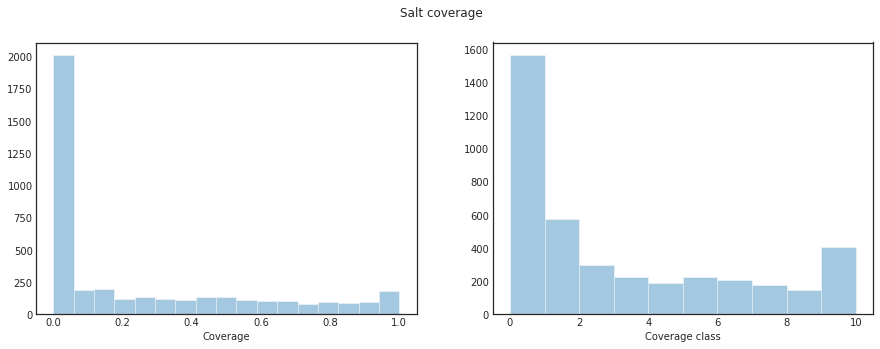

In [5]:
plot_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

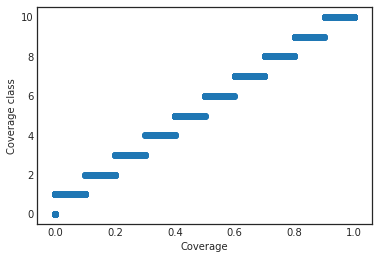

In [6]:
scatter_coverage_and_coverage_class(train_df.coverage, train_df.coverage_class)

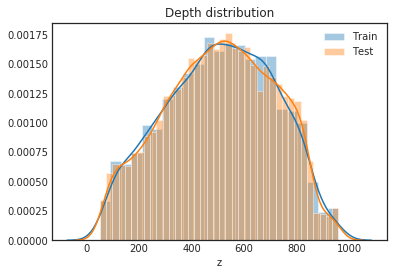

In [7]:
plot_depth_distributions(train_df.z, test_df.z)

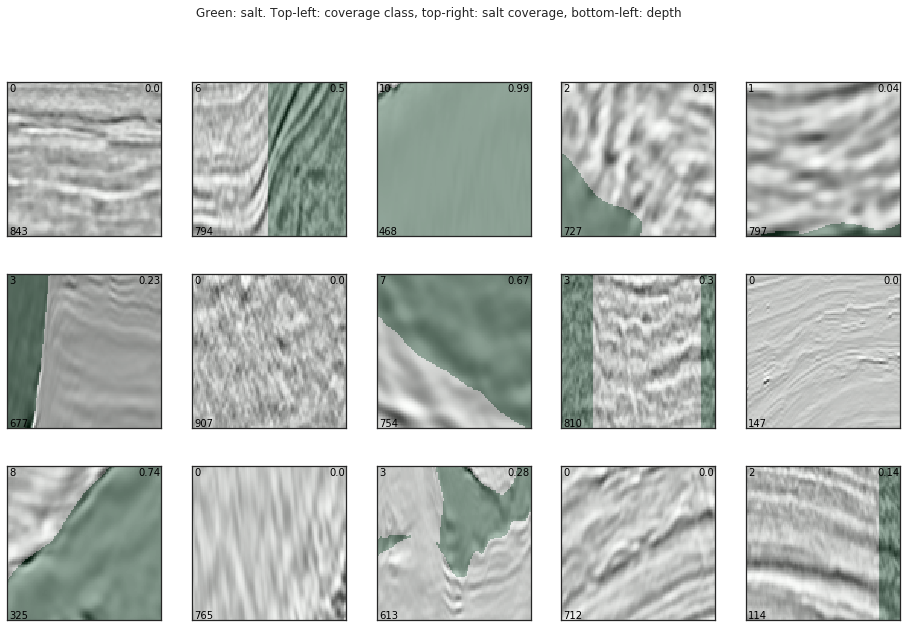

In [8]:
plot_images(train_df, max_images=15, grid_width=5, figsize=(16,10))

In [9]:
img_size_target=128
upsample101to128 = upsample(101,128)

In [10]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample101to128).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample101to128).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [11]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [12]:
model = Model(input_layer, output_layer)

In [13]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", my_iou_metric])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [15]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [16]:
model_filepath=os.path.join(model_path(), 'keras.model')
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(model_filepath, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/200


  32/6400 [..............................] - ETA: 28:42 - loss: 0.6919 - acc: 0.5554 - my_iou_metric: 0.0312

  96/6400 [..............................] - ETA: 9:34 - loss: 0.6876 - acc: 0.6406 - my_iou_metric: 0.0208 

 160/6400 [..............................] - ETA: 5:44 - loss: 0.6683 - acc: 0.6919 - my_iou_metric: 0.0125

 224/6400 [>.............................] - ETA: 4:05 - loss: 0.7190 - acc: 0.7000 - my_iou_metric: 0.0625

 288/6400 [>.............................] - ETA: 3:10 - loss: 0.7002 - acc: 0.7087 - my_iou_metric: 0.0972

 352/6400 [>.............................] - ETA: 2:35 - loss: 0.6899 - acc: 0.7218 - my_iou_metric: 0.1392

 416/6400 [>.............................] - ETA: 2:11 - loss: 0.6840 - acc: 0.7262 - my_iou_metric: 0.1875

 480/6400 [=>............................] - ETA: 1:53 - loss: 0.6797 - acc: 0.7252 - my_iou_metric: 0.2229

 544/6400 [=>............................] - ETA: 1:40 - loss: 0.6755 - acc: 0.7280 - my_iou_metric: 0.2574

 608/6400 [=>............................] - ETA: 1:29 - loss: 0.6711 - acc: 0.7309 - my_iou_metric: 0.2664

 672/6400 [==>...........................] - ETA: 1:20 - loss: 0.6674 - acc: 0.7309 - my_iou_metric: 0.2708

 736/6400 [==>...........................] - ETA: 1:13 - loss: 0.6629 - acc: 0.7308 - my_iou_metric: 0.2745

 800/6400 [==>...........................] - ETA: 1:07 - loss: 0.6585 - acc: 0.7291 - my_iou_metric: 0.2800

 864/6400 [===>..........................] - ETA: 1:02 - loss: 0.6553 - acc: 0.7274 - my_iou_metric: 0.2847

 928/6400 [===>..........................] - ETA: 57s - loss: 0.6511 - acc: 0.7276 - my_iou_metric: 0.2963 

 992/6400 [===>..........................] - ETA: 53s - loss: 0.6371 - acc: 0.7359 - my_iou_metric: 0.3065

1056/6400 [===>..........................] - ETA: 50s - loss: 0.6331 - acc: 0.7376 - my_iou_metric: 0.3125

1120/6400 [====>.........................] - ETA: 47s - loss: 0.6325 - acc: 0.7368 - my_iou_metric: 0.3161

1184/6400 [====>.........................] - ETA: 44s - loss: 0.6266 - acc: 0.7391 - my_iou_metric: 0.3243

1248/6400 [====>.........................] - ETA: 42s - loss: 0.6216 - acc: 0.7418 - my_iou_metric: 0.3269

1312/6400 [=====>........................] - ETA: 39s - loss: 0.6180 - acc: 0.7428 - my_iou_metric: 0.3277

1376/6400 [=====>........................] - ETA: 37s - loss: 0.6181 - acc: 0.7409 - my_iou_metric: 0.3256

1440/6400 [=====>........................] - ETA: 36s - loss: 0.6147 - acc: 0.7430 - my_iou_metric: 0.3361

1504/6400 [======>.......................] - ETA: 34s - loss: 0.6124 - acc: 0.7434 - my_iou_metric: 0.3324

1568/6400 [======>.......................] - ETA: 32s - loss: 0.6079 - acc: 0.7467 - my_iou_metric: 0.3393

1632/6400 [======>.......................] - ETA: 31s - loss: 0.6074 - acc: 0.7457 - my_iou_metric: 0.3395

1696/6400 [======>.......................] - ETA: 29s - loss: 0.6060 - acc: 0.7461 - my_iou_metric: 0.3443

1760/6400 [=======>......................] - ETA: 28s - loss: 0.6037 - acc: 0.7470 - my_iou_metric: 0.3455

1824/6400 [=======>......................] - ETA: 27s - loss: 0.6025 - acc: 0.7469 - my_iou_metric: 0.3476

1888/6400 [=======>......................] - ETA: 26s - loss: 0.5999 - acc: 0.7479 - my_iou_metric: 0.3485

1952/6400 [========>.....................] - ETA: 25s - loss: 0.5956 - acc: 0.7505 - my_iou_metric: 0.3519

2016/6400 [========>.....................] - ETA: 24s - loss: 0.5953 - acc: 0.7495 - my_iou_metric: 0.3512

2080/6400 [========>.....................] - ETA: 23s - loss: 0.5965 - acc: 0.7477 - my_iou_metric: 0.3500

2144/6400 [=========>....................] - ETA: 22s - loss: 0.5964 - acc: 0.7467 - my_iou_metric: 0.3493

2208/6400 [=========>....................] - ETA: 21s - loss: 0.5959 - acc: 0.7464 - my_iou_metric: 0.3492

2272/6400 [=========>....................] - ETA: 20s - loss: 0.5965 - acc: 0.7444 - my_iou_metric: 0.3508

2336/6400 [=========>....................] - ETA: 20s - loss: 0.5951 - acc: 0.7451 - my_iou_metric: 0.3527

2400/6400 [==========>...................] - ETA: 19s - loss: 0.5936 - acc: 0.7462 - my_iou_metric: 0.3538

2464/6400 [==========>...................] - ETA: 18s - loss: 0.5934 - acc: 0.7455 - my_iou_metric: 0.3547

2528/6400 [==========>...................] - ETA: 18s - loss: 0.5944 - acc: 0.7437 - my_iou_metric: 0.3536

2592/6400 [===========>..................] - ETA: 17s - loss: 0.5923 - acc: 0.7449 - my_iou_metric: 0.3557

2656/6400 [===========>..................] - ETA: 16s - loss: 0.5923 - acc: 0.7441 - my_iou_metric: 0.3558

2720/6400 [===========>..................] - ETA: 16s - loss: 0.5915 - acc: 0.7441 - my_iou_metric: 0.3559

2784/6400 [============>.................] - ETA: 15s - loss: 0.5901 - acc: 0.7446 - my_iou_metric: 0.3581

2848/6400 [============>.................] - ETA: 15s - loss: 0.5908 - acc: 0.7433 - my_iou_metric: 0.3588

2912/6400 [============>.................] - ETA: 14s - loss: 0.5907 - acc: 0.7427 - my_iou_metric: 0.3578

2976/6400 [============>.................] - ETA: 14s - loss: 0.5906 - acc: 0.7420 - my_iou_metric: 0.3569

3040/6400 [=============>................] - ETA: 13s - loss: 0.5901 - acc: 0.7417 - my_iou_metric: 0.3579

3104/6400 [=============>................] - ETA: 13s - loss: 0.5889 - acc: 0.7421 - my_iou_metric: 0.3595

3168/6400 [=============>................] - ETA: 12s - loss: 0.5888 - acc: 0.7415 - my_iou_metric: 0.3611

3232/6400 [==============>...............] - ETA: 12s - loss: 0.5901 - acc: 0.7396 - my_iou_metric: 0.3608

3296/6400 [==============>...............] - ETA: 12s - loss: 0.5894 - acc: 0.7398 - my_iou_metric: 0.3607

3360/6400 [==============>...............] - ETA: 11s - loss: 0.5889 - acc: 0.7399 - my_iou_metric: 0.3628

3424/6400 [===============>..............] - ETA: 11s - loss: 0.5887 - acc: 0.7395 - my_iou_metric: 0.3613

3488/6400 [===============>..............] - ETA: 10s - loss: 0.5869 - acc: 0.7406 - my_iou_metric: 0.3624

3552/6400 [===============>..............] - ETA: 10s - loss: 0.5871 - acc: 0.7402 - my_iou_metric: 0.3626

3616/6400 [===============>..............] - ETA: 10s - loss: 0.5866 - acc: 0.7399 - my_iou_metric: 0.3626

3680/6400 [================>.............] - ETA: 9s - loss: 0.5857 - acc: 0.7404 - my_iou_metric: 0.3630 

3744/6400 [================>.............] - ETA: 9s - loss: 0.5854 - acc: 0.7402 - my_iou_metric: 0.3624

3808/6400 [================>.............] - ETA: 9s - loss: 0.5838 - acc: 0.7411 - my_iou_metric: 0.3642

3872/6400 [=================>............] - ETA: 8s - loss: 0.5825 - acc: 0.7418 - my_iou_metric: 0.3660

3936/6400 [=================>............] - ETA: 8s - loss: 0.5816 - acc: 0.7423 - my_iou_metric: 0.3659

4000/6400 [=================>............] - ETA: 8s - loss: 0.5821 - acc: 0.7413 - my_iou_metric: 0.3648

4064/6400 [==================>...........] - ETA: 7s - loss: 0.5815 - acc: 0.7416 - my_iou_metric: 0.3647

4128/6400 [==================>...........] - ETA: 7s - loss: 0.5813 - acc: 0.7416 - my_iou_metric: 0.3646

4192/6400 [==================>...........] - ETA: 7s - loss: 0.5810 - acc: 0.7412 - my_iou_metric: 0.3655

4256/6400 [==================>...........] - ETA: 7s - loss: 0.5801 - acc: 0.7418 - my_iou_metric: 0.3665

4320/6400 [===================>..........] - ETA: 6s - loss: 0.5788 - acc: 0.7423 - my_iou_metric: 0.3681

4384/6400 [===================>..........] - ETA: 6s - loss: 0.5774 - acc: 0.7431 - my_iou_metric: 0.3688

4448/6400 [===================>..........] - ETA: 6s - loss: 0.5753 - acc: 0.7444 - my_iou_metric: 0.3707

4512/6400 [====================>.........] - ETA: 6s - loss: 0.5735 - acc: 0.7456 - my_iou_metric: 0.3726

4576/6400 [====================>.........] - ETA: 5s - loss: 0.5733 - acc: 0.7453 - my_iou_metric: 0.3735

4640/6400 [====================>.........] - ETA: 5s - loss: 0.5733 - acc: 0.7448 - my_iou_metric: 0.3733

4704/6400 [=====================>........] - ETA: 5s - loss: 0.5720 - acc: 0.7460 - my_iou_metric: 0.3729

4768/6400 [=====================>........] - ETA: 5s - loss: 0.5709 - acc: 0.7466 - my_iou_metric: 0.3729

4832/6400 [=====================>........] - ETA: 4s - loss: 0.5708 - acc: 0.7467 - my_iou_metric: 0.3721

4896/6400 [=====================>........] - ETA: 4s - loss: 0.5701 - acc: 0.7468 - my_iou_metric: 0.3719

4960/6400 [======================>.......] - ETA: 4s - loss: 0.5707 - acc: 0.7459 - my_iou_metric: 0.3712

5024/6400 [======================>.......] - ETA: 4s - loss: 0.5701 - acc: 0.7463 - my_iou_metric: 0.3716

5088/6400 [======================>.......] - ETA: 3s - loss: 0.5696 - acc: 0.7466 - my_iou_metric: 0.3728

5152/6400 [=======================>......] - ETA: 3s - loss: 0.5694 - acc: 0.7466 - my_iou_metric: 0.3736

5216/6400 [=======================>......] - ETA: 3s - loss: 0.5696 - acc: 0.7461 - my_iou_metric: 0.3727

5280/6400 [=======================>......] - ETA: 3s - loss: 0.5699 - acc: 0.7454 - my_iou_metric: 0.3723

5344/6400 [========================>.....] - ETA: 3s - loss: 0.5708 - acc: 0.7441 - my_iou_metric: 0.3709

5408/6400 [========================>.....] - ETA: 2s - loss: 0.5701 - acc: 0.7446 - my_iou_metric: 0.3711

5472/6400 [========================>.....] - ETA: 2s - loss: 0.5699 - acc: 0.7446 - my_iou_metric: 0.3712

5536/6400 [========================>.....] - ETA: 2s - loss: 0.5695 - acc: 0.7446 - my_iou_metric: 0.3707

5600/6400 [=========================>....] - ETA: 2s - loss: 0.5680 - acc: 0.7453 - my_iou_metric: 0.3716

5664/6400 [=========================>....] - ETA: 2s - loss: 0.5673 - acc: 0.7456 - my_iou_metric: 0.3727

5728/6400 [=========================>....] - ETA: 1s - loss: 0.5663 - acc: 0.7459 - my_iou_metric: 0.3727

5792/6400 [==========================>...] - ETA: 1s - loss: 0.5658 - acc: 0.7459 - my_iou_metric: 0.3733

5856/6400 [==========================>...] - ETA: 1s - loss: 0.5650 - acc: 0.7462 - my_iou_metric: 0.3743

5920/6400 [==========================>...] - ETA: 1s - loss: 0.5648 - acc: 0.7460 - my_iou_metric: 0.3748

5984/6400 [===========================>..] - ETA: 1s - loss: 0.5642 - acc: 0.7462 - my_iou_metric: 0.3745

6048/6400 [===========================>..] - ETA: 0s - loss: 0.5636 - acc: 0.7464 - my_iou_metric: 0.3745

6112/6400 [===========================>..] - ETA: 0s - loss: 0.5635 - acc: 0.7460 - my_iou_metric: 0.3739

6176/6400 [===========================>..] - ETA: 0s - loss: 0.5634 - acc: 0.7456 - my_iou_metric: 0.3744

6240/6400 [============================>.] - ETA: 0s - loss: 0.5626 - acc: 0.7458 - my_iou_metric: 0.3747

6304/6400 [============================>.] - ETA: 0s - loss: 0.5610 - acc: 0.7466 - my_iou_metric: 0.3756

6368/6400 [============================>.] - ETA: 0s - loss: 0.5608 - acc: 0.7469 - my_iou_metric: 0.3769

6400/6400 [==============================] - 18s 3ms/step - loss: 0.5605 - acc: 0.7471 - my_iou_metric: 0.3775 - val_loss: 0.5709 - val_acc: 0.7468 - val_my_iou_metric: 0.3900



Epoch 00001: val_loss improved from inf to 0.57085, saving model to /mnt/models/mat_dev/keras.model


Epoch 2/200
  32/6400 [..............................] - ETA: 8s - loss: 0.5450 - acc: 0.7928 - my_iou_metric: 0.3438

  96/6400 [..............................] - ETA: 8s - loss: 0.5898 - acc: 0.7214 - my_iou_metric: 0.3438

 160/6400 [..............................] - ETA: 8s - loss: 0.5844 - acc: 0.7497 - my_iou_metric: 0.3438

 224/6400 [>.............................] - ETA: 8s - loss: 0.5823 - acc: 0.7552 - my_iou_metric: 0.3438

 288/6400 [>.............................] - ETA: 7s - loss: 0.5823 - acc: 0.7516 - my_iou_metric: 0.3646

 352/6400 [>.............................] - ETA: 7s - loss: 0.5852 - acc: 0.7408 - my_iou_metric: 0.3551

 416/6400 [>.............................] - ETA: 7s - loss: 0.5765 - acc: 0.7446 - my_iou_metric: 0.3582

 480/6400 [=>............................] - ETA: 7s - loss: 0.5793 - acc: 0.7373 - my_iou_metric: 0.3521

 544/6400 [=>............................] - ETA: 7s - loss: 0.5675 - acc: 0.7439 - my_iou_metric: 0.3658

 608/6400 [=>............................] - ETA: 7s - loss: 0.5596 - acc: 0.7474 - my_iou_metric: 0.3750

 672/6400 [==>...........................] - ETA: 7s - loss: 0.5570 - acc: 0.7481 - my_iou_metric: 0.3780

 736/6400 [==>...........................] - ETA: 7s - loss: 0.5546 - acc: 0.7479 - my_iou_metric: 0.3750

 800/6400 [==>...........................] - ETA: 7s - loss: 0.5548 - acc: 0.7454 - my_iou_metric: 0.3750

 864/6400 [===>..........................] - ETA: 7s - loss: 0.5525 - acc: 0.7459 - my_iou_metric: 0.3750

 928/6400 [===>..........................] - ETA: 7s - loss: 0.5482 - acc: 0.7475 - my_iou_metric: 0.3772

 992/6400 [===>..........................] - ETA: 7s - loss: 0.5448 - acc: 0.7500 - my_iou_metric: 0.3851

1056/6400 [===>..........................] - ETA: 6s - loss: 0.5383 - acc: 0.7537 - my_iou_metric: 0.3920

1120/6400 [====>.........................] - ETA: 6s - loss: 0.5354 - acc: 0.7538 - my_iou_metric: 0.3946

1184/6400 [====>.........................] - ETA: 6s - loss: 0.5336 - acc: 0.7527 - my_iou_metric: 0.3927

1248/6400 [====>.........................] - ETA: 6s - loss: 0.5337 - acc: 0.7509 - my_iou_metric: 0.3926

1312/6400 [=====>........................] - ETA: 6s - loss: 0.5316 - acc: 0.7512 - my_iou_metric: 0.3910

1376/6400 [=====>........................] - ETA: 6s - loss: 0.5262 - acc: 0.7528 - my_iou_metric: 0.3917

1440/6400 [=====>........................] - ETA: 6s - loss: 0.5261 - acc: 0.7515 - my_iou_metric: 0.3903

1504/6400 [======>.......................] - ETA: 6s - loss: 0.5239 - acc: 0.7521 - my_iou_metric: 0.3903

1568/6400 [======>.......................] - ETA: 6s - loss: 0.5203 - acc: 0.7545 - my_iou_metric: 0.3941

1632/6400 [======>.......................] - ETA: 6s - loss: 0.5204 - acc: 0.7525 - my_iou_metric: 0.3934

1696/6400 [======>.......................] - ETA: 6s - loss: 0.5175 - acc: 0.7530 - my_iou_metric: 0.3974

1760/6400 [=======>......................] - ETA: 6s - loss: 0.5159 - acc: 0.7522 - my_iou_metric: 0.3972

1824/6400 [=======>......................] - ETA: 5s - loss: 0.5171 - acc: 0.7488 - my_iou_metric: 0.3958

1888/6400 [=======>......................] - ETA: 5s - loss: 0.5143 - acc: 0.7504 - my_iou_metric: 0.3967

1952/6400 [========>.....................] - ETA: 5s - loss: 0.5122 - acc: 0.7497 - my_iou_metric: 0.3950

2016/6400 [========>.....................] - ETA: 5s - loss: 0.5096 - acc: 0.7496 - my_iou_metric: 0.3963

2080/6400 [========>.....................] - ETA: 5s - loss: 0.5098 - acc: 0.7487 - my_iou_metric: 0.3933

2144/6400 [=========>....................] - ETA: 5s - loss: 0.5058 - acc: 0.7507 - my_iou_metric: 0.3923

2208/6400 [=========>....................] - ETA: 5s - loss: 0.5042 - acc: 0.7518 - my_iou_metric: 0.3945

2272/6400 [=========>....................] - ETA: 5s - loss: 0.5043 - acc: 0.7516 - my_iou_metric: 0.3922

2336/6400 [=========>....................] - ETA: 5s - loss: 0.5053 - acc: 0.7510 - my_iou_metric: 0.3921

2400/6400 [==========>...................] - ETA: 5s - loss: 0.5048 - acc: 0.7505 - my_iou_metric: 0.3921

2464/6400 [==========>...................] - ETA: 5s - loss: 0.5022 - acc: 0.7522 - my_iou_metric: 0.3953

2528/6400 [==========>...................] - ETA: 5s - loss: 0.5042 - acc: 0.7519 - my_iou_metric: 0.3940

2592/6400 [===========>..................] - ETA: 4s - loss: 0.5051 - acc: 0.7520 - my_iou_metric: 0.3912

2656/6400 [===========>..................] - ETA: 4s - loss: 0.5056 - acc: 0.7537 - my_iou_metric: 0.3881

2720/6400 [===========>..................] - ETA: 4s - loss: 0.5067 - acc: 0.7545 - my_iou_metric: 0.3887

2784/6400 [============>.................] - ETA: 4s - loss: 0.5067 - acc: 0.7542 - my_iou_metric: 0.3880

2848/6400 [============>.................] - ETA: 4s - loss: 0.5076 - acc: 0.7536 - my_iou_metric: 0.3877

2912/6400 [============>.................] - ETA: 4s - loss: 0.5058 - acc: 0.7552 - my_iou_metric: 0.3912

2976/6400 [============>.................] - ETA: 4s - loss: 0.5056 - acc: 0.7554 - my_iou_metric: 0.3919

3040/6400 [=============>................] - ETA: 4s - loss: 0.5060 - acc: 0.7549 - my_iou_metric: 0.3922

3104/6400 [=============>................] - ETA: 4s - loss: 0.5072 - acc: 0.7531 - my_iou_metric: 0.3922

3168/6400 [=============>................] - ETA: 4s - loss: 0.5072 - acc: 0.7528 - my_iou_metric: 0.3921

3232/6400 [==============>...............] - ETA: 4s - loss: 0.5059 - acc: 0.7543 - my_iou_metric: 0.3933

3296/6400 [==============>...............] - ETA: 4s - loss: 0.5045 - acc: 0.7543 - my_iou_metric: 0.3951

3360/6400 [==============>...............] - ETA: 3s - loss: 0.5037 - acc: 0.7545 - my_iou_metric: 0.3953

3424/6400 [===============>..............] - ETA: 3s - loss: 0.5039 - acc: 0.7535 - my_iou_metric: 0.3944

3488/6400 [===============>..............] - ETA: 3s - loss: 0.5031 - acc: 0.7537 - my_iou_metric: 0.3957

3552/6400 [===============>..............] - ETA: 3s - loss: 0.5037 - acc: 0.7525 - my_iou_metric: 0.3945

3616/6400 [===============>..............] - ETA: 3s - loss: 0.5025 - acc: 0.7532 - my_iou_metric: 0.3955

3680/6400 [================>.............] - ETA: 3s - loss: 0.5013 - acc: 0.7542 - my_iou_metric: 0.3949

3744/6400 [================>.............] - ETA: 3s - loss: 0.5015 - acc: 0.7534 - my_iou_metric: 0.3935

3808/6400 [================>.............] - ETA: 3s - loss: 0.5021 - acc: 0.7532 - my_iou_metric: 0.3900

3872/6400 [=================>............] - ETA: 3s - loss: 0.5020 - acc: 0.7533 - my_iou_metric: 0.3888

3936/6400 [=================>............] - ETA: 3s - loss: 0.5019 - acc: 0.7527 - my_iou_metric: 0.3875

4000/6400 [=================>............] - ETA: 3s - loss: 0.5022 - acc: 0.7525 - my_iou_metric: 0.3858

4064/6400 [==================>...........] - ETA: 3s - loss: 0.5016 - acc: 0.7524 - my_iou_metric: 0.3854

4128/6400 [==================>...........] - ETA: 2s - loss: 0.5013 - acc: 0.7530 - my_iou_metric: 0.3848

4192/6400 [==================>...........] - ETA: 2s - loss: 0.5006 - acc: 0.7537 - my_iou_metric: 0.3852

4256/6400 [==================>...........] - ETA: 2s - loss: 0.5006 - acc: 0.7540 - my_iou_metric: 0.3839

4320/6400 [===================>..........] - ETA: 2s - loss: 0.5006 - acc: 0.7545 - my_iou_metric: 0.3813

4384/6400 [===================>..........] - ETA: 2s - loss: 0.5007 - acc: 0.7547 - my_iou_metric: 0.3780

4448/6400 [===================>..........] - ETA: 2s - loss: 0.5007 - acc: 0.7550 - my_iou_metric: 0.3766

4512/6400 [====================>.........] - ETA: 2s - loss: 0.5006 - acc: 0.7554 - my_iou_metric: 0.3751

4576/6400 [====================>.........] - ETA: 2s - loss: 0.5001 - acc: 0.7560 - my_iou_metric: 0.3733

4640/6400 [====================>.........] - ETA: 2s - loss: 0.4991 - acc: 0.7570 - my_iou_metric: 0.3723

4704/6400 [=====================>........] - ETA: 2s - loss: 0.4992 - acc: 0.7568 - my_iou_metric: 0.3725

4768/6400 [=====================>........] - ETA: 2s - loss: 0.4980 - acc: 0.7578 - my_iou_metric: 0.3732

4832/6400 [=====================>........] - ETA: 2s - loss: 0.4971 - acc: 0.7587 - my_iou_metric: 0.3723

4896/6400 [=====================>........] - ETA: 1s - loss: 0.4964 - acc: 0.7594 - my_iou_metric: 0.3726

4960/6400 [======================>.......] - ETA: 1s - loss: 0.4949 - acc: 0.7603 - my_iou_metric: 0.3721

5024/6400 [======================>.......] - ETA: 1s - loss: 0.4949 - acc: 0.7608 - my_iou_metric: 0.3716

5088/6400 [======================>.......] - ETA: 1s - loss: 0.4936 - acc: 0.7617 - my_iou_metric: 0.3711

5152/6400 [=======================>......] - ETA: 1s - loss: 0.4933 - acc: 0.7623 - my_iou_metric: 0.3721

5216/6400 [=======================>......] - ETA: 1s - loss: 0.4925 - acc: 0.7627 - my_iou_metric: 0.3715

5280/6400 [=======================>......] - ETA: 1s - loss: 0.4925 - acc: 0.7629 - my_iou_metric: 0.3713

5344/6400 [========================>.....] - ETA: 1s - loss: 0.4916 - acc: 0.7637 - my_iou_metric: 0.3699

5408/6400 [========================>.....] - ETA: 1s - loss: 0.4908 - acc: 0.7645 - my_iou_metric: 0.3688

5472/6400 [========================>.....] - ETA: 1s - loss: 0.4906 - acc: 0.7650 - my_iou_metric: 0.3689

5536/6400 [========================>.....] - ETA: 1s - loss: 0.4897 - acc: 0.7658 - my_iou_metric: 0.3674

5600/6400 [=========================>....] - ETA: 1s - loss: 0.4892 - acc: 0.7664 - my_iou_metric: 0.3663

5664/6400 [=========================>....] - ETA: 0s - loss: 0.4884 - acc: 0.7673 - my_iou_metric: 0.3672

5728/6400 [=========================>....] - ETA: 0s - loss: 0.4872 - acc: 0.7681 - my_iou_metric: 0.3668

5792/6400 [==========================>...] - ETA: 0s - loss: 0.4862 - acc: 0.7687 - my_iou_metric: 0.3662

5856/6400 [==========================>...] - ETA: 0s - loss: 0.4857 - acc: 0.7691 - my_iou_metric: 0.3647

5920/6400 [==========================>...] - ETA: 0s - loss: 0.4846 - acc: 0.7699 - my_iou_metric: 0.3650

5984/6400 [===========================>..] - ETA: 0s - loss: 0.4840 - acc: 0.7703 - my_iou_metric: 0.3650

6048/6400 [===========================>..] - ETA: 0s - loss: 0.4828 - acc: 0.7712 - my_iou_metric: 0.3661

6112/6400 [===========================>..] - ETA: 0s - loss: 0.4816 - acc: 0.7719 - my_iou_metric: 0.3660

6176/6400 [===========================>..] - ETA: 0s - loss: 0.4809 - acc: 0.7726 - my_iou_metric: 0.3663

6240/6400 [============================>.] - ETA: 0s - loss: 0.4808 - acc: 0.7728 - my_iou_metric: 0.3659

6304/6400 [============================>.] - ETA: 0s - loss: 0.4792 - acc: 0.7739 - my_iou_metric: 0.3661

6368/6400 [============================>.] - ETA: 0s - loss: 0.4790 - acc: 0.7739 - my_iou_metric: 0.3666

6400/6400 [==============================] - 9s 1ms/step - loss: 0.4788 - acc: 0.7741 - my_iou_metric: 0.3658 - val_loss: 0.3969 - val_acc: 0.8415 - val_my_iou_metric: 0.3778



Epoch 00002: val_loss improved from 0.57085 to 0.39692, saving model to /mnt/models/mat_dev/keras.model
Epoch 3/200
  32/6400 [..............................] - ETA: 8s - loss: 0.5064 - acc: 0.7681 - my_iou_metric: 0.2375

  96/6400 [..............................] - ETA: 8s - loss: 0.4177 - acc: 0.8253 - my_iou_metric: 0.2708

 160/6400 [..............................] - ETA: 8s - loss: 0.3933 - acc: 0.8356 - my_iou_metric: 0.3338

 224/6400 [>.............................] - ETA: 8s - loss: 0.3859 - acc: 0.8392 - my_iou_metric: 0.3290

 288/6400 [>.............................] - ETA: 7s - loss: 0.3931 - acc: 0.8385 - my_iou_metric: 0.3240

 352/6400 [>.............................] - ETA: 7s - loss: 0.3808 - acc: 0.8418 - my_iou_metric: 0.3514

 416/6400 [>.............................] - ETA: 7s - loss: 0.3777 - acc: 0.8419 - my_iou_metric: 0.3493

 480/6400 [=>............................] - ETA: 7s - loss: 0.3978 - acc: 0.8326 - my_iou_metric: 0.3563

 544/6400 [=>............................] - ETA: 7s - loss: 0.3990 - acc: 0.8314 - my_iou_metric: 0.3561

 608/6400 [=>............................] - ETA: 7s - loss: 0.4161 - acc: 0.8190 - my_iou_metric: 0.3431

 672/6400 [==>...........................] - ETA: 7s - loss: 0.4151 - acc: 0.8198 - my_iou_metric: 0.3513

 736/6400 [==>...........................] - ETA: 7s - loss: 0.4203 - acc: 0.8152 - my_iou_metric: 0.3508

 800/6400 [==>...........................] - ETA: 7s - loss: 0.4207 - acc: 0.8147 - my_iou_metric: 0.3520

 864/6400 [===>..........................] - ETA: 7s - loss: 0.4223 - acc: 0.8136 - my_iou_metric: 0.3524

 928/6400 [===>..........................] - ETA: 7s - loss: 0.4218 - acc: 0.8162 - my_iou_metric: 0.3481

 992/6400 [===>..........................] - ETA: 7s - loss: 0.4188 - acc: 0.8185 - my_iou_metric: 0.3519

1056/6400 [===>..........................] - ETA: 6s - loss: 0.4198 - acc: 0.8180 - my_iou_metric: 0.3528

1120/6400 [====>.........................] - ETA: 6s - loss: 0.4142 - acc: 0.8211 - my_iou_metric: 0.3480

1184/6400 [====>.........................] - ETA: 6s - loss: 0.4109 - acc: 0.8231 - my_iou_metric: 0.3461

1248/6400 [====>.........................] - ETA: 6s - loss: 0.4125 - acc: 0.8222 - my_iou_metric: 0.3456

1312/6400 [=====>........................] - ETA: 6s - loss: 0.4120 - acc: 0.8226 - my_iou_metric: 0.3450

1376/6400 [=====>........................] - ETA: 6s - loss: 0.4105 - acc: 0.8227 - my_iou_metric: 0.3435

1440/6400 [=====>........................] - ETA: 6s - loss: 0.4088 - acc: 0.8237 - my_iou_metric: 0.3423

1504/6400 [======>.......................] - ETA: 6s - loss: 0.4095 - acc: 0.8239 - my_iou_metric: 0.3414

1568/6400 [======>.......................] - ETA: 6s - loss: 0.4074 - acc: 0.8248 - my_iou_metric: 0.3427

1632/6400 [======>.......................] - ETA: 6s - loss: 0.4031 - acc: 0.8273 - my_iou_metric: 0.3435

1696/6400 [======>.......................] - ETA: 6s - loss: 0.4041 - acc: 0.8273 - my_iou_metric: 0.3480

1760/6400 [=======>......................] - ETA: 6s - loss: 0.4018 - acc: 0.8283 - my_iou_metric: 0.3511

1824/6400 [=======>......................] - ETA: 5s - loss: 0.4007 - acc: 0.8293 - my_iou_metric: 0.3549

1888/6400 [=======>......................] - ETA: 5s - loss: 0.4005 - acc: 0.8289 - my_iou_metric: 0.3573

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3990 - acc: 0.8292 - my_iou_metric: 0.3567

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3961 - acc: 0.8308 - my_iou_metric: 0.3598

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3991 - acc: 0.8300 - my_iou_metric: 0.3647

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3988 - acc: 0.8305 - my_iou_metric: 0.3659

2208/6400 [=========>....................] - ETA: 5s - loss: 0.4007 - acc: 0.8297 - my_iou_metric: 0.3665

2272/6400 [=========>....................] - ETA: 5s - loss: 0.4013 - acc: 0.8290 - my_iou_metric: 0.3674

2336/6400 [=========>....................] - ETA: 5s - loss: 0.4001 - acc: 0.8296 - my_iou_metric: 0.3693

2400/6400 [==========>...................] - ETA: 5s - loss: 0.4015 - acc: 0.8289 - my_iou_metric: 0.3689

2464/6400 [==========>...................] - ETA: 5s - loss: 0.4017 - acc: 0.8288 - my_iou_metric: 0.3701

2528/6400 [==========>...................] - ETA: 5s - loss: 0.4016 - acc: 0.8291 - my_iou_metric: 0.3693

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3996 - acc: 0.8303 - my_iou_metric: 0.3708

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3999 - acc: 0.8298 - my_iou_metric: 0.3699

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3980 - acc: 0.8311 - my_iou_metric: 0.3681

2784/6400 [============>.................] - ETA: 4s - loss: 0.3979 - acc: 0.8311 - my_iou_metric: 0.3679

2848/6400 [============>.................] - ETA: 4s - loss: 0.3965 - acc: 0.8316 - my_iou_metric: 0.3696

2912/6400 [============>.................] - ETA: 4s - loss: 0.3956 - acc: 0.8322 - my_iou_metric: 0.3727

2976/6400 [============>.................] - ETA: 4s - loss: 0.3949 - acc: 0.8327 - my_iou_metric: 0.3727

3040/6400 [=============>................] - ETA: 4s - loss: 0.3933 - acc: 0.8336 - my_iou_metric: 0.3733

3104/6400 [=============>................] - ETA: 4s - loss: 0.3934 - acc: 0.8333 - my_iou_metric: 0.3725

3168/6400 [=============>................] - ETA: 4s - loss: 0.3912 - acc: 0.8344 - my_iou_metric: 0.3753

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3921 - acc: 0.8341 - my_iou_metric: 0.3755

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3923 - acc: 0.8342 - my_iou_metric: 0.3771

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3914 - acc: 0.8348 - my_iou_metric: 0.3787

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3913 - acc: 0.8348 - my_iou_metric: 0.3776

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3908 - acc: 0.8352 - my_iou_metric: 0.3780

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3921 - acc: 0.8348 - my_iou_metric: 0.3799

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3910 - acc: 0.8355 - my_iou_metric: 0.3807

3680/6400 [================>.............] - ETA: 3s - loss: 0.3894 - acc: 0.8364 - my_iou_metric: 0.3844

3744/6400 [================>.............] - ETA: 3s - loss: 0.3895 - acc: 0.8363 - my_iou_metric: 0.3860

3808/6400 [================>.............] - ETA: 3s - loss: 0.3887 - acc: 0.8367 - my_iou_metric: 0.3876

3872/6400 [=================>............] - ETA: 3s - loss: 0.3879 - acc: 0.8370 - my_iou_metric: 0.3864

3936/6400 [=================>............] - ETA: 3s - loss: 0.3865 - acc: 0.8376 - my_iou_metric: 0.3867

4000/6400 [=================>............] - ETA: 3s - loss: 0.3864 - acc: 0.8377 - my_iou_metric: 0.3866

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3876 - acc: 0.8369 - my_iou_metric: 0.3868

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3873 - acc: 0.8370 - my_iou_metric: 0.3862

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3877 - acc: 0.8362 - my_iou_metric: 0.3863

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3866 - acc: 0.8366 - my_iou_metric: 0.3866

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3876 - acc: 0.8356 - my_iou_metric: 0.3858

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3876 - acc: 0.8356 - my_iou_metric: 0.3857

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3891 - acc: 0.8352 - my_iou_metric: 0.3862

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3899 - acc: 0.8349 - my_iou_metric: 0.3867

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3895 - acc: 0.8358 - my_iou_metric: 0.3897

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3898 - acc: 0.8359 - my_iou_metric: 0.3905

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3894 - acc: 0.8363 - my_iou_metric: 0.3917

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3891 - acc: 0.8365 - my_iou_metric: 0.3913

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3896 - acc: 0.8365 - my_iou_metric: 0.3923

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3891 - acc: 0.8367 - my_iou_metric: 0.3935

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3895 - acc: 0.8362 - my_iou_metric: 0.3937

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3898 - acc: 0.8356 - my_iou_metric: 0.3929

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3897 - acc: 0.8356 - my_iou_metric: 0.3930

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3877 - acc: 0.8367 - my_iou_metric: 0.3950

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3883 - acc: 0.8365 - my_iou_metric: 0.3952

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3880 - acc: 0.8365 - my_iou_metric: 0.3955

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3890 - acc: 0.8360 - my_iou_metric: 0.3941

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3891 - acc: 0.8359 - my_iou_metric: 0.3942

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3905 - acc: 0.8348 - my_iou_metric: 0.3944

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3906 - acc: 0.8347 - my_iou_metric: 0.3939

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3898 - acc: 0.8353 - my_iou_metric: 0.3943

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3896 - acc: 0.8354 - my_iou_metric: 0.3944

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3890 - acc: 0.8358 - my_iou_metric: 0.3944

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3897 - acc: 0.8356 - my_iou_metric: 0.3953

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3904 - acc: 0.8352 - my_iou_metric: 0.3945

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3907 - acc: 0.8352 - my_iou_metric: 0.3929

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3910 - acc: 0.8350 - my_iou_metric: 0.3920

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3907 - acc: 0.8352 - my_iou_metric: 0.3925

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3905 - acc: 0.8353 - my_iou_metric: 0.3927

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3909 - acc: 0.8350 - my_iou_metric: 0.3927

6240/6400 [============================>.] - ETA: 0s - loss: 0.3909 - acc: 0.8349 - my_iou_metric: 0.3917

6304/6400 [============================>.] - ETA: 0s - loss: 0.3910 - acc: 0.8348 - my_iou_metric: 0.3908

6368/6400 [============================>.] - ETA: 0s - loss: 0.3904 - acc: 0.8351 - my_iou_metric: 0.3905

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3898 - acc: 0.8353 - my_iou_metric: 0.3915 - val_loss: 0.3378 - val_acc: 0.8598 - val_my_iou_metric: 0.4784



Epoch 00003: val_loss improved from 0.39692 to 0.33779, saving model to /mnt/models/mat_dev/keras.model
Epoch 4/200
  32/6400 [..............................] - ETA: 8s - loss: 0.4864 - acc: 0.8166 - my_iou_metric: 0.4000

  96/6400 [..............................] - ETA: 8s - loss: 0.3831 - acc: 0.8395 - my_iou_metric: 0.4531

 160/6400 [..............................] - ETA: 8s - loss: 0.3740 - acc: 0.8386 - my_iou_metric: 0.4119

 224/6400 [>.............................] - ETA: 7s - loss: 0.3552 - acc: 0.8502 - my_iou_metric: 0.4281

 288/6400 [>.............................] - ETA: 7s - loss: 0.3621 - acc: 0.8465 - my_iou_metric: 0.4267

 352/6400 [>.............................] - ETA: 7s - loss: 0.3596 - acc: 0.8489 - my_iou_metric: 0.4278

 416/6400 [>.............................] - ETA: 7s - loss: 0.3503 - acc: 0.8535 - my_iou_metric: 0.4288

 480/6400 [=>............................] - ETA: 7s - loss: 0.3547 - acc: 0.8501 - my_iou_metric: 0.4217

 544/6400 [=>............................] - ETA: 7s - loss: 0.3649 - acc: 0.8449 - my_iou_metric: 0.4138

 608/6400 [=>............................] - ETA: 7s - loss: 0.3552 - acc: 0.8497 - my_iou_metric: 0.4183

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3545 - acc: 0.8502 - my_iou_metric: 0.4265

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3595 - acc: 0.8480 - my_iou_metric: 0.4285

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3540 - acc: 0.8509 - my_iou_metric: 0.4367

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3475 - acc: 0.8548 - my_iou_metric: 0.4378

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3421 - acc: 0.8581 - my_iou_metric: 0.4428

 992/6400 [===>..........................] - ETA: 7s - loss: 0.3401 - acc: 0.8583 - my_iou_metric: 0.4417

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3426 - acc: 0.8568 - my_iou_metric: 0.4416

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3413 - acc: 0.8571 - my_iou_metric: 0.4387

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3410 - acc: 0.8575 - my_iou_metric: 0.4442

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3381 - acc: 0.8592 - my_iou_metric: 0.4462

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3362 - acc: 0.8600 - my_iou_metric: 0.4450

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3414 - acc: 0.8578 - my_iou_metric: 0.4417

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3422 - acc: 0.8576 - my_iou_metric: 0.4436

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3394 - acc: 0.8587 - my_iou_metric: 0.4477

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3394 - acc: 0.8589 - my_iou_metric: 0.4474

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3380 - acc: 0.8600 - my_iou_metric: 0.4521

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3364 - acc: 0.8606 - my_iou_metric: 0.4519

1760/6400 [=======>......................] - ETA: 6s - loss: 0.3394 - acc: 0.8597 - my_iou_metric: 0.4505

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3445 - acc: 0.8575 - my_iou_metric: 0.4473

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3463 - acc: 0.8569 - my_iou_metric: 0.4461

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3483 - acc: 0.8563 - my_iou_metric: 0.4445

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3492 - acc: 0.8565 - my_iou_metric: 0.4438

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3504 - acc: 0.8559 - my_iou_metric: 0.4430

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3496 - acc: 0.8563 - my_iou_metric: 0.4416

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3501 - acc: 0.8561 - my_iou_metric: 0.4432

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3507 - acc: 0.8558 - my_iou_metric: 0.4423

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3521 - acc: 0.8552 - my_iou_metric: 0.4402

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3536 - acc: 0.8536 - my_iou_metric: 0.4408

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3523 - acc: 0.8544 - my_iou_metric: 0.4388

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3503 - acc: 0.8557 - my_iou_metric: 0.4402

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3508 - acc: 0.8556 - my_iou_metric: 0.4409

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3526 - acc: 0.8547 - my_iou_metric: 0.4413

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3521 - acc: 0.8553 - my_iou_metric: 0.4400

2784/6400 [============>.................] - ETA: 4s - loss: 0.3523 - acc: 0.8553 - my_iou_metric: 0.4392

2848/6400 [============>.................] - ETA: 4s - loss: 0.3514 - acc: 0.8560 - my_iou_metric: 0.4393

2912/6400 [============>.................] - ETA: 4s - loss: 0.3510 - acc: 0.8562 - my_iou_metric: 0.4398

2976/6400 [============>.................] - ETA: 4s - loss: 0.3503 - acc: 0.8565 - my_iou_metric: 0.4416

3040/6400 [=============>................] - ETA: 4s - loss: 0.3497 - acc: 0.8567 - my_iou_metric: 0.4418

3104/6400 [=============>................] - ETA: 4s - loss: 0.3498 - acc: 0.8567 - my_iou_metric: 0.4422

3168/6400 [=============>................] - ETA: 4s - loss: 0.3472 - acc: 0.8578 - my_iou_metric: 0.4420

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3465 - acc: 0.8580 - my_iou_metric: 0.4426

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3460 - acc: 0.8582 - my_iou_metric: 0.4421

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3456 - acc: 0.8583 - my_iou_metric: 0.4424

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3447 - acc: 0.8587 - my_iou_metric: 0.4422

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3442 - acc: 0.8588 - my_iou_metric: 0.4418

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3444 - acc: 0.8588 - my_iou_metric: 0.4403

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3427 - acc: 0.8594 - my_iou_metric: 0.4416

3680/6400 [================>.............] - ETA: 3s - loss: 0.3430 - acc: 0.8594 - my_iou_metric: 0.4431

3744/6400 [================>.............] - ETA: 3s - loss: 0.3444 - acc: 0.8586 - my_iou_metric: 0.4421

3808/6400 [================>.............] - ETA: 3s - loss: 0.3444 - acc: 0.8587 - my_iou_metric: 0.4434

3872/6400 [=================>............] - ETA: 3s - loss: 0.3429 - acc: 0.8594 - my_iou_metric: 0.4454

3936/6400 [=================>............] - ETA: 3s - loss: 0.3421 - acc: 0.8596 - my_iou_metric: 0.4447

4000/6400 [=================>............] - ETA: 3s - loss: 0.3414 - acc: 0.8599 - my_iou_metric: 0.4454

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3409 - acc: 0.8601 - my_iou_metric: 0.4455

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3425 - acc: 0.8592 - my_iou_metric: 0.4441

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3423 - acc: 0.8592 - my_iou_metric: 0.4439

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3419 - acc: 0.8594 - my_iou_metric: 0.4454

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3410 - acc: 0.8599 - my_iou_metric: 0.4471

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3401 - acc: 0.8603 - my_iou_metric: 0.4469

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3397 - acc: 0.8603 - my_iou_metric: 0.4460

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3385 - acc: 0.8608 - my_iou_metric: 0.4453

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3403 - acc: 0.8606 - my_iou_metric: 0.4447

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3407 - acc: 0.8605 - my_iou_metric: 0.4444

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3414 - acc: 0.8601 - my_iou_metric: 0.4450

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3415 - acc: 0.8602 - my_iou_metric: 0.4449

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3406 - acc: 0.8608 - my_iou_metric: 0.4460

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3398 - acc: 0.8614 - my_iou_metric: 0.4469

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3399 - acc: 0.8612 - my_iou_metric: 0.4474

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3402 - acc: 0.8609 - my_iou_metric: 0.4468

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3402 - acc: 0.8607 - my_iou_metric: 0.4465

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3397 - acc: 0.8609 - my_iou_metric: 0.4466

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3392 - acc: 0.8610 - my_iou_metric: 0.4456

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3387 - acc: 0.8612 - my_iou_metric: 0.4461

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3398 - acc: 0.8607 - my_iou_metric: 0.4452

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3394 - acc: 0.8607 - my_iou_metric: 0.4454

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3385 - acc: 0.8612 - my_iou_metric: 0.4450

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3382 - acc: 0.8613 - my_iou_metric: 0.4441

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3385 - acc: 0.8612 - my_iou_metric: 0.4439

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3391 - acc: 0.8607 - my_iou_metric: 0.4428

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3387 - acc: 0.8610 - my_iou_metric: 0.4436

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3388 - acc: 0.8608 - my_iou_metric: 0.4436

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3386 - acc: 0.8609 - my_iou_metric: 0.4440

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3377 - acc: 0.8613 - my_iou_metric: 0.4445

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3380 - acc: 0.8613 - my_iou_metric: 0.4455

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3374 - acc: 0.8617 - my_iou_metric: 0.4464

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3369 - acc: 0.8619 - my_iou_metric: 0.4477

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3368 - acc: 0.8619 - my_iou_metric: 0.4480

6240/6400 [============================>.] - ETA: 0s - loss: 0.3368 - acc: 0.8618 - my_iou_metric: 0.4484

6304/6400 [============================>.] - ETA: 0s - loss: 0.3361 - acc: 0.8621 - my_iou_metric: 0.4485

6368/6400 [============================>.] - ETA: 0s - loss: 0.3355 - acc: 0.8624 - my_iou_metric: 0.4478

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3357 - acc: 0.8623 - my_iou_metric: 0.4472 - val_loss: 0.3376 - val_acc: 0.8606 - val_my_iou_metric: 0.4439



Epoch 00004: val_loss improved from 0.33779 to 0.33761, saving model to /mnt/models/mat_dev/keras.model
Epoch 5/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2618 - acc: 0.8985 - my_iou_metric: 0.5219

  96/6400 [..............................] - ETA: 8s - loss: 0.3110 - acc: 0.8607 - my_iou_metric: 0.4875

 160/6400 [..............................] - ETA: 8s - loss: 0.3191 - acc: 0.8648 - my_iou_metric: 0.4637

 224/6400 [>.............................] - ETA: 8s - loss: 0.3066 - acc: 0.8717 - my_iou_metric: 0.4741

 288/6400 [>.............................] - ETA: 8s - loss: 0.3023 - acc: 0.8766 - my_iou_metric: 0.4635

 352/6400 [>.............................] - ETA: 7s - loss: 0.3059 - acc: 0.8747 - my_iou_metric: 0.4491

 416/6400 [>.............................] - ETA: 7s - loss: 0.3113 - acc: 0.8728 - my_iou_metric: 0.4565

 480/6400 [=>............................] - ETA: 7s - loss: 0.3168 - acc: 0.8715 - my_iou_metric: 0.4575

 544/6400 [=>............................] - ETA: 7s - loss: 0.3094 - acc: 0.8744 - my_iou_metric: 0.4721

 608/6400 [=>............................] - ETA: 7s - loss: 0.3090 - acc: 0.8745 - my_iou_metric: 0.4765

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3162 - acc: 0.8704 - my_iou_metric: 0.4863

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3118 - acc: 0.8730 - my_iou_metric: 0.4871

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3149 - acc: 0.8704 - my_iou_metric: 0.4841

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3147 - acc: 0.8718 - my_iou_metric: 0.4914

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3126 - acc: 0.8729 - my_iou_metric: 0.4927

 992/6400 [===>..........................] - ETA: 7s - loss: 0.3110 - acc: 0.8739 - my_iou_metric: 0.4889

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3146 - acc: 0.8720 - my_iou_metric: 0.4923

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3186 - acc: 0.8719 - my_iou_metric: 0.4894

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3164 - acc: 0.8734 - my_iou_metric: 0.4899

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3190 - acc: 0.8718 - my_iou_metric: 0.4899

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3219 - acc: 0.8698 - my_iou_metric: 0.4845

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3201 - acc: 0.8712 - my_iou_metric: 0.4856

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3205 - acc: 0.8713 - my_iou_metric: 0.4856

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3174 - acc: 0.8731 - my_iou_metric: 0.4904

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3223 - acc: 0.8716 - my_iou_metric: 0.4913

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3222 - acc: 0.8712 - my_iou_metric: 0.4866

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3234 - acc: 0.8704 - my_iou_metric: 0.4838

1760/6400 [=======>......................] - ETA: 6s - loss: 0.3235 - acc: 0.8709 - my_iou_metric: 0.4882

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3273 - acc: 0.8687 - my_iou_metric: 0.4881

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3296 - acc: 0.8682 - my_iou_metric: 0.4898

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3280 - acc: 0.8690 - my_iou_metric: 0.4935

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3280 - acc: 0.8686 - my_iou_metric: 0.4934

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3316 - acc: 0.8669 - my_iou_metric: 0.4921

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3307 - acc: 0.8671 - my_iou_metric: 0.4928

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3295 - acc: 0.8678 - my_iou_metric: 0.4936

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3301 - acc: 0.8675 - my_iou_metric: 0.4943

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3305 - acc: 0.8678 - my_iou_metric: 0.4975

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3301 - acc: 0.8680 - my_iou_metric: 0.4982

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3301 - acc: 0.8682 - my_iou_metric: 0.4997

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3282 - acc: 0.8693 - my_iou_metric: 0.5025

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3269 - acc: 0.8701 - my_iou_metric: 0.5021

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3286 - acc: 0.8693 - my_iou_metric: 0.5002

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3308 - acc: 0.8679 - my_iou_metric: 0.4974

2784/6400 [============>.................] - ETA: 4s - loss: 0.3286 - acc: 0.8687 - my_iou_metric: 0.4991

2848/6400 [============>.................] - ETA: 4s - loss: 0.3298 - acc: 0.8676 - my_iou_metric: 0.4960

2912/6400 [============>.................] - ETA: 4s - loss: 0.3291 - acc: 0.8678 - my_iou_metric: 0.4941

2976/6400 [============>.................] - ETA: 4s - loss: 0.3276 - acc: 0.8686 - my_iou_metric: 0.4947

3040/6400 [=============>................] - ETA: 4s - loss: 0.3290 - acc: 0.8683 - my_iou_metric: 0.4919

3104/6400 [=============>................] - ETA: 4s - loss: 0.3284 - acc: 0.8684 - my_iou_metric: 0.4902

3168/6400 [=============>................] - ETA: 4s - loss: 0.3283 - acc: 0.8680 - my_iou_metric: 0.4899

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3274 - acc: 0.8685 - my_iou_metric: 0.4893

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3265 - acc: 0.8689 - my_iou_metric: 0.4897

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3300 - acc: 0.8673 - my_iou_metric: 0.4889

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3278 - acc: 0.8685 - my_iou_metric: 0.4912

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3267 - acc: 0.8692 - my_iou_metric: 0.4915

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3265 - acc: 0.8693 - my_iou_metric: 0.4901

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3247 - acc: 0.8699 - my_iou_metric: 0.4911

3680/6400 [================>.............] - ETA: 3s - loss: 0.3237 - acc: 0.8705 - my_iou_metric: 0.4913

3744/6400 [================>.............] - ETA: 3s - loss: 0.3224 - acc: 0.8708 - my_iou_metric: 0.4915

3808/6400 [================>.............] - ETA: 3s - loss: 0.3230 - acc: 0.8706 - my_iou_metric: 0.4916

3872/6400 [=================>............] - ETA: 3s - loss: 0.3224 - acc: 0.8707 - my_iou_metric: 0.4923

3936/6400 [=================>............] - ETA: 3s - loss: 0.3216 - acc: 0.8710 - my_iou_metric: 0.4923

4000/6400 [=================>............] - ETA: 3s - loss: 0.3208 - acc: 0.8713 - my_iou_metric: 0.4919

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3215 - acc: 0.8707 - my_iou_metric: 0.4906

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3217 - acc: 0.8704 - my_iou_metric: 0.4881

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3232 - acc: 0.8694 - my_iou_metric: 0.4864

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3235 - acc: 0.8690 - my_iou_metric: 0.4855

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3236 - acc: 0.8688 - my_iou_metric: 0.4844

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3230 - acc: 0.8691 - my_iou_metric: 0.4849

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3231 - acc: 0.8690 - my_iou_metric: 0.4846

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3223 - acc: 0.8692 - my_iou_metric: 0.4844

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3221 - acc: 0.8693 - my_iou_metric: 0.4847

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3223 - acc: 0.8688 - my_iou_metric: 0.4845

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3229 - acc: 0.8687 - my_iou_metric: 0.4839

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3216 - acc: 0.8694 - my_iou_metric: 0.4847

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3205 - acc: 0.8699 - my_iou_metric: 0.4851

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3200 - acc: 0.8701 - my_iou_metric: 0.4852

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3185 - acc: 0.8708 - my_iou_metric: 0.4871

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3174 - acc: 0.8712 - my_iou_metric: 0.4889

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3167 - acc: 0.8714 - my_iou_metric: 0.4895

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3167 - acc: 0.8714 - my_iou_metric: 0.4880

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3178 - acc: 0.8713 - my_iou_metric: 0.4881

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3176 - acc: 0.8715 - my_iou_metric: 0.4890

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3172 - acc: 0.8715 - my_iou_metric: 0.4890

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3171 - acc: 0.8716 - my_iou_metric: 0.4895

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3172 - acc: 0.8716 - my_iou_metric: 0.4895

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3167 - acc: 0.8719 - my_iou_metric: 0.4900

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3153 - acc: 0.8725 - my_iou_metric: 0.4912

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3154 - acc: 0.8725 - my_iou_metric: 0.4923

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3149 - acc: 0.8729 - my_iou_metric: 0.4932

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3147 - acc: 0.8727 - my_iou_metric: 0.4921

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3145 - acc: 0.8727 - my_iou_metric: 0.4915

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3145 - acc: 0.8727 - my_iou_metric: 0.4915

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3135 - acc: 0.8731 - my_iou_metric: 0.4918

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3129 - acc: 0.8734 - my_iou_metric: 0.4920

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3128 - acc: 0.8733 - my_iou_metric: 0.4919

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3130 - acc: 0.8732 - my_iou_metric: 0.4919

6240/6400 [============================>.] - ETA: 0s - loss: 0.3125 - acc: 0.8733 - my_iou_metric: 0.4916

6304/6400 [============================>.] - ETA: 0s - loss: 0.3116 - acc: 0.8738 - my_iou_metric: 0.4912

6368/6400 [============================>.] - ETA: 0s - loss: 0.3116 - acc: 0.8738 - my_iou_metric: 0.4913

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3116 - acc: 0.8738 - my_iou_metric: 0.4913 - val_loss: 0.2943 - val_acc: 0.8810 - val_my_iou_metric: 0.5716



Epoch 00005: val_loss improved from 0.33761 to 0.29427, saving model to /mnt/models/mat_dev/keras.model
Epoch 6/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1430 - acc: 0.9389 - my_iou_metric: 0.7406

  96/6400 [..............................] - ETA: 8s - loss: 0.1885 - acc: 0.9246 - my_iou_metric: 0.6271

 160/6400 [..............................] - ETA: 8s - loss: 0.2806 - acc: 0.8978 - my_iou_metric: 0.5794

 224/6400 [>.............................] - ETA: 7s - loss: 0.2955 - acc: 0.8822 - my_iou_metric: 0.5482

 288/6400 [>.............................] - ETA: 7s - loss: 0.3009 - acc: 0.8777 - my_iou_metric: 0.5080

 352/6400 [>.............................] - ETA: 7s - loss: 0.2991 - acc: 0.8795 - my_iou_metric: 0.4960

 416/6400 [>.............................] - ETA: 7s - loss: 0.2881 - acc: 0.8855 - my_iou_metric: 0.5178

 480/6400 [=>............................] - ETA: 7s - loss: 0.2876 - acc: 0.8870 - my_iou_metric: 0.5156

 544/6400 [=>............................] - ETA: 7s - loss: 0.2905 - acc: 0.8855 - my_iou_metric: 0.5000

 608/6400 [=>............................] - ETA: 7s - loss: 0.2975 - acc: 0.8830 - my_iou_metric: 0.4827

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2980 - acc: 0.8824 - my_iou_metric: 0.4690

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3033 - acc: 0.8788 - my_iou_metric: 0.4534

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2990 - acc: 0.8821 - my_iou_metric: 0.4432

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2973 - acc: 0.8822 - my_iou_metric: 0.4354

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2978 - acc: 0.8822 - my_iou_metric: 0.4369

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2973 - acc: 0.8825 - my_iou_metric: 0.4403

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3005 - acc: 0.8818 - my_iou_metric: 0.4402

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3015 - acc: 0.8819 - my_iou_metric: 0.4421

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3022 - acc: 0.8813 - my_iou_metric: 0.4468

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3034 - acc: 0.8807 - my_iou_metric: 0.4481

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3040 - acc: 0.8810 - my_iou_metric: 0.4476

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3078 - acc: 0.8791 - my_iou_metric: 0.4472

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3053 - acc: 0.8801 - my_iou_metric: 0.4516

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3036 - acc: 0.8806 - my_iou_metric: 0.4497

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3050 - acc: 0.8803 - my_iou_metric: 0.4534

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3023 - acc: 0.8815 - my_iou_metric: 0.4586

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3030 - acc: 0.8812 - my_iou_metric: 0.4609

1760/6400 [=======>......................] - ETA: 5s - loss: 0.3003 - acc: 0.8826 - my_iou_metric: 0.4599

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2998 - acc: 0.8829 - my_iou_metric: 0.4617

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2993 - acc: 0.8830 - my_iou_metric: 0.4615

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3016 - acc: 0.8813 - my_iou_metric: 0.4628

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3014 - acc: 0.8812 - my_iou_metric: 0.4609

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2995 - acc: 0.8818 - my_iou_metric: 0.4625

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3019 - acc: 0.8803 - my_iou_metric: 0.4622

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3001 - acc: 0.8810 - my_iou_metric: 0.4654

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2996 - acc: 0.8812 - my_iou_metric: 0.4651

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3003 - acc: 0.8808 - my_iou_metric: 0.4691

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3008 - acc: 0.8806 - my_iou_metric: 0.4727

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3016 - acc: 0.8802 - my_iou_metric: 0.4727

2528/6400 [==========>...................] - ETA: 5s - loss: 0.3015 - acc: 0.8800 - my_iou_metric: 0.4714

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3010 - acc: 0.8803 - my_iou_metric: 0.4721

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3000 - acc: 0.8811 - my_iou_metric: 0.4756

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2983 - acc: 0.8818 - my_iou_metric: 0.4779

2784/6400 [============>.................] - ETA: 4s - loss: 0.2992 - acc: 0.8814 - my_iou_metric: 0.4809

2848/6400 [============>.................] - ETA: 4s - loss: 0.2986 - acc: 0.8816 - my_iou_metric: 0.4821

2912/6400 [============>.................] - ETA: 4s - loss: 0.2966 - acc: 0.8825 - my_iou_metric: 0.4831

2976/6400 [============>.................] - ETA: 4s - loss: 0.2978 - acc: 0.8816 - my_iou_metric: 0.4831

3040/6400 [=============>................] - ETA: 4s - loss: 0.2979 - acc: 0.8818 - my_iou_metric: 0.4845

3104/6400 [=============>................] - ETA: 4s - loss: 0.2977 - acc: 0.8819 - my_iou_metric: 0.4863

3168/6400 [=============>................] - ETA: 4s - loss: 0.2984 - acc: 0.8813 - my_iou_metric: 0.4868

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2995 - acc: 0.8803 - my_iou_metric: 0.4880

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3009 - acc: 0.8794 - my_iou_metric: 0.4872

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3002 - acc: 0.8798 - my_iou_metric: 0.4879

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3002 - acc: 0.8797 - my_iou_metric: 0.4889

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2993 - acc: 0.8800 - my_iou_metric: 0.4901

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2993 - acc: 0.8797 - my_iou_metric: 0.4916

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2989 - acc: 0.8801 - my_iou_metric: 0.4912

3680/6400 [================>.............] - ETA: 3s - loss: 0.2984 - acc: 0.8800 - my_iou_metric: 0.4914

3744/6400 [================>.............] - ETA: 3s - loss: 0.2990 - acc: 0.8796 - my_iou_metric: 0.4919

3808/6400 [================>.............] - ETA: 3s - loss: 0.2991 - acc: 0.8795 - my_iou_metric: 0.4919

3872/6400 [=================>............] - ETA: 3s - loss: 0.2995 - acc: 0.8789 - my_iou_metric: 0.4921

3936/6400 [=================>............] - ETA: 3s - loss: 0.2993 - acc: 0.8792 - my_iou_metric: 0.4927

4000/6400 [=================>............] - ETA: 3s - loss: 0.2998 - acc: 0.8790 - my_iou_metric: 0.4914

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3000 - acc: 0.8786 - my_iou_metric: 0.4905

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2999 - acc: 0.8788 - my_iou_metric: 0.4895

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3004 - acc: 0.8784 - my_iou_metric: 0.4896

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3006 - acc: 0.8783 - my_iou_metric: 0.4898

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2992 - acc: 0.8789 - my_iou_metric: 0.4911

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3001 - acc: 0.8789 - my_iou_metric: 0.4918

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3006 - acc: 0.8784 - my_iou_metric: 0.4919

4512/6400 [====================>.........] - ETA: 2s - loss: 0.3020 - acc: 0.8776 - my_iou_metric: 0.4917

4576/6400 [====================>.........] - ETA: 2s - loss: 0.3014 - acc: 0.8778 - my_iou_metric: 0.4927

4640/6400 [====================>.........] - ETA: 2s - loss: 0.3013 - acc: 0.8781 - my_iou_metric: 0.4938

4704/6400 [=====================>........] - ETA: 2s - loss: 0.3018 - acc: 0.8777 - my_iou_metric: 0.4952

4768/6400 [=====================>........] - ETA: 2s - loss: 0.3012 - acc: 0.8779 - my_iou_metric: 0.4960

4832/6400 [=====================>........] - ETA: 2s - loss: 0.3036 - acc: 0.8774 - my_iou_metric: 0.4953

4896/6400 [=====================>........] - ETA: 1s - loss: 0.3037 - acc: 0.8774 - my_iou_metric: 0.4946

4960/6400 [======================>.......] - ETA: 1s - loss: 0.3030 - acc: 0.8779 - my_iou_metric: 0.4948

5024/6400 [======================>.......] - ETA: 1s - loss: 0.3028 - acc: 0.8780 - my_iou_metric: 0.4959

5088/6400 [======================>.......] - ETA: 1s - loss: 0.3033 - acc: 0.8778 - my_iou_metric: 0.4960

5152/6400 [=======================>......] - ETA: 1s - loss: 0.3039 - acc: 0.8777 - my_iou_metric: 0.4966

5216/6400 [=======================>......] - ETA: 1s - loss: 0.3036 - acc: 0.8778 - my_iou_metric: 0.4972

5280/6400 [=======================>......] - ETA: 1s - loss: 0.3030 - acc: 0.8780 - my_iou_metric: 0.4986

5344/6400 [========================>.....] - ETA: 1s - loss: 0.3030 - acc: 0.8779 - my_iou_metric: 0.4992

5408/6400 [========================>.....] - ETA: 1s - loss: 0.3034 - acc: 0.8777 - my_iou_metric: 0.4991

5472/6400 [========================>.....] - ETA: 1s - loss: 0.3033 - acc: 0.8778 - my_iou_metric: 0.4998

5536/6400 [========================>.....] - ETA: 1s - loss: 0.3024 - acc: 0.8782 - my_iou_metric: 0.4992

5600/6400 [=========================>....] - ETA: 1s - loss: 0.3024 - acc: 0.8783 - my_iou_metric: 0.4982

5664/6400 [=========================>....] - ETA: 0s - loss: 0.3025 - acc: 0.8782 - my_iou_metric: 0.4981

5728/6400 [=========================>....] - ETA: 0s - loss: 0.3026 - acc: 0.8780 - my_iou_metric: 0.4976

5792/6400 [==========================>...] - ETA: 0s - loss: 0.3036 - acc: 0.8776 - my_iou_metric: 0.4972

5856/6400 [==========================>...] - ETA: 0s - loss: 0.3041 - acc: 0.8775 - my_iou_metric: 0.4968

5920/6400 [==========================>...] - ETA: 0s - loss: 0.3039 - acc: 0.8776 - my_iou_metric: 0.4961

5984/6400 [===========================>..] - ETA: 0s - loss: 0.3026 - acc: 0.8782 - my_iou_metric: 0.4968

6048/6400 [===========================>..] - ETA: 0s - loss: 0.3025 - acc: 0.8782 - my_iou_metric: 0.4974

6112/6400 [===========================>..] - ETA: 0s - loss: 0.3020 - acc: 0.8784 - my_iou_metric: 0.4987

6176/6400 [===========================>..] - ETA: 0s - loss: 0.3014 - acc: 0.8786 - my_iou_metric: 0.4995

6240/6400 [============================>.] - ETA: 0s - loss: 0.3018 - acc: 0.8783 - my_iou_metric: 0.5000

6304/6400 [============================>.] - ETA: 0s - loss: 0.3024 - acc: 0.8780 - my_iou_metric: 0.5006

6368/6400 [============================>.] - ETA: 0s - loss: 0.3028 - acc: 0.8781 - my_iou_metric: 0.5016

6400/6400 [==============================] - 9s 1ms/step - loss: 0.3033 - acc: 0.8778 - my_iou_metric: 0.5011 - val_loss: 0.2957 - val_acc: 0.8835 - val_my_iou_metric: 0.5614



Epoch 00006: val_loss did not improve from 0.29427
Epoch 7/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1904 - acc: 0.9240 - my_iou_metric: 0.5281

  96/6400 [..............................] - ETA: 8s - loss: 0.2681 - acc: 0.8902 - my_iou_metric: 0.4875

 160/6400 [..............................] - ETA: 8s - loss: 0.2847 - acc: 0.8852 - my_iou_metric: 0.4969

 224/6400 [>.............................] - ETA: 8s - loss: 0.2857 - acc: 0.8839 - my_iou_metric: 0.4969

 288/6400 [>.............................] - ETA: 7s - loss: 0.2840 - acc: 0.8853 - my_iou_metric: 0.5146

 352/6400 [>.............................] - ETA: 7s - loss: 0.2775 - acc: 0.8847 - my_iou_metric: 0.5259

 416/6400 [>.............................] - ETA: 7s - loss: 0.2753 - acc: 0.8874 - my_iou_metric: 0.5233

 480/6400 [=>............................] - ETA: 7s - loss: 0.2818 - acc: 0.8847 - my_iou_metric: 0.5190

 544/6400 [=>............................] - ETA: 7s - loss: 0.2761 - acc: 0.8875 - my_iou_metric: 0.5244

 608/6400 [=>............................] - ETA: 7s - loss: 0.2684 - acc: 0.8910 - my_iou_metric: 0.5304

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2672 - acc: 0.8913 - my_iou_metric: 0.5327

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2712 - acc: 0.8892 - my_iou_metric: 0.5308

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2690 - acc: 0.8905 - my_iou_metric: 0.5288

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2731 - acc: 0.8892 - my_iou_metric: 0.5248

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2766 - acc: 0.8866 - my_iou_metric: 0.5226

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2806 - acc: 0.8845 - my_iou_metric: 0.5124

1056/6400 [===>..........................] - ETA: 7s - loss: 0.2840 - acc: 0.8820 - my_iou_metric: 0.5026

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2880 - acc: 0.8804 - my_iou_metric: 0.4950

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2876 - acc: 0.8810 - my_iou_metric: 0.4908

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2843 - acc: 0.8819 - my_iou_metric: 0.4977

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2819 - acc: 0.8834 - my_iou_metric: 0.4986

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2762 - acc: 0.8858 - my_iou_metric: 0.5035

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2800 - acc: 0.8856 - my_iou_metric: 0.5035

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2775 - acc: 0.8870 - my_iou_metric: 0.5073

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2778 - acc: 0.8871 - my_iou_metric: 0.5117

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2785 - acc: 0.8871 - my_iou_metric: 0.5115

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2796 - acc: 0.8866 - my_iou_metric: 0.5160

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2814 - acc: 0.8856 - my_iou_metric: 0.5137

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2836 - acc: 0.8846 - my_iou_metric: 0.5133

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2850 - acc: 0.8839 - my_iou_metric: 0.5101

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2832 - acc: 0.8847 - my_iou_metric: 0.5096

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2834 - acc: 0.8847 - my_iou_metric: 0.5105

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2840 - acc: 0.8847 - my_iou_metric: 0.5109

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2839 - acc: 0.8851 - my_iou_metric: 0.5140

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2835 - acc: 0.8852 - my_iou_metric: 0.5170

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2829 - acc: 0.8854 - my_iou_metric: 0.5185

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2836 - acc: 0.8850 - my_iou_metric: 0.5184

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2845 - acc: 0.8847 - my_iou_metric: 0.5188

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2844 - acc: 0.8847 - my_iou_metric: 0.5206

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2832 - acc: 0.8855 - my_iou_metric: 0.5182

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2824 - acc: 0.8858 - my_iou_metric: 0.5173

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2824 - acc: 0.8858 - my_iou_metric: 0.5181

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2819 - acc: 0.8859 - my_iou_metric: 0.5196

2784/6400 [============>.................] - ETA: 4s - loss: 0.2816 - acc: 0.8860 - my_iou_metric: 0.5223

2848/6400 [============>.................] - ETA: 4s - loss: 0.2818 - acc: 0.8862 - my_iou_metric: 0.5236

2912/6400 [============>.................] - ETA: 4s - loss: 0.2823 - acc: 0.8858 - my_iou_metric: 0.5238

2976/6400 [============>.................] - ETA: 4s - loss: 0.2830 - acc: 0.8852 - my_iou_metric: 0.5237

3040/6400 [=============>................] - ETA: 4s - loss: 0.2822 - acc: 0.8856 - my_iou_metric: 0.5227

3104/6400 [=============>................] - ETA: 4s - loss: 0.2815 - acc: 0.8862 - my_iou_metric: 0.5237

3168/6400 [=============>................] - ETA: 4s - loss: 0.2861 - acc: 0.8842 - my_iou_metric: 0.5196

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2845 - acc: 0.8851 - my_iou_metric: 0.5208

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2846 - acc: 0.8852 - my_iou_metric: 0.5219

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2842 - acc: 0.8849 - my_iou_metric: 0.5196

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2837 - acc: 0.8850 - my_iou_metric: 0.5174

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2832 - acc: 0.8852 - my_iou_metric: 0.5182

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2842 - acc: 0.8849 - my_iou_metric: 0.5190

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2854 - acc: 0.8843 - my_iou_metric: 0.5186

3680/6400 [================>.............] - ETA: 3s - loss: 0.2847 - acc: 0.8846 - my_iou_metric: 0.5176

3744/6400 [================>.............] - ETA: 3s - loss: 0.2855 - acc: 0.8843 - my_iou_metric: 0.5170

3808/6400 [================>.............] - ETA: 3s - loss: 0.2847 - acc: 0.8848 - my_iou_metric: 0.5182

3872/6400 [=================>............] - ETA: 3s - loss: 0.2846 - acc: 0.8849 - my_iou_metric: 0.5178

3936/6400 [=================>............] - ETA: 3s - loss: 0.2851 - acc: 0.8847 - my_iou_metric: 0.5185

4000/6400 [=================>............] - ETA: 3s - loss: 0.2858 - acc: 0.8844 - my_iou_metric: 0.5197

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2855 - acc: 0.8845 - my_iou_metric: 0.5195

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2864 - acc: 0.8839 - my_iou_metric: 0.5193

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2851 - acc: 0.8845 - my_iou_metric: 0.5196

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2857 - acc: 0.8841 - my_iou_metric: 0.5198

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2848 - acc: 0.8846 - my_iou_metric: 0.5201

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2855 - acc: 0.8841 - my_iou_metric: 0.5198

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2841 - acc: 0.8847 - my_iou_metric: 0.5217

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2835 - acc: 0.8851 - my_iou_metric: 0.5217

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2846 - acc: 0.8850 - my_iou_metric: 0.5234

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2862 - acc: 0.8841 - my_iou_metric: 0.5239

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2857 - acc: 0.8843 - my_iou_metric: 0.5236

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2856 - acc: 0.8843 - my_iou_metric: 0.5238

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2858 - acc: 0.8843 - my_iou_metric: 0.5243

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2861 - acc: 0.8840 - my_iou_metric: 0.5237

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2864 - acc: 0.8840 - my_iou_metric: 0.5245

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2855 - acc: 0.8845 - my_iou_metric: 0.5258

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2846 - acc: 0.8849 - my_iou_metric: 0.5258

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2843 - acc: 0.8850 - my_iou_metric: 0.5269

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2834 - acc: 0.8855 - my_iou_metric: 0.5275

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2841 - acc: 0.8854 - my_iou_metric: 0.5280

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2853 - acc: 0.8847 - my_iou_metric: 0.5269

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2850 - acc: 0.8849 - my_iou_metric: 0.5261

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2849 - acc: 0.8851 - my_iou_metric: 0.5264

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2853 - acc: 0.8846 - my_iou_metric: 0.5265

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2857 - acc: 0.8843 - my_iou_metric: 0.5264

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2847 - acc: 0.8848 - my_iou_metric: 0.5279

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2862 - acc: 0.8840 - my_iou_metric: 0.5273

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2854 - acc: 0.8842 - my_iou_metric: 0.5282

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2862 - acc: 0.8840 - my_iou_metric: 0.5291

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2866 - acc: 0.8837 - my_iou_metric: 0.5285

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2866 - acc: 0.8837 - my_iou_metric: 0.5291

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2865 - acc: 0.8839 - my_iou_metric: 0.5295

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2863 - acc: 0.8841 - my_iou_metric: 0.5298

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2855 - acc: 0.8845 - my_iou_metric: 0.5304

6240/6400 [============================>.] - ETA: 0s - loss: 0.2856 - acc: 0.8844 - my_iou_metric: 0.5301

6304/6400 [============================>.] - ETA: 0s - loss: 0.2854 - acc: 0.8845 - my_iou_metric: 0.5294

6368/6400 [============================>.] - ETA: 0s - loss: 0.2861 - acc: 0.8842 - my_iou_metric: 0.5291

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2859 - acc: 0.8843 - my_iou_metric: 0.5295 - val_loss: 0.2873 - val_acc: 0.8820 - val_my_iou_metric: 0.5454



Epoch 00007: val_loss improved from 0.29427 to 0.28727, saving model to /mnt/models/mat_dev/keras.model
Epoch 8/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2528 - acc: 0.9127 - my_iou_metric: 0.5219

  96/6400 [..............................] - ETA: 8s - loss: 0.2883 - acc: 0.8858 - my_iou_metric: 0.5500

 160/6400 [..............................] - ETA: 8s - loss: 0.3188 - acc: 0.8645 - my_iou_metric: 0.4744

 224/6400 [>.............................] - ETA: 8s - loss: 0.3003 - acc: 0.8762 - my_iou_metric: 0.4862

 288/6400 [>.............................] - ETA: 7s - loss: 0.3205 - acc: 0.8614 - my_iou_metric: 0.4656

 352/6400 [>.............................] - ETA: 7s - loss: 0.3109 - acc: 0.8694 - my_iou_metric: 0.4722

 416/6400 [>.............................] - ETA: 7s - loss: 0.3021 - acc: 0.8724 - my_iou_metric: 0.4916

 480/6400 [=>............................] - ETA: 7s - loss: 0.2859 - acc: 0.8824 - my_iou_metric: 0.5146

 544/6400 [=>............................] - ETA: 7s - loss: 0.2916 - acc: 0.8814 - my_iou_metric: 0.5077

 608/6400 [=>............................] - ETA: 7s - loss: 0.3041 - acc: 0.8737 - my_iou_metric: 0.4972

 672/6400 [==>...........................] - ETA: 7s - loss: 0.3179 - acc: 0.8653 - my_iou_metric: 0.4695

 736/6400 [==>...........................] - ETA: 7s - loss: 0.3218 - acc: 0.8617 - my_iou_metric: 0.4571

 800/6400 [==>...........................] - ETA: 7s - loss: 0.3255 - acc: 0.8607 - my_iou_metric: 0.4378

 864/6400 [===>..........................] - ETA: 7s - loss: 0.3246 - acc: 0.8613 - my_iou_metric: 0.4300

 928/6400 [===>..........................] - ETA: 7s - loss: 0.3279 - acc: 0.8593 - my_iou_metric: 0.4274

 992/6400 [===>..........................] - ETA: 7s - loss: 0.3268 - acc: 0.8595 - my_iou_metric: 0.4269

1056/6400 [===>..........................] - ETA: 6s - loss: 0.3282 - acc: 0.8594 - my_iou_metric: 0.4241

1120/6400 [====>.........................] - ETA: 6s - loss: 0.3260 - acc: 0.8611 - my_iou_metric: 0.4224

1184/6400 [====>.........................] - ETA: 6s - loss: 0.3263 - acc: 0.8611 - my_iou_metric: 0.4208

1248/6400 [====>.........................] - ETA: 6s - loss: 0.3238 - acc: 0.8626 - my_iou_metric: 0.4237

1312/6400 [=====>........................] - ETA: 6s - loss: 0.3247 - acc: 0.8618 - my_iou_metric: 0.4278

1376/6400 [=====>........................] - ETA: 6s - loss: 0.3268 - acc: 0.8613 - my_iou_metric: 0.4279

1440/6400 [=====>........................] - ETA: 6s - loss: 0.3291 - acc: 0.8613 - my_iou_metric: 0.4289

1504/6400 [======>.......................] - ETA: 6s - loss: 0.3243 - acc: 0.8636 - my_iou_metric: 0.4393

1568/6400 [======>.......................] - ETA: 6s - loss: 0.3223 - acc: 0.8651 - my_iou_metric: 0.4423

1632/6400 [======>.......................] - ETA: 6s - loss: 0.3207 - acc: 0.8658 - my_iou_metric: 0.4450

1696/6400 [======>.......................] - ETA: 6s - loss: 0.3195 - acc: 0.8663 - my_iou_metric: 0.4492

1760/6400 [=======>......................] - ETA: 5s - loss: 0.3167 - acc: 0.8676 - my_iou_metric: 0.4512

1824/6400 [=======>......................] - ETA: 5s - loss: 0.3186 - acc: 0.8673 - my_iou_metric: 0.4567

1888/6400 [=======>......................] - ETA: 5s - loss: 0.3164 - acc: 0.8685 - my_iou_metric: 0.4612

1952/6400 [========>.....................] - ETA: 5s - loss: 0.3151 - acc: 0.8690 - my_iou_metric: 0.4633

2016/6400 [========>.....................] - ETA: 5s - loss: 0.3116 - acc: 0.8706 - my_iou_metric: 0.4659

2080/6400 [========>.....................] - ETA: 5s - loss: 0.3122 - acc: 0.8704 - my_iou_metric: 0.4652

2144/6400 [=========>....................] - ETA: 5s - loss: 0.3135 - acc: 0.8700 - my_iou_metric: 0.4650

2208/6400 [=========>....................] - ETA: 5s - loss: 0.3148 - acc: 0.8697 - my_iou_metric: 0.4634

2272/6400 [=========>....................] - ETA: 5s - loss: 0.3134 - acc: 0.8706 - my_iou_metric: 0.4644

2336/6400 [=========>....................] - ETA: 5s - loss: 0.3140 - acc: 0.8705 - my_iou_metric: 0.4648

2400/6400 [==========>...................] - ETA: 5s - loss: 0.3122 - acc: 0.8712 - my_iou_metric: 0.4674

2464/6400 [==========>...................] - ETA: 5s - loss: 0.3115 - acc: 0.8714 - my_iou_metric: 0.4699

2528/6400 [==========>...................] - ETA: 4s - loss: 0.3096 - acc: 0.8723 - my_iou_metric: 0.4730

2592/6400 [===========>..................] - ETA: 4s - loss: 0.3076 - acc: 0.8732 - my_iou_metric: 0.4764

2656/6400 [===========>..................] - ETA: 4s - loss: 0.3056 - acc: 0.8740 - my_iou_metric: 0.4774

2720/6400 [===========>..................] - ETA: 4s - loss: 0.3039 - acc: 0.8748 - my_iou_metric: 0.4802

2784/6400 [============>.................] - ETA: 4s - loss: 0.3037 - acc: 0.8749 - my_iou_metric: 0.4809

2848/6400 [============>.................] - ETA: 4s - loss: 0.3044 - acc: 0.8745 - my_iou_metric: 0.4811

2912/6400 [============>.................] - ETA: 4s - loss: 0.3042 - acc: 0.8744 - my_iou_metric: 0.4801

2976/6400 [============>.................] - ETA: 4s - loss: 0.3030 - acc: 0.8748 - my_iou_metric: 0.4824

3040/6400 [=============>................] - ETA: 4s - loss: 0.3017 - acc: 0.8753 - my_iou_metric: 0.4841

3104/6400 [=============>................] - ETA: 4s - loss: 0.3011 - acc: 0.8755 - my_iou_metric: 0.4848

3168/6400 [=============>................] - ETA: 4s - loss: 0.3004 - acc: 0.8756 - my_iou_metric: 0.4852

3232/6400 [==============>...............] - ETA: 4s - loss: 0.3017 - acc: 0.8756 - my_iou_metric: 0.4856

3296/6400 [==============>...............] - ETA: 4s - loss: 0.3029 - acc: 0.8748 - my_iou_metric: 0.4860

3360/6400 [==============>...............] - ETA: 3s - loss: 0.3040 - acc: 0.8747 - my_iou_metric: 0.4874

3424/6400 [===============>..............] - ETA: 3s - loss: 0.3031 - acc: 0.8756 - my_iou_metric: 0.4898

3488/6400 [===============>..............] - ETA: 3s - loss: 0.3042 - acc: 0.8748 - my_iou_metric: 0.4903

3552/6400 [===============>..............] - ETA: 3s - loss: 0.3039 - acc: 0.8753 - my_iou_metric: 0.4910

3616/6400 [===============>..............] - ETA: 3s - loss: 0.3052 - acc: 0.8745 - my_iou_metric: 0.4895

3680/6400 [================>.............] - ETA: 3s - loss: 0.3051 - acc: 0.8747 - my_iou_metric: 0.4902

3744/6400 [================>.............] - ETA: 3s - loss: 0.3050 - acc: 0.8748 - my_iou_metric: 0.4913

3808/6400 [================>.............] - ETA: 3s - loss: 0.3037 - acc: 0.8754 - my_iou_metric: 0.4932

3872/6400 [=================>............] - ETA: 3s - loss: 0.3029 - acc: 0.8756 - my_iou_metric: 0.4943

3936/6400 [=================>............] - ETA: 3s - loss: 0.3022 - acc: 0.8760 - my_iou_metric: 0.4953

4000/6400 [=================>............] - ETA: 3s - loss: 0.3015 - acc: 0.8762 - my_iou_metric: 0.4948

4064/6400 [==================>...........] - ETA: 3s - loss: 0.3019 - acc: 0.8759 - my_iou_metric: 0.4960

4128/6400 [==================>...........] - ETA: 2s - loss: 0.3017 - acc: 0.8758 - my_iou_metric: 0.4951

4192/6400 [==================>...........] - ETA: 2s - loss: 0.3012 - acc: 0.8761 - my_iou_metric: 0.4958

4256/6400 [==================>...........] - ETA: 2s - loss: 0.3014 - acc: 0.8760 - my_iou_metric: 0.4964

4320/6400 [===================>..........] - ETA: 2s - loss: 0.3010 - acc: 0.8761 - my_iou_metric: 0.4968

4384/6400 [===================>..........] - ETA: 2s - loss: 0.3012 - acc: 0.8760 - my_iou_metric: 0.4978

4448/6400 [===================>..........] - ETA: 2s - loss: 0.3002 - acc: 0.8765 - my_iou_metric: 0.4986

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2996 - acc: 0.8766 - my_iou_metric: 0.4985

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2985 - acc: 0.8771 - my_iou_metric: 0.4996

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2976 - acc: 0.8773 - my_iou_metric: 0.5006

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2969 - acc: 0.8777 - my_iou_metric: 0.5020

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2970 - acc: 0.8777 - my_iou_metric: 0.5017

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2965 - acc: 0.8779 - my_iou_metric: 0.5015

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2984 - acc: 0.8770 - my_iou_metric: 0.5005

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2986 - acc: 0.8771 - my_iou_metric: 0.5008

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2976 - acc: 0.8776 - my_iou_metric: 0.5007

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2964 - acc: 0.8783 - my_iou_metric: 0.5014

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2951 - acc: 0.8790 - my_iou_metric: 0.5031

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2952 - acc: 0.8791 - my_iou_metric: 0.5034

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2949 - acc: 0.8793 - my_iou_metric: 0.5029

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2948 - acc: 0.8793 - my_iou_metric: 0.5033

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2947 - acc: 0.8793 - my_iou_metric: 0.5034

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2941 - acc: 0.8796 - my_iou_metric: 0.5035

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2936 - acc: 0.8799 - my_iou_metric: 0.5046

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2933 - acc: 0.8801 - my_iou_metric: 0.5051

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2923 - acc: 0.8805 - my_iou_metric: 0.5070

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2919 - acc: 0.8808 - my_iou_metric: 0.5070

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2914 - acc: 0.8810 - my_iou_metric: 0.5083

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2913 - acc: 0.8811 - my_iou_metric: 0.5094

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2914 - acc: 0.8812 - my_iou_metric: 0.5102

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2915 - acc: 0.8811 - my_iou_metric: 0.5104

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2913 - acc: 0.8812 - my_iou_metric: 0.5103

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2919 - acc: 0.8808 - my_iou_metric: 0.5103

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2921 - acc: 0.8808 - my_iou_metric: 0.5108

6240/6400 [============================>.] - ETA: 0s - loss: 0.2917 - acc: 0.8810 - my_iou_metric: 0.5114

6304/6400 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.8812 - my_iou_metric: 0.5116

6368/6400 [============================>.] - ETA: 0s - loss: 0.2909 - acc: 0.8813 - my_iou_metric: 0.5118

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2908 - acc: 0.8815 - my_iou_metric: 0.5123 - val_loss: 0.2739 - val_acc: 0.8951 - val_my_iou_metric: 0.5927



Epoch 00008: val_loss improved from 0.28727 to 0.27390, saving model to /mnt/models/mat_dev/keras.model
Epoch 9/200
  32/6400 [..............................] - ETA: 8s - loss: 0.4007 - acc: 0.8294 - my_iou_metric: 0.5188

  96/6400 [..............................] - ETA: 8s - loss: 0.2992 - acc: 0.8741 - my_iou_metric: 0.5760

 160/6400 [..............................] - ETA: 8s - loss: 0.2795 - acc: 0.8836 - my_iou_metric: 0.5388

 224/6400 [>.............................] - ETA: 8s - loss: 0.2918 - acc: 0.8801 - my_iou_metric: 0.5071

 288/6400 [>.............................] - ETA: 7s - loss: 0.2961 - acc: 0.8765 - my_iou_metric: 0.5122

 352/6400 [>.............................] - ETA: 7s - loss: 0.2881 - acc: 0.8793 - my_iou_metric: 0.5224

 416/6400 [>.............................] - ETA: 7s - loss: 0.3023 - acc: 0.8744 - my_iou_metric: 0.5310

 480/6400 [=>............................] - ETA: 7s - loss: 0.2923 - acc: 0.8806 - my_iou_metric: 0.5358

 544/6400 [=>............................] - ETA: 7s - loss: 0.2899 - acc: 0.8820 - my_iou_metric: 0.5406

 608/6400 [=>............................] - ETA: 7s - loss: 0.2841 - acc: 0.8836 - my_iou_metric: 0.5436

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2882 - acc: 0.8820 - my_iou_metric: 0.5440

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2857 - acc: 0.8826 - my_iou_metric: 0.5427

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2859 - acc: 0.8839 - my_iou_metric: 0.5460

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2786 - acc: 0.8871 - my_iou_metric: 0.5551

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2836 - acc: 0.8860 - my_iou_metric: 0.5539

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2814 - acc: 0.8867 - my_iou_metric: 0.5569

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2788 - acc: 0.8875 - my_iou_metric: 0.5612

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2777 - acc: 0.8883 - my_iou_metric: 0.5613

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2798 - acc: 0.8865 - my_iou_metric: 0.5621

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2835 - acc: 0.8846 - my_iou_metric: 0.5613

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2874 - acc: 0.8829 - my_iou_metric: 0.5570

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2906 - acc: 0.8817 - my_iou_metric: 0.5499

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2889 - acc: 0.8837 - my_iou_metric: 0.5451

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2867 - acc: 0.8856 - my_iou_metric: 0.5466

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2862 - acc: 0.8859 - my_iou_metric: 0.5478

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2855 - acc: 0.8861 - my_iou_metric: 0.5513

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2827 - acc: 0.8875 - my_iou_metric: 0.5544

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2809 - acc: 0.8881 - my_iou_metric: 0.5562

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2836 - acc: 0.8877 - my_iou_metric: 0.5556

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2826 - acc: 0.8878 - my_iou_metric: 0.5547

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2812 - acc: 0.8885 - my_iou_metric: 0.5511

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2795 - acc: 0.8892 - my_iou_metric: 0.5521

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2805 - acc: 0.8885 - my_iou_metric: 0.5488

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2805 - acc: 0.8882 - my_iou_metric: 0.5486

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2789 - acc: 0.8889 - my_iou_metric: 0.5508

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2808 - acc: 0.8887 - my_iou_metric: 0.5520

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2801 - acc: 0.8890 - my_iou_metric: 0.5501

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2797 - acc: 0.8891 - my_iou_metric: 0.5528

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2807 - acc: 0.8883 - my_iou_metric: 0.5515

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2787 - acc: 0.8892 - my_iou_metric: 0.5528

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2787 - acc: 0.8890 - my_iou_metric: 0.5546

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2803 - acc: 0.8882 - my_iou_metric: 0.5526

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2797 - acc: 0.8882 - my_iou_metric: 0.5529

2784/6400 [============>.................] - ETA: 4s - loss: 0.2773 - acc: 0.8894 - my_iou_metric: 0.5547

2848/6400 [============>.................] - ETA: 4s - loss: 0.2763 - acc: 0.8899 - my_iou_metric: 0.5557

2912/6400 [============>.................] - ETA: 4s - loss: 0.2785 - acc: 0.8886 - my_iou_metric: 0.5539

2976/6400 [============>.................] - ETA: 4s - loss: 0.2781 - acc: 0.8889 - my_iou_metric: 0.5552

3040/6400 [=============>................] - ETA: 4s - loss: 0.2779 - acc: 0.8888 - my_iou_metric: 0.5550

3104/6400 [=============>................] - ETA: 4s - loss: 0.2775 - acc: 0.8889 - my_iou_metric: 0.5523

3168/6400 [=============>................] - ETA: 4s - loss: 0.2766 - acc: 0.8894 - my_iou_metric: 0.5525

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2757 - acc: 0.8896 - my_iou_metric: 0.5520

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2746 - acc: 0.8901 - my_iou_metric: 0.5549

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2754 - acc: 0.8902 - my_iou_metric: 0.5555

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2746 - acc: 0.8904 - my_iou_metric: 0.5560

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2753 - acc: 0.8902 - my_iou_metric: 0.5569

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2751 - acc: 0.8902 - my_iou_metric: 0.5558

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2751 - acc: 0.8901 - my_iou_metric: 0.5551

3680/6400 [================>.............] - ETA: 3s - loss: 0.2754 - acc: 0.8900 - my_iou_metric: 0.5553

3744/6400 [================>.............] - ETA: 3s - loss: 0.2771 - acc: 0.8892 - my_iou_metric: 0.5542

3808/6400 [================>.............] - ETA: 3s - loss: 0.2774 - acc: 0.8889 - my_iou_metric: 0.5539

3872/6400 [=================>............] - ETA: 3s - loss: 0.2796 - acc: 0.8877 - my_iou_metric: 0.5516

3936/6400 [=================>............] - ETA: 3s - loss: 0.2786 - acc: 0.8881 - my_iou_metric: 0.5523

4000/6400 [=================>............] - ETA: 3s - loss: 0.2792 - acc: 0.8876 - my_iou_metric: 0.5514

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2790 - acc: 0.8880 - my_iou_metric: 0.5515

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2780 - acc: 0.8883 - my_iou_metric: 0.5512

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2774 - acc: 0.8884 - my_iou_metric: 0.5519

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2787 - acc: 0.8881 - my_iou_metric: 0.5518

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2770 - acc: 0.8889 - my_iou_metric: 0.5538

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2765 - acc: 0.8891 - my_iou_metric: 0.5550

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2761 - acc: 0.8891 - my_iou_metric: 0.5547

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2752 - acc: 0.8895 - my_iou_metric: 0.5555

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2748 - acc: 0.8897 - my_iou_metric: 0.5555

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2750 - acc: 0.8894 - my_iou_metric: 0.5549

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2744 - acc: 0.8899 - my_iou_metric: 0.5560

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2741 - acc: 0.8899 - my_iou_metric: 0.5550

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2740 - acc: 0.8900 - my_iou_metric: 0.5540

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2735 - acc: 0.8901 - my_iou_metric: 0.5536

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2726 - acc: 0.8906 - my_iou_metric: 0.5550

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2719 - acc: 0.8910 - my_iou_metric: 0.5560

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2722 - acc: 0.8908 - my_iou_metric: 0.5556

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2709 - acc: 0.8915 - my_iou_metric: 0.5569

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2698 - acc: 0.8920 - my_iou_metric: 0.5579

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2690 - acc: 0.8924 - my_iou_metric: 0.5589

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2709 - acc: 0.8916 - my_iou_metric: 0.5571

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2708 - acc: 0.8915 - my_iou_metric: 0.5565

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2710 - acc: 0.8915 - my_iou_metric: 0.5559

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2719 - acc: 0.8912 - my_iou_metric: 0.5548

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2721 - acc: 0.8911 - my_iou_metric: 0.5537

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2726 - acc: 0.8908 - my_iou_metric: 0.5540

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2722 - acc: 0.8909 - my_iou_metric: 0.5546

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2721 - acc: 0.8909 - my_iou_metric: 0.5551

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2716 - acc: 0.8910 - my_iou_metric: 0.5542

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2715 - acc: 0.8911 - my_iou_metric: 0.5539

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2706 - acc: 0.8914 - my_iou_metric: 0.5553

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2702 - acc: 0.8914 - my_iou_metric: 0.5559

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2699 - acc: 0.8915 - my_iou_metric: 0.5564

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2697 - acc: 0.8917 - my_iou_metric: 0.5552

6240/6400 [============================>.] - ETA: 0s - loss: 0.2694 - acc: 0.8917 - my_iou_metric: 0.5558

6304/6400 [============================>.] - ETA: 0s - loss: 0.2696 - acc: 0.8916 - my_iou_metric: 0.5550

6368/6400 [============================>.] - ETA: 0s - loss: 0.2697 - acc: 0.8916 - my_iou_metric: 0.5552

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2693 - acc: 0.8918 - my_iou_metric: 0.5546 - val_loss: 0.2825 - val_acc: 0.8923 - val_my_iou_metric: 0.5886



Epoch 00009: val_loss did not improve from 0.27390
Epoch 10/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2673 - acc: 0.8802 - my_iou_metric: 0.5437

  96/6400 [..............................] - ETA: 8s - loss: 0.2812 - acc: 0.8807 - my_iou_metric: 0.5604

 160/6400 [..............................] - ETA: 8s - loss: 0.2832 - acc: 0.8802 - my_iou_metric: 0.5344

 224/6400 [>.............................] - ETA: 7s - loss: 0.2736 - acc: 0.8817 - my_iou_metric: 0.5491

 288/6400 [>.............................] - ETA: 7s - loss: 0.2623 - acc: 0.8867 - my_iou_metric: 0.5462

 352/6400 [>.............................] - ETA: 7s - loss: 0.2711 - acc: 0.8836 - my_iou_metric: 0.5432

 416/6400 [>.............................] - ETA: 7s - loss: 0.2744 - acc: 0.8810 - my_iou_metric: 0.5512

 480/6400 [=>............................] - ETA: 7s - loss: 0.2594 - acc: 0.8884 - my_iou_metric: 0.5635

 544/6400 [=>............................] - ETA: 7s - loss: 0.2638 - acc: 0.8878 - my_iou_metric: 0.5614

 608/6400 [=>............................] - ETA: 7s - loss: 0.2655 - acc: 0.8883 - my_iou_metric: 0.5584

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2644 - acc: 0.8890 - my_iou_metric: 0.5510

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2630 - acc: 0.8893 - my_iou_metric: 0.5433

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2664 - acc: 0.8871 - my_iou_metric: 0.5439

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2666 - acc: 0.8875 - my_iou_metric: 0.5443

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2673 - acc: 0.8881 - my_iou_metric: 0.5496

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2694 - acc: 0.8874 - my_iou_metric: 0.5510

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2673 - acc: 0.8888 - my_iou_metric: 0.5498

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2690 - acc: 0.8881 - my_iou_metric: 0.5504

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2682 - acc: 0.8889 - my_iou_metric: 0.5519

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2646 - acc: 0.8906 - my_iou_metric: 0.5529

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2646 - acc: 0.8911 - my_iou_metric: 0.5534

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2617 - acc: 0.8923 - my_iou_metric: 0.5541

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2673 - acc: 0.8907 - my_iou_metric: 0.5594

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2657 - acc: 0.8911 - my_iou_metric: 0.5652

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2659 - acc: 0.8911 - my_iou_metric: 0.5644

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2681 - acc: 0.8893 - my_iou_metric: 0.5624

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2656 - acc: 0.8908 - my_iou_metric: 0.5667

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2654 - acc: 0.8908 - my_iou_metric: 0.5660

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2634 - acc: 0.8911 - my_iou_metric: 0.5670

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2605 - acc: 0.8925 - my_iou_metric: 0.5676

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2603 - acc: 0.8923 - my_iou_metric: 0.5697

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2627 - acc: 0.8915 - my_iou_metric: 0.5697

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2667 - acc: 0.8901 - my_iou_metric: 0.5687

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2669 - acc: 0.8902 - my_iou_metric: 0.5667

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2661 - acc: 0.8913 - my_iou_metric: 0.5683

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2657 - acc: 0.8913 - my_iou_metric: 0.5668

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2659 - acc: 0.8910 - my_iou_metric: 0.5669

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2671 - acc: 0.8903 - my_iou_metric: 0.5662

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2674 - acc: 0.8904 - my_iou_metric: 0.5683

2528/6400 [==========>...................] - ETA: 4s - loss: 0.2683 - acc: 0.8902 - my_iou_metric: 0.5665

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2676 - acc: 0.8905 - my_iou_metric: 0.5652

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2662 - acc: 0.8913 - my_iou_metric: 0.5640

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2639 - acc: 0.8924 - my_iou_metric: 0.5635

2784/6400 [============>.................] - ETA: 4s - loss: 0.2645 - acc: 0.8924 - my_iou_metric: 0.5640

2848/6400 [============>.................] - ETA: 4s - loss: 0.2632 - acc: 0.8928 - my_iou_metric: 0.5663

2912/6400 [============>.................] - ETA: 4s - loss: 0.2630 - acc: 0.8926 - my_iou_metric: 0.5670

2976/6400 [============>.................] - ETA: 4s - loss: 0.2622 - acc: 0.8930 - my_iou_metric: 0.5664

3040/6400 [=============>................] - ETA: 4s - loss: 0.2605 - acc: 0.8939 - my_iou_metric: 0.5656

3104/6400 [=============>................] - ETA: 4s - loss: 0.2594 - acc: 0.8944 - my_iou_metric: 0.5675

3168/6400 [=============>................] - ETA: 4s - loss: 0.2587 - acc: 0.8946 - my_iou_metric: 0.5676

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2583 - acc: 0.8948 - my_iou_metric: 0.5668

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2585 - acc: 0.8950 - my_iou_metric: 0.5697

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2596 - acc: 0.8948 - my_iou_metric: 0.5695

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2600 - acc: 0.8946 - my_iou_metric: 0.5688

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2614 - acc: 0.8939 - my_iou_metric: 0.5668

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2615 - acc: 0.8940 - my_iou_metric: 0.5671

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2617 - acc: 0.8942 - my_iou_metric: 0.5668

3680/6400 [================>.............] - ETA: 3s - loss: 0.2636 - acc: 0.8932 - my_iou_metric: 0.5649

3744/6400 [================>.............] - ETA: 3s - loss: 0.2640 - acc: 0.8931 - my_iou_metric: 0.5634

3808/6400 [================>.............] - ETA: 3s - loss: 0.2624 - acc: 0.8938 - my_iou_metric: 0.5650

3872/6400 [=================>............] - ETA: 3s - loss: 0.2624 - acc: 0.8937 - my_iou_metric: 0.5658

3936/6400 [=================>............] - ETA: 3s - loss: 0.2622 - acc: 0.8939 - my_iou_metric: 0.5682

4000/6400 [=================>............] - ETA: 3s - loss: 0.2613 - acc: 0.8944 - my_iou_metric: 0.5684

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2611 - acc: 0.8944 - my_iou_metric: 0.5675

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2621 - acc: 0.8942 - my_iou_metric: 0.5674

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2626 - acc: 0.8940 - my_iou_metric: 0.5668

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2639 - acc: 0.8933 - my_iou_metric: 0.5646

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2649 - acc: 0.8928 - my_iou_metric: 0.5639

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2654 - acc: 0.8924 - my_iou_metric: 0.5640

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2663 - acc: 0.8920 - my_iou_metric: 0.5626

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2654 - acc: 0.8925 - my_iou_metric: 0.5629

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2656 - acc: 0.8926 - my_iou_metric: 0.5624

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2647 - acc: 0.8931 - my_iou_metric: 0.5634

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2641 - acc: 0.8932 - my_iou_metric: 0.5633

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2639 - acc: 0.8934 - my_iou_metric: 0.5639

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2630 - acc: 0.8937 - my_iou_metric: 0.5648

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2644 - acc: 0.8935 - my_iou_metric: 0.5645

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2636 - acc: 0.8940 - my_iou_metric: 0.5642

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2625 - acc: 0.8945 - my_iou_metric: 0.5642

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2626 - acc: 0.8945 - my_iou_metric: 0.5637

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2630 - acc: 0.8942 - my_iou_metric: 0.5641

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2627 - acc: 0.8943 - my_iou_metric: 0.5642

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2630 - acc: 0.8940 - my_iou_metric: 0.5634

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2626 - acc: 0.8941 - my_iou_metric: 0.5632

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2621 - acc: 0.8944 - my_iou_metric: 0.5636

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2627 - acc: 0.8942 - my_iou_metric: 0.5633

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2621 - acc: 0.8944 - my_iou_metric: 0.5634

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2625 - acc: 0.8941 - my_iou_metric: 0.5624

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2627 - acc: 0.8940 - my_iou_metric: 0.5617

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2618 - acc: 0.8944 - my_iou_metric: 0.5624

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2620 - acc: 0.8943 - my_iou_metric: 0.5628

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2620 - acc: 0.8943 - my_iou_metric: 0.5634

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2616 - acc: 0.8945 - my_iou_metric: 0.5635

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2612 - acc: 0.8946 - my_iou_metric: 0.5631

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2608 - acc: 0.8948 - my_iou_metric: 0.5635

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2615 - acc: 0.8948 - my_iou_metric: 0.5639

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2607 - acc: 0.8951 - my_iou_metric: 0.5635

6240/6400 [============================>.] - ETA: 0s - loss: 0.2614 - acc: 0.8948 - my_iou_metric: 0.5635

6304/6400 [============================>.] - ETA: 0s - loss: 0.2617 - acc: 0.8947 - my_iou_metric: 0.5642

6368/6400 [============================>.] - ETA: 0s - loss: 0.2614 - acc: 0.8949 - my_iou_metric: 0.5634

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2614 - acc: 0.8950 - my_iou_metric: 0.5632 - val_loss: 0.3168 - val_acc: 0.8646 - val_my_iou_metric: 0.5294



Epoch 00010: val_loss did not improve from 0.27390
Epoch 11/200
  32/6400 [..............................] - ETA: 7s - loss: 0.3385 - acc: 0.8740 - my_iou_metric: 0.5375

  96/6400 [..............................] - ETA: 8s - loss: 0.3172 - acc: 0.8685 - my_iou_metric: 0.5771

 160/6400 [..............................] - ETA: 8s - loss: 0.2930 - acc: 0.8837 - my_iou_metric: 0.5900

 224/6400 [>.............................] - ETA: 7s - loss: 0.2933 - acc: 0.8826 - my_iou_metric: 0.5839

 288/6400 [>.............................] - ETA: 7s - loss: 0.2827 - acc: 0.8839 - my_iou_metric: 0.5778

 352/6400 [>.............................] - ETA: 7s - loss: 0.2820 - acc: 0.8850 - my_iou_metric: 0.5670

 416/6400 [>.............................] - ETA: 7s - loss: 0.2649 - acc: 0.8929 - my_iou_metric: 0.5736

 480/6400 [=>............................] - ETA: 7s - loss: 0.2575 - acc: 0.8954 - my_iou_metric: 0.5835

 544/6400 [=>............................] - ETA: 7s - loss: 0.2531 - acc: 0.8988 - my_iou_metric: 0.5996

 608/6400 [=>............................] - ETA: 7s - loss: 0.2552 - acc: 0.8980 - my_iou_metric: 0.5934

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2489 - acc: 0.9011 - my_iou_metric: 0.5924

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2566 - acc: 0.8971 - my_iou_metric: 0.5883

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2626 - acc: 0.8943 - my_iou_metric: 0.5781

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2675 - acc: 0.8917 - my_iou_metric: 0.5689

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2652 - acc: 0.8934 - my_iou_metric: 0.5614

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2635 - acc: 0.8947 - my_iou_metric: 0.5591

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2623 - acc: 0.8951 - my_iou_metric: 0.5606

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2646 - acc: 0.8943 - my_iou_metric: 0.5588

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2626 - acc: 0.8951 - my_iou_metric: 0.5573

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2619 - acc: 0.8954 - my_iou_metric: 0.5551

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2625 - acc: 0.8951 - my_iou_metric: 0.5543

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2613 - acc: 0.8957 - my_iou_metric: 0.5575

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2592 - acc: 0.8964 - my_iou_metric: 0.5543

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2631 - acc: 0.8952 - my_iou_metric: 0.5535

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2633 - acc: 0.8946 - my_iou_metric: 0.5534

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2628 - acc: 0.8949 - my_iou_metric: 0.5512

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2645 - acc: 0.8937 - my_iou_metric: 0.5527

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2643 - acc: 0.8938 - my_iou_metric: 0.5545

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2623 - acc: 0.8949 - my_iou_metric: 0.5572

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2630 - acc: 0.8947 - my_iou_metric: 0.5572

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2628 - acc: 0.8946 - my_iou_metric: 0.5565

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2621 - acc: 0.8947 - my_iou_metric: 0.5562

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2633 - acc: 0.8941 - my_iou_metric: 0.5524

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2612 - acc: 0.8950 - my_iou_metric: 0.5514

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2634 - acc: 0.8942 - my_iou_metric: 0.5509

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2627 - acc: 0.8942 - my_iou_metric: 0.5527

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2631 - acc: 0.8943 - my_iou_metric: 0.5528

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2634 - acc: 0.8941 - my_iou_metric: 0.5532

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2642 - acc: 0.8936 - my_iou_metric: 0.5523

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2628 - acc: 0.8941 - my_iou_metric: 0.5522

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2638 - acc: 0.8936 - my_iou_metric: 0.5521

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2616 - acc: 0.8944 - my_iou_metric: 0.5537

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2600 - acc: 0.8948 - my_iou_metric: 0.5542

2784/6400 [============>.................] - ETA: 4s - loss: 0.2581 - acc: 0.8956 - my_iou_metric: 0.5541

2848/6400 [============>.................] - ETA: 4s - loss: 0.2561 - acc: 0.8964 - my_iou_metric: 0.5548

2912/6400 [============>.................] - ETA: 4s - loss: 0.2538 - acc: 0.8973 - my_iou_metric: 0.5579

2976/6400 [============>.................] - ETA: 4s - loss: 0.2543 - acc: 0.8975 - my_iou_metric: 0.5602

3040/6400 [=============>................] - ETA: 4s - loss: 0.2547 - acc: 0.8974 - my_iou_metric: 0.5603

3104/6400 [=============>................] - ETA: 4s - loss: 0.2543 - acc: 0.8977 - my_iou_metric: 0.5597

3168/6400 [=============>................] - ETA: 4s - loss: 0.2543 - acc: 0.8978 - my_iou_metric: 0.5573

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2538 - acc: 0.8980 - my_iou_metric: 0.5586

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2549 - acc: 0.8975 - my_iou_metric: 0.5577

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2538 - acc: 0.8978 - my_iou_metric: 0.5568

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2546 - acc: 0.8974 - my_iou_metric: 0.5578

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2555 - acc: 0.8969 - my_iou_metric: 0.5568

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2553 - acc: 0.8971 - my_iou_metric: 0.5587

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2549 - acc: 0.8975 - my_iou_metric: 0.5581

3680/6400 [================>.............] - ETA: 3s - loss: 0.2543 - acc: 0.8977 - my_iou_metric: 0.5595

3744/6400 [================>.............] - ETA: 3s - loss: 0.2536 - acc: 0.8981 - my_iou_metric: 0.5587

3808/6400 [================>.............] - ETA: 3s - loss: 0.2531 - acc: 0.8983 - my_iou_metric: 0.5598

3872/6400 [=================>............] - ETA: 3s - loss: 0.2527 - acc: 0.8985 - my_iou_metric: 0.5613

3936/6400 [=================>............] - ETA: 3s - loss: 0.2524 - acc: 0.8986 - my_iou_metric: 0.5627

4000/6400 [=================>............] - ETA: 3s - loss: 0.2526 - acc: 0.8986 - my_iou_metric: 0.5637

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2523 - acc: 0.8987 - my_iou_metric: 0.5642

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2512 - acc: 0.8992 - my_iou_metric: 0.5648

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2497 - acc: 0.8999 - my_iou_metric: 0.5662

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2495 - acc: 0.8999 - my_iou_metric: 0.5676

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2487 - acc: 0.9003 - my_iou_metric: 0.5683

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2489 - acc: 0.9000 - my_iou_metric: 0.5703

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2487 - acc: 0.9001 - my_iou_metric: 0.5719

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2486 - acc: 0.8999 - my_iou_metric: 0.5717

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2474 - acc: 0.9005 - my_iou_metric: 0.5727

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2481 - acc: 0.9001 - my_iou_metric: 0.5723

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2503 - acc: 0.8993 - my_iou_metric: 0.5723

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2503 - acc: 0.8994 - my_iou_metric: 0.5721

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2507 - acc: 0.8993 - my_iou_metric: 0.5713

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2510 - acc: 0.8991 - my_iou_metric: 0.5697

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2503 - acc: 0.8995 - my_iou_metric: 0.5703

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2497 - acc: 0.8997 - my_iou_metric: 0.5713

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2489 - acc: 0.9000 - my_iou_metric: 0.5714

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2471 - acc: 0.9008 - my_iou_metric: 0.5730

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2479 - acc: 0.9007 - my_iou_metric: 0.5738

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2482 - acc: 0.9007 - my_iou_metric: 0.5727

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2480 - acc: 0.9008 - my_iou_metric: 0.5725

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2484 - acc: 0.9004 - my_iou_metric: 0.5718

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2484 - acc: 0.9005 - my_iou_metric: 0.5713

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2484 - acc: 0.9005 - my_iou_metric: 0.5720

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2486 - acc: 0.9005 - my_iou_metric: 0.5730

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2478 - acc: 0.9009 - my_iou_metric: 0.5725

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2472 - acc: 0.9010 - my_iou_metric: 0.5737

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2473 - acc: 0.9008 - my_iou_metric: 0.5739

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2480 - acc: 0.9008 - my_iou_metric: 0.5741

5888/6400 [==========================>...] - ETA: 0s - loss: 0.2480 - acc: 0.9007 - my_iou_metric: 0.5749

5952/6400 [==========================>...] - ETA: 0s - loss: 0.2483 - acc: 0.9006 - my_iou_metric: 0.5752

6016/6400 [===========================>..] - ETA: 0s - loss: 0.2482 - acc: 0.9006 - my_iou_metric: 0.5755

6080/6400 [===========================>..] - ETA: 0s - loss: 0.2477 - acc: 0.9008 - my_iou_metric: 0.5752

6144/6400 [===========================>..] - ETA: 0s - loss: 0.2473 - acc: 0.9010 - my_iou_metric: 0.5750

6208/6400 [============================>.] - ETA: 0s - loss: 0.2474 - acc: 0.9011 - my_iou_metric: 0.5750

6272/6400 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.9013 - my_iou_metric: 0.5748

6336/6400 [============================>.] - ETA: 0s - loss: 0.2464 - acc: 0.9015 - my_iou_metric: 0.5756

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2469 - acc: 0.9015 - my_iou_metric: 0.5756 - val_loss: 0.2375 - val_acc: 0.9043 - val_my_iou_metric: 0.6160



Epoch 00011: val_loss improved from 0.27390 to 0.23754, saving model to /mnt/models/mat_dev/keras.model
Epoch 12/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1929 - acc: 0.9060 - my_iou_metric: 0.6781

  96/6400 [..............................] - ETA: 8s - loss: 0.2206 - acc: 0.9126 - my_iou_metric: 0.5802

 160/6400 [..............................] - ETA: 8s - loss: 0.2243 - acc: 0.9122 - my_iou_metric: 0.5656

 224/6400 [>.............................] - ETA: 8s - loss: 0.2104 - acc: 0.9184 - my_iou_metric: 0.5656

 288/6400 [>.............................] - ETA: 7s - loss: 0.2044 - acc: 0.9201 - my_iou_metric: 0.5639

 352/6400 [>.............................] - ETA: 7s - loss: 0.2152 - acc: 0.9167 - my_iou_metric: 0.5798

 416/6400 [>.............................] - ETA: 7s - loss: 0.2148 - acc: 0.9151 - my_iou_metric: 0.5950

 480/6400 [=>............................] - ETA: 7s - loss: 0.2105 - acc: 0.9168 - my_iou_metric: 0.5962

 544/6400 [=>............................] - ETA: 7s - loss: 0.2107 - acc: 0.9163 - my_iou_metric: 0.5833

 608/6400 [=>............................] - ETA: 7s - loss: 0.2078 - acc: 0.9176 - my_iou_metric: 0.5885

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2159 - acc: 0.9149 - my_iou_metric: 0.5865

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2193 - acc: 0.9133 - my_iou_metric: 0.5846

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2177 - acc: 0.9139 - my_iou_metric: 0.5979

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2248 - acc: 0.9100 - my_iou_metric: 0.5992

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2210 - acc: 0.9121 - my_iou_metric: 0.6019

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2162 - acc: 0.9144 - my_iou_metric: 0.6042

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2131 - acc: 0.9160 - my_iou_metric: 0.6094

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2113 - acc: 0.9164 - my_iou_metric: 0.6124

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2222 - acc: 0.9140 - my_iou_metric: 0.6128

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2240 - acc: 0.9131 - my_iou_metric: 0.6147

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2259 - acc: 0.9127 - my_iou_metric: 0.6066

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2282 - acc: 0.9120 - my_iou_metric: 0.6047

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2314 - acc: 0.9106 - my_iou_metric: 0.6031

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2314 - acc: 0.9106 - my_iou_metric: 0.6037

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2329 - acc: 0.9099 - my_iou_metric: 0.5990

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2316 - acc: 0.9107 - my_iou_metric: 0.6016

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2347 - acc: 0.9097 - my_iou_metric: 0.5990

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2354 - acc: 0.9094 - my_iou_metric: 0.5988

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2352 - acc: 0.9093 - my_iou_metric: 0.5958

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2356 - acc: 0.9088 - my_iou_metric: 0.5929

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2350 - acc: 0.9089 - my_iou_metric: 0.5915

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2347 - acc: 0.9089 - my_iou_metric: 0.5889

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2341 - acc: 0.9090 - my_iou_metric: 0.5909

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2353 - acc: 0.9085 - my_iou_metric: 0.5896

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2332 - acc: 0.9093 - my_iou_metric: 0.5896

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2321 - acc: 0.9096 - my_iou_metric: 0.5929

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2326 - acc: 0.9091 - my_iou_metric: 0.5901

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2339 - acc: 0.9082 - my_iou_metric: 0.5883

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2337 - acc: 0.9082 - my_iou_metric: 0.5882

2528/6400 [==========>...................] - ETA: 4s - loss: 0.2322 - acc: 0.9087 - my_iou_metric: 0.5906

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2322 - acc: 0.9087 - my_iou_metric: 0.5919

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2332 - acc: 0.9081 - my_iou_metric: 0.5910

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2341 - acc: 0.9076 - my_iou_metric: 0.5899

2784/6400 [============>.................] - ETA: 4s - loss: 0.2345 - acc: 0.9076 - my_iou_metric: 0.5886

2848/6400 [============>.................] - ETA: 4s - loss: 0.2348 - acc: 0.9078 - my_iou_metric: 0.5869

2912/6400 [============>.................] - ETA: 4s - loss: 0.2370 - acc: 0.9065 - my_iou_metric: 0.5846

2976/6400 [============>.................] - ETA: 4s - loss: 0.2372 - acc: 0.9063 - my_iou_metric: 0.5842

3040/6400 [=============>................] - ETA: 4s - loss: 0.2368 - acc: 0.9064 - my_iou_metric: 0.5852

3104/6400 [=============>................] - ETA: 4s - loss: 0.2368 - acc: 0.9062 - my_iou_metric: 0.5869

3168/6400 [=============>................] - ETA: 4s - loss: 0.2378 - acc: 0.9055 - my_iou_metric: 0.5871

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2384 - acc: 0.9054 - my_iou_metric: 0.5871

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2396 - acc: 0.9048 - my_iou_metric: 0.5854

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2399 - acc: 0.9045 - my_iou_metric: 0.5854

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2393 - acc: 0.9048 - my_iou_metric: 0.5847

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2388 - acc: 0.9049 - my_iou_metric: 0.5845

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2405 - acc: 0.9043 - my_iou_metric: 0.5840

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2418 - acc: 0.9035 - my_iou_metric: 0.5828

3680/6400 [================>.............] - ETA: 3s - loss: 0.2416 - acc: 0.9037 - my_iou_metric: 0.5815

3744/6400 [================>.............] - ETA: 3s - loss: 0.2421 - acc: 0.9036 - my_iou_metric: 0.5798

3808/6400 [================>.............] - ETA: 3s - loss: 0.2416 - acc: 0.9036 - my_iou_metric: 0.5798

3872/6400 [=================>............] - ETA: 3s - loss: 0.2404 - acc: 0.9042 - my_iou_metric: 0.5806

3936/6400 [=================>............] - ETA: 3s - loss: 0.2412 - acc: 0.9040 - my_iou_metric: 0.5814

4000/6400 [=================>............] - ETA: 3s - loss: 0.2412 - acc: 0.9041 - my_iou_metric: 0.5815

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2418 - acc: 0.9038 - my_iou_metric: 0.5821

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2420 - acc: 0.9035 - my_iou_metric: 0.5819

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2428 - acc: 0.9031 - my_iou_metric: 0.5814

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2423 - acc: 0.9035 - my_iou_metric: 0.5814

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2425 - acc: 0.9031 - my_iou_metric: 0.5819

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2419 - acc: 0.9032 - my_iou_metric: 0.5816

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2412 - acc: 0.9035 - my_iou_metric: 0.5825

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2401 - acc: 0.9040 - my_iou_metric: 0.5844

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2410 - acc: 0.9036 - my_iou_metric: 0.5844

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2407 - acc: 0.9038 - my_iou_metric: 0.5838

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2408 - acc: 0.9036 - my_iou_metric: 0.5832

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2413 - acc: 0.9033 - my_iou_metric: 0.5823

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2403 - acc: 0.9037 - my_iou_metric: 0.5832

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2399 - acc: 0.9039 - my_iou_metric: 0.5839

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2400 - acc: 0.9039 - my_iou_metric: 0.5849

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2390 - acc: 0.9043 - my_iou_metric: 0.5855

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2389 - acc: 0.9044 - my_iou_metric: 0.5849

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2395 - acc: 0.9040 - my_iou_metric: 0.5829

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2398 - acc: 0.9037 - my_iou_metric: 0.5817

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2394 - acc: 0.9037 - my_iou_metric: 0.5807

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2385 - acc: 0.9041 - my_iou_metric: 0.5815

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2384 - acc: 0.9041 - my_iou_metric: 0.5827

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2378 - acc: 0.9043 - my_iou_metric: 0.5837

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2384 - acc: 0.9041 - my_iou_metric: 0.5830

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2382 - acc: 0.9042 - my_iou_metric: 0.5828

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2380 - acc: 0.9043 - my_iou_metric: 0.5825

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2375 - acc: 0.9045 - my_iou_metric: 0.5837

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2373 - acc: 0.9047 - my_iou_metric: 0.5831

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2364 - acc: 0.9051 - my_iou_metric: 0.5843

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2362 - acc: 0.9052 - my_iou_metric: 0.5848

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2352 - acc: 0.9056 - my_iou_metric: 0.5852

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2347 - acc: 0.9058 - my_iou_metric: 0.5867

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2347 - acc: 0.9058 - my_iou_metric: 0.5878

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2340 - acc: 0.9059 - my_iou_metric: 0.5884

6240/6400 [============================>.] - ETA: 0s - loss: 0.2349 - acc: 0.9056 - my_iou_metric: 0.5883

6304/6400 [============================>.] - ETA: 0s - loss: 0.2354 - acc: 0.9054 - my_iou_metric: 0.5882

6368/6400 [============================>.] - ETA: 0s - loss: 0.2358 - acc: 0.9051 - my_iou_metric: 0.5869

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2355 - acc: 0.9054 - my_iou_metric: 0.5871 - val_loss: 0.2504 - val_acc: 0.9097 - val_my_iou_metric: 0.6107



Epoch 00012: val_loss did not improve from 0.23754
Epoch 13/200
  32/6400 [..............................] - ETA: 7s - loss: 0.2266 - acc: 0.9128 - my_iou_metric: 0.5844

  96/6400 [..............................] - ETA: 7s - loss: 0.2280 - acc: 0.9150 - my_iou_metric: 0.5875

 160/6400 [..............................] - ETA: 7s - loss: 0.2372 - acc: 0.9106 - my_iou_metric: 0.5813

 224/6400 [>.............................] - ETA: 7s - loss: 0.2518 - acc: 0.8981 - my_iou_metric: 0.5772

 288/6400 [>.............................] - ETA: 7s - loss: 0.2333 - acc: 0.9065 - my_iou_metric: 0.5764

 352/6400 [>.............................] - ETA: 7s - loss: 0.2302 - acc: 0.9072 - my_iou_metric: 0.5741

 416/6400 [>.............................] - ETA: 7s - loss: 0.2353 - acc: 0.9044 - my_iou_metric: 0.5740

 480/6400 [=>............................] - ETA: 7s - loss: 0.2317 - acc: 0.9073 - my_iou_metric: 0.5752

 544/6400 [=>............................] - ETA: 7s - loss: 0.2296 - acc: 0.9090 - my_iou_metric: 0.5939

 608/6400 [=>............................] - ETA: 7s - loss: 0.2301 - acc: 0.9082 - my_iou_metric: 0.5865

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2294 - acc: 0.9076 - my_iou_metric: 0.5890

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2263 - acc: 0.9094 - my_iou_metric: 0.5883

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2216 - acc: 0.9109 - my_iou_metric: 0.5905

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2254 - acc: 0.9096 - my_iou_metric: 0.5848

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2227 - acc: 0.9105 - my_iou_metric: 0.5897

 992/6400 [===>..........................] - ETA: 6s - loss: 0.2250 - acc: 0.9089 - my_iou_metric: 0.5810

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2240 - acc: 0.9085 - my_iou_metric: 0.5786

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2225 - acc: 0.9092 - my_iou_metric: 0.5804

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2212 - acc: 0.9091 - my_iou_metric: 0.5819

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2200 - acc: 0.9098 - my_iou_metric: 0.5878

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2194 - acc: 0.9097 - my_iou_metric: 0.5916

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2199 - acc: 0.9092 - my_iou_metric: 0.5938

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2190 - acc: 0.9095 - my_iou_metric: 0.5965

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2176 - acc: 0.9101 - my_iou_metric: 0.5992

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2151 - acc: 0.9111 - my_iou_metric: 0.5946

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2152 - acc: 0.9115 - my_iou_metric: 0.5919

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2129 - acc: 0.9125 - my_iou_metric: 0.5946

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2125 - acc: 0.9132 - my_iou_metric: 0.5995

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2137 - acc: 0.9130 - my_iou_metric: 0.5976

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2172 - acc: 0.9120 - my_iou_metric: 0.5983

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2190 - acc: 0.9113 - my_iou_metric: 0.5985

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2200 - acc: 0.9111 - my_iou_metric: 0.5976

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2210 - acc: 0.9108 - my_iou_metric: 0.5969

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2214 - acc: 0.9110 - my_iou_metric: 0.5946

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2229 - acc: 0.9105 - my_iou_metric: 0.5918

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2221 - acc: 0.9108 - my_iou_metric: 0.5909

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2217 - acc: 0.9106 - my_iou_metric: 0.5907

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2239 - acc: 0.9099 - my_iou_metric: 0.5900

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2246 - acc: 0.9098 - my_iou_metric: 0.5912

2528/6400 [==========>...................] - ETA: 4s - loss: 0.2238 - acc: 0.9102 - my_iou_metric: 0.5916

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2227 - acc: 0.9108 - my_iou_metric: 0.5913

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2237 - acc: 0.9102 - my_iou_metric: 0.5911

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2235 - acc: 0.9103 - my_iou_metric: 0.5922

2784/6400 [============>.................] - ETA: 4s - loss: 0.2224 - acc: 0.9107 - my_iou_metric: 0.5952

2848/6400 [============>.................] - ETA: 4s - loss: 0.2236 - acc: 0.9102 - my_iou_metric: 0.5958

2912/6400 [============>.................] - ETA: 4s - loss: 0.2223 - acc: 0.9105 - my_iou_metric: 0.5967

2976/6400 [============>.................] - ETA: 4s - loss: 0.2233 - acc: 0.9102 - my_iou_metric: 0.5975

3040/6400 [=============>................] - ETA: 4s - loss: 0.2226 - acc: 0.9104 - my_iou_metric: 0.5968

3104/6400 [=============>................] - ETA: 4s - loss: 0.2219 - acc: 0.9108 - my_iou_metric: 0.5968

3168/6400 [=============>................] - ETA: 4s - loss: 0.2216 - acc: 0.9110 - my_iou_metric: 0.5971

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2208 - acc: 0.9114 - my_iou_metric: 0.5972

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2218 - acc: 0.9109 - my_iou_metric: 0.5972

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2209 - acc: 0.9112 - my_iou_metric: 0.5974

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2201 - acc: 0.9116 - my_iou_metric: 0.5980

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2186 - acc: 0.9121 - my_iou_metric: 0.5979

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2188 - acc: 0.9119 - my_iou_metric: 0.5968

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2205 - acc: 0.9115 - my_iou_metric: 0.5949

3680/6400 [================>.............] - ETA: 3s - loss: 0.2217 - acc: 0.9108 - my_iou_metric: 0.5932

3744/6400 [================>.............] - ETA: 3s - loss: 0.2207 - acc: 0.9115 - my_iou_metric: 0.5920

3808/6400 [================>.............] - ETA: 3s - loss: 0.2217 - acc: 0.9110 - my_iou_metric: 0.5914

3872/6400 [=================>............] - ETA: 3s - loss: 0.2222 - acc: 0.9107 - my_iou_metric: 0.5912

3936/6400 [=================>............] - ETA: 3s - loss: 0.2218 - acc: 0.9110 - my_iou_metric: 0.5922

4000/6400 [=================>............] - ETA: 3s - loss: 0.2237 - acc: 0.9101 - my_iou_metric: 0.5904

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2235 - acc: 0.9104 - my_iou_metric: 0.5913

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2229 - acc: 0.9108 - my_iou_metric: 0.5933

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2223 - acc: 0.9110 - my_iou_metric: 0.5936

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2237 - acc: 0.9103 - my_iou_metric: 0.5931

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2241 - acc: 0.9098 - my_iou_metric: 0.5920

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2233 - acc: 0.9103 - my_iou_metric: 0.5940

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2237 - acc: 0.9101 - my_iou_metric: 0.5936

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2231 - acc: 0.9103 - my_iou_metric: 0.5934

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2250 - acc: 0.9095 - my_iou_metric: 0.5926

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2258 - acc: 0.9089 - my_iou_metric: 0.5920

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2261 - acc: 0.9088 - my_iou_metric: 0.5909

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2264 - acc: 0.9088 - my_iou_metric: 0.5905

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2269 - acc: 0.9085 - my_iou_metric: 0.5890

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2278 - acc: 0.9080 - my_iou_metric: 0.5886

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2276 - acc: 0.9080 - my_iou_metric: 0.5892

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2274 - acc: 0.9081 - my_iou_metric: 0.5889

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2280 - acc: 0.9078 - my_iou_metric: 0.5879

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2286 - acc: 0.9075 - my_iou_metric: 0.5877

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2278 - acc: 0.9078 - my_iou_metric: 0.5886

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2272 - acc: 0.9080 - my_iou_metric: 0.5885

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2277 - acc: 0.9077 - my_iou_metric: 0.5885

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2266 - acc: 0.9081 - my_iou_metric: 0.5891

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2270 - acc: 0.9080 - my_iou_metric: 0.5884

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2276 - acc: 0.9078 - my_iou_metric: 0.5888

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2275 - acc: 0.9079 - my_iou_metric: 0.5893

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2288 - acc: 0.9073 - my_iou_metric: 0.5889

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2281 - acc: 0.9077 - my_iou_metric: 0.5891

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2284 - acc: 0.9073 - my_iou_metric: 0.5890

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2295 - acc: 0.9070 - my_iou_metric: 0.5883

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2298 - acc: 0.9068 - my_iou_metric: 0.5876

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2294 - acc: 0.9070 - my_iou_metric: 0.5877

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2288 - acc: 0.9073 - my_iou_metric: 0.5880

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2284 - acc: 0.9075 - my_iou_metric: 0.5877

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2277 - acc: 0.9077 - my_iou_metric: 0.5889

6240/6400 [============================>.] - ETA: 0s - loss: 0.2273 - acc: 0.9078 - my_iou_metric: 0.5892

6304/6400 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9077 - my_iou_metric: 0.5892

6368/6400 [============================>.] - ETA: 0s - loss: 0.2271 - acc: 0.9079 - my_iou_metric: 0.5900

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2272 - acc: 0.9077 - my_iou_metric: 0.5893 - val_loss: 0.2448 - val_acc: 0.9055 - val_my_iou_metric: 0.6000



Epoch 00013: val_loss did not improve from 0.23754
Epoch 14/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2218 - acc: 0.9153 - my_iou_metric: 0.6062

  96/6400 [..............................] - ETA: 8s - loss: 0.2014 - acc: 0.9229 - my_iou_metric: 0.6417

 160/6400 [..............................] - ETA: 8s - loss: 0.2228 - acc: 0.9066 - my_iou_metric: 0.6256

 224/6400 [>.............................] - ETA: 8s - loss: 0.2209 - acc: 0.9080 - my_iou_metric: 0.6259

 288/6400 [>.............................] - ETA: 7s - loss: 0.2117 - acc: 0.9133 - my_iou_metric: 0.6337

 352/6400 [>.............................] - ETA: 7s - loss: 0.2038 - acc: 0.9164 - my_iou_metric: 0.6364

 416/6400 [>.............................] - ETA: 7s - loss: 0.2068 - acc: 0.9148 - my_iou_metric: 0.6298

 480/6400 [=>............................] - ETA: 7s - loss: 0.2078 - acc: 0.9146 - my_iou_metric: 0.6198

 544/6400 [=>............................] - ETA: 7s - loss: 0.2027 - acc: 0.9171 - my_iou_metric: 0.6254

 608/6400 [=>............................] - ETA: 7s - loss: 0.1937 - acc: 0.9214 - my_iou_metric: 0.6317

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1955 - acc: 0.9205 - my_iou_metric: 0.6354

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2020 - acc: 0.9175 - my_iou_metric: 0.6266

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2101 - acc: 0.9136 - my_iou_metric: 0.6139

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2114 - acc: 0.9128 - my_iou_metric: 0.6132

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2165 - acc: 0.9110 - my_iou_metric: 0.6064

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2179 - acc: 0.9108 - my_iou_metric: 0.6017

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2223 - acc: 0.9089 - my_iou_metric: 0.5965

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2251 - acc: 0.9074 - my_iou_metric: 0.5925

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2198 - acc: 0.9100 - my_iou_metric: 0.5914

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2222 - acc: 0.9092 - my_iou_metric: 0.5918

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2238 - acc: 0.9088 - my_iou_metric: 0.5918

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2232 - acc: 0.9091 - my_iou_metric: 0.5960

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2243 - acc: 0.9091 - my_iou_metric: 0.5954

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2245 - acc: 0.9087 - my_iou_metric: 0.5941

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2226 - acc: 0.9096 - my_iou_metric: 0.5916

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2292 - acc: 0.9065 - my_iou_metric: 0.5895

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2295 - acc: 0.9068 - my_iou_metric: 0.5877

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2306 - acc: 0.9062 - my_iou_metric: 0.5872

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2313 - acc: 0.9052 - my_iou_metric: 0.5859

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2327 - acc: 0.9044 - my_iou_metric: 0.5862

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2328 - acc: 0.9044 - my_iou_metric: 0.5853

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2326 - acc: 0.9045 - my_iou_metric: 0.5843

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2296 - acc: 0.9056 - my_iou_metric: 0.5852

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2305 - acc: 0.9054 - my_iou_metric: 0.5837

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2317 - acc: 0.9051 - my_iou_metric: 0.5827

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2307 - acc: 0.9055 - my_iou_metric: 0.5809

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2286 - acc: 0.9062 - my_iou_metric: 0.5813

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2276 - acc: 0.9065 - my_iou_metric: 0.5831

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2262 - acc: 0.9070 - my_iou_metric: 0.5861

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2259 - acc: 0.9068 - my_iou_metric: 0.5864

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2269 - acc: 0.9068 - my_iou_metric: 0.5885

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2272 - acc: 0.9068 - my_iou_metric: 0.5907

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2259 - acc: 0.9076 - my_iou_metric: 0.5912

2784/6400 [============>.................] - ETA: 4s - loss: 0.2250 - acc: 0.9083 - my_iou_metric: 0.5921

2848/6400 [============>.................] - ETA: 4s - loss: 0.2245 - acc: 0.9085 - my_iou_metric: 0.5908

2912/6400 [============>.................] - ETA: 4s - loss: 0.2257 - acc: 0.9081 - my_iou_metric: 0.5924

2976/6400 [============>.................] - ETA: 4s - loss: 0.2253 - acc: 0.9082 - my_iou_metric: 0.5940

3040/6400 [=============>................] - ETA: 4s - loss: 0.2243 - acc: 0.9088 - my_iou_metric: 0.5959

3104/6400 [=============>................] - ETA: 4s - loss: 0.2257 - acc: 0.9083 - my_iou_metric: 0.5969

3168/6400 [=============>................] - ETA: 4s - loss: 0.2249 - acc: 0.9086 - my_iou_metric: 0.5987

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2225 - acc: 0.9098 - my_iou_metric: 0.6015

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2224 - acc: 0.9097 - my_iou_metric: 0.6002

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2239 - acc: 0.9094 - my_iou_metric: 0.6011

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2240 - acc: 0.9094 - my_iou_metric: 0.6015

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2252 - acc: 0.9087 - my_iou_metric: 0.6003

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2258 - acc: 0.9083 - my_iou_metric: 0.5994

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2252 - acc: 0.9087 - my_iou_metric: 0.5994

3680/6400 [================>.............] - ETA: 3s - loss: 0.2245 - acc: 0.9089 - my_iou_metric: 0.6000

3744/6400 [================>.............] - ETA: 3s - loss: 0.2248 - acc: 0.9087 - my_iou_metric: 0.6007

3808/6400 [================>.............] - ETA: 3s - loss: 0.2246 - acc: 0.9090 - my_iou_metric: 0.6016

3872/6400 [=================>............] - ETA: 3s - loss: 0.2263 - acc: 0.9085 - my_iou_metric: 0.6021

3936/6400 [=================>............] - ETA: 3s - loss: 0.2262 - acc: 0.9087 - my_iou_metric: 0.6009

4000/6400 [=================>............] - ETA: 3s - loss: 0.2261 - acc: 0.9089 - my_iou_metric: 0.6007

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2258 - acc: 0.9092 - my_iou_metric: 0.6001

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2258 - acc: 0.9092 - my_iou_metric: 0.5993

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2266 - acc: 0.9089 - my_iou_metric: 0.5981

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2259 - acc: 0.9091 - my_iou_metric: 0.5978

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2248 - acc: 0.9095 - my_iou_metric: 0.5985

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2240 - acc: 0.9097 - my_iou_metric: 0.5987

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2236 - acc: 0.9100 - my_iou_metric: 0.6002

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2229 - acc: 0.9103 - my_iou_metric: 0.6005

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2233 - acc: 0.9102 - my_iou_metric: 0.6000

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2232 - acc: 0.9102 - my_iou_metric: 0.6005

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2228 - acc: 0.9104 - my_iou_metric: 0.6020

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2221 - acc: 0.9107 - my_iou_metric: 0.6037

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2224 - acc: 0.9106 - my_iou_metric: 0.6038

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2222 - acc: 0.9105 - my_iou_metric: 0.6040

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2232 - acc: 0.9099 - my_iou_metric: 0.6026

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2229 - acc: 0.9101 - my_iou_metric: 0.6013

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2229 - acc: 0.9101 - my_iou_metric: 0.6010

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2232 - acc: 0.9101 - my_iou_metric: 0.6012

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2238 - acc: 0.9099 - my_iou_metric: 0.6014

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2249 - acc: 0.9094 - my_iou_metric: 0.6005

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2254 - acc: 0.9090 - my_iou_metric: 0.5997

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2254 - acc: 0.9090 - my_iou_metric: 0.5990

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2249 - acc: 0.9096 - my_iou_metric: 0.5997

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2246 - acc: 0.9096 - my_iou_metric: 0.6005

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2250 - acc: 0.9093 - my_iou_metric: 0.6007

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2251 - acc: 0.9092 - my_iou_metric: 0.6011

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2243 - acc: 0.9095 - my_iou_metric: 0.6022

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2240 - acc: 0.9097 - my_iou_metric: 0.6024

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2228 - acc: 0.9102 - my_iou_metric: 0.6029

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2236 - acc: 0.9099 - my_iou_metric: 0.6033

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2237 - acc: 0.9099 - my_iou_metric: 0.6033

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2233 - acc: 0.9100 - my_iou_metric: 0.6029

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2227 - acc: 0.9103 - my_iou_metric: 0.6032

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2224 - acc: 0.9104 - my_iou_metric: 0.6037

6240/6400 [============================>.] - ETA: 0s - loss: 0.2221 - acc: 0.9104 - my_iou_metric: 0.6039

6304/6400 [============================>.] - ETA: 0s - loss: 0.2216 - acc: 0.9106 - my_iou_metric: 0.6040

6368/6400 [============================>.] - ETA: 0s - loss: 0.2217 - acc: 0.9105 - my_iou_metric: 0.6038

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2216 - acc: 0.9105 - my_iou_metric: 0.6039 - val_loss: 0.2284 - val_acc: 0.9004 - val_my_iou_metric: 0.6005



Epoch 00014: val_loss improved from 0.23754 to 0.22841, saving model to /mnt/models/mat_dev/keras.model
Epoch 15/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2024 - acc: 0.9180 - my_iou_metric: 0.6344

  96/6400 [..............................] - ETA: 8s - loss: 0.1474 - acc: 0.9416 - my_iou_metric: 0.6333

 160/6400 [..............................] - ETA: 8s - loss: 0.1510 - acc: 0.9378 - my_iou_metric: 0.6000

 224/6400 [>.............................] - ETA: 7s - loss: 0.1683 - acc: 0.9312 - my_iou_metric: 0.6027

 288/6400 [>.............................] - ETA: 7s - loss: 0.1835 - acc: 0.9254 - my_iou_metric: 0.6073

 352/6400 [>.............................] - ETA: 7s - loss: 0.1967 - acc: 0.9209 - my_iou_metric: 0.6207

 416/6400 [>.............................] - ETA: 7s - loss: 0.2047 - acc: 0.9157 - my_iou_metric: 0.6070

 480/6400 [=>............................] - ETA: 7s - loss: 0.2035 - acc: 0.9164 - my_iou_metric: 0.6088

 544/6400 [=>............................] - ETA: 7s - loss: 0.2056 - acc: 0.9158 - my_iou_metric: 0.6136

 608/6400 [=>............................] - ETA: 7s - loss: 0.2104 - acc: 0.9131 - my_iou_metric: 0.6135

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2083 - acc: 0.9143 - my_iou_metric: 0.6083

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2142 - acc: 0.9125 - my_iou_metric: 0.6083

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2139 - acc: 0.9134 - my_iou_metric: 0.6140

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2190 - acc: 0.9109 - my_iou_metric: 0.6057

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2205 - acc: 0.9103 - my_iou_metric: 0.6053

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2184 - acc: 0.9111 - my_iou_metric: 0.6090

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2209 - acc: 0.9098 - my_iou_metric: 0.6087

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2200 - acc: 0.9106 - my_iou_metric: 0.6142

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2191 - acc: 0.9108 - my_iou_metric: 0.6140

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2207 - acc: 0.9097 - my_iou_metric: 0.6154

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2218 - acc: 0.9092 - my_iou_metric: 0.6136

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2206 - acc: 0.9095 - my_iou_metric: 0.6167

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2187 - acc: 0.9099 - my_iou_metric: 0.6174

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2136 - acc: 0.9121 - my_iou_metric: 0.6179

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2147 - acc: 0.9121 - my_iou_metric: 0.6165

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2152 - acc: 0.9121 - my_iou_metric: 0.6142

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2131 - acc: 0.9130 - my_iou_metric: 0.6154

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2176 - acc: 0.9116 - my_iou_metric: 0.6149

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2175 - acc: 0.9110 - my_iou_metric: 0.6164

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2179 - acc: 0.9104 - my_iou_metric: 0.6168

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2187 - acc: 0.9100 - my_iou_metric: 0.6146

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2190 - acc: 0.9099 - my_iou_metric: 0.6125

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2176 - acc: 0.9106 - my_iou_metric: 0.6100

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2193 - acc: 0.9097 - my_iou_metric: 0.6093

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2190 - acc: 0.9105 - my_iou_metric: 0.6130

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2174 - acc: 0.9111 - my_iou_metric: 0.6113

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2157 - acc: 0.9119 - my_iou_metric: 0.6114

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2143 - acc: 0.9124 - my_iou_metric: 0.6124

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2127 - acc: 0.9133 - my_iou_metric: 0.6136

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2167 - acc: 0.9120 - my_iou_metric: 0.6133

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2190 - acc: 0.9108 - my_iou_metric: 0.6100

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2200 - acc: 0.9102 - my_iou_metric: 0.6099

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2205 - acc: 0.9100 - my_iou_metric: 0.6083

2784/6400 [============>.................] - ETA: 4s - loss: 0.2221 - acc: 0.9094 - my_iou_metric: 0.6061

2848/6400 [============>.................] - ETA: 4s - loss: 0.2216 - acc: 0.9095 - my_iou_metric: 0.6043

2912/6400 [============>.................] - ETA: 4s - loss: 0.2210 - acc: 0.9097 - my_iou_metric: 0.6020

2976/6400 [============>.................] - ETA: 4s - loss: 0.2223 - acc: 0.9094 - my_iou_metric: 0.6012

3040/6400 [=============>................] - ETA: 4s - loss: 0.2211 - acc: 0.9098 - my_iou_metric: 0.6011

3104/6400 [=============>................] - ETA: 4s - loss: 0.2210 - acc: 0.9101 - my_iou_metric: 0.6014

3168/6400 [=============>................] - ETA: 4s - loss: 0.2201 - acc: 0.9104 - my_iou_metric: 0.6017

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2204 - acc: 0.9106 - my_iou_metric: 0.6031

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2192 - acc: 0.9111 - my_iou_metric: 0.6040

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2184 - acc: 0.9115 - my_iou_metric: 0.6046

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2172 - acc: 0.9119 - my_iou_metric: 0.6031

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2186 - acc: 0.9112 - my_iou_metric: 0.6023

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2183 - acc: 0.9115 - my_iou_metric: 0.6019

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2186 - acc: 0.9116 - my_iou_metric: 0.6013

3680/6400 [================>.............] - ETA: 3s - loss: 0.2193 - acc: 0.9113 - my_iou_metric: 0.6002

3744/6400 [================>.............] - ETA: 3s - loss: 0.2195 - acc: 0.9112 - my_iou_metric: 0.6013

3808/6400 [================>.............] - ETA: 3s - loss: 0.2190 - acc: 0.9114 - my_iou_metric: 0.6007

3872/6400 [=================>............] - ETA: 3s - loss: 0.2198 - acc: 0.9110 - my_iou_metric: 0.5998

3936/6400 [=================>............] - ETA: 3s - loss: 0.2187 - acc: 0.9114 - my_iou_metric: 0.6000

4000/6400 [=================>............] - ETA: 3s - loss: 0.2175 - acc: 0.9117 - my_iou_metric: 0.5992

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2175 - acc: 0.9117 - my_iou_metric: 0.6013

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2170 - acc: 0.9117 - my_iou_metric: 0.6020

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2171 - acc: 0.9118 - my_iou_metric: 0.6029

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2156 - acc: 0.9124 - my_iou_metric: 0.6036

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2149 - acc: 0.9127 - my_iou_metric: 0.6036

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2141 - acc: 0.9129 - my_iou_metric: 0.6058

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2151 - acc: 0.9123 - my_iou_metric: 0.6061

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2145 - acc: 0.9125 - my_iou_metric: 0.6062

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2144 - acc: 0.9125 - my_iou_metric: 0.6051

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2134 - acc: 0.9130 - my_iou_metric: 0.6059

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2130 - acc: 0.9130 - my_iou_metric: 0.6058

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2120 - acc: 0.9134 - my_iou_metric: 0.6064

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2114 - acc: 0.9137 - my_iou_metric: 0.6073

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2121 - acc: 0.9136 - my_iou_metric: 0.6074

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2116 - acc: 0.9138 - my_iou_metric: 0.6073

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2112 - acc: 0.9141 - my_iou_metric: 0.6084

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2103 - acc: 0.9144 - my_iou_metric: 0.6080

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2106 - acc: 0.9143 - my_iou_metric: 0.6088

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2112 - acc: 0.9140 - my_iou_metric: 0.6079

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2104 - acc: 0.9144 - my_iou_metric: 0.6078

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2097 - acc: 0.9147 - my_iou_metric: 0.6082

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2103 - acc: 0.9143 - my_iou_metric: 0.6075

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2105 - acc: 0.9143 - my_iou_metric: 0.6079

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2109 - acc: 0.9140 - my_iou_metric: 0.6077

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2118 - acc: 0.9137 - my_iou_metric: 0.6075

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2116 - acc: 0.9137 - my_iou_metric: 0.6084

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2110 - acc: 0.9139 - my_iou_metric: 0.6093

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2111 - acc: 0.9139 - my_iou_metric: 0.6096

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2105 - acc: 0.9142 - my_iou_metric: 0.6105

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2105 - acc: 0.9141 - my_iou_metric: 0.6103

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2112 - acc: 0.9136 - my_iou_metric: 0.6093

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2111 - acc: 0.9135 - my_iou_metric: 0.6092

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2120 - acc: 0.9133 - my_iou_metric: 0.6088

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2113 - acc: 0.9136 - my_iou_metric: 0.6101

6240/6400 [============================>.] - ETA: 0s - loss: 0.2108 - acc: 0.9138 - my_iou_metric: 0.6102

6304/6400 [============================>.] - ETA: 0s - loss: 0.2107 - acc: 0.9139 - my_iou_metric: 0.6103

6368/6400 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9140 - my_iou_metric: 0.6100

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2108 - acc: 0.9139 - my_iou_metric: 0.6096 - val_loss: 0.2260 - val_acc: 0.9068 - val_my_iou_metric: 0.6420



Epoch 00015: val_loss improved from 0.22841 to 0.22604, saving model to /mnt/models/mat_dev/keras.model
Epoch 16/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2202 - acc: 0.9091 - my_iou_metric: 0.5312

  96/6400 [..............................] - ETA: 8s - loss: 0.1720 - acc: 0.9332 - my_iou_metric: 0.6594

 160/6400 [..............................] - ETA: 8s - loss: 0.1761 - acc: 0.9305 - my_iou_metric: 0.6763

 224/6400 [>.............................] - ETA: 8s - loss: 0.1563 - acc: 0.9360 - my_iou_metric: 0.6866

 288/6400 [>.............................] - ETA: 7s - loss: 0.1669 - acc: 0.9321 - my_iou_metric: 0.6757

 352/6400 [>.............................] - ETA: 7s - loss: 0.1793 - acc: 0.9285 - my_iou_metric: 0.6722

 416/6400 [>.............................] - ETA: 7s - loss: 0.1834 - acc: 0.9247 - my_iou_metric: 0.6526

 480/6400 [=>............................] - ETA: 7s - loss: 0.1837 - acc: 0.9240 - my_iou_metric: 0.6494

 544/6400 [=>............................] - ETA: 7s - loss: 0.1957 - acc: 0.9185 - my_iou_metric: 0.6381

 608/6400 [=>............................] - ETA: 7s - loss: 0.1945 - acc: 0.9186 - my_iou_metric: 0.6350

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2010 - acc: 0.9142 - my_iou_metric: 0.6251

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2045 - acc: 0.9126 - my_iou_metric: 0.6190

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2055 - acc: 0.9116 - my_iou_metric: 0.6168

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2047 - acc: 0.9119 - my_iou_metric: 0.6178

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2024 - acc: 0.9133 - my_iou_metric: 0.6246

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2033 - acc: 0.9135 - my_iou_metric: 0.6239

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2021 - acc: 0.9137 - my_iou_metric: 0.6229

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1997 - acc: 0.9148 - my_iou_metric: 0.6229

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1988 - acc: 0.9149 - my_iou_metric: 0.6271

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2044 - acc: 0.9133 - my_iou_metric: 0.6258

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2104 - acc: 0.9108 - my_iou_metric: 0.6223

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2118 - acc: 0.9108 - my_iou_metric: 0.6189

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2133 - acc: 0.9108 - my_iou_metric: 0.6181

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2138 - acc: 0.9105 - my_iou_metric: 0.6142

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2139 - acc: 0.9110 - my_iou_metric: 0.6107

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2146 - acc: 0.9106 - my_iou_metric: 0.6020

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2149 - acc: 0.9102 - my_iou_metric: 0.5983

1760/6400 [=======>......................] - ETA: 6s - loss: 0.2183 - acc: 0.9089 - my_iou_metric: 0.5968

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2229 - acc: 0.9071 - my_iou_metric: 0.5947

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2234 - acc: 0.9068 - my_iou_metric: 0.5954

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2222 - acc: 0.9077 - my_iou_metric: 0.5944

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2217 - acc: 0.9079 - my_iou_metric: 0.5979

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2202 - acc: 0.9086 - my_iou_metric: 0.6005

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2206 - acc: 0.9084 - my_iou_metric: 0.6013

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2213 - acc: 0.9081 - my_iou_metric: 0.6005

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2206 - acc: 0.9082 - my_iou_metric: 0.6015

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2201 - acc: 0.9084 - my_iou_metric: 0.6018

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2193 - acc: 0.9088 - my_iou_metric: 0.6023

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2176 - acc: 0.9095 - my_iou_metric: 0.6045

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2164 - acc: 0.9098 - my_iou_metric: 0.6067

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2143 - acc: 0.9107 - my_iou_metric: 0.6087

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2141 - acc: 0.9108 - my_iou_metric: 0.6111

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2149 - acc: 0.9104 - my_iou_metric: 0.6115

2784/6400 [============>.................] - ETA: 4s - loss: 0.2143 - acc: 0.9105 - my_iou_metric: 0.6104

2848/6400 [============>.................] - ETA: 4s - loss: 0.2156 - acc: 0.9102 - my_iou_metric: 0.6105

2912/6400 [============>.................] - ETA: 4s - loss: 0.2162 - acc: 0.9101 - my_iou_metric: 0.6105

2976/6400 [============>.................] - ETA: 4s - loss: 0.2153 - acc: 0.9105 - my_iou_metric: 0.6108

3040/6400 [=============>................] - ETA: 4s - loss: 0.2159 - acc: 0.9102 - my_iou_metric: 0.6086

3104/6400 [=============>................] - ETA: 4s - loss: 0.2156 - acc: 0.9102 - my_iou_metric: 0.6085

3168/6400 [=============>................] - ETA: 4s - loss: 0.2135 - acc: 0.9111 - my_iou_metric: 0.6092

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2129 - acc: 0.9113 - my_iou_metric: 0.6102

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2122 - acc: 0.9115 - my_iou_metric: 0.6104

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2115 - acc: 0.9117 - my_iou_metric: 0.6119

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2121 - acc: 0.9114 - my_iou_metric: 0.6125

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2115 - acc: 0.9115 - my_iou_metric: 0.6121

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2112 - acc: 0.9117 - my_iou_metric: 0.6114

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2107 - acc: 0.9118 - my_iou_metric: 0.6137

3680/6400 [================>.............] - ETA: 3s - loss: 0.2126 - acc: 0.9113 - my_iou_metric: 0.6137

3744/6400 [================>.............] - ETA: 3s - loss: 0.2107 - acc: 0.9122 - my_iou_metric: 0.6157

3808/6400 [================>.............] - ETA: 3s - loss: 0.2098 - acc: 0.9127 - my_iou_metric: 0.6172

3872/6400 [=================>............] - ETA: 3s - loss: 0.2085 - acc: 0.9132 - my_iou_metric: 0.6175

3936/6400 [=================>............] - ETA: 3s - loss: 0.2092 - acc: 0.9129 - my_iou_metric: 0.6162

4000/6400 [=================>............] - ETA: 3s - loss: 0.2073 - acc: 0.9137 - my_iou_metric: 0.6185

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2074 - acc: 0.9135 - my_iou_metric: 0.6188

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2074 - acc: 0.9137 - my_iou_metric: 0.6203

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2071 - acc: 0.9137 - my_iou_metric: 0.6211

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2060 - acc: 0.9141 - my_iou_metric: 0.6213

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2075 - acc: 0.9134 - my_iou_metric: 0.6195

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2067 - acc: 0.9137 - my_iou_metric: 0.6196

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2060 - acc: 0.9140 - my_iou_metric: 0.6188

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2058 - acc: 0.9141 - my_iou_metric: 0.6188

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2065 - acc: 0.9137 - my_iou_metric: 0.6184

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2056 - acc: 0.9142 - my_iou_metric: 0.6171

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2062 - acc: 0.9139 - my_iou_metric: 0.6187

4768/6400 [=====================>........] - ETA: 2s - loss: 0.2057 - acc: 0.9142 - my_iou_metric: 0.6186

4832/6400 [=====================>........] - ETA: 2s - loss: 0.2058 - acc: 0.9141 - my_iou_metric: 0.6191

4896/6400 [=====================>........] - ETA: 1s - loss: 0.2055 - acc: 0.9144 - my_iou_metric: 0.6189

4960/6400 [======================>.......] - ETA: 1s - loss: 0.2054 - acc: 0.9143 - my_iou_metric: 0.6190

5024/6400 [======================>.......] - ETA: 1s - loss: 0.2054 - acc: 0.9144 - my_iou_metric: 0.6175

5088/6400 [======================>.......] - ETA: 1s - loss: 0.2053 - acc: 0.9144 - my_iou_metric: 0.6179

5152/6400 [=======================>......] - ETA: 1s - loss: 0.2052 - acc: 0.9145 - my_iou_metric: 0.6188

5216/6400 [=======================>......] - ETA: 1s - loss: 0.2050 - acc: 0.9146 - my_iou_metric: 0.6185

5280/6400 [=======================>......] - ETA: 1s - loss: 0.2041 - acc: 0.9149 - my_iou_metric: 0.6198

5344/6400 [========================>.....] - ETA: 1s - loss: 0.2044 - acc: 0.9148 - my_iou_metric: 0.6203

5408/6400 [========================>.....] - ETA: 1s - loss: 0.2038 - acc: 0.9151 - my_iou_metric: 0.6207

5472/6400 [========================>.....] - ETA: 1s - loss: 0.2031 - acc: 0.9155 - my_iou_metric: 0.6201

5536/6400 [========================>.....] - ETA: 1s - loss: 0.2024 - acc: 0.9158 - my_iou_metric: 0.6208

5600/6400 [=========================>....] - ETA: 1s - loss: 0.2030 - acc: 0.9154 - my_iou_metric: 0.6199

5664/6400 [=========================>....] - ETA: 0s - loss: 0.2032 - acc: 0.9154 - my_iou_metric: 0.6193

5728/6400 [=========================>....] - ETA: 0s - loss: 0.2034 - acc: 0.9153 - my_iou_metric: 0.6190

5792/6400 [==========================>...] - ETA: 0s - loss: 0.2040 - acc: 0.9151 - my_iou_metric: 0.6182

5856/6400 [==========================>...] - ETA: 0s - loss: 0.2043 - acc: 0.9148 - my_iou_metric: 0.6176

5920/6400 [==========================>...] - ETA: 0s - loss: 0.2044 - acc: 0.9147 - my_iou_metric: 0.6170

5984/6400 [===========================>..] - ETA: 0s - loss: 0.2048 - acc: 0.9146 - my_iou_metric: 0.6158

6048/6400 [===========================>..] - ETA: 0s - loss: 0.2047 - acc: 0.9146 - my_iou_metric: 0.6158

6112/6400 [===========================>..] - ETA: 0s - loss: 0.2042 - acc: 0.9148 - my_iou_metric: 0.6147

6176/6400 [===========================>..] - ETA: 0s - loss: 0.2038 - acc: 0.9149 - my_iou_metric: 0.6152

6240/6400 [============================>.] - ETA: 0s - loss: 0.2043 - acc: 0.9148 - my_iou_metric: 0.6152

6304/6400 [============================>.] - ETA: 0s - loss: 0.2047 - acc: 0.9146 - my_iou_metric: 0.6143

6368/6400 [============================>.] - ETA: 0s - loss: 0.2049 - acc: 0.9145 - my_iou_metric: 0.6142

6400/6400 [==============================] - 9s 1ms/step - loss: 0.2049 - acc: 0.9144 - my_iou_metric: 0.6142 - val_loss: 0.2244 - val_acc: 0.9107 - val_my_iou_metric: 0.6388



Epoch 00016: val_loss improved from 0.22604 to 0.22440, saving model to /mnt/models/mat_dev/keras.model
Epoch 17/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1760 - acc: 0.9162 - my_iou_metric: 0.6000

  96/6400 [..............................] - ETA: 8s - loss: 0.2651 - acc: 0.8880 - my_iou_metric: 0.5729

 160/6400 [..............................] - ETA: 8s - loss: 0.2266 - acc: 0.9020 - my_iou_metric: 0.6094

 224/6400 [>.............................] - ETA: 8s - loss: 0.2086 - acc: 0.9114 - my_iou_metric: 0.6063

 288/6400 [>.............................] - ETA: 7s - loss: 0.1986 - acc: 0.9147 - my_iou_metric: 0.6062

 352/6400 [>.............................] - ETA: 7s - loss: 0.1979 - acc: 0.9144 - my_iou_metric: 0.6119

 416/6400 [>.............................] - ETA: 7s - loss: 0.2139 - acc: 0.9084 - my_iou_metric: 0.6139

 480/6400 [=>............................] - ETA: 7s - loss: 0.2116 - acc: 0.9096 - my_iou_metric: 0.6152

 544/6400 [=>............................] - ETA: 7s - loss: 0.2223 - acc: 0.9050 - my_iou_metric: 0.6000

 608/6400 [=>............................] - ETA: 7s - loss: 0.2214 - acc: 0.9051 - my_iou_metric: 0.5941

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2267 - acc: 0.9040 - my_iou_metric: 0.5920

 736/6400 [==>...........................] - ETA: 7s - loss: 0.2300 - acc: 0.9021 - my_iou_metric: 0.5860

 800/6400 [==>...........................] - ETA: 7s - loss: 0.2238 - acc: 0.9052 - my_iou_metric: 0.5935

 864/6400 [===>..........................] - ETA: 7s - loss: 0.2228 - acc: 0.9059 - my_iou_metric: 0.5934

 928/6400 [===>..........................] - ETA: 7s - loss: 0.2210 - acc: 0.9067 - my_iou_metric: 0.5963

 992/6400 [===>..........................] - ETA: 7s - loss: 0.2252 - acc: 0.9047 - my_iou_metric: 0.5963

1056/6400 [===>..........................] - ETA: 6s - loss: 0.2226 - acc: 0.9055 - my_iou_metric: 0.6016

1120/6400 [====>.........................] - ETA: 6s - loss: 0.2212 - acc: 0.9063 - my_iou_metric: 0.6046

1184/6400 [====>.........................] - ETA: 6s - loss: 0.2185 - acc: 0.9072 - my_iou_metric: 0.6041

1248/6400 [====>.........................] - ETA: 6s - loss: 0.2162 - acc: 0.9079 - my_iou_metric: 0.6062

1312/6400 [=====>........................] - ETA: 6s - loss: 0.2180 - acc: 0.9077 - my_iou_metric: 0.6100

1376/6400 [=====>........................] - ETA: 6s - loss: 0.2129 - acc: 0.9101 - my_iou_metric: 0.6154

1440/6400 [=====>........................] - ETA: 6s - loss: 0.2181 - acc: 0.9085 - my_iou_metric: 0.6167

1504/6400 [======>.......................] - ETA: 6s - loss: 0.2161 - acc: 0.9093 - my_iou_metric: 0.6201

1568/6400 [======>.......................] - ETA: 6s - loss: 0.2142 - acc: 0.9104 - my_iou_metric: 0.6208

1632/6400 [======>.......................] - ETA: 6s - loss: 0.2133 - acc: 0.9108 - my_iou_metric: 0.6182

1696/6400 [======>.......................] - ETA: 6s - loss: 0.2109 - acc: 0.9120 - my_iou_metric: 0.6174

1760/6400 [=======>......................] - ETA: 5s - loss: 0.2094 - acc: 0.9127 - my_iou_metric: 0.6155

1824/6400 [=======>......................] - ETA: 5s - loss: 0.2084 - acc: 0.9131 - my_iou_metric: 0.6198

1888/6400 [=======>......................] - ETA: 5s - loss: 0.2078 - acc: 0.9130 - my_iou_metric: 0.6203

1952/6400 [========>.....................] - ETA: 5s - loss: 0.2084 - acc: 0.9127 - my_iou_metric: 0.6212

2016/6400 [========>.....................] - ETA: 5s - loss: 0.2075 - acc: 0.9134 - my_iou_metric: 0.6194

2080/6400 [========>.....................] - ETA: 5s - loss: 0.2055 - acc: 0.9142 - my_iou_metric: 0.6188

2144/6400 [=========>....................] - ETA: 5s - loss: 0.2040 - acc: 0.9151 - my_iou_metric: 0.6208

2208/6400 [=========>....................] - ETA: 5s - loss: 0.2032 - acc: 0.9152 - my_iou_metric: 0.6220

2272/6400 [=========>....................] - ETA: 5s - loss: 0.2016 - acc: 0.9161 - my_iou_metric: 0.6240

2336/6400 [=========>....................] - ETA: 5s - loss: 0.2042 - acc: 0.9149 - my_iou_metric: 0.6216

2400/6400 [==========>...................] - ETA: 5s - loss: 0.2026 - acc: 0.9156 - my_iou_metric: 0.6206

2464/6400 [==========>...................] - ETA: 5s - loss: 0.2034 - acc: 0.9149 - my_iou_metric: 0.6182

2528/6400 [==========>...................] - ETA: 5s - loss: 0.2039 - acc: 0.9147 - my_iou_metric: 0.6156

2592/6400 [===========>..................] - ETA: 4s - loss: 0.2031 - acc: 0.9153 - my_iou_metric: 0.6164

2656/6400 [===========>..................] - ETA: 4s - loss: 0.2014 - acc: 0.9160 - my_iou_metric: 0.6165

2720/6400 [===========>..................] - ETA: 4s - loss: 0.2015 - acc: 0.9160 - my_iou_metric: 0.6176

2784/6400 [============>.................] - ETA: 4s - loss: 0.2030 - acc: 0.9156 - my_iou_metric: 0.6163

2848/6400 [============>.................] - ETA: 4s - loss: 0.2026 - acc: 0.9157 - my_iou_metric: 0.6175

2912/6400 [============>.................] - ETA: 4s - loss: 0.2036 - acc: 0.9151 - my_iou_metric: 0.6166

2976/6400 [============>.................] - ETA: 4s - loss: 0.2053 - acc: 0.9144 - my_iou_metric: 0.6158

3040/6400 [=============>................] - ETA: 4s - loss: 0.2042 - acc: 0.9149 - my_iou_metric: 0.6150

3104/6400 [=============>................] - ETA: 4s - loss: 0.2034 - acc: 0.9153 - my_iou_metric: 0.6150

3168/6400 [=============>................] - ETA: 4s - loss: 0.2057 - acc: 0.9145 - my_iou_metric: 0.6149

3232/6400 [==============>...............] - ETA: 4s - loss: 0.2055 - acc: 0.9147 - my_iou_metric: 0.6146

3296/6400 [==============>...............] - ETA: 4s - loss: 0.2056 - acc: 0.9146 - my_iou_metric: 0.6129

3360/6400 [==============>...............] - ETA: 3s - loss: 0.2063 - acc: 0.9145 - my_iou_metric: 0.6095

3424/6400 [===============>..............] - ETA: 3s - loss: 0.2060 - acc: 0.9145 - my_iou_metric: 0.6087

3488/6400 [===============>..............] - ETA: 3s - loss: 0.2057 - acc: 0.9147 - my_iou_metric: 0.6068

3552/6400 [===============>..............] - ETA: 3s - loss: 0.2072 - acc: 0.9141 - my_iou_metric: 0.6063

3616/6400 [===============>..............] - ETA: 3s - loss: 0.2070 - acc: 0.9141 - my_iou_metric: 0.6054

3680/6400 [================>.............] - ETA: 3s - loss: 0.2061 - acc: 0.9145 - my_iou_metric: 0.6068

3744/6400 [================>.............] - ETA: 3s - loss: 0.2059 - acc: 0.9145 - my_iou_metric: 0.6077

3808/6400 [================>.............] - ETA: 3s - loss: 0.2060 - acc: 0.9145 - my_iou_metric: 0.6067

3872/6400 [=================>............] - ETA: 3s - loss: 0.2058 - acc: 0.9144 - my_iou_metric: 0.6060

3936/6400 [=================>............] - ETA: 3s - loss: 0.2047 - acc: 0.9148 - my_iou_metric: 0.6070

4000/6400 [=================>............] - ETA: 3s - loss: 0.2040 - acc: 0.9150 - my_iou_metric: 0.6082

4064/6400 [==================>...........] - ETA: 3s - loss: 0.2044 - acc: 0.9150 - my_iou_metric: 0.6094

4128/6400 [==================>...........] - ETA: 2s - loss: 0.2040 - acc: 0.9152 - my_iou_metric: 0.6115

4192/6400 [==================>...........] - ETA: 2s - loss: 0.2033 - acc: 0.9155 - my_iou_metric: 0.6106

4256/6400 [==================>...........] - ETA: 2s - loss: 0.2026 - acc: 0.9157 - my_iou_metric: 0.6122

4320/6400 [===================>..........] - ETA: 2s - loss: 0.2020 - acc: 0.9158 - my_iou_metric: 0.6116

4384/6400 [===================>..........] - ETA: 2s - loss: 0.2010 - acc: 0.9163 - my_iou_metric: 0.6106

4448/6400 [===================>..........] - ETA: 2s - loss: 0.2011 - acc: 0.9162 - my_iou_metric: 0.6116

4512/6400 [====================>.........] - ETA: 2s - loss: 0.2008 - acc: 0.9163 - my_iou_metric: 0.6130

4576/6400 [====================>.........] - ETA: 2s - loss: 0.2008 - acc: 0.9162 - my_iou_metric: 0.6126

4640/6400 [====================>.........] - ETA: 2s - loss: 0.2001 - acc: 0.9164 - my_iou_metric: 0.6137

4704/6400 [=====================>........] - ETA: 2s - loss: 0.2002 - acc: 0.9163 - my_iou_metric: 0.6137

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1992 - acc: 0.9168 - my_iou_metric: 0.6137

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1992 - acc: 0.9167 - my_iou_metric: 0.6127

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1990 - acc: 0.9167 - my_iou_metric: 0.6126

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1981 - acc: 0.9171 - my_iou_metric: 0.6134

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1988 - acc: 0.9169 - my_iou_metric: 0.6130

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1985 - acc: 0.9172 - my_iou_metric: 0.6144

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1983 - acc: 0.9175 - my_iou_metric: 0.6153

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1985 - acc: 0.9174 - my_iou_metric: 0.6151

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1986 - acc: 0.9173 - my_iou_metric: 0.6151

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1983 - acc: 0.9175 - my_iou_metric: 0.6150

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1976 - acc: 0.9178 - my_iou_metric: 0.6160

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1976 - acc: 0.9179 - my_iou_metric: 0.6165

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1975 - acc: 0.9180 - my_iou_metric: 0.6167

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1970 - acc: 0.9183 - my_iou_metric: 0.6171

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1965 - acc: 0.9185 - my_iou_metric: 0.6167

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1961 - acc: 0.9187 - my_iou_metric: 0.6179

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1954 - acc: 0.9189 - my_iou_metric: 0.6191

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1944 - acc: 0.9194 - my_iou_metric: 0.6199

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1934 - acc: 0.9197 - my_iou_metric: 0.6213

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1937 - acc: 0.9198 - my_iou_metric: 0.6209

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1941 - acc: 0.9196 - my_iou_metric: 0.6207

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1954 - acc: 0.9191 - my_iou_metric: 0.6205

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1956 - acc: 0.9189 - my_iou_metric: 0.6204

6240/6400 [============================>.] - ETA: 0s - loss: 0.1961 - acc: 0.9188 - my_iou_metric: 0.6187

6304/6400 [============================>.] - ETA: 0s - loss: 0.1960 - acc: 0.9190 - my_iou_metric: 0.6189

6368/6400 [============================>.] - ETA: 0s - loss: 0.1963 - acc: 0.9188 - my_iou_metric: 0.6186

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1965 - acc: 0.9187 - my_iou_metric: 0.6192 - val_loss: 0.2063 - val_acc: 0.9125 - val_my_iou_metric: 0.6424



Epoch 00017: val_loss improved from 0.22440 to 0.20629, saving model to /mnt/models/mat_dev/keras.model
Epoch 18/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1445 - acc: 0.9375 - my_iou_metric: 0.6750

  96/6400 [..............................] - ETA: 8s - loss: 0.1975 - acc: 0.9183 - my_iou_metric: 0.6719

 160/6400 [..............................] - ETA: 8s - loss: 0.2074 - acc: 0.9122 - my_iou_metric: 0.6425

 224/6400 [>.............................] - ETA: 8s - loss: 0.1912 - acc: 0.9184 - my_iou_metric: 0.6464

 288/6400 [>.............................] - ETA: 8s - loss: 0.2021 - acc: 0.9130 - my_iou_metric: 0.6257

 352/6400 [>.............................] - ETA: 7s - loss: 0.2037 - acc: 0.9128 - my_iou_metric: 0.6330

 416/6400 [>.............................] - ETA: 7s - loss: 0.2001 - acc: 0.9150 - my_iou_metric: 0.6329

 480/6400 [=>............................] - ETA: 7s - loss: 0.1965 - acc: 0.9159 - my_iou_metric: 0.6381

 544/6400 [=>............................] - ETA: 7s - loss: 0.1992 - acc: 0.9138 - my_iou_metric: 0.6338

 608/6400 [=>............................] - ETA: 7s - loss: 0.1992 - acc: 0.9136 - my_iou_metric: 0.6382

 672/6400 [==>...........................] - ETA: 7s - loss: 0.2012 - acc: 0.9117 - my_iou_metric: 0.6344

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1965 - acc: 0.9134 - my_iou_metric: 0.6296

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1965 - acc: 0.9137 - my_iou_metric: 0.6168

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1945 - acc: 0.9144 - my_iou_metric: 0.6113

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1935 - acc: 0.9152 - my_iou_metric: 0.6123

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1875 - acc: 0.9177 - my_iou_metric: 0.6183

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1881 - acc: 0.9182 - my_iou_metric: 0.6120

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1874 - acc: 0.9193 - my_iou_metric: 0.6117

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1901 - acc: 0.9182 - my_iou_metric: 0.6104

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1896 - acc: 0.9183 - my_iou_metric: 0.6091

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1894 - acc: 0.9192 - my_iou_metric: 0.6138

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1887 - acc: 0.9199 - my_iou_metric: 0.6156

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1897 - acc: 0.9193 - my_iou_metric: 0.6194

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1890 - acc: 0.9196 - my_iou_metric: 0.6191

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1888 - acc: 0.9199 - my_iou_metric: 0.6212

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1883 - acc: 0.9199 - my_iou_metric: 0.6215

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1884 - acc: 0.9201 - my_iou_metric: 0.6212

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1868 - acc: 0.9207 - my_iou_metric: 0.6214

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1851 - acc: 0.9216 - my_iou_metric: 0.6260

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1841 - acc: 0.9220 - my_iou_metric: 0.6281

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1829 - acc: 0.9224 - my_iou_metric: 0.6299

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1844 - acc: 0.9219 - my_iou_metric: 0.6295

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1836 - acc: 0.9221 - my_iou_metric: 0.6319

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1829 - acc: 0.9223 - my_iou_metric: 0.6321

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1818 - acc: 0.9229 - my_iou_metric: 0.6364

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1800 - acc: 0.9237 - my_iou_metric: 0.6382

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1783 - acc: 0.9244 - my_iou_metric: 0.6405

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1796 - acc: 0.9237 - my_iou_metric: 0.6387

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1817 - acc: 0.9229 - my_iou_metric: 0.6358

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1823 - acc: 0.9224 - my_iou_metric: 0.6352

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1829 - acc: 0.9223 - my_iou_metric: 0.6339

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1843 - acc: 0.9218 - my_iou_metric: 0.6341

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1839 - acc: 0.9222 - my_iou_metric: 0.6339

2784/6400 [============>.................] - ETA: 4s - loss: 0.1855 - acc: 0.9213 - my_iou_metric: 0.6329

2848/6400 [============>.................] - ETA: 4s - loss: 0.1853 - acc: 0.9214 - my_iou_metric: 0.6344

2912/6400 [============>.................] - ETA: 4s - loss: 0.1849 - acc: 0.9216 - my_iou_metric: 0.6327

2976/6400 [============>.................] - ETA: 4s - loss: 0.1837 - acc: 0.9221 - my_iou_metric: 0.6321

3040/6400 [=============>................] - ETA: 4s - loss: 0.1832 - acc: 0.9222 - my_iou_metric: 0.6309

3104/6400 [=============>................] - ETA: 4s - loss: 0.1836 - acc: 0.9219 - my_iou_metric: 0.6312

3168/6400 [=============>................] - ETA: 4s - loss: 0.1827 - acc: 0.9223 - my_iou_metric: 0.6311

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1829 - acc: 0.9221 - my_iou_metric: 0.6321

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1842 - acc: 0.9217 - my_iou_metric: 0.6317

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1845 - acc: 0.9218 - my_iou_metric: 0.6319

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1842 - acc: 0.9219 - my_iou_metric: 0.6325

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1839 - acc: 0.9220 - my_iou_metric: 0.6342

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1836 - acc: 0.9221 - my_iou_metric: 0.6338

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1831 - acc: 0.9225 - my_iou_metric: 0.6333

3680/6400 [================>.............] - ETA: 3s - loss: 0.1828 - acc: 0.9225 - my_iou_metric: 0.6350

3744/6400 [================>.............] - ETA: 3s - loss: 0.1820 - acc: 0.9229 - my_iou_metric: 0.6348

3808/6400 [================>.............] - ETA: 3s - loss: 0.1819 - acc: 0.9229 - my_iou_metric: 0.6362

3872/6400 [=================>............] - ETA: 3s - loss: 0.1826 - acc: 0.9227 - my_iou_metric: 0.6351

3936/6400 [=================>............] - ETA: 3s - loss: 0.1839 - acc: 0.9222 - my_iou_metric: 0.6343

4000/6400 [=================>............] - ETA: 3s - loss: 0.1838 - acc: 0.9222 - my_iou_metric: 0.6351

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1840 - acc: 0.9222 - my_iou_metric: 0.6362

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1871 - acc: 0.9215 - my_iou_metric: 0.6354

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1877 - acc: 0.9212 - my_iou_metric: 0.6349

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1881 - acc: 0.9209 - my_iou_metric: 0.6347

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1889 - acc: 0.9204 - my_iou_metric: 0.6343

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1885 - acc: 0.9205 - my_iou_metric: 0.6353

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1880 - acc: 0.9207 - my_iou_metric: 0.6356

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1881 - acc: 0.9205 - my_iou_metric: 0.6342

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1877 - acc: 0.9205 - my_iou_metric: 0.6344

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1890 - acc: 0.9201 - my_iou_metric: 0.6341

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1899 - acc: 0.9197 - my_iou_metric: 0.6332

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1899 - acc: 0.9197 - my_iou_metric: 0.6328

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1898 - acc: 0.9198 - my_iou_metric: 0.6319

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1892 - acc: 0.9201 - my_iou_metric: 0.6315

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1888 - acc: 0.9203 - my_iou_metric: 0.6315

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1894 - acc: 0.9200 - my_iou_metric: 0.6316

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1898 - acc: 0.9200 - my_iou_metric: 0.6317

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1897 - acc: 0.9200 - my_iou_metric: 0.6327

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1906 - acc: 0.9197 - my_iou_metric: 0.6324

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1920 - acc: 0.9191 - my_iou_metric: 0.6324

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1925 - acc: 0.9189 - my_iou_metric: 0.6330

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1921 - acc: 0.9192 - my_iou_metric: 0.6329

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1918 - acc: 0.9193 - my_iou_metric: 0.6329

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1915 - acc: 0.9194 - my_iou_metric: 0.6335

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1925 - acc: 0.9189 - my_iou_metric: 0.6336

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1925 - acc: 0.9189 - my_iou_metric: 0.6325

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1918 - acc: 0.9191 - my_iou_metric: 0.6328

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1917 - acc: 0.9191 - my_iou_metric: 0.6329

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1916 - acc: 0.9190 - my_iou_metric: 0.6335

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1917 - acc: 0.9191 - my_iou_metric: 0.6335

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1919 - acc: 0.9191 - my_iou_metric: 0.6331

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1922 - acc: 0.9191 - my_iou_metric: 0.6333

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1920 - acc: 0.9191 - my_iou_metric: 0.6339

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1917 - acc: 0.9193 - my_iou_metric: 0.6349

6240/6400 [============================>.] - ETA: 0s - loss: 0.1918 - acc: 0.9194 - my_iou_metric: 0.6340

6304/6400 [============================>.] - ETA: 0s - loss: 0.1920 - acc: 0.9192 - my_iou_metric: 0.6335

6368/6400 [============================>.] - ETA: 0s - loss: 0.1924 - acc: 0.9190 - my_iou_metric: 0.6331

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1928 - acc: 0.9189 - my_iou_metric: 0.6329 - val_loss: 0.2023 - val_acc: 0.9123 - val_my_iou_metric: 0.6668



Epoch 00018: val_loss improved from 0.20629 to 0.20234, saving model to /mnt/models/mat_dev/keras.model
Epoch 19/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1630 - acc: 0.9284 - my_iou_metric: 0.5906

  96/6400 [..............................] - ETA: 8s - loss: 0.1530 - acc: 0.9349 - my_iou_metric: 0.5948

 160/6400 [..............................] - ETA: 8s - loss: 0.1611 - acc: 0.9332 - my_iou_metric: 0.6531

 224/6400 [>.............................] - ETA: 8s - loss: 0.1671 - acc: 0.9304 - my_iou_metric: 0.6299

 288/6400 [>.............................] - ETA: 8s - loss: 0.1724 - acc: 0.9293 - my_iou_metric: 0.6281

 352/6400 [>.............................] - ETA: 7s - loss: 0.1947 - acc: 0.9177 - my_iou_metric: 0.6330

 416/6400 [>.............................] - ETA: 7s - loss: 0.2016 - acc: 0.9164 - my_iou_metric: 0.6368

 480/6400 [=>............................] - ETA: 7s - loss: 0.1984 - acc: 0.9177 - my_iou_metric: 0.6323

 544/6400 [=>............................] - ETA: 7s - loss: 0.1995 - acc: 0.9173 - my_iou_metric: 0.6303

 608/6400 [=>............................] - ETA: 7s - loss: 0.1939 - acc: 0.9193 - my_iou_metric: 0.6327

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1924 - acc: 0.9200 - my_iou_metric: 0.6388

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1945 - acc: 0.9199 - my_iou_metric: 0.6340

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1913 - acc: 0.9217 - my_iou_metric: 0.6386

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1891 - acc: 0.9220 - my_iou_metric: 0.6426

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1872 - acc: 0.9225 - my_iou_metric: 0.6456

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1829 - acc: 0.9241 - my_iou_metric: 0.6466

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1853 - acc: 0.9228 - my_iou_metric: 0.6457

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1860 - acc: 0.9224 - my_iou_metric: 0.6490

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1837 - acc: 0.9233 - my_iou_metric: 0.6503

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1880 - acc: 0.9216 - my_iou_metric: 0.6466

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1875 - acc: 0.9219 - my_iou_metric: 0.6472

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1872 - acc: 0.9218 - my_iou_metric: 0.6446

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1907 - acc: 0.9198 - my_iou_metric: 0.6440

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1902 - acc: 0.9204 - my_iou_metric: 0.6444

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1895 - acc: 0.9207 - my_iou_metric: 0.6474

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1889 - acc: 0.9207 - my_iou_metric: 0.6454

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1871 - acc: 0.9215 - my_iou_metric: 0.6458

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1865 - acc: 0.9215 - my_iou_metric: 0.6447

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1847 - acc: 0.9222 - my_iou_metric: 0.6423

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1868 - acc: 0.9214 - my_iou_metric: 0.6407

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1857 - acc: 0.9220 - my_iou_metric: 0.6414

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1849 - acc: 0.9223 - my_iou_metric: 0.6429

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1856 - acc: 0.9221 - my_iou_metric: 0.6391

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1871 - acc: 0.9218 - my_iou_metric: 0.6388

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1886 - acc: 0.9210 - my_iou_metric: 0.6391

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1878 - acc: 0.9213 - my_iou_metric: 0.6383

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1882 - acc: 0.9208 - my_iou_metric: 0.6383

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1881 - acc: 0.9207 - my_iou_metric: 0.6381

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1869 - acc: 0.9210 - my_iou_metric: 0.6383

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1859 - acc: 0.9214 - my_iou_metric: 0.6368

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1849 - acc: 0.9218 - my_iou_metric: 0.6407

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1836 - acc: 0.9222 - my_iou_metric: 0.6434

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1820 - acc: 0.9229 - my_iou_metric: 0.6464

2784/6400 [============>.................] - ETA: 4s - loss: 0.1834 - acc: 0.9225 - my_iou_metric: 0.6454

2848/6400 [============>.................] - ETA: 4s - loss: 0.1827 - acc: 0.9227 - my_iou_metric: 0.6455

2912/6400 [============>.................] - ETA: 4s - loss: 0.1827 - acc: 0.9229 - my_iou_metric: 0.6456

2976/6400 [============>.................] - ETA: 4s - loss: 0.1817 - acc: 0.9231 - my_iou_metric: 0.6467

3040/6400 [=============>................] - ETA: 4s - loss: 0.1829 - acc: 0.9226 - my_iou_metric: 0.6448

3104/6400 [=============>................] - ETA: 4s - loss: 0.1834 - acc: 0.9224 - my_iou_metric: 0.6440

3168/6400 [=============>................] - ETA: 4s - loss: 0.1835 - acc: 0.9223 - my_iou_metric: 0.6444

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1848 - acc: 0.9215 - my_iou_metric: 0.6408

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1846 - acc: 0.9215 - my_iou_metric: 0.6414

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1857 - acc: 0.9209 - my_iou_metric: 0.6382

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1846 - acc: 0.9213 - my_iou_metric: 0.6384

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1846 - acc: 0.9213 - my_iou_metric: 0.6380

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1837 - acc: 0.9216 - my_iou_metric: 0.6391

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1829 - acc: 0.9220 - my_iou_metric: 0.6385

3680/6400 [================>.............] - ETA: 3s - loss: 0.1834 - acc: 0.9218 - my_iou_metric: 0.6392

3744/6400 [================>.............] - ETA: 3s - loss: 0.1827 - acc: 0.9222 - my_iou_metric: 0.6401

3808/6400 [================>.............] - ETA: 3s - loss: 0.1836 - acc: 0.9219 - my_iou_metric: 0.6405

3872/6400 [=================>............] - ETA: 3s - loss: 0.1845 - acc: 0.9218 - my_iou_metric: 0.6399

3936/6400 [=================>............] - ETA: 3s - loss: 0.1859 - acc: 0.9210 - my_iou_metric: 0.6394

4000/6400 [=================>............] - ETA: 3s - loss: 0.1860 - acc: 0.9211 - my_iou_metric: 0.6397

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1865 - acc: 0.9212 - my_iou_metric: 0.6378

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1866 - acc: 0.9213 - my_iou_metric: 0.6362

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1864 - acc: 0.9214 - my_iou_metric: 0.6376

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1863 - acc: 0.9215 - my_iou_metric: 0.6375

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1858 - acc: 0.9217 - my_iou_metric: 0.6387

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1853 - acc: 0.9218 - my_iou_metric: 0.6393

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1845 - acc: 0.9221 - my_iou_metric: 0.6400

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1845 - acc: 0.9220 - my_iou_metric: 0.6400

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1847 - acc: 0.9218 - my_iou_metric: 0.6388

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1849 - acc: 0.9216 - my_iou_metric: 0.6388

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1856 - acc: 0.9211 - my_iou_metric: 0.6388

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1858 - acc: 0.9212 - my_iou_metric: 0.6386

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1853 - acc: 0.9213 - my_iou_metric: 0.6384

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1870 - acc: 0.9206 - my_iou_metric: 0.6382

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1882 - acc: 0.9201 - my_iou_metric: 0.6369

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1887 - acc: 0.9199 - my_iou_metric: 0.6371

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1886 - acc: 0.9199 - my_iou_metric: 0.6366

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1882 - acc: 0.9201 - my_iou_metric: 0.6369

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1882 - acc: 0.9202 - my_iou_metric: 0.6378

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1888 - acc: 0.9201 - my_iou_metric: 0.6386

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1881 - acc: 0.9204 - my_iou_metric: 0.6398

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1880 - acc: 0.9205 - my_iou_metric: 0.6401

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1883 - acc: 0.9203 - my_iou_metric: 0.6396

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1881 - acc: 0.9205 - my_iou_metric: 0.6398

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1879 - acc: 0.9206 - my_iou_metric: 0.6389

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1871 - acc: 0.9209 - my_iou_metric: 0.6401

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1878 - acc: 0.9207 - my_iou_metric: 0.6396

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1872 - acc: 0.9209 - my_iou_metric: 0.6395

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1877 - acc: 0.9207 - my_iou_metric: 0.6392

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1873 - acc: 0.9210 - my_iou_metric: 0.6395

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1873 - acc: 0.9212 - my_iou_metric: 0.6404

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1871 - acc: 0.9212 - my_iou_metric: 0.6395

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1872 - acc: 0.9213 - my_iou_metric: 0.6400

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1874 - acc: 0.9212 - my_iou_metric: 0.6401

6240/6400 [============================>.] - ETA: 0s - loss: 0.1876 - acc: 0.9211 - my_iou_metric: 0.6402

6304/6400 [============================>.] - ETA: 0s - loss: 0.1879 - acc: 0.9210 - my_iou_metric: 0.6387

6368/6400 [============================>.] - ETA: 0s - loss: 0.1874 - acc: 0.9212 - my_iou_metric: 0.6389

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1873 - acc: 0.9212 - my_iou_metric: 0.6385 - val_loss: 0.2024 - val_acc: 0.9120 - val_my_iou_metric: 0.6467



Epoch 00019: val_loss did not improve from 0.20234
Epoch 20/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1516 - acc: 0.9360 - my_iou_metric: 0.6625

  96/6400 [..............................] - ETA: 8s - loss: 0.1720 - acc: 0.9254 - my_iou_metric: 0.6646

 160/6400 [..............................] - ETA: 8s - loss: 0.1748 - acc: 0.9267 - my_iou_metric: 0.6512

 224/6400 [>.............................] - ETA: 8s - loss: 0.1838 - acc: 0.9193 - my_iou_metric: 0.6437

 288/6400 [>.............................] - ETA: 7s - loss: 0.1716 - acc: 0.9255 - my_iou_metric: 0.6486

 352/6400 [>.............................] - ETA: 7s - loss: 0.1721 - acc: 0.9258 - my_iou_metric: 0.6514

 416/6400 [>.............................] - ETA: 7s - loss: 0.1707 - acc: 0.9271 - my_iou_metric: 0.6567

 480/6400 [=>............................] - ETA: 7s - loss: 0.1735 - acc: 0.9245 - my_iou_metric: 0.6638

 544/6400 [=>............................] - ETA: 7s - loss: 0.1777 - acc: 0.9238 - my_iou_metric: 0.6658

 608/6400 [=>............................] - ETA: 7s - loss: 0.1781 - acc: 0.9234 - my_iou_metric: 0.6641

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1766 - acc: 0.9236 - my_iou_metric: 0.6551

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1831 - acc: 0.9213 - my_iou_metric: 0.6564

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1818 - acc: 0.9221 - my_iou_metric: 0.6498

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1816 - acc: 0.9213 - my_iou_metric: 0.6515

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1836 - acc: 0.9214 - my_iou_metric: 0.6497

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1847 - acc: 0.9206 - my_iou_metric: 0.6524

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1845 - acc: 0.9208 - my_iou_metric: 0.6547

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1847 - acc: 0.9210 - my_iou_metric: 0.6537

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1821 - acc: 0.9225 - my_iou_metric: 0.6527

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1791 - acc: 0.9236 - my_iou_metric: 0.6538

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1782 - acc: 0.9236 - my_iou_metric: 0.6531

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1768 - acc: 0.9240 - my_iou_metric: 0.6572

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1758 - acc: 0.9246 - my_iou_metric: 0.6555

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1748 - acc: 0.9251 - my_iou_metric: 0.6558

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1778 - acc: 0.9239 - my_iou_metric: 0.6526

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1801 - acc: 0.9226 - my_iou_metric: 0.6515

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1783 - acc: 0.9235 - my_iou_metric: 0.6555

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1792 - acc: 0.9229 - my_iou_metric: 0.6541

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1813 - acc: 0.9220 - my_iou_metric: 0.6549

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1795 - acc: 0.9229 - my_iou_metric: 0.6574

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1791 - acc: 0.9228 - my_iou_metric: 0.6568

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1790 - acc: 0.9231 - my_iou_metric: 0.6601

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1784 - acc: 0.9230 - my_iou_metric: 0.6604

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1777 - acc: 0.9232 - my_iou_metric: 0.6583

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1766 - acc: 0.9235 - my_iou_metric: 0.6563

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1765 - acc: 0.9236 - my_iou_metric: 0.6571

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1771 - acc: 0.9232 - my_iou_metric: 0.6562

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1764 - acc: 0.9234 - my_iou_metric: 0.6569

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1773 - acc: 0.9227 - my_iou_metric: 0.6552

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1776 - acc: 0.9226 - my_iou_metric: 0.6555

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1772 - acc: 0.9225 - my_iou_metric: 0.6554

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1759 - acc: 0.9229 - my_iou_metric: 0.6575

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1761 - acc: 0.9230 - my_iou_metric: 0.6561

2784/6400 [============>.................] - ETA: 4s - loss: 0.1767 - acc: 0.9229 - my_iou_metric: 0.6541

2848/6400 [============>.................] - ETA: 4s - loss: 0.1761 - acc: 0.9235 - my_iou_metric: 0.6549

2912/6400 [============>.................] - ETA: 4s - loss: 0.1766 - acc: 0.9234 - my_iou_metric: 0.6559

2976/6400 [============>.................] - ETA: 4s - loss: 0.1765 - acc: 0.9235 - my_iou_metric: 0.6560

3040/6400 [=============>................] - ETA: 4s - loss: 0.1762 - acc: 0.9238 - my_iou_metric: 0.6539

3104/6400 [=============>................] - ETA: 4s - loss: 0.1766 - acc: 0.9237 - my_iou_metric: 0.6528

3168/6400 [=============>................] - ETA: 4s - loss: 0.1773 - acc: 0.9236 - my_iou_metric: 0.6518

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1769 - acc: 0.9237 - my_iou_metric: 0.6524

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1763 - acc: 0.9239 - my_iou_metric: 0.6534

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1759 - acc: 0.9241 - my_iou_metric: 0.6543

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1755 - acc: 0.9242 - my_iou_metric: 0.6553

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1741 - acc: 0.9248 - my_iou_metric: 0.6563

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1764 - acc: 0.9237 - my_iou_metric: 0.6568

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1760 - acc: 0.9236 - my_iou_metric: 0.6571

3680/6400 [================>.............] - ETA: 3s - loss: 0.1774 - acc: 0.9229 - my_iou_metric: 0.6558

3744/6400 [================>.............] - ETA: 3s - loss: 0.1771 - acc: 0.9231 - my_iou_metric: 0.6547

3808/6400 [================>.............] - ETA: 3s - loss: 0.1772 - acc: 0.9231 - my_iou_metric: 0.6548

3872/6400 [=================>............] - ETA: 3s - loss: 0.1763 - acc: 0.9236 - my_iou_metric: 0.6549

3936/6400 [=================>............] - ETA: 3s - loss: 0.1763 - acc: 0.9236 - my_iou_metric: 0.6541

4000/6400 [=================>............] - ETA: 3s - loss: 0.1765 - acc: 0.9237 - my_iou_metric: 0.6522

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1764 - acc: 0.9238 - my_iou_metric: 0.6520

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1764 - acc: 0.9237 - my_iou_metric: 0.6528

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1758 - acc: 0.9241 - my_iou_metric: 0.6535

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1757 - acc: 0.9241 - my_iou_metric: 0.6537

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1760 - acc: 0.9239 - my_iou_metric: 0.6529

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1757 - acc: 0.9242 - my_iou_metric: 0.6528

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1755 - acc: 0.9244 - my_iou_metric: 0.6532

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1746 - acc: 0.9247 - my_iou_metric: 0.6542

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1753 - acc: 0.9243 - my_iou_metric: 0.6532

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1747 - acc: 0.9247 - my_iou_metric: 0.6527

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1739 - acc: 0.9251 - my_iou_metric: 0.6530

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1748 - acc: 0.9248 - my_iou_metric: 0.6513

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1743 - acc: 0.9250 - my_iou_metric: 0.6516

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1742 - acc: 0.9250 - my_iou_metric: 0.6518

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1738 - acc: 0.9252 - my_iou_metric: 0.6517

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1735 - acc: 0.9253 - my_iou_metric: 0.6534

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1731 - acc: 0.9255 - my_iou_metric: 0.6544

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1726 - acc: 0.9258 - my_iou_metric: 0.6539

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1732 - acc: 0.9255 - my_iou_metric: 0.6542

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1729 - acc: 0.9257 - my_iou_metric: 0.6546

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1734 - acc: 0.9254 - my_iou_metric: 0.6548

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1744 - acc: 0.9250 - my_iou_metric: 0.6534

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1747 - acc: 0.9247 - my_iou_metric: 0.6522

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1753 - acc: 0.9244 - my_iou_metric: 0.6518

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1755 - acc: 0.9244 - my_iou_metric: 0.6509

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1754 - acc: 0.9243 - my_iou_metric: 0.6505

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1751 - acc: 0.9246 - my_iou_metric: 0.6502

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1751 - acc: 0.9247 - my_iou_metric: 0.6491

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1753 - acc: 0.9246 - my_iou_metric: 0.6489

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1755 - acc: 0.9245 - my_iou_metric: 0.6484

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1752 - acc: 0.9246 - my_iou_metric: 0.6479

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1762 - acc: 0.9242 - my_iou_metric: 0.6465

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1765 - acc: 0.9241 - my_iou_metric: 0.6459

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1764 - acc: 0.9241 - my_iou_metric: 0.6464

6240/6400 [============================>.] - ETA: 0s - loss: 0.1768 - acc: 0.9240 - my_iou_metric: 0.6466

6304/6400 [============================>.] - ETA: 0s - loss: 0.1768 - acc: 0.9240 - my_iou_metric: 0.6473

6368/6400 [============================>.] - ETA: 0s - loss: 0.1770 - acc: 0.9240 - my_iou_metric: 0.6473

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1775 - acc: 0.9237 - my_iou_metric: 0.6472 - val_loss: 0.1861 - val_acc: 0.9174 - val_my_iou_metric: 0.6560



Epoch 00020: val_loss improved from 0.20234 to 0.18607, saving model to /mnt/models/mat_dev/keras.model
Epoch 21/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2406 - acc: 0.8956 - my_iou_metric: 0.5969

  96/6400 [..............................] - ETA: 8s - loss: 0.1683 - acc: 0.9309 - my_iou_metric: 0.6385

 160/6400 [..............................] - ETA: 8s - loss: 0.1747 - acc: 0.9276 - my_iou_metric: 0.6331

 224/6400 [>.............................] - ETA: 7s - loss: 0.1791 - acc: 0.9248 - my_iou_metric: 0.6406

 288/6400 [>.............................] - ETA: 7s - loss: 0.1791 - acc: 0.9212 - my_iou_metric: 0.6476

 352/6400 [>.............................] - ETA: 7s - loss: 0.1698 - acc: 0.9263 - my_iou_metric: 0.6571

 416/6400 [>.............................] - ETA: 7s - loss: 0.1724 - acc: 0.9259 - my_iou_metric: 0.6562

 480/6400 [=>............................] - ETA: 7s - loss: 0.1857 - acc: 0.9189 - my_iou_metric: 0.6538

 544/6400 [=>............................] - ETA: 7s - loss: 0.1862 - acc: 0.9189 - my_iou_metric: 0.6511

 608/6400 [=>............................] - ETA: 7s - loss: 0.1895 - acc: 0.9168 - my_iou_metric: 0.6507

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1905 - acc: 0.9168 - my_iou_metric: 0.6460

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1914 - acc: 0.9170 - my_iou_metric: 0.6374

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1862 - acc: 0.9192 - my_iou_metric: 0.6450

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1843 - acc: 0.9198 - my_iou_metric: 0.6506

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1810 - acc: 0.9214 - my_iou_metric: 0.6509

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1847 - acc: 0.9197 - my_iou_metric: 0.6511

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1816 - acc: 0.9209 - my_iou_metric: 0.6519

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1821 - acc: 0.9212 - my_iou_metric: 0.6488

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1841 - acc: 0.9206 - my_iou_metric: 0.6500

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1817 - acc: 0.9217 - my_iou_metric: 0.6502

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1833 - acc: 0.9210 - my_iou_metric: 0.6487

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1841 - acc: 0.9201 - my_iou_metric: 0.6478

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1829 - acc: 0.9208 - my_iou_metric: 0.6493

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1828 - acc: 0.9211 - my_iou_metric: 0.6460

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1835 - acc: 0.9205 - my_iou_metric: 0.6425

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1816 - acc: 0.9213 - my_iou_metric: 0.6457

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1819 - acc: 0.9214 - my_iou_metric: 0.6451

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1820 - acc: 0.9215 - my_iou_metric: 0.6434

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1816 - acc: 0.9214 - my_iou_metric: 0.6459

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1808 - acc: 0.9218 - my_iou_metric: 0.6465

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1796 - acc: 0.9222 - my_iou_metric: 0.6465

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1774 - acc: 0.9234 - my_iou_metric: 0.6472

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1817 - acc: 0.9220 - my_iou_metric: 0.6463

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1811 - acc: 0.9224 - my_iou_metric: 0.6440

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1795 - acc: 0.9232 - my_iou_metric: 0.6421

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1785 - acc: 0.9235 - my_iou_metric: 0.6452

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1792 - acc: 0.9232 - my_iou_metric: 0.6446

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1791 - acc: 0.9233 - my_iou_metric: 0.6460

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1786 - acc: 0.9234 - my_iou_metric: 0.6450

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1771 - acc: 0.9240 - my_iou_metric: 0.6473

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1762 - acc: 0.9245 - my_iou_metric: 0.6482

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1763 - acc: 0.9242 - my_iou_metric: 0.6468

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1775 - acc: 0.9238 - my_iou_metric: 0.6465

2784/6400 [============>.................] - ETA: 4s - loss: 0.1769 - acc: 0.9243 - my_iou_metric: 0.6481

2848/6400 [============>.................] - ETA: 4s - loss: 0.1768 - acc: 0.9241 - my_iou_metric: 0.6490

2912/6400 [============>.................] - ETA: 4s - loss: 0.1761 - acc: 0.9246 - my_iou_metric: 0.6500

2976/6400 [============>.................] - ETA: 4s - loss: 0.1757 - acc: 0.9247 - my_iou_metric: 0.6495

3040/6400 [=============>................] - ETA: 4s - loss: 0.1751 - acc: 0.9249 - my_iou_metric: 0.6510

3104/6400 [=============>................] - ETA: 4s - loss: 0.1758 - acc: 0.9246 - my_iou_metric: 0.6505

3168/6400 [=============>................] - ETA: 4s - loss: 0.1753 - acc: 0.9249 - my_iou_metric: 0.6517

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1746 - acc: 0.9252 - my_iou_metric: 0.6522

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1754 - acc: 0.9251 - my_iou_metric: 0.6522

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1759 - acc: 0.9251 - my_iou_metric: 0.6517

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1749 - acc: 0.9256 - my_iou_metric: 0.6521

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1745 - acc: 0.9257 - my_iou_metric: 0.6530

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1745 - acc: 0.9255 - my_iou_metric: 0.6532

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1755 - acc: 0.9250 - my_iou_metric: 0.6531

3680/6400 [================>.............] - ETA: 3s - loss: 0.1750 - acc: 0.9253 - my_iou_metric: 0.6513

3744/6400 [================>.............] - ETA: 3s - loss: 0.1740 - acc: 0.9257 - my_iou_metric: 0.6512

3808/6400 [================>.............] - ETA: 3s - loss: 0.1741 - acc: 0.9256 - my_iou_metric: 0.6509

3872/6400 [=================>............] - ETA: 3s - loss: 0.1741 - acc: 0.9256 - my_iou_metric: 0.6509

3936/6400 [=================>............] - ETA: 3s - loss: 0.1753 - acc: 0.9254 - my_iou_metric: 0.6513

4000/6400 [=================>............] - ETA: 3s - loss: 0.1759 - acc: 0.9252 - my_iou_metric: 0.6506

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1773 - acc: 0.9245 - my_iou_metric: 0.6488

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1789 - acc: 0.9239 - my_iou_metric: 0.6474

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1799 - acc: 0.9235 - my_iou_metric: 0.6471

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1803 - acc: 0.9235 - my_iou_metric: 0.6472

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1802 - acc: 0.9235 - my_iou_metric: 0.6469

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1796 - acc: 0.9239 - my_iou_metric: 0.6475

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1787 - acc: 0.9243 - my_iou_metric: 0.6479

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1787 - acc: 0.9244 - my_iou_metric: 0.6472

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1783 - acc: 0.9247 - my_iou_metric: 0.6478

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1773 - acc: 0.9251 - my_iou_metric: 0.6482

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1764 - acc: 0.9255 - my_iou_metric: 0.6490

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1767 - acc: 0.9255 - my_iou_metric: 0.6489

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1756 - acc: 0.9260 - my_iou_metric: 0.6504

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1763 - acc: 0.9257 - my_iou_metric: 0.6503

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1765 - acc: 0.9256 - my_iou_metric: 0.6497

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1765 - acc: 0.9255 - my_iou_metric: 0.6491

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1773 - acc: 0.9253 - my_iou_metric: 0.6484

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1772 - acc: 0.9253 - my_iou_metric: 0.6470

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1769 - acc: 0.9254 - my_iou_metric: 0.6462

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1776 - acc: 0.9250 - my_iou_metric: 0.6456

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1780 - acc: 0.9248 - my_iou_metric: 0.6438

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1778 - acc: 0.9249 - my_iou_metric: 0.6443

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1781 - acc: 0.9246 - my_iou_metric: 0.6447

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1781 - acc: 0.9244 - my_iou_metric: 0.6455

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1773 - acc: 0.9248 - my_iou_metric: 0.6467

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1784 - acc: 0.9244 - my_iou_metric: 0.6464

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1781 - acc: 0.9246 - my_iou_metric: 0.6467

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1783 - acc: 0.9244 - my_iou_metric: 0.6473

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1780 - acc: 0.9245 - my_iou_metric: 0.6472

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1775 - acc: 0.9247 - my_iou_metric: 0.6475

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1777 - acc: 0.9245 - my_iou_metric: 0.6470

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1776 - acc: 0.9245 - my_iou_metric: 0.6470

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1770 - acc: 0.9248 - my_iou_metric: 0.6479

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1770 - acc: 0.9247 - my_iou_metric: 0.6479

6240/6400 [============================>.] - ETA: 0s - loss: 0.1761 - acc: 0.9251 - my_iou_metric: 0.6482

6304/6400 [============================>.] - ETA: 0s - loss: 0.1765 - acc: 0.9249 - my_iou_metric: 0.6482

6368/6400 [============================>.] - ETA: 0s - loss: 0.1767 - acc: 0.9247 - my_iou_metric: 0.6482

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1776 - acc: 0.9243 - my_iou_metric: 0.6473 - val_loss: 0.1944 - val_acc: 0.9130 - val_my_iou_metric: 0.6536



Epoch 00021: val_loss did not improve from 0.18607
Epoch 22/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2607 - acc: 0.9021 - my_iou_metric: 0.7094

  96/6400 [..............................] - ETA: 8s - loss: 0.1980 - acc: 0.9163 - my_iou_metric: 0.7240

 160/6400 [..............................] - ETA: 8s - loss: 0.1927 - acc: 0.9162 - my_iou_metric: 0.6894

 224/6400 [>.............................] - ETA: 7s - loss: 0.1820 - acc: 0.9209 - my_iou_metric: 0.6960

 288/6400 [>.............................] - ETA: 7s - loss: 0.1800 - acc: 0.9255 - my_iou_metric: 0.7045

 352/6400 [>.............................] - ETA: 7s - loss: 0.1714 - acc: 0.9288 - my_iou_metric: 0.7051

 416/6400 [>.............................] - ETA: 7s - loss: 0.1698 - acc: 0.9291 - my_iou_metric: 0.6978

 480/6400 [=>............................] - ETA: 7s - loss: 0.1683 - acc: 0.9303 - my_iou_metric: 0.6835

 544/6400 [=>............................] - ETA: 7s - loss: 0.1669 - acc: 0.9297 - my_iou_metric: 0.6901

 608/6400 [=>............................] - ETA: 7s - loss: 0.1571 - acc: 0.9339 - my_iou_metric: 0.7036

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1599 - acc: 0.9320 - my_iou_metric: 0.7018

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1663 - acc: 0.9287 - my_iou_metric: 0.6999

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1662 - acc: 0.9287 - my_iou_metric: 0.7057

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1631 - acc: 0.9302 - my_iou_metric: 0.7014

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1622 - acc: 0.9309 - my_iou_metric: 0.6968

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1654 - acc: 0.9299 - my_iou_metric: 0.6971

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1663 - acc: 0.9293 - my_iou_metric: 0.6898

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1673 - acc: 0.9296 - my_iou_metric: 0.6893

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1712 - acc: 0.9271 - my_iou_metric: 0.6854

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1706 - acc: 0.9278 - my_iou_metric: 0.6874

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1747 - acc: 0.9262 - my_iou_metric: 0.6869

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1751 - acc: 0.9260 - my_iou_metric: 0.6841

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1754 - acc: 0.9255 - my_iou_metric: 0.6780

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1777 - acc: 0.9253 - my_iou_metric: 0.6809

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1790 - acc: 0.9243 - my_iou_metric: 0.6790

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1780 - acc: 0.9248 - my_iou_metric: 0.6764

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1794 - acc: 0.9241 - my_iou_metric: 0.6753

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1813 - acc: 0.9231 - my_iou_metric: 0.6746

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1807 - acc: 0.9233 - my_iou_metric: 0.6746

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1803 - acc: 0.9235 - my_iou_metric: 0.6756

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1797 - acc: 0.9237 - my_iou_metric: 0.6753

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1769 - acc: 0.9249 - my_iou_metric: 0.6765

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1759 - acc: 0.9253 - my_iou_metric: 0.6765

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1761 - acc: 0.9256 - my_iou_metric: 0.6750

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1778 - acc: 0.9250 - my_iou_metric: 0.6749

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1764 - acc: 0.9256 - my_iou_metric: 0.6746

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1766 - acc: 0.9255 - my_iou_metric: 0.6757

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1769 - acc: 0.9253 - my_iou_metric: 0.6735

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1775 - acc: 0.9249 - my_iou_metric: 0.6735

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1773 - acc: 0.9249 - my_iou_metric: 0.6743

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1780 - acc: 0.9248 - my_iou_metric: 0.6740

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1779 - acc: 0.9248 - my_iou_metric: 0.6743

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1785 - acc: 0.9246 - my_iou_metric: 0.6732

2784/6400 [============>.................] - ETA: 4s - loss: 0.1789 - acc: 0.9243 - my_iou_metric: 0.6721

2848/6400 [============>.................] - ETA: 4s - loss: 0.1783 - acc: 0.9244 - my_iou_metric: 0.6718

2912/6400 [============>.................] - ETA: 4s - loss: 0.1790 - acc: 0.9238 - my_iou_metric: 0.6709

2976/6400 [============>.................] - ETA: 4s - loss: 0.1791 - acc: 0.9238 - my_iou_metric: 0.6684

3040/6400 [=============>................] - ETA: 4s - loss: 0.1782 - acc: 0.9241 - my_iou_metric: 0.6688

3104/6400 [=============>................] - ETA: 4s - loss: 0.1775 - acc: 0.9246 - my_iou_metric: 0.6670

3168/6400 [=============>................] - ETA: 4s - loss: 0.1782 - acc: 0.9244 - my_iou_metric: 0.6655

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1783 - acc: 0.9243 - my_iou_metric: 0.6647

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1783 - acc: 0.9242 - my_iou_metric: 0.6635

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1782 - acc: 0.9241 - my_iou_metric: 0.6633

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1769 - acc: 0.9247 - my_iou_metric: 0.6621

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1761 - acc: 0.9251 - my_iou_metric: 0.6618

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1753 - acc: 0.9255 - my_iou_metric: 0.6620

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1763 - acc: 0.9250 - my_iou_metric: 0.6616

3680/6400 [================>.............] - ETA: 3s - loss: 0.1758 - acc: 0.9251 - my_iou_metric: 0.6622

3744/6400 [================>.............] - ETA: 3s - loss: 0.1759 - acc: 0.9252 - my_iou_metric: 0.6627

3808/6400 [================>.............] - ETA: 3s - loss: 0.1762 - acc: 0.9250 - my_iou_metric: 0.6607

3872/6400 [=================>............] - ETA: 3s - loss: 0.1771 - acc: 0.9243 - my_iou_metric: 0.6600

3936/6400 [=================>............] - ETA: 3s - loss: 0.1773 - acc: 0.9242 - my_iou_metric: 0.6589

4000/6400 [=================>............] - ETA: 3s - loss: 0.1776 - acc: 0.9242 - my_iou_metric: 0.6579

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1775 - acc: 0.9245 - my_iou_metric: 0.6573

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1779 - acc: 0.9242 - my_iou_metric: 0.6559

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1776 - acc: 0.9244 - my_iou_metric: 0.6566

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1776 - acc: 0.9244 - my_iou_metric: 0.6549

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1770 - acc: 0.9246 - my_iou_metric: 0.6554

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1767 - acc: 0.9246 - my_iou_metric: 0.6554

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1766 - acc: 0.9247 - my_iou_metric: 0.6555

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1758 - acc: 0.9250 - my_iou_metric: 0.6546

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1748 - acc: 0.9254 - my_iou_metric: 0.6556

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1744 - acc: 0.9256 - my_iou_metric: 0.6550

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1740 - acc: 0.9258 - my_iou_metric: 0.6559

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1750 - acc: 0.9255 - my_iou_metric: 0.6558

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1744 - acc: 0.9257 - my_iou_metric: 0.6567

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1747 - acc: 0.9255 - my_iou_metric: 0.6568

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1747 - acc: 0.9255 - my_iou_metric: 0.6565

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1746 - acc: 0.9256 - my_iou_metric: 0.6552

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1748 - acc: 0.9255 - my_iou_metric: 0.6545

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1756 - acc: 0.9253 - my_iou_metric: 0.6540

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1760 - acc: 0.9251 - my_iou_metric: 0.6542

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1761 - acc: 0.9250 - my_iou_metric: 0.6534

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1756 - acc: 0.9252 - my_iou_metric: 0.6537

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1754 - acc: 0.9253 - my_iou_metric: 0.6538

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1747 - acc: 0.9256 - my_iou_metric: 0.6541

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1748 - acc: 0.9256 - my_iou_metric: 0.6535

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1754 - acc: 0.9252 - my_iou_metric: 0.6538

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1749 - acc: 0.9254 - my_iou_metric: 0.6539

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1759 - acc: 0.9250 - my_iou_metric: 0.6533

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1769 - acc: 0.9246 - my_iou_metric: 0.6544

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1770 - acc: 0.9246 - my_iou_metric: 0.6541

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1776 - acc: 0.9244 - my_iou_metric: 0.6538

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1779 - acc: 0.9243 - my_iou_metric: 0.6540

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1779 - acc: 0.9243 - my_iou_metric: 0.6537

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1775 - acc: 0.9244 - my_iou_metric: 0.6540

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1771 - acc: 0.9246 - my_iou_metric: 0.6546

6240/6400 [============================>.] - ETA: 0s - loss: 0.1765 - acc: 0.9248 - my_iou_metric: 0.6548

6304/6400 [============================>.] - ETA: 0s - loss: 0.1762 - acc: 0.9248 - my_iou_metric: 0.6546

6368/6400 [============================>.] - ETA: 0s - loss: 0.1768 - acc: 0.9247 - my_iou_metric: 0.6552

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1763 - acc: 0.9249 - my_iou_metric: 0.6558 - val_loss: 0.1943 - val_acc: 0.9153 - val_my_iou_metric: 0.6737



Epoch 00022: val_loss did not improve from 0.18607
Epoch 23/200
  32/6400 [..............................] - ETA: 7s - loss: 0.1381 - acc: 0.9413 - my_iou_metric: 0.5344

  96/6400 [..............................] - ETA: 8s - loss: 0.1265 - acc: 0.9445 - my_iou_metric: 0.6375

 160/6400 [..............................] - ETA: 8s - loss: 0.1385 - acc: 0.9399 - my_iou_metric: 0.6781

 224/6400 [>.............................] - ETA: 8s - loss: 0.1302 - acc: 0.9451 - my_iou_metric: 0.6647

 288/6400 [>.............................] - ETA: 7s - loss: 0.1226 - acc: 0.9469 - my_iou_metric: 0.6729

 352/6400 [>.............................] - ETA: 7s - loss: 0.1286 - acc: 0.9438 - my_iou_metric: 0.6787

 416/6400 [>.............................] - ETA: 7s - loss: 0.1450 - acc: 0.9377 - my_iou_metric: 0.6620

 480/6400 [=>............................] - ETA: 7s - loss: 0.1451 - acc: 0.9378 - my_iou_metric: 0.6592

 544/6400 [=>............................] - ETA: 7s - loss: 0.1469 - acc: 0.9360 - my_iou_metric: 0.6597

 608/6400 [=>............................] - ETA: 7s - loss: 0.1479 - acc: 0.9353 - my_iou_metric: 0.6610

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1505 - acc: 0.9347 - my_iou_metric: 0.6618

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1575 - acc: 0.9324 - my_iou_metric: 0.6613

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1635 - acc: 0.9286 - my_iou_metric: 0.6531

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1646 - acc: 0.9281 - my_iou_metric: 0.6516

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1716 - acc: 0.9265 - my_iou_metric: 0.6490

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1702 - acc: 0.9274 - my_iou_metric: 0.6471

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1732 - acc: 0.9258 - my_iou_metric: 0.6440

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1721 - acc: 0.9264 - my_iou_metric: 0.6493

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1718 - acc: 0.9263 - my_iou_metric: 0.6488

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1758 - acc: 0.9242 - my_iou_metric: 0.6463

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1810 - acc: 0.9214 - my_iou_metric: 0.6417

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1837 - acc: 0.9198 - my_iou_metric: 0.6370

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1871 - acc: 0.9181 - my_iou_metric: 0.6310

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1856 - acc: 0.9183 - my_iou_metric: 0.6324

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1854 - acc: 0.9186 - my_iou_metric: 0.6357

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1831 - acc: 0.9198 - my_iou_metric: 0.6382

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1861 - acc: 0.9182 - my_iou_metric: 0.6355

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1846 - acc: 0.9192 - my_iou_metric: 0.6376

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1830 - acc: 0.9200 - my_iou_metric: 0.6394

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1842 - acc: 0.9195 - my_iou_metric: 0.6399

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1839 - acc: 0.9196 - my_iou_metric: 0.6399

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1831 - acc: 0.9199 - my_iou_metric: 0.6420

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1821 - acc: 0.9204 - my_iou_metric: 0.6436

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1810 - acc: 0.9211 - my_iou_metric: 0.6460

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1807 - acc: 0.9210 - my_iou_metric: 0.6452

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1796 - acc: 0.9215 - my_iou_metric: 0.6460

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1802 - acc: 0.9211 - my_iou_metric: 0.6445

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1790 - acc: 0.9218 - my_iou_metric: 0.6439

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1795 - acc: 0.9212 - my_iou_metric: 0.6437

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1797 - acc: 0.9209 - my_iou_metric: 0.6434

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1791 - acc: 0.9211 - my_iou_metric: 0.6439

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1784 - acc: 0.9218 - my_iou_metric: 0.6451

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1777 - acc: 0.9222 - my_iou_metric: 0.6458

2784/6400 [============>.................] - ETA: 4s - loss: 0.1770 - acc: 0.9227 - my_iou_metric: 0.6469

2848/6400 [============>.................] - ETA: 4s - loss: 0.1773 - acc: 0.9226 - my_iou_metric: 0.6469

2912/6400 [============>.................] - ETA: 4s - loss: 0.1769 - acc: 0.9230 - my_iou_metric: 0.6465

2976/6400 [============>.................] - ETA: 4s - loss: 0.1770 - acc: 0.9228 - my_iou_metric: 0.6447

3040/6400 [=============>................] - ETA: 4s - loss: 0.1773 - acc: 0.9226 - my_iou_metric: 0.6437

3104/6400 [=============>................] - ETA: 4s - loss: 0.1762 - acc: 0.9232 - my_iou_metric: 0.6445

3168/6400 [=============>................] - ETA: 4s - loss: 0.1754 - acc: 0.9236 - my_iou_metric: 0.6464

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1747 - acc: 0.9237 - my_iou_metric: 0.6481

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1741 - acc: 0.9239 - my_iou_metric: 0.6479

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1739 - acc: 0.9240 - my_iou_metric: 0.6490

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1736 - acc: 0.9240 - my_iou_metric: 0.6490

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1740 - acc: 0.9240 - my_iou_metric: 0.6485

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1743 - acc: 0.9239 - my_iou_metric: 0.6467

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1741 - acc: 0.9241 - my_iou_metric: 0.6478

3680/6400 [================>.............] - ETA: 3s - loss: 0.1737 - acc: 0.9242 - my_iou_metric: 0.6465

3744/6400 [================>.............] - ETA: 3s - loss: 0.1749 - acc: 0.9235 - my_iou_metric: 0.6448

3808/6400 [================>.............] - ETA: 3s - loss: 0.1750 - acc: 0.9236 - my_iou_metric: 0.6448

3872/6400 [=================>............] - ETA: 3s - loss: 0.1749 - acc: 0.9237 - my_iou_metric: 0.6443

3936/6400 [=================>............] - ETA: 3s - loss: 0.1758 - acc: 0.9234 - my_iou_metric: 0.6441

4000/6400 [=================>............] - ETA: 3s - loss: 0.1758 - acc: 0.9234 - my_iou_metric: 0.6441

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1752 - acc: 0.9236 - my_iou_metric: 0.6437

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1743 - acc: 0.9241 - my_iou_metric: 0.6435

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1738 - acc: 0.9242 - my_iou_metric: 0.6447

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1745 - acc: 0.9237 - my_iou_metric: 0.6446

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1733 - acc: 0.9243 - my_iou_metric: 0.6452

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1727 - acc: 0.9247 - my_iou_metric: 0.6471

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1732 - acc: 0.9245 - my_iou_metric: 0.6478

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1724 - acc: 0.9249 - my_iou_metric: 0.6486

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1728 - acc: 0.9247 - my_iou_metric: 0.6485

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1734 - acc: 0.9245 - my_iou_metric: 0.6483

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1737 - acc: 0.9245 - my_iou_metric: 0.6481

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1739 - acc: 0.9244 - my_iou_metric: 0.6485

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1737 - acc: 0.9246 - my_iou_metric: 0.6480

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1740 - acc: 0.9245 - my_iou_metric: 0.6488

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1738 - acc: 0.9246 - my_iou_metric: 0.6499

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1739 - acc: 0.9246 - my_iou_metric: 0.6504

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1731 - acc: 0.9250 - my_iou_metric: 0.6509

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1736 - acc: 0.9249 - my_iou_metric: 0.6503

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1729 - acc: 0.9252 - my_iou_metric: 0.6509

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1720 - acc: 0.9257 - my_iou_metric: 0.6520

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1723 - acc: 0.9256 - my_iou_metric: 0.6518

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1723 - acc: 0.9255 - my_iou_metric: 0.6516

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1722 - acc: 0.9256 - my_iou_metric: 0.6518

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1718 - acc: 0.9258 - my_iou_metric: 0.6521

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1709 - acc: 0.9262 - my_iou_metric: 0.6528

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1709 - acc: 0.9263 - my_iou_metric: 0.6534

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1703 - acc: 0.9265 - my_iou_metric: 0.6529

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1698 - acc: 0.9267 - my_iou_metric: 0.6536

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1694 - acc: 0.9268 - my_iou_metric: 0.6539

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1688 - acc: 0.9270 - my_iou_metric: 0.6554

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1695 - acc: 0.9267 - my_iou_metric: 0.6537

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1691 - acc: 0.9270 - my_iou_metric: 0.6544

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1691 - acc: 0.9269 - my_iou_metric: 0.6542

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1690 - acc: 0.9270 - my_iou_metric: 0.6541

6240/6400 [============================>.] - ETA: 0s - loss: 0.1693 - acc: 0.9269 - my_iou_metric: 0.6533

6304/6400 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9270 - my_iou_metric: 0.6532

6368/6400 [============================>.] - ETA: 0s - loss: 0.1688 - acc: 0.9270 - my_iou_metric: 0.6533

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1686 - acc: 0.9272 - my_iou_metric: 0.6540 - val_loss: 0.2329 - val_acc: 0.9015 - val_my_iou_metric: 0.6534



Epoch 00023: val_loss did not improve from 0.18607
Epoch 24/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1325 - acc: 0.9353 - my_iou_metric: 0.5687

  96/6400 [..............................] - ETA: 8s - loss: 0.1656 - acc: 0.9264 - my_iou_metric: 0.6104

 160/6400 [..............................] - ETA: 8s - loss: 0.1861 - acc: 0.9215 - my_iou_metric: 0.6381

 224/6400 [>.............................] - ETA: 8s - loss: 0.1808 - acc: 0.9220 - my_iou_metric: 0.6540

 288/6400 [>.............................] - ETA: 7s - loss: 0.1834 - acc: 0.9198 - my_iou_metric: 0.6524

 352/6400 [>.............................] - ETA: 7s - loss: 0.1902 - acc: 0.9151 - my_iou_metric: 0.6580

 416/6400 [>.............................] - ETA: 7s - loss: 0.1924 - acc: 0.9138 - my_iou_metric: 0.6541

 480/6400 [=>............................] - ETA: 7s - loss: 0.1913 - acc: 0.9144 - my_iou_metric: 0.6467

 544/6400 [=>............................] - ETA: 7s - loss: 0.1857 - acc: 0.9174 - my_iou_metric: 0.6535

 608/6400 [=>............................] - ETA: 7s - loss: 0.1855 - acc: 0.9170 - my_iou_metric: 0.6465

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1816 - acc: 0.9177 - my_iou_metric: 0.6442

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1750 - acc: 0.9216 - my_iou_metric: 0.6452

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1796 - acc: 0.9216 - my_iou_metric: 0.6497

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1817 - acc: 0.9216 - my_iou_metric: 0.6473

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1850 - acc: 0.9213 - my_iou_metric: 0.6464

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1856 - acc: 0.9217 - my_iou_metric: 0.6418

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1844 - acc: 0.9226 - my_iou_metric: 0.6437

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1827 - acc: 0.9233 - my_iou_metric: 0.6446

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1812 - acc: 0.9243 - my_iou_metric: 0.6496

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1809 - acc: 0.9249 - my_iou_metric: 0.6515

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1838 - acc: 0.9236 - my_iou_metric: 0.6537

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1868 - acc: 0.9226 - my_iou_metric: 0.6523

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1840 - acc: 0.9238 - my_iou_metric: 0.6556

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1829 - acc: 0.9241 - my_iou_metric: 0.6583

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1855 - acc: 0.9229 - my_iou_metric: 0.6561

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1873 - acc: 0.9225 - my_iou_metric: 0.6537

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1878 - acc: 0.9224 - my_iou_metric: 0.6528

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1846 - acc: 0.9240 - my_iou_metric: 0.6559

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1850 - acc: 0.9236 - my_iou_metric: 0.6561

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1840 - acc: 0.9239 - my_iou_metric: 0.6575

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1861 - acc: 0.9228 - my_iou_metric: 0.6564

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1855 - acc: 0.9232 - my_iou_metric: 0.6551

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1857 - acc: 0.9231 - my_iou_metric: 0.6562

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1858 - acc: 0.9233 - my_iou_metric: 0.6542

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1862 - acc: 0.9229 - my_iou_metric: 0.6506

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1881 - acc: 0.9220 - my_iou_metric: 0.6482

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1866 - acc: 0.9225 - my_iou_metric: 0.6521

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1852 - acc: 0.9231 - my_iou_metric: 0.6544

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1847 - acc: 0.9231 - my_iou_metric: 0.6541

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1830 - acc: 0.9239 - my_iou_metric: 0.6552

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1823 - acc: 0.9242 - my_iou_metric: 0.6561

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1825 - acc: 0.9241 - my_iou_metric: 0.6561

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1819 - acc: 0.9242 - my_iou_metric: 0.6566

2784/6400 [============>.................] - ETA: 4s - loss: 0.1808 - acc: 0.9246 - my_iou_metric: 0.6562

2848/6400 [============>.................] - ETA: 4s - loss: 0.1796 - acc: 0.9252 - my_iou_metric: 0.6566

2912/6400 [============>.................] - ETA: 4s - loss: 0.1798 - acc: 0.9250 - my_iou_metric: 0.6565

2976/6400 [============>.................] - ETA: 4s - loss: 0.1790 - acc: 0.9254 - my_iou_metric: 0.6575

3040/6400 [=============>................] - ETA: 4s - loss: 0.1773 - acc: 0.9261 - my_iou_metric: 0.6582

3104/6400 [=============>................] - ETA: 4s - loss: 0.1772 - acc: 0.9261 - my_iou_metric: 0.6573

3168/6400 [=============>................] - ETA: 4s - loss: 0.1753 - acc: 0.9268 - my_iou_metric: 0.6579

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1743 - acc: 0.9271 - my_iou_metric: 0.6597

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1745 - acc: 0.9269 - my_iou_metric: 0.6609

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1738 - acc: 0.9270 - my_iou_metric: 0.6616

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1732 - acc: 0.9271 - my_iou_metric: 0.6624

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1732 - acc: 0.9269 - my_iou_metric: 0.6617

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1741 - acc: 0.9270 - my_iou_metric: 0.6617

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1741 - acc: 0.9268 - my_iou_metric: 0.6603

3680/6400 [================>.............] - ETA: 3s - loss: 0.1733 - acc: 0.9271 - my_iou_metric: 0.6596

3744/6400 [================>.............] - ETA: 3s - loss: 0.1741 - acc: 0.9268 - my_iou_metric: 0.6599

3808/6400 [================>.............] - ETA: 3s - loss: 0.1738 - acc: 0.9271 - my_iou_metric: 0.6595

3872/6400 [=================>............] - ETA: 3s - loss: 0.1744 - acc: 0.9267 - my_iou_metric: 0.6603

3936/6400 [=================>............] - ETA: 3s - loss: 0.1752 - acc: 0.9262 - my_iou_metric: 0.6588

4000/6400 [=================>............] - ETA: 3s - loss: 0.1753 - acc: 0.9260 - my_iou_metric: 0.6591

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1755 - acc: 0.9258 - my_iou_metric: 0.6578

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1756 - acc: 0.9257 - my_iou_metric: 0.6582

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1747 - acc: 0.9260 - my_iou_metric: 0.6587

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1754 - acc: 0.9256 - my_iou_metric: 0.6590

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1750 - acc: 0.9258 - my_iou_metric: 0.6587

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1741 - acc: 0.9262 - my_iou_metric: 0.6582

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1743 - acc: 0.9259 - my_iou_metric: 0.6575

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1754 - acc: 0.9253 - my_iou_metric: 0.6563

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1755 - acc: 0.9253 - my_iou_metric: 0.6569

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1751 - acc: 0.9254 - my_iou_metric: 0.6567

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1754 - acc: 0.9252 - my_iou_metric: 0.6559

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1751 - acc: 0.9253 - my_iou_metric: 0.6571

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1758 - acc: 0.9251 - my_iou_metric: 0.6575

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1751 - acc: 0.9255 - my_iou_metric: 0.6582

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1744 - acc: 0.9259 - my_iou_metric: 0.6589

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1748 - acc: 0.9256 - my_iou_metric: 0.6582

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1758 - acc: 0.9253 - my_iou_metric: 0.6576

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1751 - acc: 0.9255 - my_iou_metric: 0.6587

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1752 - acc: 0.9255 - my_iou_metric: 0.6583

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1745 - acc: 0.9258 - my_iou_metric: 0.6590

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1744 - acc: 0.9259 - my_iou_metric: 0.6599

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1744 - acc: 0.9258 - my_iou_metric: 0.6595

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1740 - acc: 0.9260 - my_iou_metric: 0.6613

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1736 - acc: 0.9262 - my_iou_metric: 0.6604

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1739 - acc: 0.9260 - my_iou_metric: 0.6603

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1732 - acc: 0.9263 - my_iou_metric: 0.6617

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1734 - acc: 0.9261 - my_iou_metric: 0.6617

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1730 - acc: 0.9262 - my_iou_metric: 0.6623

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1739 - acc: 0.9259 - my_iou_metric: 0.6622

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1736 - acc: 0.9260 - my_iou_metric: 0.6623

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1731 - acc: 0.9262 - my_iou_metric: 0.6624

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1733 - acc: 0.9260 - my_iou_metric: 0.6616

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1729 - acc: 0.9261 - my_iou_metric: 0.6620

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1730 - acc: 0.9260 - my_iou_metric: 0.6615

6240/6400 [============================>.] - ETA: 0s - loss: 0.1735 - acc: 0.9257 - my_iou_metric: 0.6605

6304/6400 [============================>.] - ETA: 0s - loss: 0.1736 - acc: 0.9257 - my_iou_metric: 0.6599

6368/6400 [============================>.] - ETA: 0s - loss: 0.1739 - acc: 0.9256 - my_iou_metric: 0.6605

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1736 - acc: 0.9257 - my_iou_metric: 0.6608 - val_loss: 0.1870 - val_acc: 0.9156 - val_my_iou_metric: 0.6471



Epoch 00024: val_loss did not improve from 0.18607
Epoch 25/200
  32/6400 [..............................] - ETA: 7s - loss: 0.0975 - acc: 0.9613 - my_iou_metric: 0.6813

  96/6400 [..............................] - ETA: 8s - loss: 0.1808 - acc: 0.9305 - my_iou_metric: 0.5979

 160/6400 [..............................] - ETA: 8s - loss: 0.1738 - acc: 0.9318 - my_iou_metric: 0.5900

 224/6400 [>.............................] - ETA: 7s - loss: 0.1865 - acc: 0.9237 - my_iou_metric: 0.6103

 288/6400 [>.............................] - ETA: 7s - loss: 0.1812 - acc: 0.9268 - my_iou_metric: 0.6267

 352/6400 [>.............................] - ETA: 7s - loss: 0.1776 - acc: 0.9281 - my_iou_metric: 0.6420

 416/6400 [>.............................] - ETA: 7s - loss: 0.1815 - acc: 0.9237 - my_iou_metric: 0.6442

 480/6400 [=>............................] - ETA: 7s - loss: 0.1721 - acc: 0.9266 - my_iou_metric: 0.6590

 544/6400 [=>............................] - ETA: 7s - loss: 0.1655 - acc: 0.9294 - my_iou_metric: 0.6603

 608/6400 [=>............................] - ETA: 7s - loss: 0.1686 - acc: 0.9285 - my_iou_metric: 0.6549

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1657 - acc: 0.9293 - my_iou_metric: 0.6542

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1670 - acc: 0.9288 - my_iou_metric: 0.6519

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1623 - acc: 0.9304 - my_iou_metric: 0.6575

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1600 - acc: 0.9314 - my_iou_metric: 0.6591

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1618 - acc: 0.9305 - my_iou_metric: 0.6609

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1617 - acc: 0.9301 - my_iou_metric: 0.6632

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1572 - acc: 0.9317 - my_iou_metric: 0.6652

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1527 - acc: 0.9333 - my_iou_metric: 0.6721

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1515 - acc: 0.9339 - my_iou_metric: 0.6729

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1539 - acc: 0.9332 - my_iou_metric: 0.6730

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1584 - acc: 0.9308 - my_iou_metric: 0.6694

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1622 - acc: 0.9294 - my_iou_metric: 0.6635

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1611 - acc: 0.9299 - my_iou_metric: 0.6664

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1668 - acc: 0.9272 - my_iou_metric: 0.6648

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1659 - acc: 0.9278 - my_iou_metric: 0.6669

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1670 - acc: 0.9272 - my_iou_metric: 0.6659

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1649 - acc: 0.9281 - my_iou_metric: 0.6681

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1653 - acc: 0.9276 - my_iou_metric: 0.6688

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1633 - acc: 0.9282 - my_iou_metric: 0.6735

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1629 - acc: 0.9282 - my_iou_metric: 0.6706

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1641 - acc: 0.9278 - my_iou_metric: 0.6711

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1636 - acc: 0.9279 - my_iou_metric: 0.6693

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1629 - acc: 0.9281 - my_iou_metric: 0.6718

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1625 - acc: 0.9283 - my_iou_metric: 0.6703

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1613 - acc: 0.9291 - my_iou_metric: 0.6702

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1607 - acc: 0.9294 - my_iou_metric: 0.6705

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1613 - acc: 0.9295 - my_iou_metric: 0.6722

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1596 - acc: 0.9304 - my_iou_metric: 0.6735

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1609 - acc: 0.9299 - my_iou_metric: 0.6703

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1625 - acc: 0.9288 - my_iou_metric: 0.6707

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1628 - acc: 0.9285 - my_iou_metric: 0.6704

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1651 - acc: 0.9278 - my_iou_metric: 0.6688

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1650 - acc: 0.9279 - my_iou_metric: 0.6692

2784/6400 [============>.................] - ETA: 4s - loss: 0.1648 - acc: 0.9280 - my_iou_metric: 0.6691

2848/6400 [============>.................] - ETA: 4s - loss: 0.1661 - acc: 0.9270 - my_iou_metric: 0.6678

2912/6400 [============>.................] - ETA: 4s - loss: 0.1661 - acc: 0.9270 - my_iou_metric: 0.6686

2976/6400 [============>.................] - ETA: 4s - loss: 0.1652 - acc: 0.9276 - my_iou_metric: 0.6681

3040/6400 [=============>................] - ETA: 4s - loss: 0.1658 - acc: 0.9275 - my_iou_metric: 0.6669

3104/6400 [=============>................] - ETA: 4s - loss: 0.1653 - acc: 0.9277 - my_iou_metric: 0.6692

3168/6400 [=============>................] - ETA: 4s - loss: 0.1648 - acc: 0.9280 - my_iou_metric: 0.6683

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1656 - acc: 0.9275 - my_iou_metric: 0.6671

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1653 - acc: 0.9277 - my_iou_metric: 0.6669

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1652 - acc: 0.9279 - my_iou_metric: 0.6673

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1645 - acc: 0.9282 - my_iou_metric: 0.6676

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1647 - acc: 0.9281 - my_iou_metric: 0.6693

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1644 - acc: 0.9282 - my_iou_metric: 0.6693

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1648 - acc: 0.9280 - my_iou_metric: 0.6688

3680/6400 [================>.............] - ETA: 3s - loss: 0.1635 - acc: 0.9287 - my_iou_metric: 0.6703

3744/6400 [================>.............] - ETA: 3s - loss: 0.1636 - acc: 0.9287 - my_iou_metric: 0.6705

3808/6400 [================>.............] - ETA: 3s - loss: 0.1634 - acc: 0.9288 - my_iou_metric: 0.6697

3872/6400 [=================>............] - ETA: 3s - loss: 0.1631 - acc: 0.9288 - my_iou_metric: 0.6685

3936/6400 [=================>............] - ETA: 3s - loss: 0.1626 - acc: 0.9289 - my_iou_metric: 0.6701

4000/6400 [=================>............] - ETA: 3s - loss: 0.1618 - acc: 0.9292 - my_iou_metric: 0.6704

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1610 - acc: 0.9296 - my_iou_metric: 0.6700

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1608 - acc: 0.9296 - my_iou_metric: 0.6699

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1600 - acc: 0.9299 - my_iou_metric: 0.6706

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1598 - acc: 0.9299 - my_iou_metric: 0.6714

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1589 - acc: 0.9304 - my_iou_metric: 0.6731

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1592 - acc: 0.9302 - my_iou_metric: 0.6721

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1591 - acc: 0.9302 - my_iou_metric: 0.6720

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1586 - acc: 0.9305 - my_iou_metric: 0.6714

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1592 - acc: 0.9301 - my_iou_metric: 0.6707

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1599 - acc: 0.9298 - my_iou_metric: 0.6689

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1602 - acc: 0.9297 - my_iou_metric: 0.6680

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1609 - acc: 0.9294 - my_iou_metric: 0.6673

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1613 - acc: 0.9294 - my_iou_metric: 0.6669

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1620 - acc: 0.9291 - my_iou_metric: 0.6667

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1620 - acc: 0.9289 - my_iou_metric: 0.6665

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1618 - acc: 0.9290 - my_iou_metric: 0.6662

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1631 - acc: 0.9283 - my_iou_metric: 0.6660

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1629 - acc: 0.9284 - my_iou_metric: 0.6657

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1631 - acc: 0.9285 - my_iou_metric: 0.6656

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1634 - acc: 0.9282 - my_iou_metric: 0.6658

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1635 - acc: 0.9282 - my_iou_metric: 0.6662

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1634 - acc: 0.9282 - my_iou_metric: 0.6660

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1631 - acc: 0.9284 - my_iou_metric: 0.6668

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1636 - acc: 0.9281 - my_iou_metric: 0.6665

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1632 - acc: 0.9283 - my_iou_metric: 0.6673

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1640 - acc: 0.9278 - my_iou_metric: 0.6671

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1636 - acc: 0.9281 - my_iou_metric: 0.6668

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1638 - acc: 0.9279 - my_iou_metric: 0.6661

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1641 - acc: 0.9277 - my_iou_metric: 0.6661

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1639 - acc: 0.9277 - my_iou_metric: 0.6671

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1634 - acc: 0.9279 - my_iou_metric: 0.6672

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1638 - acc: 0.9278 - my_iou_metric: 0.6676

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1634 - acc: 0.9278 - my_iou_metric: 0.6675

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1629 - acc: 0.9280 - my_iou_metric: 0.6678

6240/6400 [============================>.] - ETA: 0s - loss: 0.1633 - acc: 0.9278 - my_iou_metric: 0.6683

6304/6400 [============================>.] - ETA: 0s - loss: 0.1632 - acc: 0.9278 - my_iou_metric: 0.6690

6368/6400 [============================>.] - ETA: 0s - loss: 0.1635 - acc: 0.9277 - my_iou_metric: 0.6688

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1634 - acc: 0.9278 - my_iou_metric: 0.6692 - val_loss: 0.1815 - val_acc: 0.9166 - val_my_iou_metric: 0.6896



Epoch 00025: val_loss improved from 0.18607 to 0.18151, saving model to /mnt/models/mat_dev/keras.model
Epoch 26/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1577 - acc: 0.9234 - my_iou_metric: 0.5125

  96/6400 [..............................] - ETA: 8s - loss: 0.2058 - acc: 0.9122 - my_iou_metric: 0.6719

 160/6400 [..............................] - ETA: 8s - loss: 0.1798 - acc: 0.9232 - my_iou_metric: 0.7119

 224/6400 [>.............................] - ETA: 8s - loss: 0.1751 - acc: 0.9278 - my_iou_metric: 0.7094

 288/6400 [>.............................] - ETA: 8s - loss: 0.1733 - acc: 0.9281 - my_iou_metric: 0.7024

 352/6400 [>.............................] - ETA: 8s - loss: 0.1622 - acc: 0.9328 - my_iou_metric: 0.7080

 416/6400 [>.............................] - ETA: 7s - loss: 0.1591 - acc: 0.9344 - my_iou_metric: 0.6921

 480/6400 [=>............................] - ETA: 7s - loss: 0.1573 - acc: 0.9341 - my_iou_metric: 0.6940

 544/6400 [=>............................] - ETA: 7s - loss: 0.1538 - acc: 0.9360 - my_iou_metric: 0.6960

 608/6400 [=>............................] - ETA: 7s - loss: 0.1609 - acc: 0.9326 - my_iou_metric: 0.6903

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1622 - acc: 0.9306 - my_iou_metric: 0.6881

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1588 - acc: 0.9322 - my_iou_metric: 0.6879

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1684 - acc: 0.9287 - my_iou_metric: 0.6762

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1721 - acc: 0.9263 - my_iou_metric: 0.6753

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1722 - acc: 0.9267 - my_iou_metric: 0.6712

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1721 - acc: 0.9269 - my_iou_metric: 0.6725

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1730 - acc: 0.9268 - my_iou_metric: 0.6720

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1739 - acc: 0.9266 - my_iou_metric: 0.6746

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1738 - acc: 0.9269 - my_iou_metric: 0.6719

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1731 - acc: 0.9270 - my_iou_metric: 0.6702

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1689 - acc: 0.9289 - my_iou_metric: 0.6752

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1653 - acc: 0.9303 - my_iou_metric: 0.6783

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1659 - acc: 0.9304 - my_iou_metric: 0.6734

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1634 - acc: 0.9312 - my_iou_metric: 0.6723

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1615 - acc: 0.9318 - my_iou_metric: 0.6693

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1603 - acc: 0.9324 - my_iou_metric: 0.6687

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1595 - acc: 0.9327 - my_iou_metric: 0.6708

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1583 - acc: 0.9333 - my_iou_metric: 0.6719

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1568 - acc: 0.9338 - my_iou_metric: 0.6718

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1555 - acc: 0.9341 - my_iou_metric: 0.6741

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1553 - acc: 0.9343 - my_iou_metric: 0.6736

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1530 - acc: 0.9353 - my_iou_metric: 0.6764

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1543 - acc: 0.9348 - my_iou_metric: 0.6776

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1558 - acc: 0.9341 - my_iou_metric: 0.6770

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1562 - acc: 0.9338 - my_iou_metric: 0.6759

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1549 - acc: 0.9342 - my_iou_metric: 0.6767

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1557 - acc: 0.9336 - my_iou_metric: 0.6762

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1552 - acc: 0.9340 - my_iou_metric: 0.6772

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1563 - acc: 0.9331 - my_iou_metric: 0.6752

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1570 - acc: 0.9324 - my_iou_metric: 0.6742

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1573 - acc: 0.9320 - my_iou_metric: 0.6728

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1574 - acc: 0.9321 - my_iou_metric: 0.6724

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1573 - acc: 0.9319 - my_iou_metric: 0.6706

2784/6400 [============>.................] - ETA: 4s - loss: 0.1569 - acc: 0.9321 - my_iou_metric: 0.6698

2848/6400 [============>.................] - ETA: 4s - loss: 0.1588 - acc: 0.9315 - my_iou_metric: 0.6711

2912/6400 [============>.................] - ETA: 4s - loss: 0.1585 - acc: 0.9315 - my_iou_metric: 0.6718

2976/6400 [============>.................] - ETA: 4s - loss: 0.1581 - acc: 0.9317 - my_iou_metric: 0.6721

3040/6400 [=============>................] - ETA: 4s - loss: 0.1584 - acc: 0.9317 - my_iou_metric: 0.6700

3104/6400 [=============>................] - ETA: 4s - loss: 0.1597 - acc: 0.9311 - my_iou_metric: 0.6698

3168/6400 [=============>................] - ETA: 4s - loss: 0.1614 - acc: 0.9303 - my_iou_metric: 0.6698

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1609 - acc: 0.9306 - my_iou_metric: 0.6722

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1615 - acc: 0.9302 - my_iou_metric: 0.6704

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1619 - acc: 0.9304 - my_iou_metric: 0.6704

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1622 - acc: 0.9300 - my_iou_metric: 0.6704

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1621 - acc: 0.9300 - my_iou_metric: 0.6706

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1618 - acc: 0.9301 - my_iou_metric: 0.6697

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1610 - acc: 0.9304 - my_iou_metric: 0.6711

3680/6400 [================>.............] - ETA: 3s - loss: 0.1616 - acc: 0.9301 - my_iou_metric: 0.6711

3744/6400 [================>.............] - ETA: 3s - loss: 0.1613 - acc: 0.9304 - my_iou_metric: 0.6711

3808/6400 [================>.............] - ETA: 3s - loss: 0.1625 - acc: 0.9297 - my_iou_metric: 0.6698

3872/6400 [=================>............] - ETA: 3s - loss: 0.1634 - acc: 0.9293 - my_iou_metric: 0.6690

3936/6400 [=================>............] - ETA: 3s - loss: 0.1637 - acc: 0.9290 - my_iou_metric: 0.6698

4000/6400 [=================>............] - ETA: 3s - loss: 0.1635 - acc: 0.9290 - my_iou_metric: 0.6694

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1648 - acc: 0.9283 - my_iou_metric: 0.6675

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1646 - acc: 0.9284 - my_iou_metric: 0.6665

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1652 - acc: 0.9280 - my_iou_metric: 0.6664

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1649 - acc: 0.9280 - my_iou_metric: 0.6675

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1648 - acc: 0.9282 - my_iou_metric: 0.6674

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1647 - acc: 0.9283 - my_iou_metric: 0.6678

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1648 - acc: 0.9283 - my_iou_metric: 0.6678

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1652 - acc: 0.9281 - my_iou_metric: 0.6678

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1651 - acc: 0.9279 - my_iou_metric: 0.6681

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1643 - acc: 0.9285 - my_iou_metric: 0.6685

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1647 - acc: 0.9283 - my_iou_metric: 0.6683

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1651 - acc: 0.9282 - my_iou_metric: 0.6670

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1648 - acc: 0.9282 - my_iou_metric: 0.6672

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1646 - acc: 0.9283 - my_iou_metric: 0.6686

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1652 - acc: 0.9281 - my_iou_metric: 0.6680

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1652 - acc: 0.9280 - my_iou_metric: 0.6683

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1647 - acc: 0.9282 - my_iou_metric: 0.6698

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1640 - acc: 0.9285 - my_iou_metric: 0.6709

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1648 - acc: 0.9281 - my_iou_metric: 0.6691

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1643 - acc: 0.9283 - my_iou_metric: 0.6688

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1648 - acc: 0.9281 - my_iou_metric: 0.6684

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1660 - acc: 0.9277 - my_iou_metric: 0.6675

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1653 - acc: 0.9280 - my_iou_metric: 0.6682

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1647 - acc: 0.9284 - my_iou_metric: 0.6673

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1652 - acc: 0.9282 - my_iou_metric: 0.6666

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1644 - acc: 0.9286 - my_iou_metric: 0.6676

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1647 - acc: 0.9284 - my_iou_metric: 0.6678

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1648 - acc: 0.9283 - my_iou_metric: 0.6680

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1653 - acc: 0.9283 - my_iou_metric: 0.6669

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1647 - acc: 0.9286 - my_iou_metric: 0.6668

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1639 - acc: 0.9289 - my_iou_metric: 0.6668

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1636 - acc: 0.9290 - my_iou_metric: 0.6665

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1631 - acc: 0.9292 - my_iou_metric: 0.6673

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1626 - acc: 0.9294 - my_iou_metric: 0.6674

6240/6400 [============================>.] - ETA: 0s - loss: 0.1626 - acc: 0.9294 - my_iou_metric: 0.6677

6304/6400 [============================>.] - ETA: 0s - loss: 0.1622 - acc: 0.9295 - my_iou_metric: 0.6684

6368/6400 [============================>.] - ETA: 0s - loss: 0.1618 - acc: 0.9296 - my_iou_metric: 0.6690

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1617 - acc: 0.9296 - my_iou_metric: 0.6690 - val_loss: 0.1983 - val_acc: 0.9106 - val_my_iou_metric: 0.6587



Epoch 00026: val_loss did not improve from 0.18151
Epoch 27/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1155 - acc: 0.9416 - my_iou_metric: 0.7469

  96/6400 [..............................] - ETA: 8s - loss: 0.1532 - acc: 0.9299 - my_iou_metric: 0.6375

 160/6400 [..............................] - ETA: 8s - loss: 0.1564 - acc: 0.9283 - my_iou_metric: 0.6456

 224/6400 [>.............................] - ETA: 7s - loss: 0.1593 - acc: 0.9284 - my_iou_metric: 0.6491

 288/6400 [>.............................] - ETA: 7s - loss: 0.1587 - acc: 0.9283 - my_iou_metric: 0.6559

 352/6400 [>.............................] - ETA: 7s - loss: 0.1511 - acc: 0.9313 - my_iou_metric: 0.6673

 416/6400 [>.............................] - ETA: 7s - loss: 0.1462 - acc: 0.9333 - my_iou_metric: 0.6868

 480/6400 [=>............................] - ETA: 7s - loss: 0.1419 - acc: 0.9354 - my_iou_metric: 0.6842

 544/6400 [=>............................] - ETA: 7s - loss: 0.1488 - acc: 0.9326 - my_iou_metric: 0.6772

 608/6400 [=>............................] - ETA: 7s - loss: 0.1488 - acc: 0.9333 - my_iou_metric: 0.6715

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1446 - acc: 0.9354 - my_iou_metric: 0.6811

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1420 - acc: 0.9362 - my_iou_metric: 0.6856

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1442 - acc: 0.9359 - my_iou_metric: 0.6843

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1416 - acc: 0.9373 - my_iou_metric: 0.6828

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1396 - acc: 0.9371 - my_iou_metric: 0.6856

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1436 - acc: 0.9358 - my_iou_metric: 0.6873

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1466 - acc: 0.9341 - my_iou_metric: 0.6867

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1483 - acc: 0.9340 - my_iou_metric: 0.6772

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1478 - acc: 0.9339 - my_iou_metric: 0.6764

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1474 - acc: 0.9343 - my_iou_metric: 0.6732

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1485 - acc: 0.9338 - my_iou_metric: 0.6724

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1452 - acc: 0.9356 - my_iou_metric: 0.6758

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1441 - acc: 0.9364 - my_iou_metric: 0.6799

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1438 - acc: 0.9368 - my_iou_metric: 0.6810

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1435 - acc: 0.9371 - my_iou_metric: 0.6846

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1470 - acc: 0.9365 - my_iou_metric: 0.6846

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1466 - acc: 0.9365 - my_iou_metric: 0.6857

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1476 - acc: 0.9360 - my_iou_metric: 0.6801

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1468 - acc: 0.9363 - my_iou_metric: 0.6826

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1480 - acc: 0.9357 - my_iou_metric: 0.6806

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1481 - acc: 0.9355 - my_iou_metric: 0.6800

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1475 - acc: 0.9355 - my_iou_metric: 0.6804

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1475 - acc: 0.9353 - my_iou_metric: 0.6795

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1481 - acc: 0.9349 - my_iou_metric: 0.6790

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1487 - acc: 0.9345 - my_iou_metric: 0.6774

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1480 - acc: 0.9349 - my_iou_metric: 0.6768

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1480 - acc: 0.9349 - my_iou_metric: 0.6750

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1495 - acc: 0.9340 - my_iou_metric: 0.6736

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1488 - acc: 0.9342 - my_iou_metric: 0.6748

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1477 - acc: 0.9346 - my_iou_metric: 0.6742

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1488 - acc: 0.9341 - my_iou_metric: 0.6746

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1481 - acc: 0.9344 - my_iou_metric: 0.6749

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1493 - acc: 0.9336 - my_iou_metric: 0.6740

2784/6400 [============>.................] - ETA: 4s - loss: 0.1495 - acc: 0.9335 - my_iou_metric: 0.6730

2848/6400 [============>.................] - ETA: 4s - loss: 0.1500 - acc: 0.9331 - my_iou_metric: 0.6707

2912/6400 [============>.................] - ETA: 4s - loss: 0.1496 - acc: 0.9333 - my_iou_metric: 0.6709

2976/6400 [============>.................] - ETA: 4s - loss: 0.1502 - acc: 0.9335 - my_iou_metric: 0.6713

3040/6400 [=============>................] - ETA: 4s - loss: 0.1511 - acc: 0.9331 - my_iou_metric: 0.6716

3104/6400 [=============>................] - ETA: 4s - loss: 0.1516 - acc: 0.9328 - my_iou_metric: 0.6710

3168/6400 [=============>................] - ETA: 4s - loss: 0.1521 - acc: 0.9324 - my_iou_metric: 0.6713

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1519 - acc: 0.9326 - my_iou_metric: 0.6721

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1519 - acc: 0.9326 - my_iou_metric: 0.6726

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1521 - acc: 0.9327 - my_iou_metric: 0.6723

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1520 - acc: 0.9329 - my_iou_metric: 0.6718

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1515 - acc: 0.9331 - my_iou_metric: 0.6738

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1514 - acc: 0.9332 - my_iou_metric: 0.6731

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1511 - acc: 0.9334 - my_iou_metric: 0.6741

3680/6400 [================>.............] - ETA: 3s - loss: 0.1518 - acc: 0.9330 - my_iou_metric: 0.6750

3744/6400 [================>.............] - ETA: 3s - loss: 0.1514 - acc: 0.9332 - my_iou_metric: 0.6773

3808/6400 [================>.............] - ETA: 3s - loss: 0.1522 - acc: 0.9329 - my_iou_metric: 0.6773

3872/6400 [=================>............] - ETA: 3s - loss: 0.1524 - acc: 0.9327 - my_iou_metric: 0.6780

3936/6400 [=================>............] - ETA: 3s - loss: 0.1520 - acc: 0.9328 - my_iou_metric: 0.6786

4000/6400 [=================>............] - ETA: 3s - loss: 0.1524 - acc: 0.9327 - my_iou_metric: 0.6785

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1516 - acc: 0.9331 - my_iou_metric: 0.6806

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1521 - acc: 0.9331 - my_iou_metric: 0.6806

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1516 - acc: 0.9331 - my_iou_metric: 0.6812

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1510 - acc: 0.9334 - my_iou_metric: 0.6816

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1506 - acc: 0.9336 - my_iou_metric: 0.6815

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1511 - acc: 0.9332 - my_iou_metric: 0.6805

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1508 - acc: 0.9334 - my_iou_metric: 0.6809

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1507 - acc: 0.9334 - my_iou_metric: 0.6804

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1525 - acc: 0.9329 - my_iou_metric: 0.6799

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1523 - acc: 0.9329 - my_iou_metric: 0.6792

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1516 - acc: 0.9332 - my_iou_metric: 0.6797

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1514 - acc: 0.9332 - my_iou_metric: 0.6797

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1508 - acc: 0.9335 - my_iou_metric: 0.6787

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1514 - acc: 0.9333 - my_iou_metric: 0.6774

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1510 - acc: 0.9335 - my_iou_metric: 0.6777

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1508 - acc: 0.9336 - my_iou_metric: 0.6775

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1506 - acc: 0.9336 - my_iou_metric: 0.6774

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1503 - acc: 0.9337 - my_iou_metric: 0.6783

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1499 - acc: 0.9339 - my_iou_metric: 0.6788

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1493 - acc: 0.9341 - my_iou_metric: 0.6794

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1491 - acc: 0.9341 - my_iou_metric: 0.6801

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1486 - acc: 0.9343 - my_iou_metric: 0.6812

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1499 - acc: 0.9336 - my_iou_metric: 0.6804

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1500 - acc: 0.9335 - my_iou_metric: 0.6801

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1495 - acc: 0.9337 - my_iou_metric: 0.6809

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1498 - acc: 0.9336 - my_iou_metric: 0.6805

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1496 - acc: 0.9336 - my_iou_metric: 0.6795

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1495 - acc: 0.9336 - my_iou_metric: 0.6790

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1494 - acc: 0.9337 - my_iou_metric: 0.6794

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1497 - acc: 0.9336 - my_iou_metric: 0.6788

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1498 - acc: 0.9335 - my_iou_metric: 0.6792

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1496 - acc: 0.9337 - my_iou_metric: 0.6794

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1502 - acc: 0.9334 - my_iou_metric: 0.6789

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1512 - acc: 0.9330 - my_iou_metric: 0.6786

6240/6400 [============================>.] - ETA: 0s - loss: 0.1517 - acc: 0.9328 - my_iou_metric: 0.6774

6304/6400 [============================>.] - ETA: 0s - loss: 0.1526 - acc: 0.9323 - my_iou_metric: 0.6750

6368/6400 [============================>.] - ETA: 0s - loss: 0.1534 - acc: 0.9319 - my_iou_metric: 0.6723

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1538 - acc: 0.9316 - my_iou_metric: 0.6718 - val_loss: 0.1947 - val_acc: 0.9105 - val_my_iou_metric: 0.6480



Epoch 00027: val_loss did not improve from 0.18151
Epoch 28/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0746 - acc: 0.9668 - my_iou_metric: 0.7344

  96/6400 [..............................] - ETA: 8s - loss: 0.2274 - acc: 0.9144 - my_iou_metric: 0.6677

 160/6400 [..............................] - ETA: 8s - loss: 0.2062 - acc: 0.9203 - my_iou_metric: 0.6900

 224/6400 [>.............................] - ETA: 8s - loss: 0.2178 - acc: 0.9107 - my_iou_metric: 0.6888

 288/6400 [>.............................] - ETA: 7s - loss: 0.2028 - acc: 0.9167 - my_iou_metric: 0.6771

 352/6400 [>.............................] - ETA: 7s - loss: 0.1962 - acc: 0.9203 - my_iou_metric: 0.6821

 416/6400 [>.............................] - ETA: 7s - loss: 0.1972 - acc: 0.9214 - my_iou_metric: 0.6587

 480/6400 [=>............................] - ETA: 7s - loss: 0.1957 - acc: 0.9207 - my_iou_metric: 0.6512

 544/6400 [=>............................] - ETA: 7s - loss: 0.1846 - acc: 0.9250 - my_iou_metric: 0.6575

 608/6400 [=>............................] - ETA: 7s - loss: 0.1854 - acc: 0.9229 - my_iou_metric: 0.6559

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1763 - acc: 0.9270 - my_iou_metric: 0.6638

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1800 - acc: 0.9251 - my_iou_metric: 0.6552

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1765 - acc: 0.9257 - my_iou_metric: 0.6504

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1747 - acc: 0.9261 - my_iou_metric: 0.6537

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1796 - acc: 0.9232 - my_iou_metric: 0.6474

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1778 - acc: 0.9241 - my_iou_metric: 0.6484

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1737 - acc: 0.9256 - my_iou_metric: 0.6558

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1743 - acc: 0.9251 - my_iou_metric: 0.6559

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1722 - acc: 0.9258 - my_iou_metric: 0.6517

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1732 - acc: 0.9254 - my_iou_metric: 0.6495

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1729 - acc: 0.9252 - my_iou_metric: 0.6498

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1705 - acc: 0.9261 - my_iou_metric: 0.6499

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1709 - acc: 0.9261 - my_iou_metric: 0.6519

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1727 - acc: 0.9257 - my_iou_metric: 0.6489

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1744 - acc: 0.9241 - my_iou_metric: 0.6463

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1724 - acc: 0.9248 - my_iou_metric: 0.6493

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1698 - acc: 0.9259 - my_iou_metric: 0.6535

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1714 - acc: 0.9251 - my_iou_metric: 0.6539

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1688 - acc: 0.9265 - my_iou_metric: 0.6567

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1678 - acc: 0.9268 - my_iou_metric: 0.6579

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1666 - acc: 0.9277 - my_iou_metric: 0.6592

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1662 - acc: 0.9276 - my_iou_metric: 0.6576

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1673 - acc: 0.9272 - my_iou_metric: 0.6558

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1670 - acc: 0.9273 - my_iou_metric: 0.6575

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1665 - acc: 0.9274 - my_iou_metric: 0.6589

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1655 - acc: 0.9277 - my_iou_metric: 0.6589

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1656 - acc: 0.9276 - my_iou_metric: 0.6605

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1642 - acc: 0.9282 - my_iou_metric: 0.6614

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1639 - acc: 0.9281 - my_iou_metric: 0.6630

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1640 - acc: 0.9280 - my_iou_metric: 0.6628

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1626 - acc: 0.9286 - my_iou_metric: 0.6631

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1622 - acc: 0.9286 - my_iou_metric: 0.6642

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1608 - acc: 0.9292 - my_iou_metric: 0.6669

2784/6400 [============>.................] - ETA: 4s - loss: 0.1596 - acc: 0.9297 - my_iou_metric: 0.6672

2848/6400 [============>.................] - ETA: 4s - loss: 0.1602 - acc: 0.9297 - my_iou_metric: 0.6667

2912/6400 [============>.................] - ETA: 4s - loss: 0.1589 - acc: 0.9302 - my_iou_metric: 0.6675

2976/6400 [============>.................] - ETA: 4s - loss: 0.1591 - acc: 0.9303 - my_iou_metric: 0.6678

3040/6400 [=============>................] - ETA: 4s - loss: 0.1588 - acc: 0.9305 - my_iou_metric: 0.6682

3104/6400 [=============>................] - ETA: 4s - loss: 0.1578 - acc: 0.9308 - my_iou_metric: 0.6683

3168/6400 [=============>................] - ETA: 4s - loss: 0.1570 - acc: 0.9312 - my_iou_metric: 0.6695

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1565 - acc: 0.9313 - my_iou_metric: 0.6694

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1567 - acc: 0.9309 - my_iou_metric: 0.6699

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1563 - acc: 0.9310 - my_iou_metric: 0.6714

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1571 - acc: 0.9306 - my_iou_metric: 0.6718

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1576 - acc: 0.9303 - my_iou_metric: 0.6716

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1574 - acc: 0.9306 - my_iou_metric: 0.6722

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1572 - acc: 0.9306 - my_iou_metric: 0.6715

3680/6400 [================>.............] - ETA: 3s - loss: 0.1571 - acc: 0.9306 - my_iou_metric: 0.6714

3744/6400 [================>.............] - ETA: 3s - loss: 0.1570 - acc: 0.9307 - my_iou_metric: 0.6722

3808/6400 [================>.............] - ETA: 3s - loss: 0.1573 - acc: 0.9306 - my_iou_metric: 0.6732

3872/6400 [=================>............] - ETA: 3s - loss: 0.1571 - acc: 0.9307 - my_iou_metric: 0.6733

3936/6400 [=================>............] - ETA: 3s - loss: 0.1570 - acc: 0.9308 - my_iou_metric: 0.6738

4000/6400 [=================>............] - ETA: 3s - loss: 0.1575 - acc: 0.9307 - my_iou_metric: 0.6739

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1575 - acc: 0.9305 - my_iou_metric: 0.6729

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1582 - acc: 0.9302 - my_iou_metric: 0.6717

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1581 - acc: 0.9304 - my_iou_metric: 0.6703

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1580 - acc: 0.9305 - my_iou_metric: 0.6701

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1575 - acc: 0.9307 - my_iou_metric: 0.6704

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1575 - acc: 0.9307 - my_iou_metric: 0.6697

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1578 - acc: 0.9304 - my_iou_metric: 0.6690

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1571 - acc: 0.9307 - my_iou_metric: 0.6703

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1568 - acc: 0.9307 - my_iou_metric: 0.6711

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1571 - acc: 0.9307 - my_iou_metric: 0.6703

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1575 - acc: 0.9304 - my_iou_metric: 0.6703

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1573 - acc: 0.9305 - my_iou_metric: 0.6707

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1574 - acc: 0.9305 - my_iou_metric: 0.6711

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1575 - acc: 0.9304 - my_iou_metric: 0.6724

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1581 - acc: 0.9301 - my_iou_metric: 0.6730

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1586 - acc: 0.9300 - my_iou_metric: 0.6729

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1581 - acc: 0.9302 - my_iou_metric: 0.6731

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1585 - acc: 0.9300 - my_iou_metric: 0.6731

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1578 - acc: 0.9304 - my_iou_metric: 0.6743

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1579 - acc: 0.9304 - my_iou_metric: 0.6744

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1587 - acc: 0.9302 - my_iou_metric: 0.6747

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1592 - acc: 0.9300 - my_iou_metric: 0.6746

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1592 - acc: 0.9300 - my_iou_metric: 0.6745

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1587 - acc: 0.9303 - my_iou_metric: 0.6747

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1589 - acc: 0.9303 - my_iou_metric: 0.6739

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1582 - acc: 0.9306 - my_iou_metric: 0.6740

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1592 - acc: 0.9301 - my_iou_metric: 0.6733

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1591 - acc: 0.9302 - my_iou_metric: 0.6741

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1590 - acc: 0.9301 - my_iou_metric: 0.6740

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1581 - acc: 0.9306 - my_iou_metric: 0.6754

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1579 - acc: 0.9305 - my_iou_metric: 0.6759

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1581 - acc: 0.9304 - my_iou_metric: 0.6762

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1582 - acc: 0.9303 - my_iou_metric: 0.6765

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1579 - acc: 0.9304 - my_iou_metric: 0.6770

6240/6400 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9307 - my_iou_metric: 0.6777

6304/6400 [============================>.] - ETA: 0s - loss: 0.1574 - acc: 0.9306 - my_iou_metric: 0.6772

6368/6400 [============================>.] - ETA: 0s - loss: 0.1576 - acc: 0.9305 - my_iou_metric: 0.6770

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1577 - acc: 0.9304 - my_iou_metric: 0.6768 - val_loss: 0.1835 - val_acc: 0.9197 - val_my_iou_metric: 0.6946



Epoch 00028: val_loss did not improve from 0.18151
Epoch 29/200
  32/6400 [..............................] - ETA: 7s - loss: 0.2044 - acc: 0.9111 - my_iou_metric: 0.7469

  96/6400 [..............................] - ETA: 7s - loss: 0.1574 - acc: 0.9295 - my_iou_metric: 0.7240

 160/6400 [..............................] - ETA: 7s - loss: 0.1563 - acc: 0.9268 - my_iou_metric: 0.7094

 224/6400 [>.............................] - ETA: 7s - loss: 0.1649 - acc: 0.9255 - my_iou_metric: 0.7036

 288/6400 [>.............................] - ETA: 7s - loss: 0.1552 - acc: 0.9306 - my_iou_metric: 0.7042

 352/6400 [>.............................] - ETA: 7s - loss: 0.1469 - acc: 0.9340 - my_iou_metric: 0.7116

 416/6400 [>.............................] - ETA: 7s - loss: 0.1506 - acc: 0.9334 - my_iou_metric: 0.7082

 480/6400 [=>............................] - ETA: 7s - loss: 0.1491 - acc: 0.9340 - my_iou_metric: 0.6952

 544/6400 [=>............................] - ETA: 7s - loss: 0.1543 - acc: 0.9321 - my_iou_metric: 0.6943

 608/6400 [=>............................] - ETA: 7s - loss: 0.1557 - acc: 0.9319 - my_iou_metric: 0.6857

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1581 - acc: 0.9305 - my_iou_metric: 0.6842

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1593 - acc: 0.9307 - my_iou_metric: 0.6842

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1593 - acc: 0.9309 - my_iou_metric: 0.6838

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1606 - acc: 0.9299 - my_iou_metric: 0.6816

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1574 - acc: 0.9309 - my_iou_metric: 0.6869

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1591 - acc: 0.9295 - my_iou_metric: 0.6846

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1571 - acc: 0.9301 - my_iou_metric: 0.6929

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1577 - acc: 0.9295 - my_iou_metric: 0.6921

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1573 - acc: 0.9298 - my_iou_metric: 0.6858

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1571 - acc: 0.9296 - my_iou_metric: 0.6870

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1564 - acc: 0.9295 - my_iou_metric: 0.6875

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1565 - acc: 0.9295 - my_iou_metric: 0.6858

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1576 - acc: 0.9288 - my_iou_metric: 0.6842

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1557 - acc: 0.9298 - my_iou_metric: 0.6876

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1535 - acc: 0.9307 - my_iou_metric: 0.6865

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1541 - acc: 0.9304 - my_iou_metric: 0.6868

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1546 - acc: 0.9304 - my_iou_metric: 0.6884

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1543 - acc: 0.9308 - my_iou_metric: 0.6870

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1534 - acc: 0.9312 - my_iou_metric: 0.6861

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1537 - acc: 0.9311 - my_iou_metric: 0.6871

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1530 - acc: 0.9314 - my_iou_metric: 0.6865

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1537 - acc: 0.9310 - my_iou_metric: 0.6867

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1527 - acc: 0.9314 - my_iou_metric: 0.6864

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1531 - acc: 0.9312 - my_iou_metric: 0.6867

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1515 - acc: 0.9317 - my_iou_metric: 0.6864

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1502 - acc: 0.9322 - my_iou_metric: 0.6881

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1526 - acc: 0.9315 - my_iou_metric: 0.6839

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1524 - acc: 0.9316 - my_iou_metric: 0.6842

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1520 - acc: 0.9318 - my_iou_metric: 0.6866

2528/6400 [==========>...................] - ETA: 4s - loss: 0.1508 - acc: 0.9325 - my_iou_metric: 0.6869

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1510 - acc: 0.9326 - my_iou_metric: 0.6860

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1502 - acc: 0.9331 - my_iou_metric: 0.6886

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1509 - acc: 0.9328 - my_iou_metric: 0.6882

2784/6400 [============>.................] - ETA: 4s - loss: 0.1525 - acc: 0.9320 - my_iou_metric: 0.6855

2848/6400 [============>.................] - ETA: 4s - loss: 0.1509 - acc: 0.9327 - my_iou_metric: 0.6868

2912/6400 [============>.................] - ETA: 4s - loss: 0.1513 - acc: 0.9327 - my_iou_metric: 0.6850

2976/6400 [============>.................] - ETA: 4s - loss: 0.1519 - acc: 0.9323 - my_iou_metric: 0.6843

3040/6400 [=============>................] - ETA: 4s - loss: 0.1514 - acc: 0.9325 - my_iou_metric: 0.6858

3104/6400 [=============>................] - ETA: 4s - loss: 0.1515 - acc: 0.9325 - my_iou_metric: 0.6861

3168/6400 [=============>................] - ETA: 4s - loss: 0.1526 - acc: 0.9322 - my_iou_metric: 0.6871

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1516 - acc: 0.9327 - my_iou_metric: 0.6890

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1510 - acc: 0.9332 - my_iou_metric: 0.6898

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1509 - acc: 0.9332 - my_iou_metric: 0.6901

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1521 - acc: 0.9329 - my_iou_metric: 0.6897

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1517 - acc: 0.9330 - my_iou_metric: 0.6909

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1530 - acc: 0.9323 - my_iou_metric: 0.6901

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1550 - acc: 0.9313 - my_iou_metric: 0.6883

3680/6400 [================>.............] - ETA: 3s - loss: 0.1557 - acc: 0.9313 - my_iou_metric: 0.6864

3744/6400 [================>.............] - ETA: 3s - loss: 0.1556 - acc: 0.9316 - my_iou_metric: 0.6852

3808/6400 [================>.............] - ETA: 3s - loss: 0.1553 - acc: 0.9317 - my_iou_metric: 0.6863

3872/6400 [=================>............] - ETA: 3s - loss: 0.1552 - acc: 0.9316 - my_iou_metric: 0.6866

3936/6400 [=================>............] - ETA: 3s - loss: 0.1552 - acc: 0.9316 - my_iou_metric: 0.6851

4000/6400 [=================>............] - ETA: 3s - loss: 0.1540 - acc: 0.9321 - my_iou_metric: 0.6844

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1531 - acc: 0.9324 - my_iou_metric: 0.6845

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1528 - acc: 0.9327 - my_iou_metric: 0.6849

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1519 - acc: 0.9331 - my_iou_metric: 0.6857

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1510 - acc: 0.9335 - my_iou_metric: 0.6875

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1511 - acc: 0.9334 - my_iou_metric: 0.6874

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1515 - acc: 0.9332 - my_iou_metric: 0.6876

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1518 - acc: 0.9331 - my_iou_metric: 0.6873

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1520 - acc: 0.9330 - my_iou_metric: 0.6874

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1523 - acc: 0.9329 - my_iou_metric: 0.6869

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1523 - acc: 0.9328 - my_iou_metric: 0.6874

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1518 - acc: 0.9331 - my_iou_metric: 0.6882

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1521 - acc: 0.9328 - my_iou_metric: 0.6876

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1526 - acc: 0.9325 - my_iou_metric: 0.6866

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1523 - acc: 0.9326 - my_iou_metric: 0.6877

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1522 - acc: 0.9326 - my_iou_metric: 0.6872

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1518 - acc: 0.9328 - my_iou_metric: 0.6870

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1510 - acc: 0.9330 - my_iou_metric: 0.6876

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1510 - acc: 0.9331 - my_iou_metric: 0.6861

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1513 - acc: 0.9329 - my_iou_metric: 0.6851

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1518 - acc: 0.9327 - my_iou_metric: 0.6849

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1514 - acc: 0.9328 - my_iou_metric: 0.6853

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1522 - acc: 0.9324 - my_iou_metric: 0.6849

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1522 - acc: 0.9323 - my_iou_metric: 0.6850

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1523 - acc: 0.9323 - my_iou_metric: 0.6837

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1520 - acc: 0.9324 - my_iou_metric: 0.6831

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1515 - acc: 0.9327 - my_iou_metric: 0.6833

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1516 - acc: 0.9328 - my_iou_metric: 0.6835

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1512 - acc: 0.9331 - my_iou_metric: 0.6834

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1510 - acc: 0.9331 - my_iou_metric: 0.6842

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1508 - acc: 0.9332 - my_iou_metric: 0.6844

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1504 - acc: 0.9333 - my_iou_metric: 0.6855

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1504 - acc: 0.9333 - my_iou_metric: 0.6849

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1501 - acc: 0.9334 - my_iou_metric: 0.6848

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1499 - acc: 0.9335 - my_iou_metric: 0.6846

6240/6400 [============================>.] - ETA: 0s - loss: 0.1499 - acc: 0.9335 - my_iou_metric: 0.6850

6304/6400 [============================>.] - ETA: 0s - loss: 0.1494 - acc: 0.9337 - my_iou_metric: 0.6851

6368/6400 [============================>.] - ETA: 0s - loss: 0.1498 - acc: 0.9335 - my_iou_metric: 0.6842

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1503 - acc: 0.9334 - my_iou_metric: 0.6840 - val_loss: 0.1739 - val_acc: 0.9212 - val_my_iou_metric: 0.7059



Epoch 00029: val_loss improved from 0.18151 to 0.17391, saving model to /mnt/models/mat_dev/keras.model
Epoch 30/200
  32/6400 [..............................] - ETA: 8s - loss: 0.2270 - acc: 0.8834 - my_iou_metric: 0.6781

  96/6400 [..............................] - ETA: 8s - loss: 0.1497 - acc: 0.9247 - my_iou_metric: 0.6562

 160/6400 [..............................] - ETA: 8s - loss: 0.1350 - acc: 0.9388 - my_iou_metric: 0.6712

 224/6400 [>.............................] - ETA: 8s - loss: 0.1299 - acc: 0.9423 - my_iou_metric: 0.6674

 288/6400 [>.............................] - ETA: 7s - loss: 0.1355 - acc: 0.9393 - my_iou_metric: 0.6615

 352/6400 [>.............................] - ETA: 7s - loss: 0.1284 - acc: 0.9418 - my_iou_metric: 0.6824

 416/6400 [>.............................] - ETA: 7s - loss: 0.1269 - acc: 0.9429 - my_iou_metric: 0.6781

 480/6400 [=>............................] - ETA: 7s - loss: 0.1333 - acc: 0.9395 - my_iou_metric: 0.6844

 544/6400 [=>............................] - ETA: 7s - loss: 0.1301 - acc: 0.9410 - my_iou_metric: 0.6868

 608/6400 [=>............................] - ETA: 7s - loss: 0.1280 - acc: 0.9420 - my_iou_metric: 0.6854

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1277 - acc: 0.9420 - my_iou_metric: 0.6912

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1244 - acc: 0.9439 - my_iou_metric: 0.6932

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1249 - acc: 0.9442 - my_iou_metric: 0.6894

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1261 - acc: 0.9441 - my_iou_metric: 0.6889

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1227 - acc: 0.9453 - my_iou_metric: 0.6898

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1243 - acc: 0.9439 - my_iou_metric: 0.6887

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1277 - acc: 0.9431 - my_iou_metric: 0.6902

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1273 - acc: 0.9433 - my_iou_metric: 0.6887

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1292 - acc: 0.9420 - my_iou_metric: 0.6868

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1294 - acc: 0.9417 - my_iou_metric: 0.6845

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1334 - acc: 0.9398 - my_iou_metric: 0.6830

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1350 - acc: 0.9388 - my_iou_metric: 0.6864

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1346 - acc: 0.9393 - my_iou_metric: 0.6888

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1365 - acc: 0.9385 - my_iou_metric: 0.6878

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1385 - acc: 0.9376 - my_iou_metric: 0.6857

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1381 - acc: 0.9377 - my_iou_metric: 0.6821

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1393 - acc: 0.9373 - my_iou_metric: 0.6815

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1408 - acc: 0.9366 - my_iou_metric: 0.6809

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1388 - acc: 0.9378 - my_iou_metric: 0.6839

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1389 - acc: 0.9378 - my_iou_metric: 0.6826

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1393 - acc: 0.9377 - my_iou_metric: 0.6832

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1391 - acc: 0.9376 - my_iou_metric: 0.6833

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1400 - acc: 0.9370 - my_iou_metric: 0.6832

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1389 - acc: 0.9376 - my_iou_metric: 0.6834

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1397 - acc: 0.9372 - my_iou_metric: 0.6817

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1408 - acc: 0.9369 - my_iou_metric: 0.6819

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1410 - acc: 0.9366 - my_iou_metric: 0.6826

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1413 - acc: 0.9364 - my_iou_metric: 0.6834

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1416 - acc: 0.9363 - my_iou_metric: 0.6830

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1420 - acc: 0.9362 - my_iou_metric: 0.6816

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1432 - acc: 0.9357 - my_iou_metric: 0.6781

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1425 - acc: 0.9361 - my_iou_metric: 0.6775

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1421 - acc: 0.9363 - my_iou_metric: 0.6800

2784/6400 [============>.................] - ETA: 4s - loss: 0.1439 - acc: 0.9357 - my_iou_metric: 0.6774

2848/6400 [============>.................] - ETA: 4s - loss: 0.1457 - acc: 0.9350 - my_iou_metric: 0.6769

2912/6400 [============>.................] - ETA: 4s - loss: 0.1461 - acc: 0.9349 - my_iou_metric: 0.6768

2976/6400 [============>.................] - ETA: 4s - loss: 0.1464 - acc: 0.9345 - my_iou_metric: 0.6769

3040/6400 [=============>................] - ETA: 4s - loss: 0.1462 - acc: 0.9346 - my_iou_metric: 0.6779

3104/6400 [=============>................] - ETA: 4s - loss: 0.1465 - acc: 0.9342 - my_iou_metric: 0.6770

3168/6400 [=============>................] - ETA: 4s - loss: 0.1461 - acc: 0.9345 - my_iou_metric: 0.6766

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1462 - acc: 0.9345 - my_iou_metric: 0.6771

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1458 - acc: 0.9348 - my_iou_metric: 0.6787

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1450 - acc: 0.9352 - my_iou_metric: 0.6788

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1448 - acc: 0.9352 - my_iou_metric: 0.6795

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1446 - acc: 0.9354 - my_iou_metric: 0.6791

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1455 - acc: 0.9351 - my_iou_metric: 0.6787

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1462 - acc: 0.9347 - my_iou_metric: 0.6787

3680/6400 [================>.............] - ETA: 3s - loss: 0.1466 - acc: 0.9345 - my_iou_metric: 0.6789

3744/6400 [================>.............] - ETA: 3s - loss: 0.1464 - acc: 0.9345 - my_iou_metric: 0.6791

3808/6400 [================>.............] - ETA: 3s - loss: 0.1464 - acc: 0.9345 - my_iou_metric: 0.6794

3872/6400 [=================>............] - ETA: 3s - loss: 0.1472 - acc: 0.9340 - my_iou_metric: 0.6796

3936/6400 [=================>............] - ETA: 3s - loss: 0.1469 - acc: 0.9342 - my_iou_metric: 0.6805

4000/6400 [=================>............] - ETA: 3s - loss: 0.1466 - acc: 0.9345 - my_iou_metric: 0.6796

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1482 - acc: 0.9338 - my_iou_metric: 0.6776

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1489 - acc: 0.9332 - my_iou_metric: 0.6771

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1491 - acc: 0.9331 - my_iou_metric: 0.6789

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1493 - acc: 0.9332 - my_iou_metric: 0.6795

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1496 - acc: 0.9332 - my_iou_metric: 0.6800

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1504 - acc: 0.9329 - my_iou_metric: 0.6795

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1500 - acc: 0.9332 - my_iou_metric: 0.6804

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1493 - acc: 0.9334 - my_iou_metric: 0.6813

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1495 - acc: 0.9334 - my_iou_metric: 0.6815

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1494 - acc: 0.9335 - my_iou_metric: 0.6827

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1491 - acc: 0.9336 - my_iou_metric: 0.6835

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1489 - acc: 0.9337 - my_iou_metric: 0.6837

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1493 - acc: 0.9336 - my_iou_metric: 0.6824

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1499 - acc: 0.9331 - my_iou_metric: 0.6815

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1493 - acc: 0.9334 - my_iou_metric: 0.6826

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1491 - acc: 0.9335 - my_iou_metric: 0.6829

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1486 - acc: 0.9337 - my_iou_metric: 0.6838

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1485 - acc: 0.9338 - my_iou_metric: 0.6836

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1488 - acc: 0.9336 - my_iou_metric: 0.6829

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1488 - acc: 0.9336 - my_iou_metric: 0.6836

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1486 - acc: 0.9336 - my_iou_metric: 0.6836

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1478 - acc: 0.9340 - my_iou_metric: 0.6846

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1487 - acc: 0.9336 - my_iou_metric: 0.6841

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1489 - acc: 0.9334 - my_iou_metric: 0.6852

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1489 - acc: 0.9335 - my_iou_metric: 0.6852

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1495 - acc: 0.9333 - my_iou_metric: 0.6848

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1493 - acc: 0.9333 - my_iou_metric: 0.6851

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1495 - acc: 0.9331 - my_iou_metric: 0.6848

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1500 - acc: 0.9331 - my_iou_metric: 0.6845

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1497 - acc: 0.9333 - my_iou_metric: 0.6850

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1498 - acc: 0.9333 - my_iou_metric: 0.6844

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1493 - acc: 0.9335 - my_iou_metric: 0.6846

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1496 - acc: 0.9333 - my_iou_metric: 0.6841

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1495 - acc: 0.9334 - my_iou_metric: 0.6840

6240/6400 [============================>.] - ETA: 0s - loss: 0.1505 - acc: 0.9328 - my_iou_metric: 0.6829

6304/6400 [============================>.] - ETA: 0s - loss: 0.1508 - acc: 0.9327 - my_iou_metric: 0.6825

6368/6400 [============================>.] - ETA: 0s - loss: 0.1513 - acc: 0.9322 - my_iou_metric: 0.6826

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1510 - acc: 0.9324 - my_iou_metric: 0.6829 - val_loss: 0.1744 - val_acc: 0.9201 - val_my_iou_metric: 0.6890



Epoch 00030: val_loss did not improve from 0.17391
Epoch 31/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0745 - acc: 0.9685 - my_iou_metric: 0.8063

  96/6400 [..............................] - ETA: 8s - loss: 0.1691 - acc: 0.9253 - my_iou_metric: 0.6167

 160/6400 [..............................] - ETA: 8s - loss: 0.1925 - acc: 0.9092 - my_iou_metric: 0.6119

 224/6400 [>.............................] - ETA: 8s - loss: 0.1925 - acc: 0.9120 - my_iou_metric: 0.6071

 288/6400 [>.............................] - ETA: 8s - loss: 0.1764 - acc: 0.9211 - my_iou_metric: 0.6278

 352/6400 [>.............................] - ETA: 7s - loss: 0.1627 - acc: 0.9247 - my_iou_metric: 0.6531

 416/6400 [>.............................] - ETA: 7s - loss: 0.1572 - acc: 0.9279 - my_iou_metric: 0.6498

 480/6400 [=>............................] - ETA: 7s - loss: 0.1563 - acc: 0.9279 - my_iou_metric: 0.6550

 544/6400 [=>............................] - ETA: 7s - loss: 0.1538 - acc: 0.9297 - my_iou_metric: 0.6643

 608/6400 [=>............................] - ETA: 7s - loss: 0.1503 - acc: 0.9301 - my_iou_metric: 0.6684

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1597 - acc: 0.9279 - my_iou_metric: 0.6607

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1622 - acc: 0.9261 - my_iou_metric: 0.6568

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1616 - acc: 0.9273 - my_iou_metric: 0.6586

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1600 - acc: 0.9288 - my_iou_metric: 0.6600

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1595 - acc: 0.9287 - my_iou_metric: 0.6581

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1593 - acc: 0.9294 - my_iou_metric: 0.6621

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1610 - acc: 0.9284 - my_iou_metric: 0.6652

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1626 - acc: 0.9280 - my_iou_metric: 0.6663

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1645 - acc: 0.9272 - my_iou_metric: 0.6639

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1633 - acc: 0.9274 - my_iou_metric: 0.6668

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1629 - acc: 0.9276 - my_iou_metric: 0.6630

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1614 - acc: 0.9278 - my_iou_metric: 0.6650

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1619 - acc: 0.9274 - my_iou_metric: 0.6669

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1595 - acc: 0.9284 - my_iou_metric: 0.6691

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1590 - acc: 0.9286 - my_iou_metric: 0.6685

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1568 - acc: 0.9295 - my_iou_metric: 0.6688

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1549 - acc: 0.9305 - my_iou_metric: 0.6716

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1539 - acc: 0.9310 - my_iou_metric: 0.6736

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1534 - acc: 0.9312 - my_iou_metric: 0.6750

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1523 - acc: 0.9316 - my_iou_metric: 0.6751

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1508 - acc: 0.9323 - my_iou_metric: 0.6758

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1509 - acc: 0.9323 - my_iou_metric: 0.6770

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1507 - acc: 0.9325 - my_iou_metric: 0.6765

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1523 - acc: 0.9315 - my_iou_metric: 0.6778

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1530 - acc: 0.9313 - my_iou_metric: 0.6763

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1543 - acc: 0.9310 - my_iou_metric: 0.6764

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1545 - acc: 0.9311 - my_iou_metric: 0.6767

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1553 - acc: 0.9307 - my_iou_metric: 0.6771

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1554 - acc: 0.9306 - my_iou_metric: 0.6771

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1547 - acc: 0.9308 - my_iou_metric: 0.6782

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1559 - acc: 0.9301 - my_iou_metric: 0.6774

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1556 - acc: 0.9303 - my_iou_metric: 0.6775

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1558 - acc: 0.9301 - my_iou_metric: 0.6759

2784/6400 [============>.................] - ETA: 4s - loss: 0.1552 - acc: 0.9303 - my_iou_metric: 0.6763

2848/6400 [============>.................] - ETA: 4s - loss: 0.1552 - acc: 0.9302 - my_iou_metric: 0.6743

2912/6400 [============>.................] - ETA: 4s - loss: 0.1546 - acc: 0.9305 - my_iou_metric: 0.6761

2976/6400 [============>.................] - ETA: 4s - loss: 0.1544 - acc: 0.9304 - my_iou_metric: 0.6760

3040/6400 [=============>................] - ETA: 4s - loss: 0.1532 - acc: 0.9309 - my_iou_metric: 0.6759

3104/6400 [=============>................] - ETA: 4s - loss: 0.1526 - acc: 0.9313 - my_iou_metric: 0.6745

3168/6400 [=============>................] - ETA: 4s - loss: 0.1523 - acc: 0.9311 - my_iou_metric: 0.6731

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1508 - acc: 0.9318 - my_iou_metric: 0.6748

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1511 - acc: 0.9317 - my_iou_metric: 0.6740

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1502 - acc: 0.9322 - my_iou_metric: 0.6734

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1509 - acc: 0.9318 - my_iou_metric: 0.6730

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1511 - acc: 0.9316 - my_iou_metric: 0.6733

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1511 - acc: 0.9317 - my_iou_metric: 0.6731

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1501 - acc: 0.9322 - my_iou_metric: 0.6740

3680/6400 [================>.............] - ETA: 3s - loss: 0.1501 - acc: 0.9323 - my_iou_metric: 0.6735

3744/6400 [================>.............] - ETA: 3s - loss: 0.1504 - acc: 0.9321 - my_iou_metric: 0.6746

3808/6400 [================>.............] - ETA: 3s - loss: 0.1495 - acc: 0.9326 - my_iou_metric: 0.6759

3872/6400 [=================>............] - ETA: 3s - loss: 0.1492 - acc: 0.9328 - my_iou_metric: 0.6734

3936/6400 [=================>............] - ETA: 3s - loss: 0.1497 - acc: 0.9327 - my_iou_metric: 0.6736

4000/6400 [=================>............] - ETA: 3s - loss: 0.1499 - acc: 0.9326 - my_iou_metric: 0.6746

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1496 - acc: 0.9327 - my_iou_metric: 0.6755

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1494 - acc: 0.9326 - my_iou_metric: 0.6765

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1488 - acc: 0.9329 - my_iou_metric: 0.6766

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1487 - acc: 0.9328 - my_iou_metric: 0.6775

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1485 - acc: 0.9328 - my_iou_metric: 0.6783

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1479 - acc: 0.9330 - my_iou_metric: 0.6793

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1482 - acc: 0.9330 - my_iou_metric: 0.6784

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1483 - acc: 0.9329 - my_iou_metric: 0.6778

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1488 - acc: 0.9326 - my_iou_metric: 0.6777

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1484 - acc: 0.9328 - my_iou_metric: 0.6778

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1482 - acc: 0.9329 - my_iou_metric: 0.6779

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1479 - acc: 0.9330 - my_iou_metric: 0.6786

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1482 - acc: 0.9328 - my_iou_metric: 0.6777

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1482 - acc: 0.9327 - my_iou_metric: 0.6771

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1492 - acc: 0.9324 - my_iou_metric: 0.6764

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1492 - acc: 0.9323 - my_iou_metric: 0.6764

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1498 - acc: 0.9321 - my_iou_metric: 0.6770

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1495 - acc: 0.9323 - my_iou_metric: 0.6779

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1504 - acc: 0.9320 - my_iou_metric: 0.6765

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1496 - acc: 0.9325 - my_iou_metric: 0.6767

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1498 - acc: 0.9323 - my_iou_metric: 0.6769

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1492 - acc: 0.9325 - my_iou_metric: 0.6774

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1490 - acc: 0.9326 - my_iou_metric: 0.6771

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1495 - acc: 0.9324 - my_iou_metric: 0.6771

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1494 - acc: 0.9325 - my_iou_metric: 0.6774

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1491 - acc: 0.9326 - my_iou_metric: 0.6782

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1489 - acc: 0.9327 - my_iou_metric: 0.6780

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1488 - acc: 0.9328 - my_iou_metric: 0.6783

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1488 - acc: 0.9327 - my_iou_metric: 0.6779

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1487 - acc: 0.9328 - my_iou_metric: 0.6778

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1482 - acc: 0.9332 - my_iou_metric: 0.6783

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1478 - acc: 0.9333 - my_iou_metric: 0.6792

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1481 - acc: 0.9331 - my_iou_metric: 0.6787

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1483 - acc: 0.9330 - my_iou_metric: 0.6792

6240/6400 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.9331 - my_iou_metric: 0.6798

6304/6400 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9331 - my_iou_metric: 0.6790

6368/6400 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.9331 - my_iou_metric: 0.6798

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1479 - acc: 0.9331 - my_iou_metric: 0.6796 - val_loss: 0.1652 - val_acc: 0.9248 - val_my_iou_metric: 0.7125



Epoch 00031: val_loss improved from 0.17391 to 0.16519, saving model to /mnt/models/mat_dev/keras.model
Epoch 32/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1257 - acc: 0.9476 - my_iou_metric: 0.7000

  96/6400 [..............................] - ETA: 8s - loss: 0.1694 - acc: 0.9235 - my_iou_metric: 0.7406

 160/6400 [..............................] - ETA: 8s - loss: 0.1612 - acc: 0.9254 - my_iou_metric: 0.7175

 224/6400 [>.............................] - ETA: 7s - loss: 0.1478 - acc: 0.9297 - my_iou_metric: 0.7295

 288/6400 [>.............................] - ETA: 7s - loss: 0.1420 - acc: 0.9315 - my_iou_metric: 0.7326

 352/6400 [>.............................] - ETA: 7s - loss: 0.1320 - acc: 0.9374 - my_iou_metric: 0.7437

 416/6400 [>.............................] - ETA: 7s - loss: 0.1252 - acc: 0.9413 - my_iou_metric: 0.7406

 480/6400 [=>............................] - ETA: 7s - loss: 0.1285 - acc: 0.9399 - my_iou_metric: 0.7306

 544/6400 [=>............................] - ETA: 7s - loss: 0.1312 - acc: 0.9400 - my_iou_metric: 0.7224

 608/6400 [=>............................] - ETA: 7s - loss: 0.1348 - acc: 0.9387 - my_iou_metric: 0.7164

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1311 - acc: 0.9401 - my_iou_metric: 0.7195

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1298 - acc: 0.9407 - my_iou_metric: 0.7147

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1343 - acc: 0.9382 - my_iou_metric: 0.7120

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1351 - acc: 0.9378 - my_iou_metric: 0.7117

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1309 - acc: 0.9396 - my_iou_metric: 0.7116

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1331 - acc: 0.9383 - my_iou_metric: 0.7116

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1377 - acc: 0.9359 - my_iou_metric: 0.7071

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1367 - acc: 0.9363 - my_iou_metric: 0.7118

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1341 - acc: 0.9378 - my_iou_metric: 0.7095

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1350 - acc: 0.9374 - my_iou_metric: 0.7081

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1377 - acc: 0.9363 - my_iou_metric: 0.7045

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1382 - acc: 0.9357 - my_iou_metric: 0.7040

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1368 - acc: 0.9365 - my_iou_metric: 0.7013

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1358 - acc: 0.9369 - my_iou_metric: 0.6959

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1349 - acc: 0.9377 - my_iou_metric: 0.6939

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1345 - acc: 0.9375 - my_iou_metric: 0.6969

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1333 - acc: 0.9382 - my_iou_metric: 0.6974

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1349 - acc: 0.9382 - my_iou_metric: 0.6937

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1350 - acc: 0.9381 - my_iou_metric: 0.6975

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1354 - acc: 0.9382 - my_iou_metric: 0.6981

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1376 - acc: 0.9371 - my_iou_metric: 0.6937

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1374 - acc: 0.9374 - my_iou_metric: 0.6957

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1377 - acc: 0.9375 - my_iou_metric: 0.6939

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1383 - acc: 0.9371 - my_iou_metric: 0.6936

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1386 - acc: 0.9369 - my_iou_metric: 0.6932

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1389 - acc: 0.9366 - my_iou_metric: 0.6915

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1427 - acc: 0.9352 - my_iou_metric: 0.6879

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1442 - acc: 0.9349 - my_iou_metric: 0.6857

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1435 - acc: 0.9351 - my_iou_metric: 0.6887

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1423 - acc: 0.9359 - my_iou_metric: 0.6896

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1428 - acc: 0.9357 - my_iou_metric: 0.6883

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1429 - acc: 0.9355 - my_iou_metric: 0.6877

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1414 - acc: 0.9363 - my_iou_metric: 0.6885

2784/6400 [============>.................] - ETA: 4s - loss: 0.1418 - acc: 0.9361 - my_iou_metric: 0.6877

2848/6400 [============>.................] - ETA: 4s - loss: 0.1426 - acc: 0.9357 - my_iou_metric: 0.6867

2912/6400 [============>.................] - ETA: 4s - loss: 0.1423 - acc: 0.9358 - my_iou_metric: 0.6865

2976/6400 [============>.................] - ETA: 4s - loss: 0.1430 - acc: 0.9355 - my_iou_metric: 0.6864

3040/6400 [=============>................] - ETA: 4s - loss: 0.1428 - acc: 0.9355 - my_iou_metric: 0.6873

3104/6400 [=============>................] - ETA: 4s - loss: 0.1432 - acc: 0.9353 - my_iou_metric: 0.6875

3168/6400 [=============>................] - ETA: 4s - loss: 0.1444 - acc: 0.9350 - my_iou_metric: 0.6865

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1444 - acc: 0.9350 - my_iou_metric: 0.6877

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1451 - acc: 0.9345 - my_iou_metric: 0.6856

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1450 - acc: 0.9346 - my_iou_metric: 0.6867

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1444 - acc: 0.9350 - my_iou_metric: 0.6881

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1435 - acc: 0.9356 - my_iou_metric: 0.6874

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1437 - acc: 0.9354 - my_iou_metric: 0.6884

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1442 - acc: 0.9350 - my_iou_metric: 0.6893

3680/6400 [================>.............] - ETA: 3s - loss: 0.1446 - acc: 0.9348 - my_iou_metric: 0.6878

3744/6400 [================>.............] - ETA: 3s - loss: 0.1452 - acc: 0.9347 - my_iou_metric: 0.6870

3808/6400 [================>.............] - ETA: 3s - loss: 0.1449 - acc: 0.9347 - my_iou_metric: 0.6883

3872/6400 [=================>............] - ETA: 3s - loss: 0.1450 - acc: 0.9345 - my_iou_metric: 0.6872

3936/6400 [=================>............] - ETA: 3s - loss: 0.1442 - acc: 0.9349 - my_iou_metric: 0.6878

4000/6400 [=================>............] - ETA: 3s - loss: 0.1442 - acc: 0.9347 - my_iou_metric: 0.6878

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1452 - acc: 0.9342 - my_iou_metric: 0.6875

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1453 - acc: 0.9342 - my_iou_metric: 0.6866

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1457 - acc: 0.9340 - my_iou_metric: 0.6875

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1458 - acc: 0.9340 - my_iou_metric: 0.6859

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1458 - acc: 0.9339 - my_iou_metric: 0.6863

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1467 - acc: 0.9333 - my_iou_metric: 0.6849

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1470 - acc: 0.9332 - my_iou_metric: 0.6854

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1473 - acc: 0.9331 - my_iou_metric: 0.6843

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1477 - acc: 0.9329 - my_iou_metric: 0.6840

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1470 - acc: 0.9332 - my_iou_metric: 0.6844

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1472 - acc: 0.9332 - my_iou_metric: 0.6853

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1467 - acc: 0.9335 - my_iou_metric: 0.6858

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1467 - acc: 0.9335 - my_iou_metric: 0.6857

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1464 - acc: 0.9336 - my_iou_metric: 0.6866

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1461 - acc: 0.9338 - my_iou_metric: 0.6853

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1457 - acc: 0.9339 - my_iou_metric: 0.6859

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1455 - acc: 0.9342 - my_iou_metric: 0.6857

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1460 - acc: 0.9338 - my_iou_metric: 0.6858

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1462 - acc: 0.9336 - my_iou_metric: 0.6856

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1462 - acc: 0.9336 - my_iou_metric: 0.6848

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1456 - acc: 0.9340 - my_iou_metric: 0.6851

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1469 - acc: 0.9336 - my_iou_metric: 0.6850

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1466 - acc: 0.9337 - my_iou_metric: 0.6853

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1472 - acc: 0.9336 - my_iou_metric: 0.6860

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1472 - acc: 0.9337 - my_iou_metric: 0.6856

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1471 - acc: 0.9337 - my_iou_metric: 0.6864

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1474 - acc: 0.9336 - my_iou_metric: 0.6859

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1473 - acc: 0.9337 - my_iou_metric: 0.6856

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1477 - acc: 0.9335 - my_iou_metric: 0.6843

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1477 - acc: 0.9335 - my_iou_metric: 0.6841

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1480 - acc: 0.9333 - my_iou_metric: 0.6834

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1480 - acc: 0.9333 - my_iou_metric: 0.6830

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1481 - acc: 0.9334 - my_iou_metric: 0.6835

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1485 - acc: 0.9331 - my_iou_metric: 0.6838

6240/6400 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9334 - my_iou_metric: 0.6846

6304/6400 [============================>.] - ETA: 0s - loss: 0.1478 - acc: 0.9336 - my_iou_metric: 0.6855

6368/6400 [============================>.] - ETA: 0s - loss: 0.1477 - acc: 0.9336 - my_iou_metric: 0.6851

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1477 - acc: 0.9336 - my_iou_metric: 0.6856 - val_loss: 0.1565 - val_acc: 0.9301 - val_my_iou_metric: 0.7136



Epoch 00032: val_loss improved from 0.16519 to 0.15646, saving model to /mnt/models/mat_dev/keras.model
Epoch 33/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1260 - acc: 0.9449 - my_iou_metric: 0.7469

  96/6400 [..............................] - ETA: 8s - loss: 0.1605 - acc: 0.9249 - my_iou_metric: 0.6885

 160/6400 [..............................] - ETA: 8s - loss: 0.1391 - acc: 0.9320 - my_iou_metric: 0.6894

 224/6400 [>.............................] - ETA: 8s - loss: 0.1635 - acc: 0.9231 - my_iou_metric: 0.6723

 288/6400 [>.............................] - ETA: 8s - loss: 0.1699 - acc: 0.9205 - my_iou_metric: 0.6403

 352/6400 [>.............................] - ETA: 7s - loss: 0.1699 - acc: 0.9218 - my_iou_metric: 0.6327

 416/6400 [>.............................] - ETA: 7s - loss: 0.1763 - acc: 0.9168 - my_iou_metric: 0.6440

 480/6400 [=>............................] - ETA: 7s - loss: 0.1655 - acc: 0.9223 - my_iou_metric: 0.6527

 544/6400 [=>............................] - ETA: 7s - loss: 0.1680 - acc: 0.9223 - my_iou_metric: 0.6524

 608/6400 [=>............................] - ETA: 7s - loss: 0.1663 - acc: 0.9247 - my_iou_metric: 0.6590

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1750 - acc: 0.9199 - my_iou_metric: 0.6530

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1718 - acc: 0.9218 - my_iou_metric: 0.6520

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1718 - acc: 0.9221 - my_iou_metric: 0.6519

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1664 - acc: 0.9249 - my_iou_metric: 0.6591

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1624 - acc: 0.9266 - my_iou_metric: 0.6620

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1594 - acc: 0.9275 - my_iou_metric: 0.6661

1056/6400 [===>..........................] - ETA: 7s - loss: 0.1565 - acc: 0.9291 - my_iou_metric: 0.6690

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1547 - acc: 0.9302 - my_iou_metric: 0.6747

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1560 - acc: 0.9292 - my_iou_metric: 0.6714

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1575 - acc: 0.9279 - my_iou_metric: 0.6683

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1569 - acc: 0.9282 - my_iou_metric: 0.6687

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1550 - acc: 0.9290 - my_iou_metric: 0.6686

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1528 - acc: 0.9302 - my_iou_metric: 0.6705

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1521 - acc: 0.9305 - my_iou_metric: 0.6697

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1519 - acc: 0.9310 - my_iou_metric: 0.6683

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1526 - acc: 0.9313 - my_iou_metric: 0.6706

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1536 - acc: 0.9305 - my_iou_metric: 0.6713

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1536 - acc: 0.9306 - my_iou_metric: 0.6734

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1540 - acc: 0.9306 - my_iou_metric: 0.6739

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1553 - acc: 0.9298 - my_iou_metric: 0.6716

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1550 - acc: 0.9302 - my_iou_metric: 0.6704

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1536 - acc: 0.9308 - my_iou_metric: 0.6719

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1551 - acc: 0.9302 - my_iou_metric: 0.6722

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1539 - acc: 0.9303 - my_iou_metric: 0.6742

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1526 - acc: 0.9311 - my_iou_metric: 0.6733

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1522 - acc: 0.9314 - my_iou_metric: 0.6742

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1520 - acc: 0.9316 - my_iou_metric: 0.6755

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1525 - acc: 0.9316 - my_iou_metric: 0.6749

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1517 - acc: 0.9322 - my_iou_metric: 0.6757

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1512 - acc: 0.9324 - my_iou_metric: 0.6739

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1509 - acc: 0.9324 - my_iou_metric: 0.6745

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1510 - acc: 0.9323 - my_iou_metric: 0.6757

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1501 - acc: 0.9326 - my_iou_metric: 0.6776

2784/6400 [============>.................] - ETA: 4s - loss: 0.1513 - acc: 0.9322 - my_iou_metric: 0.6782

2848/6400 [============>.................] - ETA: 4s - loss: 0.1508 - acc: 0.9324 - my_iou_metric: 0.6791

2912/6400 [============>.................] - ETA: 4s - loss: 0.1511 - acc: 0.9323 - my_iou_metric: 0.6777

2976/6400 [============>.................] - ETA: 4s - loss: 0.1500 - acc: 0.9327 - my_iou_metric: 0.6784

3040/6400 [=============>................] - ETA: 4s - loss: 0.1503 - acc: 0.9328 - my_iou_metric: 0.6777

3104/6400 [=============>................] - ETA: 4s - loss: 0.1511 - acc: 0.9326 - my_iou_metric: 0.6766

3168/6400 [=============>................] - ETA: 4s - loss: 0.1510 - acc: 0.9327 - my_iou_metric: 0.6782

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1518 - acc: 0.9324 - my_iou_metric: 0.6789

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1517 - acc: 0.9324 - my_iou_metric: 0.6802

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1517 - acc: 0.9324 - my_iou_metric: 0.6787

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1505 - acc: 0.9329 - my_iou_metric: 0.6802

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1507 - acc: 0.9328 - my_iou_metric: 0.6807

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1503 - acc: 0.9329 - my_iou_metric: 0.6799

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1499 - acc: 0.9330 - my_iou_metric: 0.6790

3680/6400 [================>.............] - ETA: 3s - loss: 0.1497 - acc: 0.9331 - my_iou_metric: 0.6805

3744/6400 [================>.............] - ETA: 3s - loss: 0.1519 - acc: 0.9323 - my_iou_metric: 0.6790

3808/6400 [================>.............] - ETA: 3s - loss: 0.1517 - acc: 0.9324 - my_iou_metric: 0.6784

3872/6400 [=================>............] - ETA: 3s - loss: 0.1518 - acc: 0.9324 - my_iou_metric: 0.6788

3936/6400 [=================>............] - ETA: 3s - loss: 0.1523 - acc: 0.9323 - my_iou_metric: 0.6778

4000/6400 [=================>............] - ETA: 3s - loss: 0.1526 - acc: 0.9322 - my_iou_metric: 0.6782

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1522 - acc: 0.9324 - my_iou_metric: 0.6790

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1542 - acc: 0.9315 - my_iou_metric: 0.6777

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1545 - acc: 0.9312 - my_iou_metric: 0.6779

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1544 - acc: 0.9312 - my_iou_metric: 0.6780

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1551 - acc: 0.9307 - my_iou_metric: 0.6764

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1548 - acc: 0.9310 - my_iou_metric: 0.6763

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1551 - acc: 0.9308 - my_iou_metric: 0.6759

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1550 - acc: 0.9309 - my_iou_metric: 0.6749

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1549 - acc: 0.9311 - my_iou_metric: 0.6756

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1550 - acc: 0.9311 - my_iou_metric: 0.6759

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1551 - acc: 0.9311 - my_iou_metric: 0.6758

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1555 - acc: 0.9308 - my_iou_metric: 0.6765

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1552 - acc: 0.9311 - my_iou_metric: 0.6760

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1552 - acc: 0.9311 - my_iou_metric: 0.6753

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1553 - acc: 0.9309 - my_iou_metric: 0.6746

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1554 - acc: 0.9309 - my_iou_metric: 0.6748

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1552 - acc: 0.9311 - my_iou_metric: 0.6756

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1547 - acc: 0.9314 - my_iou_metric: 0.6756

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1542 - acc: 0.9316 - my_iou_metric: 0.6763

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1539 - acc: 0.9315 - my_iou_metric: 0.6772

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1537 - acc: 0.9316 - my_iou_metric: 0.6777

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1534 - acc: 0.9317 - my_iou_metric: 0.6781

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1530 - acc: 0.9319 - my_iou_metric: 0.6783

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1539 - acc: 0.9316 - my_iou_metric: 0.6779

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1540 - acc: 0.9316 - my_iou_metric: 0.6788

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1536 - acc: 0.9318 - my_iou_metric: 0.6792

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1540 - acc: 0.9316 - my_iou_metric: 0.6792

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1542 - acc: 0.9315 - my_iou_metric: 0.6792

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1544 - acc: 0.9313 - my_iou_metric: 0.6776

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1546 - acc: 0.9311 - my_iou_metric: 0.6778

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1545 - acc: 0.9311 - my_iou_metric: 0.6775

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1545 - acc: 0.9311 - my_iou_metric: 0.6776

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1540 - acc: 0.9313 - my_iou_metric: 0.6781

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1536 - acc: 0.9315 - my_iou_metric: 0.6780

6240/6400 [============================>.] - ETA: 0s - loss: 0.1533 - acc: 0.9316 - my_iou_metric: 0.6778

6304/6400 [============================>.] - ETA: 0s - loss: 0.1531 - acc: 0.9316 - my_iou_metric: 0.6773

6368/6400 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9317 - my_iou_metric: 0.6775

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1529 - acc: 0.9318 - my_iou_metric: 0.6779 - val_loss: 0.1775 - val_acc: 0.9248 - val_my_iou_metric: 0.7096



Epoch 00033: val_loss did not improve from 0.15646
Epoch 34/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1929 - acc: 0.9171 - my_iou_metric: 0.5625

  96/6400 [..............................] - ETA: 8s - loss: 0.2161 - acc: 0.9095 - my_iou_metric: 0.5885

 160/6400 [..............................] - ETA: 8s - loss: 0.1902 - acc: 0.9186 - my_iou_metric: 0.5981

 224/6400 [>.............................] - ETA: 7s - loss: 0.1783 - acc: 0.9194 - my_iou_metric: 0.6098

 288/6400 [>.............................] - ETA: 7s - loss: 0.1651 - acc: 0.9243 - my_iou_metric: 0.6375

 352/6400 [>.............................] - ETA: 7s - loss: 0.1549 - acc: 0.9303 - my_iou_metric: 0.6571

 416/6400 [>.............................] - ETA: 7s - loss: 0.1521 - acc: 0.9311 - my_iou_metric: 0.6721

 480/6400 [=>............................] - ETA: 7s - loss: 0.1467 - acc: 0.9346 - my_iou_metric: 0.6879

 544/6400 [=>............................] - ETA: 7s - loss: 0.1436 - acc: 0.9357 - my_iou_metric: 0.6945

 608/6400 [=>............................] - ETA: 7s - loss: 0.1421 - acc: 0.9366 - my_iou_metric: 0.6873

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1492 - acc: 0.9340 - my_iou_metric: 0.6903

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1429 - acc: 0.9366 - my_iou_metric: 0.6951

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1437 - acc: 0.9355 - my_iou_metric: 0.6928

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1420 - acc: 0.9360 - my_iou_metric: 0.6924

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1407 - acc: 0.9370 - my_iou_metric: 0.6922

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1457 - acc: 0.9350 - my_iou_metric: 0.6910

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1481 - acc: 0.9339 - my_iou_metric: 0.6927

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1479 - acc: 0.9342 - my_iou_metric: 0.6922

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1490 - acc: 0.9334 - my_iou_metric: 0.6888

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1468 - acc: 0.9344 - my_iou_metric: 0.6905

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1477 - acc: 0.9339 - my_iou_metric: 0.6919

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1461 - acc: 0.9343 - my_iou_metric: 0.6951

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1494 - acc: 0.9334 - my_iou_metric: 0.6910

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1492 - acc: 0.9334 - my_iou_metric: 0.6920

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1489 - acc: 0.9337 - my_iou_metric: 0.6935

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1465 - acc: 0.9345 - my_iou_metric: 0.6966

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1450 - acc: 0.9351 - my_iou_metric: 0.6988

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1454 - acc: 0.9346 - my_iou_metric: 0.7001

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1470 - acc: 0.9337 - my_iou_metric: 0.6986

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1451 - acc: 0.9347 - my_iou_metric: 0.6991

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1446 - acc: 0.9355 - my_iou_metric: 0.7011

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1440 - acc: 0.9356 - my_iou_metric: 0.7013

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1445 - acc: 0.9353 - my_iou_metric: 0.7017

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1457 - acc: 0.9345 - my_iou_metric: 0.7012

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1465 - acc: 0.9339 - my_iou_metric: 0.6976

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1477 - acc: 0.9331 - my_iou_metric: 0.6960

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1462 - acc: 0.9339 - my_iou_metric: 0.6952

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1450 - acc: 0.9345 - my_iou_metric: 0.6965

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1460 - acc: 0.9341 - my_iou_metric: 0.6948

2528/6400 [==========>...................] - ETA: 4s - loss: 0.1463 - acc: 0.9338 - my_iou_metric: 0.6951

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1458 - acc: 0.9342 - my_iou_metric: 0.6954

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1462 - acc: 0.9338 - my_iou_metric: 0.6953

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1466 - acc: 0.9334 - my_iou_metric: 0.6943

2784/6400 [============>.................] - ETA: 4s - loss: 0.1467 - acc: 0.9334 - my_iou_metric: 0.6924

2848/6400 [============>.................] - ETA: 4s - loss: 0.1463 - acc: 0.9336 - my_iou_metric: 0.6910

2912/6400 [============>.................] - ETA: 4s - loss: 0.1464 - acc: 0.9335 - my_iou_metric: 0.6897

2976/6400 [============>.................] - ETA: 4s - loss: 0.1479 - acc: 0.9327 - my_iou_metric: 0.6882

3040/6400 [=============>................] - ETA: 4s - loss: 0.1468 - acc: 0.9333 - my_iou_metric: 0.6898

3104/6400 [=============>................] - ETA: 4s - loss: 0.1465 - acc: 0.9334 - my_iou_metric: 0.6894

3168/6400 [=============>................] - ETA: 4s - loss: 0.1479 - acc: 0.9329 - my_iou_metric: 0.6867

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1486 - acc: 0.9325 - my_iou_metric: 0.6872

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1492 - acc: 0.9322 - my_iou_metric: 0.6867

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1500 - acc: 0.9317 - my_iou_metric: 0.6866

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1504 - acc: 0.9316 - my_iou_metric: 0.6854

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1507 - acc: 0.9315 - my_iou_metric: 0.6850

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1504 - acc: 0.9317 - my_iou_metric: 0.6854

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1509 - acc: 0.9313 - my_iou_metric: 0.6851

3680/6400 [================>.............] - ETA: 3s - loss: 0.1510 - acc: 0.9313 - my_iou_metric: 0.6847

3744/6400 [================>.............] - ETA: 3s - loss: 0.1501 - acc: 0.9316 - my_iou_metric: 0.6867

3808/6400 [================>.............] - ETA: 3s - loss: 0.1495 - acc: 0.9318 - my_iou_metric: 0.6875

3872/6400 [=================>............] - ETA: 3s - loss: 0.1488 - acc: 0.9321 - my_iou_metric: 0.6874

3936/6400 [=================>............] - ETA: 3s - loss: 0.1487 - acc: 0.9322 - my_iou_metric: 0.6871

4000/6400 [=================>............] - ETA: 3s - loss: 0.1477 - acc: 0.9326 - my_iou_metric: 0.6874

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1473 - acc: 0.9328 - my_iou_metric: 0.6876

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1466 - acc: 0.9331 - my_iou_metric: 0.6879

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1462 - acc: 0.9334 - my_iou_metric: 0.6881

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1457 - acc: 0.9335 - my_iou_metric: 0.6890

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1455 - acc: 0.9336 - my_iou_metric: 0.6887

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1452 - acc: 0.9337 - my_iou_metric: 0.6885

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1449 - acc: 0.9338 - my_iou_metric: 0.6891

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1445 - acc: 0.9338 - my_iou_metric: 0.6895

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1448 - acc: 0.9338 - my_iou_metric: 0.6888

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1453 - acc: 0.9337 - my_iou_metric: 0.6881

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1453 - acc: 0.9337 - my_iou_metric: 0.6879

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1454 - acc: 0.9337 - my_iou_metric: 0.6876

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1453 - acc: 0.9338 - my_iou_metric: 0.6873

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1447 - acc: 0.9341 - my_iou_metric: 0.6872

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1447 - acc: 0.9341 - my_iou_metric: 0.6876

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1451 - acc: 0.9340 - my_iou_metric: 0.6870

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1449 - acc: 0.9341 - my_iou_metric: 0.6869

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1450 - acc: 0.9341 - my_iou_metric: 0.6873

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1454 - acc: 0.9340 - my_iou_metric: 0.6877

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1457 - acc: 0.9338 - my_iou_metric: 0.6869

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1456 - acc: 0.9338 - my_iou_metric: 0.6877

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1454 - acc: 0.9338 - my_iou_metric: 0.6877

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1450 - acc: 0.9341 - my_iou_metric: 0.6877

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1452 - acc: 0.9340 - my_iou_metric: 0.6870

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1451 - acc: 0.9340 - my_iou_metric: 0.6867

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1449 - acc: 0.9340 - my_iou_metric: 0.6867

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1445 - acc: 0.9342 - my_iou_metric: 0.6872

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1442 - acc: 0.9343 - my_iou_metric: 0.6875

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1439 - acc: 0.9343 - my_iou_metric: 0.6884

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1439 - acc: 0.9343 - my_iou_metric: 0.6883

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1439 - acc: 0.9342 - my_iou_metric: 0.6887

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1435 - acc: 0.9344 - my_iou_metric: 0.6893

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1438 - acc: 0.9344 - my_iou_metric: 0.6895

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1439 - acc: 0.9344 - my_iou_metric: 0.6886

6240/6400 [============================>.] - ETA: 0s - loss: 0.1441 - acc: 0.9343 - my_iou_metric: 0.6884

6304/6400 [============================>.] - ETA: 0s - loss: 0.1441 - acc: 0.9343 - my_iou_metric: 0.6885

6368/6400 [============================>.] - ETA: 0s - loss: 0.1439 - acc: 0.9344 - my_iou_metric: 0.6882

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1439 - acc: 0.9344 - my_iou_metric: 0.6883 - val_loss: 0.1631 - val_acc: 0.9259 - val_my_iou_metric: 0.7039



Epoch 00034: val_loss did not improve from 0.15646
Epoch 35/200
  32/6400 [..............................] - ETA: 7s - loss: 0.1803 - acc: 0.9130 - my_iou_metric: 0.6625

  96/6400 [..............................] - ETA: 8s - loss: 0.1632 - acc: 0.9303 - my_iou_metric: 0.7229

 160/6400 [..............................] - ETA: 8s - loss: 0.1355 - acc: 0.9432 - my_iou_metric: 0.7156

 224/6400 [>.............................] - ETA: 7s - loss: 0.1267 - acc: 0.9434 - my_iou_metric: 0.7429

 288/6400 [>.............................] - ETA: 7s - loss: 0.1273 - acc: 0.9424 - my_iou_metric: 0.7278

 352/6400 [>.............................] - ETA: 7s - loss: 0.1299 - acc: 0.9415 - my_iou_metric: 0.7193

 416/6400 [>.............................] - ETA: 7s - loss: 0.1333 - acc: 0.9391 - my_iou_metric: 0.7233

 480/6400 [=>............................] - ETA: 7s - loss: 0.1260 - acc: 0.9416 - my_iou_metric: 0.7294

 544/6400 [=>............................] - ETA: 7s - loss: 0.1252 - acc: 0.9423 - my_iou_metric: 0.7366

 608/6400 [=>............................] - ETA: 7s - loss: 0.1347 - acc: 0.9389 - my_iou_metric: 0.7281

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1336 - acc: 0.9395 - my_iou_metric: 0.7296

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1382 - acc: 0.9380 - my_iou_metric: 0.7260

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1415 - acc: 0.9361 - my_iou_metric: 0.7192

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1406 - acc: 0.9371 - my_iou_metric: 0.7172

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1405 - acc: 0.9374 - my_iou_metric: 0.7113

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1376 - acc: 0.9387 - my_iou_metric: 0.7137

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1394 - acc: 0.9381 - my_iou_metric: 0.7114

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1355 - acc: 0.9395 - my_iou_metric: 0.7165

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1361 - acc: 0.9393 - my_iou_metric: 0.7089

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1418 - acc: 0.9393 - my_iou_metric: 0.7095

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1408 - acc: 0.9399 - my_iou_metric: 0.7124

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1417 - acc: 0.9394 - my_iou_metric: 0.7146

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1400 - acc: 0.9403 - my_iou_metric: 0.7135

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1402 - acc: 0.9399 - my_iou_metric: 0.7119

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1427 - acc: 0.9384 - my_iou_metric: 0.7096

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1442 - acc: 0.9377 - my_iou_metric: 0.7105

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1433 - acc: 0.9383 - my_iou_metric: 0.7116

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1441 - acc: 0.9377 - my_iou_metric: 0.7078

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1446 - acc: 0.9374 - my_iou_metric: 0.7033

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1446 - acc: 0.9372 - my_iou_metric: 0.7040

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1439 - acc: 0.9376 - my_iou_metric: 0.7049

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1450 - acc: 0.9368 - my_iou_metric: 0.7036

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1443 - acc: 0.9370 - my_iou_metric: 0.7054

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1450 - acc: 0.9365 - my_iou_metric: 0.7058

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1452 - acc: 0.9363 - my_iou_metric: 0.7053

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1472 - acc: 0.9360 - my_iou_metric: 0.7051

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1475 - acc: 0.9359 - my_iou_metric: 0.7035

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1471 - acc: 0.9359 - my_iou_metric: 0.7028

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1466 - acc: 0.9362 - my_iou_metric: 0.7007

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1460 - acc: 0.9366 - my_iou_metric: 0.7010

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1467 - acc: 0.9363 - my_iou_metric: 0.7011

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1472 - acc: 0.9363 - my_iou_metric: 0.7015

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1463 - acc: 0.9365 - my_iou_metric: 0.7025

2784/6400 [============>.................] - ETA: 4s - loss: 0.1476 - acc: 0.9357 - my_iou_metric: 0.7012

2848/6400 [============>.................] - ETA: 4s - loss: 0.1474 - acc: 0.9357 - my_iou_metric: 0.7004

2912/6400 [============>.................] - ETA: 4s - loss: 0.1469 - acc: 0.9359 - my_iou_metric: 0.7000

2976/6400 [============>.................] - ETA: 4s - loss: 0.1462 - acc: 0.9361 - my_iou_metric: 0.7013

3040/6400 [=============>................] - ETA: 4s - loss: 0.1482 - acc: 0.9355 - my_iou_metric: 0.7008

3104/6400 [=============>................] - ETA: 4s - loss: 0.1483 - acc: 0.9354 - my_iou_metric: 0.6998

3168/6400 [=============>................] - ETA: 4s - loss: 0.1474 - acc: 0.9357 - my_iou_metric: 0.7003

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1468 - acc: 0.9360 - my_iou_metric: 0.7000

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1473 - acc: 0.9359 - my_iou_metric: 0.6994

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1480 - acc: 0.9356 - my_iou_metric: 0.6985

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1473 - acc: 0.9360 - my_iou_metric: 0.6987

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1477 - acc: 0.9356 - my_iou_metric: 0.6988

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1473 - acc: 0.9358 - my_iou_metric: 0.6996

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1466 - acc: 0.9361 - my_iou_metric: 0.6994

3680/6400 [================>.............] - ETA: 3s - loss: 0.1464 - acc: 0.9360 - my_iou_metric: 0.6995

3744/6400 [================>.............] - ETA: 3s - loss: 0.1471 - acc: 0.9358 - my_iou_metric: 0.6979

3808/6400 [================>.............] - ETA: 3s - loss: 0.1467 - acc: 0.9361 - my_iou_metric: 0.6976

3872/6400 [=================>............] - ETA: 3s - loss: 0.1463 - acc: 0.9362 - my_iou_metric: 0.6973

3936/6400 [=================>............] - ETA: 3s - loss: 0.1463 - acc: 0.9361 - my_iou_metric: 0.6950

4000/6400 [=================>............] - ETA: 3s - loss: 0.1456 - acc: 0.9364 - my_iou_metric: 0.6967

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1463 - acc: 0.9358 - my_iou_metric: 0.6962

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1460 - acc: 0.9359 - my_iou_metric: 0.6953

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1463 - acc: 0.9355 - my_iou_metric: 0.6942

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1462 - acc: 0.9356 - my_iou_metric: 0.6930

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1454 - acc: 0.9359 - my_iou_metric: 0.6930

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1447 - acc: 0.9362 - my_iou_metric: 0.6931

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1459 - acc: 0.9359 - my_iou_metric: 0.6930

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1463 - acc: 0.9357 - my_iou_metric: 0.6933

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1460 - acc: 0.9359 - my_iou_metric: 0.6942

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1462 - acc: 0.9357 - my_iou_metric: 0.6940

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1460 - acc: 0.9359 - my_iou_metric: 0.6937

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1456 - acc: 0.9362 - my_iou_metric: 0.6936

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1451 - acc: 0.9364 - my_iou_metric: 0.6938

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1453 - acc: 0.9362 - my_iou_metric: 0.6931

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1448 - acc: 0.9364 - my_iou_metric: 0.6938

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1446 - acc: 0.9365 - my_iou_metric: 0.6937

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1447 - acc: 0.9365 - my_iou_metric: 0.6931

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1446 - acc: 0.9365 - my_iou_metric: 0.6934

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1445 - acc: 0.9365 - my_iou_metric: 0.6931

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1449 - acc: 0.9365 - my_iou_metric: 0.6927

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1452 - acc: 0.9363 - my_iou_metric: 0.6926

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1455 - acc: 0.9362 - my_iou_metric: 0.6920

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1455 - acc: 0.9362 - my_iou_metric: 0.6922

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1455 - acc: 0.9363 - my_iou_metric: 0.6910

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1454 - acc: 0.9363 - my_iou_metric: 0.6918

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1457 - acc: 0.9361 - my_iou_metric: 0.6905

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1454 - acc: 0.9364 - my_iou_metric: 0.6906

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1451 - acc: 0.9364 - my_iou_metric: 0.6913

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1452 - acc: 0.9364 - my_iou_metric: 0.6916

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1449 - acc: 0.9364 - my_iou_metric: 0.6921

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1446 - acc: 0.9365 - my_iou_metric: 0.6925

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1440 - acc: 0.9366 - my_iou_metric: 0.6935

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1446 - acc: 0.9363 - my_iou_metric: 0.6933

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1449 - acc: 0.9361 - my_iou_metric: 0.6932

6240/6400 [============================>.] - ETA: 0s - loss: 0.1446 - acc: 0.9362 - my_iou_metric: 0.6941

6304/6400 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9365 - my_iou_metric: 0.6945

6368/6400 [============================>.] - ETA: 0s - loss: 0.1454 - acc: 0.9358 - my_iou_metric: 0.6931

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1459 - acc: 0.9355 - my_iou_metric: 0.6928 - val_loss: 0.1798 - val_acc: 0.9197 - val_my_iou_metric: 0.6849



Epoch 00035: val_loss did not improve from 0.15646
Epoch 36/200
  32/6400 [..............................] - ETA: 8s - loss: 0.1207 - acc: 0.9441 - my_iou_metric: 0.6469

  96/6400 [..............................] - ETA: 8s - loss: 0.1358 - acc: 0.9337 - my_iou_metric: 0.6615

 160/6400 [..............................] - ETA: 8s - loss: 0.1541 - acc: 0.9208 - my_iou_metric: 0.6325

 224/6400 [>.............................] - ETA: 7s - loss: 0.1389 - acc: 0.9307 - my_iou_metric: 0.6670

 288/6400 [>.............................] - ETA: 7s - loss: 0.1262 - acc: 0.9377 - my_iou_metric: 0.6917

 352/6400 [>.............................] - ETA: 7s - loss: 0.1226 - acc: 0.9405 - my_iou_metric: 0.6937

 416/6400 [>.............................] - ETA: 7s - loss: 0.1256 - acc: 0.9398 - my_iou_metric: 0.6974

 480/6400 [=>............................] - ETA: 7s - loss: 0.1314 - acc: 0.9390 - my_iou_metric: 0.6971

 544/6400 [=>............................] - ETA: 7s - loss: 0.1389 - acc: 0.9367 - my_iou_metric: 0.6954

 608/6400 [=>............................] - ETA: 7s - loss: 0.1357 - acc: 0.9388 - my_iou_metric: 0.6931

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1334 - acc: 0.9404 - my_iou_metric: 0.6946

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1371 - acc: 0.9375 - my_iou_metric: 0.6848

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1358 - acc: 0.9382 - my_iou_metric: 0.6875

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1373 - acc: 0.9378 - my_iou_metric: 0.6863

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1353 - acc: 0.9387 - my_iou_metric: 0.6886

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1334 - acc: 0.9397 - my_iou_metric: 0.6867

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1316 - acc: 0.9407 - my_iou_metric: 0.6886

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1348 - acc: 0.9389 - my_iou_metric: 0.6873

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1356 - acc: 0.9380 - my_iou_metric: 0.6909

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1378 - acc: 0.9371 - my_iou_metric: 0.6852

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1425 - acc: 0.9357 - my_iou_metric: 0.6845

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1447 - acc: 0.9343 - my_iou_metric: 0.6823

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1451 - acc: 0.9344 - my_iou_metric: 0.6856

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1498 - acc: 0.9318 - my_iou_metric: 0.6822

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1506 - acc: 0.9311 - my_iou_metric: 0.6851

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1493 - acc: 0.9317 - my_iou_metric: 0.6841

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1496 - acc: 0.9315 - my_iou_metric: 0.6834

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1485 - acc: 0.9320 - my_iou_metric: 0.6839

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1468 - acc: 0.9328 - my_iou_metric: 0.6816

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1452 - acc: 0.9337 - my_iou_metric: 0.6812

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1441 - acc: 0.9340 - my_iou_metric: 0.6845

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1441 - acc: 0.9340 - my_iou_metric: 0.6834

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1415 - acc: 0.9351 - my_iou_metric: 0.6888

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1401 - acc: 0.9358 - my_iou_metric: 0.6881

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1405 - acc: 0.9356 - my_iou_metric: 0.6876

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1397 - acc: 0.9360 - my_iou_metric: 0.6885

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1401 - acc: 0.9360 - my_iou_metric: 0.6891

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1399 - acc: 0.9361 - my_iou_metric: 0.6880

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1405 - acc: 0.9358 - my_iou_metric: 0.6872

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1406 - acc: 0.9357 - my_iou_metric: 0.6844

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1405 - acc: 0.9356 - my_iou_metric: 0.6856

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1406 - acc: 0.9354 - my_iou_metric: 0.6849

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1407 - acc: 0.9354 - my_iou_metric: 0.6838

2784/6400 [============>.................] - ETA: 4s - loss: 0.1405 - acc: 0.9355 - my_iou_metric: 0.6837

2848/6400 [============>.................] - ETA: 4s - loss: 0.1410 - acc: 0.9352 - my_iou_metric: 0.6820

2912/6400 [============>.................] - ETA: 4s - loss: 0.1403 - acc: 0.9355 - my_iou_metric: 0.6819

2976/6400 [============>.................] - ETA: 4s - loss: 0.1399 - acc: 0.9357 - my_iou_metric: 0.6816

3040/6400 [=============>................] - ETA: 4s - loss: 0.1395 - acc: 0.9360 - my_iou_metric: 0.6829

3104/6400 [=============>................] - ETA: 4s - loss: 0.1405 - acc: 0.9355 - my_iou_metric: 0.6833

3168/6400 [=============>................] - ETA: 4s - loss: 0.1396 - acc: 0.9357 - my_iou_metric: 0.6846

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1405 - acc: 0.9355 - my_iou_metric: 0.6837

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1407 - acc: 0.9354 - my_iou_metric: 0.6839

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1420 - acc: 0.9347 - my_iou_metric: 0.6836

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1434 - acc: 0.9340 - my_iou_metric: 0.6827

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1426 - acc: 0.9344 - my_iou_metric: 0.6846

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1429 - acc: 0.9341 - my_iou_metric: 0.6844

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1430 - acc: 0.9341 - my_iou_metric: 0.6843

3680/6400 [================>.............] - ETA: 3s - loss: 0.1426 - acc: 0.9343 - my_iou_metric: 0.6844

3744/6400 [================>.............] - ETA: 3s - loss: 0.1430 - acc: 0.9343 - my_iou_metric: 0.6856

3808/6400 [================>.............] - ETA: 3s - loss: 0.1445 - acc: 0.9335 - my_iou_metric: 0.6853

3872/6400 [=================>............] - ETA: 3s - loss: 0.1454 - acc: 0.9330 - my_iou_metric: 0.6853

3936/6400 [=================>............] - ETA: 3s - loss: 0.1449 - acc: 0.9334 - my_iou_metric: 0.6855

4000/6400 [=================>............] - ETA: 3s - loss: 0.1448 - acc: 0.9334 - my_iou_metric: 0.6852

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1447 - acc: 0.9334 - my_iou_metric: 0.6852

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1442 - acc: 0.9337 - my_iou_metric: 0.6846

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1439 - acc: 0.9339 - my_iou_metric: 0.6862

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1441 - acc: 0.9339 - my_iou_metric: 0.6863

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1448 - acc: 0.9337 - my_iou_metric: 0.6858

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1438 - acc: 0.9343 - my_iou_metric: 0.6854

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1431 - acc: 0.9346 - my_iou_metric: 0.6857

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1422 - acc: 0.9350 - my_iou_metric: 0.6862

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1417 - acc: 0.9352 - my_iou_metric: 0.6875

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1415 - acc: 0.9353 - my_iou_metric: 0.6879

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1411 - acc: 0.9354 - my_iou_metric: 0.6898

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1409 - acc: 0.9357 - my_iou_metric: 0.6893

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1412 - acc: 0.9356 - my_iou_metric: 0.6888

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1407 - acc: 0.9358 - my_iou_metric: 0.6884

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1409 - acc: 0.9357 - my_iou_metric: 0.6894

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1408 - acc: 0.9358 - my_iou_metric: 0.6894

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1412 - acc: 0.9356 - my_iou_metric: 0.6892

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1409 - acc: 0.9358 - my_iou_metric: 0.6895

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1403 - acc: 0.9360 - my_iou_metric: 0.6895

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1398 - acc: 0.9363 - my_iou_metric: 0.6898

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1393 - acc: 0.9366 - my_iou_metric: 0.6908

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1395 - acc: 0.9365 - my_iou_metric: 0.6909

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1395 - acc: 0.9366 - my_iou_metric: 0.6911

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1394 - acc: 0.9366 - my_iou_metric: 0.6909

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1396 - acc: 0.9366 - my_iou_metric: 0.6910

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1392 - acc: 0.9368 - my_iou_metric: 0.6920

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1391 - acc: 0.9368 - my_iou_metric: 0.6925

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1394 - acc: 0.9366 - my_iou_metric: 0.6923

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1390 - acc: 0.9368 - my_iou_metric: 0.6917

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1385 - acc: 0.9370 - my_iou_metric: 0.6920

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1385 - acc: 0.9371 - my_iou_metric: 0.6926

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1382 - acc: 0.9372 - my_iou_metric: 0.6926

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1388 - acc: 0.9369 - my_iou_metric: 0.6926

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1394 - acc: 0.9366 - my_iou_metric: 0.6917

6240/6400 [============================>.] - ETA: 0s - loss: 0.1402 - acc: 0.9363 - my_iou_metric: 0.6905

6304/6400 [============================>.] - ETA: 0s - loss: 0.1406 - acc: 0.9360 - my_iou_metric: 0.6894

6368/6400 [============================>.] - ETA: 0s - loss: 0.1410 - acc: 0.9358 - my_iou_metric: 0.6889

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1406 - acc: 0.9359 - my_iou_metric: 0.6894 - val_loss: 0.1707 - val_acc: 0.9231 - val_my_iou_metric: 0.6968



Epoch 00036: val_loss did not improve from 0.15646
Epoch 37/200
  32/6400 [..............................] - ETA: 7s - loss: 0.1142 - acc: 0.9441 - my_iou_metric: 0.7688

  96/6400 [..............................] - ETA: 7s - loss: 0.1291 - acc: 0.9422 - my_iou_metric: 0.6604

 160/6400 [..............................] - ETA: 7s - loss: 0.1499 - acc: 0.9302 - my_iou_metric: 0.6987

 224/6400 [>.............................] - ETA: 7s - loss: 0.1746 - acc: 0.9220 - my_iou_metric: 0.6942

 288/6400 [>.............................] - ETA: 7s - loss: 0.1598 - acc: 0.9284 - my_iou_metric: 0.6813

 352/6400 [>.............................] - ETA: 7s - loss: 0.1652 - acc: 0.9261 - my_iou_metric: 0.6574

 416/6400 [>.............................] - ETA: 7s - loss: 0.1561 - acc: 0.9302 - my_iou_metric: 0.6635

 480/6400 [=>............................] - ETA: 7s - loss: 0.1515 - acc: 0.9321 - my_iou_metric: 0.6731

 544/6400 [=>............................] - ETA: 7s - loss: 0.1458 - acc: 0.9347 - my_iou_metric: 0.6730

 608/6400 [=>............................] - ETA: 7s - loss: 0.1414 - acc: 0.9365 - my_iou_metric: 0.6724

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1361 - acc: 0.9388 - my_iou_metric: 0.6759

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1343 - acc: 0.9403 - my_iou_metric: 0.6810

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1367 - acc: 0.9395 - my_iou_metric: 0.6814

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1354 - acc: 0.9402 - my_iou_metric: 0.6809

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1356 - acc: 0.9396 - my_iou_metric: 0.6769

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1366 - acc: 0.9390 - my_iou_metric: 0.6801

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1367 - acc: 0.9387 - my_iou_metric: 0.6799

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1393 - acc: 0.9371 - my_iou_metric: 0.6763

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1389 - acc: 0.9376 - my_iou_metric: 0.6781

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1379 - acc: 0.9383 - my_iou_metric: 0.6782

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1390 - acc: 0.9377 - my_iou_metric: 0.6800

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1387 - acc: 0.9379 - my_iou_metric: 0.6829

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1391 - acc: 0.9375 - my_iou_metric: 0.6826

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1404 - acc: 0.9370 - my_iou_metric: 0.6825

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1399 - acc: 0.9368 - my_iou_metric: 0.6841

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1406 - acc: 0.9364 - my_iou_metric: 0.6866

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1390 - acc: 0.9372 - my_iou_metric: 0.6883

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1403 - acc: 0.9367 - my_iou_metric: 0.6880

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1399 - acc: 0.9370 - my_iou_metric: 0.6885

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1398 - acc: 0.9370 - my_iou_metric: 0.6878

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1390 - acc: 0.9374 - my_iou_metric: 0.6891

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1404 - acc: 0.9368 - my_iou_metric: 0.6884

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1385 - acc: 0.9377 - my_iou_metric: 0.6892

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1380 - acc: 0.9380 - my_iou_metric: 0.6888

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1384 - acc: 0.9381 - my_iou_metric: 0.6871

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1379 - acc: 0.9380 - my_iou_metric: 0.6877

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1390 - acc: 0.9378 - my_iou_metric: 0.6875

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1394 - acc: 0.9374 - my_iou_metric: 0.6859

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1405 - acc: 0.9368 - my_iou_metric: 0.6833

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1408 - acc: 0.9365 - my_iou_metric: 0.6833

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1408 - acc: 0.9366 - my_iou_metric: 0.6830

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1392 - acc: 0.9374 - my_iou_metric: 0.6838

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1407 - acc: 0.9369 - my_iou_metric: 0.6820

2784/6400 [============>.................] - ETA: 4s - loss: 0.1413 - acc: 0.9367 - my_iou_metric: 0.6842

2848/6400 [============>.................] - ETA: 4s - loss: 0.1419 - acc: 0.9364 - my_iou_metric: 0.6843

2912/6400 [============>.................] - ETA: 4s - loss: 0.1420 - acc: 0.9361 - my_iou_metric: 0.6835

2976/6400 [============>.................] - ETA: 4s - loss: 0.1413 - acc: 0.9363 - my_iou_metric: 0.6859

3040/6400 [=============>................] - ETA: 4s - loss: 0.1414 - acc: 0.9364 - my_iou_metric: 0.6850

3104/6400 [=============>................] - ETA: 4s - loss: 0.1411 - acc: 0.9366 - my_iou_metric: 0.6849

3168/6400 [=============>................] - ETA: 4s - loss: 0.1405 - acc: 0.9367 - my_iou_metric: 0.6864

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1407 - acc: 0.9365 - my_iou_metric: 0.6871

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1405 - acc: 0.9365 - my_iou_metric: 0.6863

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1412 - acc: 0.9361 - my_iou_metric: 0.6863

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1407 - acc: 0.9366 - my_iou_metric: 0.6868

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1419 - acc: 0.9362 - my_iou_metric: 0.6867

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1410 - acc: 0.9367 - my_iou_metric: 0.6887

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1414 - acc: 0.9365 - my_iou_metric: 0.6875

3680/6400 [================>.............] - ETA: 3s - loss: 0.1408 - acc: 0.9368 - my_iou_metric: 0.6881

3744/6400 [================>.............] - ETA: 3s - loss: 0.1399 - acc: 0.9373 - my_iou_metric: 0.6886

3808/6400 [================>.............] - ETA: 3s - loss: 0.1415 - acc: 0.9366 - my_iou_metric: 0.6892

3872/6400 [=================>............] - ETA: 3s - loss: 0.1406 - acc: 0.9369 - my_iou_metric: 0.6909

3936/6400 [=================>............] - ETA: 3s - loss: 0.1393 - acc: 0.9374 - my_iou_metric: 0.6918

4000/6400 [=================>............] - ETA: 3s - loss: 0.1394 - acc: 0.9376 - my_iou_metric: 0.6919

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1389 - acc: 0.9378 - my_iou_metric: 0.6926

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1390 - acc: 0.9375 - my_iou_metric: 0.6929

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1395 - acc: 0.9372 - my_iou_metric: 0.6931

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1399 - acc: 0.9370 - my_iou_metric: 0.6925

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1400 - acc: 0.9369 - my_iou_metric: 0.6909

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1394 - acc: 0.9371 - my_iou_metric: 0.6915

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1397 - acc: 0.9370 - my_iou_metric: 0.6913

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1403 - acc: 0.9366 - my_iou_metric: 0.6913

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1400 - acc: 0.9366 - my_iou_metric: 0.6908

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1402 - acc: 0.9365 - my_iou_metric: 0.6907

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1402 - acc: 0.9365 - my_iou_metric: 0.6903

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1393 - acc: 0.9369 - my_iou_metric: 0.6910

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1391 - acc: 0.9369 - my_iou_metric: 0.6905

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1393 - acc: 0.9369 - my_iou_metric: 0.6905

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1393 - acc: 0.9369 - my_iou_metric: 0.6914

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1392 - acc: 0.9371 - my_iou_metric: 0.6926

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1396 - acc: 0.9369 - my_iou_metric: 0.6932

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1394 - acc: 0.9370 - my_iou_metric: 0.6936

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1403 - acc: 0.9365 - my_iou_metric: 0.6932

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1399 - acc: 0.9367 - my_iou_metric: 0.6939

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1395 - acc: 0.9368 - my_iou_metric: 0.6943

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1388 - acc: 0.9371 - my_iou_metric: 0.6957

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1389 - acc: 0.9371 - my_iou_metric: 0.6957

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1390 - acc: 0.9371 - my_iou_metric: 0.6957

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1388 - acc: 0.9372 - my_iou_metric: 0.6961

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1387 - acc: 0.9372 - my_iou_metric: 0.6955

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1387 - acc: 0.9371 - my_iou_metric: 0.6953

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1391 - acc: 0.9370 - my_iou_metric: 0.6951

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1389 - acc: 0.9371 - my_iou_metric: 0.6948

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1395 - acc: 0.9368 - my_iou_metric: 0.6947

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1393 - acc: 0.9368 - my_iou_metric: 0.6950

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1389 - acc: 0.9370 - my_iou_metric: 0.6945

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1384 - acc: 0.9373 - my_iou_metric: 0.6948

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1384 - acc: 0.9373 - my_iou_metric: 0.6952

6240/6400 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9373 - my_iou_metric: 0.6948

6304/6400 [============================>.] - ETA: 0s - loss: 0.1388 - acc: 0.9371 - my_iou_metric: 0.6934

6368/6400 [============================>.] - ETA: 0s - loss: 0.1392 - acc: 0.9369 - my_iou_metric: 0.6933

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1393 - acc: 0.9368 - my_iou_metric: 0.6928 - val_loss: 0.1672 - val_acc: 0.9244 - val_my_iou_metric: 0.7052



Epoch 00037: val_loss did not improve from 0.15646

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 38/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0887 - acc: 0.9623 - my_iou_metric: 0.8094

  96/6400 [..............................] - ETA: 8s - loss: 0.1212 - acc: 0.9538 - my_iou_metric: 0.7000

 160/6400 [..............................] - ETA: 8s - loss: 0.1039 - acc: 0.9588 - my_iou_metric: 0.7481

 224/6400 [>.............................] - ETA: 8s - loss: 0.0955 - acc: 0.9618 - my_iou_metric: 0.7594

 288/6400 [>.............................] - ETA: 8s - loss: 0.1085 - acc: 0.9530 - my_iou_metric: 0.7351

 352/6400 [>.............................] - ETA: 7s - loss: 0.1066 - acc: 0.9524 - my_iou_metric: 0.7395

 416/6400 [>.............................] - ETA: 7s - loss: 0.1107 - acc: 0.9499 - my_iou_metric: 0.7425

 480/6400 [=>............................] - ETA: 7s - loss: 0.1100 - acc: 0.9503 - my_iou_metric: 0.7463

 544/6400 [=>............................] - ETA: 7s - loss: 0.1171 - acc: 0.9471 - my_iou_metric: 0.7355

 608/6400 [=>............................] - ETA: 7s - loss: 0.1236 - acc: 0.9443 - my_iou_metric: 0.7311

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1221 - acc: 0.9448 - my_iou_metric: 0.7339

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1213 - acc: 0.9453 - my_iou_metric: 0.7325

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1230 - acc: 0.9442 - my_iou_metric: 0.7271

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1226 - acc: 0.9444 - my_iou_metric: 0.7303

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1266 - acc: 0.9429 - my_iou_metric: 0.7258

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1266 - acc: 0.9423 - my_iou_metric: 0.7283

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1249 - acc: 0.9438 - my_iou_metric: 0.7263

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1217 - acc: 0.9452 - my_iou_metric: 0.7284

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1201 - acc: 0.9460 - my_iou_metric: 0.7300

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1196 - acc: 0.9467 - my_iou_metric: 0.7304

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1188 - acc: 0.9470 - my_iou_metric: 0.7300

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1202 - acc: 0.9460 - my_iou_metric: 0.7278

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1200 - acc: 0.9458 - my_iou_metric: 0.7292

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1194 - acc: 0.9459 - my_iou_metric: 0.7272

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1203 - acc: 0.9453 - my_iou_metric: 0.7265

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1202 - acc: 0.9451 - my_iou_metric: 0.7256

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1195 - acc: 0.9451 - my_iou_metric: 0.7263

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1182 - acc: 0.9457 - my_iou_metric: 0.7256

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1184 - acc: 0.9454 - my_iou_metric: 0.7260

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1165 - acc: 0.9464 - my_iou_metric: 0.7243

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1155 - acc: 0.9469 - my_iou_metric: 0.7251

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1156 - acc: 0.9469 - my_iou_metric: 0.7250

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1154 - acc: 0.9468 - my_iou_metric: 0.7269

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1150 - acc: 0.9471 - my_iou_metric: 0.7278

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1153 - acc: 0.9471 - my_iou_metric: 0.7259

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1157 - acc: 0.9468 - my_iou_metric: 0.7231

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1157 - acc: 0.9468 - my_iou_metric: 0.7205

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1165 - acc: 0.9466 - my_iou_metric: 0.7191

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1175 - acc: 0.9458 - my_iou_metric: 0.7183

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1184 - acc: 0.9452 - my_iou_metric: 0.7185

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1196 - acc: 0.9446 - my_iou_metric: 0.7167

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1200 - acc: 0.9444 - my_iou_metric: 0.7158

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1204 - acc: 0.9442 - my_iou_metric: 0.7171

2784/6400 [============>.................] - ETA: 4s - loss: 0.1204 - acc: 0.9441 - my_iou_metric: 0.7174

2848/6400 [============>.................] - ETA: 4s - loss: 0.1197 - acc: 0.9443 - my_iou_metric: 0.7184

2912/6400 [============>.................] - ETA: 4s - loss: 0.1191 - acc: 0.9444 - my_iou_metric: 0.7201

2976/6400 [============>.................] - ETA: 4s - loss: 0.1191 - acc: 0.9445 - my_iou_metric: 0.7190

3040/6400 [=============>................] - ETA: 4s - loss: 0.1194 - acc: 0.9443 - my_iou_metric: 0.7184

3104/6400 [=============>................] - ETA: 4s - loss: 0.1192 - acc: 0.9445 - my_iou_metric: 0.7177

3168/6400 [=============>................] - ETA: 4s - loss: 0.1188 - acc: 0.9447 - my_iou_metric: 0.7187

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1200 - acc: 0.9444 - my_iou_metric: 0.7176

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1196 - acc: 0.9444 - my_iou_metric: 0.7174

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1201 - acc: 0.9441 - my_iou_metric: 0.7172

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1216 - acc: 0.9436 - my_iou_metric: 0.7169

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1216 - acc: 0.9436 - my_iou_metric: 0.7167

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1218 - acc: 0.9437 - my_iou_metric: 0.7154

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1215 - acc: 0.9438 - my_iou_metric: 0.7153

3680/6400 [================>.............] - ETA: 3s - loss: 0.1218 - acc: 0.9437 - my_iou_metric: 0.7147

3744/6400 [================>.............] - ETA: 3s - loss: 0.1213 - acc: 0.9438 - my_iou_metric: 0.7154

3808/6400 [================>.............] - ETA: 3s - loss: 0.1217 - acc: 0.9436 - my_iou_metric: 0.7140

3872/6400 [=================>............] - ETA: 3s - loss: 0.1223 - acc: 0.9433 - my_iou_metric: 0.7125

3936/6400 [=================>............] - ETA: 3s - loss: 0.1230 - acc: 0.9428 - my_iou_metric: 0.7122

4000/6400 [=================>............] - ETA: 3s - loss: 0.1230 - acc: 0.9429 - my_iou_metric: 0.7125

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1224 - acc: 0.9431 - my_iou_metric: 0.7141

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1219 - acc: 0.9435 - my_iou_metric: 0.7145

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1227 - acc: 0.9431 - my_iou_metric: 0.7150

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1226 - acc: 0.9430 - my_iou_metric: 0.7141

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1227 - acc: 0.9428 - my_iou_metric: 0.7142

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1225 - acc: 0.9429 - my_iou_metric: 0.7145

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1225 - acc: 0.9429 - my_iou_metric: 0.7129

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1224 - acc: 0.9429 - my_iou_metric: 0.7140

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1222 - acc: 0.9430 - my_iou_metric: 0.7140

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1221 - acc: 0.9432 - my_iou_metric: 0.7139

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1215 - acc: 0.9434 - my_iou_metric: 0.7144

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1218 - acc: 0.9431 - my_iou_metric: 0.7142

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1217 - acc: 0.9432 - my_iou_metric: 0.7142

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1213 - acc: 0.9433 - my_iou_metric: 0.7143

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1214 - acc: 0.9432 - my_iou_metric: 0.7140

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1223 - acc: 0.9429 - my_iou_metric: 0.7134

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1224 - acc: 0.9429 - my_iou_metric: 0.7138

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1220 - acc: 0.9431 - my_iou_metric: 0.7148

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1220 - acc: 0.9430 - my_iou_metric: 0.7150

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1224 - acc: 0.9428 - my_iou_metric: 0.7145

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1223 - acc: 0.9428 - my_iou_metric: 0.7150

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1221 - acc: 0.9429 - my_iou_metric: 0.7154

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1216 - acc: 0.9431 - my_iou_metric: 0.7160

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1214 - acc: 0.9432 - my_iou_metric: 0.7159

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1211 - acc: 0.9433 - my_iou_metric: 0.7163

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1215 - acc: 0.9431 - my_iou_metric: 0.7163

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1215 - acc: 0.9430 - my_iou_metric: 0.7168

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1215 - acc: 0.9430 - my_iou_metric: 0.7169

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1216 - acc: 0.9429 - my_iou_metric: 0.7160

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1220 - acc: 0.9427 - my_iou_metric: 0.7153

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1216 - acc: 0.9429 - my_iou_metric: 0.7156

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1212 - acc: 0.9432 - my_iou_metric: 0.7158

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1208 - acc: 0.9433 - my_iou_metric: 0.7163

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1208 - acc: 0.9433 - my_iou_metric: 0.7167

6240/6400 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9435 - my_iou_metric: 0.7164

6304/6400 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9434 - my_iou_metric: 0.7162

6368/6400 [============================>.] - ETA: 0s - loss: 0.1203 - acc: 0.9435 - my_iou_metric: 0.7166

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1201 - acc: 0.9436 - my_iou_metric: 0.7168 - val_loss: 0.1647 - val_acc: 0.9252 - val_my_iou_metric: 0.7149



Epoch 00038: val_loss did not improve from 0.15646
Epoch 39/200
  32/6400 [..............................] - ETA: 7s - loss: 0.0892 - acc: 0.9559 - my_iou_metric: 0.7375

  96/6400 [..............................] - ETA: 8s - loss: 0.0884 - acc: 0.9581 - my_iou_metric: 0.7260

 160/6400 [..............................] - ETA: 8s - loss: 0.1047 - acc: 0.9494 - my_iou_metric: 0.7169

 224/6400 [>.............................] - ETA: 7s - loss: 0.1402 - acc: 0.9307 - my_iou_metric: 0.6946

 288/6400 [>.............................] - ETA: 7s - loss: 0.1332 - acc: 0.9347 - my_iou_metric: 0.6906

 352/6400 [>.............................] - ETA: 7s - loss: 0.1314 - acc: 0.9385 - my_iou_metric: 0.6955

 416/6400 [>.............................] - ETA: 7s - loss: 0.1292 - acc: 0.9396 - my_iou_metric: 0.6894

 480/6400 [=>............................] - ETA: 7s - loss: 0.1220 - acc: 0.9430 - my_iou_metric: 0.6948

 544/6400 [=>............................] - ETA: 7s - loss: 0.1224 - acc: 0.9432 - my_iou_metric: 0.6904

 608/6400 [=>............................] - ETA: 7s - loss: 0.1226 - acc: 0.9430 - my_iou_metric: 0.6931

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1202 - acc: 0.9441 - my_iou_metric: 0.6961

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1177 - acc: 0.9452 - my_iou_metric: 0.6970

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1151 - acc: 0.9464 - my_iou_metric: 0.7005

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1147 - acc: 0.9465 - my_iou_metric: 0.7041

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1158 - acc: 0.9460 - my_iou_metric: 0.7060

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1176 - acc: 0.9452 - my_iou_metric: 0.7055

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1204 - acc: 0.9433 - my_iou_metric: 0.7052

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1193 - acc: 0.9439 - my_iou_metric: 0.7099

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1230 - acc: 0.9425 - my_iou_metric: 0.7082

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1220 - acc: 0.9427 - my_iou_metric: 0.7087

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1208 - acc: 0.9431 - my_iou_metric: 0.7083

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1218 - acc: 0.9426 - my_iou_metric: 0.7099

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1224 - acc: 0.9423 - my_iou_metric: 0.7067

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1223 - acc: 0.9423 - my_iou_metric: 0.7056

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1217 - acc: 0.9428 - my_iou_metric: 0.7043

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1212 - acc: 0.9427 - my_iou_metric: 0.7036

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1203 - acc: 0.9432 - my_iou_metric: 0.7053

1760/6400 [=======>......................] - ETA: 5s - loss: 0.1193 - acc: 0.9438 - my_iou_metric: 0.7064

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1174 - acc: 0.9447 - my_iou_metric: 0.7096

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1174 - acc: 0.9445 - my_iou_metric: 0.7134

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1155 - acc: 0.9456 - my_iou_metric: 0.7176

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1145 - acc: 0.9460 - my_iou_metric: 0.7193

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1147 - acc: 0.9457 - my_iou_metric: 0.7197

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1149 - acc: 0.9458 - my_iou_metric: 0.7189

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1153 - acc: 0.9455 - my_iou_metric: 0.7148

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1151 - acc: 0.9457 - my_iou_metric: 0.7155

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1148 - acc: 0.9458 - my_iou_metric: 0.7158

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1162 - acc: 0.9451 - my_iou_metric: 0.7164

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1163 - acc: 0.9451 - my_iou_metric: 0.7153

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1160 - acc: 0.9451 - my_iou_metric: 0.7151

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1157 - acc: 0.9453 - my_iou_metric: 0.7143

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1155 - acc: 0.9454 - my_iou_metric: 0.7133

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1150 - acc: 0.9457 - my_iou_metric: 0.7150

2784/6400 [============>.................] - ETA: 4s - loss: 0.1149 - acc: 0.9455 - my_iou_metric: 0.7162

2848/6400 [============>.................] - ETA: 4s - loss: 0.1165 - acc: 0.9452 - my_iou_metric: 0.7140

2912/6400 [============>.................] - ETA: 4s - loss: 0.1180 - acc: 0.9447 - my_iou_metric: 0.7130

2976/6400 [============>.................] - ETA: 4s - loss: 0.1175 - acc: 0.9449 - my_iou_metric: 0.7143

3040/6400 [=============>................] - ETA: 4s - loss: 0.1179 - acc: 0.9447 - my_iou_metric: 0.7157

3104/6400 [=============>................] - ETA: 4s - loss: 0.1170 - acc: 0.9450 - my_iou_metric: 0.7166

3168/6400 [=============>................] - ETA: 4s - loss: 0.1168 - acc: 0.9450 - my_iou_metric: 0.7171

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1168 - acc: 0.9450 - my_iou_metric: 0.7176

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1170 - acc: 0.9449 - my_iou_metric: 0.7168

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1172 - acc: 0.9447 - my_iou_metric: 0.7164

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1181 - acc: 0.9442 - my_iou_metric: 0.7157

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1187 - acc: 0.9440 - my_iou_metric: 0.7168

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1185 - acc: 0.9440 - my_iou_metric: 0.7158

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1178 - acc: 0.9444 - my_iou_metric: 0.7164

3680/6400 [================>.............] - ETA: 3s - loss: 0.1187 - acc: 0.9440 - my_iou_metric: 0.7155

3744/6400 [================>.............] - ETA: 3s - loss: 0.1190 - acc: 0.9437 - my_iou_metric: 0.7156

3808/6400 [================>.............] - ETA: 3s - loss: 0.1181 - acc: 0.9442 - my_iou_metric: 0.7162

3872/6400 [=================>............] - ETA: 3s - loss: 0.1182 - acc: 0.9441 - my_iou_metric: 0.7176

3936/6400 [=================>............] - ETA: 3s - loss: 0.1187 - acc: 0.9439 - my_iou_metric: 0.7159

4000/6400 [=================>............] - ETA: 3s - loss: 0.1181 - acc: 0.9442 - my_iou_metric: 0.7165

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1182 - acc: 0.9441 - my_iou_metric: 0.7142

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1187 - acc: 0.9437 - my_iou_metric: 0.7148

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1186 - acc: 0.9438 - my_iou_metric: 0.7169

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1184 - acc: 0.9438 - my_iou_metric: 0.7167

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1184 - acc: 0.9438 - my_iou_metric: 0.7163

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1184 - acc: 0.9439 - my_iou_metric: 0.7157

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1187 - acc: 0.9439 - my_iou_metric: 0.7161

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1187 - acc: 0.9439 - my_iou_metric: 0.7166

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1190 - acc: 0.9437 - my_iou_metric: 0.7160

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1197 - acc: 0.9433 - my_iou_metric: 0.7151

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1194 - acc: 0.9433 - my_iou_metric: 0.7146

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1192 - acc: 0.9434 - my_iou_metric: 0.7149

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1188 - acc: 0.9436 - my_iou_metric: 0.7155

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1183 - acc: 0.9438 - my_iou_metric: 0.7157

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1188 - acc: 0.9436 - my_iou_metric: 0.7151

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1194 - acc: 0.9432 - my_iou_metric: 0.7152

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1188 - acc: 0.9435 - my_iou_metric: 0.7165

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1188 - acc: 0.9435 - my_iou_metric: 0.7159

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1184 - acc: 0.9437 - my_iou_metric: 0.7169

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1182 - acc: 0.9438 - my_iou_metric: 0.7176

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1182 - acc: 0.9438 - my_iou_metric: 0.7177

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1181 - acc: 0.9438 - my_iou_metric: 0.7169

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1179 - acc: 0.9440 - my_iou_metric: 0.7171

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1175 - acc: 0.9442 - my_iou_metric: 0.7179

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1172 - acc: 0.9443 - my_iou_metric: 0.7178

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1172 - acc: 0.9443 - my_iou_metric: 0.7180

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1176 - acc: 0.9441 - my_iou_metric: 0.7169

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1174 - acc: 0.9443 - my_iou_metric: 0.7171

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1170 - acc: 0.9444 - my_iou_metric: 0.7170

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1167 - acc: 0.9446 - my_iou_metric: 0.7156

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1162 - acc: 0.9449 - my_iou_metric: 0.7162

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1162 - acc: 0.9449 - my_iou_metric: 0.7164

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1165 - acc: 0.9448 - my_iou_metric: 0.7174

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1165 - acc: 0.9449 - my_iou_metric: 0.7172

6240/6400 [============================>.] - ETA: 0s - loss: 0.1164 - acc: 0.9450 - my_iou_metric: 0.7173

6304/6400 [============================>.] - ETA: 0s - loss: 0.1159 - acc: 0.9452 - my_iou_metric: 0.7179

6368/6400 [============================>.] - ETA: 0s - loss: 0.1158 - acc: 0.9453 - my_iou_metric: 0.7174

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1161 - acc: 0.9452 - my_iou_metric: 0.7174 - val_loss: 0.1600 - val_acc: 0.9297 - val_my_iou_metric: 0.7241



Epoch 00039: val_loss did not improve from 0.15646
Epoch 40/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0756 - acc: 0.9622 - my_iou_metric: 0.7406

  96/6400 [..............................] - ETA: 8s - loss: 0.1294 - acc: 0.9366 - my_iou_metric: 0.6781

 160/6400 [..............................] - ETA: 8s - loss: 0.1093 - acc: 0.9458 - my_iou_metric: 0.6881

 224/6400 [>.............................] - ETA: 7s - loss: 0.1213 - acc: 0.9386 - my_iou_metric: 0.6853

 288/6400 [>.............................] - ETA: 7s - loss: 0.1160 - acc: 0.9437 - my_iou_metric: 0.6997

 352/6400 [>.............................] - ETA: 7s - loss: 0.1123 - acc: 0.9452 - my_iou_metric: 0.6969

 416/6400 [>.............................] - ETA: 7s - loss: 0.1149 - acc: 0.9428 - my_iou_metric: 0.6971

 480/6400 [=>............................] - ETA: 7s - loss: 0.1131 - acc: 0.9436 - my_iou_metric: 0.6994

 544/6400 [=>............................] - ETA: 7s - loss: 0.1104 - acc: 0.9449 - my_iou_metric: 0.7026

 608/6400 [=>............................] - ETA: 7s - loss: 0.1129 - acc: 0.9440 - my_iou_metric: 0.7044

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1188 - acc: 0.9412 - my_iou_metric: 0.7022

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1189 - acc: 0.9411 - my_iou_metric: 0.7073

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1226 - acc: 0.9398 - my_iou_metric: 0.7111

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1226 - acc: 0.9400 - my_iou_metric: 0.7084

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1237 - acc: 0.9386 - my_iou_metric: 0.7112

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1238 - acc: 0.9386 - my_iou_metric: 0.7121

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1221 - acc: 0.9396 - my_iou_metric: 0.7085

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1201 - acc: 0.9409 - my_iou_metric: 0.7121

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1201 - acc: 0.9414 - my_iou_metric: 0.7137

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1207 - acc: 0.9415 - my_iou_metric: 0.7157

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1200 - acc: 0.9422 - my_iou_metric: 0.7130

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1195 - acc: 0.9426 - my_iou_metric: 0.7130

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1205 - acc: 0.9422 - my_iou_metric: 0.7163

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1200 - acc: 0.9426 - my_iou_metric: 0.7181

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1221 - acc: 0.9416 - my_iou_metric: 0.7140

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1220 - acc: 0.9414 - my_iou_metric: 0.7131

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1212 - acc: 0.9417 - my_iou_metric: 0.7141

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1213 - acc: 0.9417 - my_iou_metric: 0.7124

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1204 - acc: 0.9422 - my_iou_metric: 0.7140

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1201 - acc: 0.9420 - my_iou_metric: 0.7174

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1207 - acc: 0.9419 - my_iou_metric: 0.7149

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1203 - acc: 0.9419 - my_iou_metric: 0.7160

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1193 - acc: 0.9424 - my_iou_metric: 0.7174

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1193 - acc: 0.9425 - my_iou_metric: 0.7144

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1188 - acc: 0.9427 - my_iou_metric: 0.7152

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1205 - acc: 0.9417 - my_iou_metric: 0.7123

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1209 - acc: 0.9419 - my_iou_metric: 0.7107

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1195 - acc: 0.9427 - my_iou_metric: 0.7132

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1196 - acc: 0.9426 - my_iou_metric: 0.7118

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1198 - acc: 0.9425 - my_iou_metric: 0.7103

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1188 - acc: 0.9431 - my_iou_metric: 0.7110

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1182 - acc: 0.9434 - my_iou_metric: 0.7106

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1194 - acc: 0.9429 - my_iou_metric: 0.7093

2784/6400 [============>.................] - ETA: 4s - loss: 0.1200 - acc: 0.9425 - my_iou_metric: 0.7094

2848/6400 [============>.................] - ETA: 4s - loss: 0.1198 - acc: 0.9427 - my_iou_metric: 0.7094

2912/6400 [============>.................] - ETA: 4s - loss: 0.1208 - acc: 0.9421 - my_iou_metric: 0.7084

2976/6400 [============>.................] - ETA: 4s - loss: 0.1199 - acc: 0.9427 - my_iou_metric: 0.7103

3040/6400 [=============>................] - ETA: 4s - loss: 0.1201 - acc: 0.9426 - my_iou_metric: 0.7099

3104/6400 [=============>................] - ETA: 4s - loss: 0.1199 - acc: 0.9428 - my_iou_metric: 0.7098

3168/6400 [=============>................] - ETA: 4s - loss: 0.1195 - acc: 0.9429 - my_iou_metric: 0.7102

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1190 - acc: 0.9432 - my_iou_metric: 0.7099

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1195 - acc: 0.9430 - my_iou_metric: 0.7090

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1189 - acc: 0.9432 - my_iou_metric: 0.7088

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1188 - acc: 0.9432 - my_iou_metric: 0.7095

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1179 - acc: 0.9437 - my_iou_metric: 0.7109

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1176 - acc: 0.9438 - my_iou_metric: 0.7119

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1171 - acc: 0.9441 - my_iou_metric: 0.7114

3680/6400 [================>.............] - ETA: 3s - loss: 0.1168 - acc: 0.9442 - my_iou_metric: 0.7124

3744/6400 [================>.............] - ETA: 3s - loss: 0.1166 - acc: 0.9444 - my_iou_metric: 0.7126

3808/6400 [================>.............] - ETA: 3s - loss: 0.1170 - acc: 0.9441 - my_iou_metric: 0.7113

3872/6400 [=================>............] - ETA: 3s - loss: 0.1170 - acc: 0.9441 - my_iou_metric: 0.7113

3936/6400 [=================>............] - ETA: 3s - loss: 0.1169 - acc: 0.9442 - my_iou_metric: 0.7118

4000/6400 [=================>............] - ETA: 3s - loss: 0.1167 - acc: 0.9442 - my_iou_metric: 0.7132

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1174 - acc: 0.9438 - my_iou_metric: 0.7118

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1178 - acc: 0.9437 - my_iou_metric: 0.7114

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1171 - acc: 0.9440 - my_iou_metric: 0.7114

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1176 - acc: 0.9439 - my_iou_metric: 0.7113

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1181 - acc: 0.9437 - my_iou_metric: 0.7124

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1176 - acc: 0.9439 - my_iou_metric: 0.7122

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1170 - acc: 0.9442 - my_iou_metric: 0.7131

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1171 - acc: 0.9442 - my_iou_metric: 0.7139

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1167 - acc: 0.9444 - my_iou_metric: 0.7134

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1165 - acc: 0.9444 - my_iou_metric: 0.7143

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1165 - acc: 0.9444 - my_iou_metric: 0.7141

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1163 - acc: 0.9446 - my_iou_metric: 0.7142

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1167 - acc: 0.9444 - my_iou_metric: 0.7134

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1168 - acc: 0.9442 - my_iou_metric: 0.7130

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1167 - acc: 0.9443 - my_iou_metric: 0.7134

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1175 - acc: 0.9439 - my_iou_metric: 0.7120

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1177 - acc: 0.9438 - my_iou_metric: 0.7127

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1172 - acc: 0.9441 - my_iou_metric: 0.7129

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1170 - acc: 0.9441 - my_iou_metric: 0.7128

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1172 - acc: 0.9440 - my_iou_metric: 0.7124

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1166 - acc: 0.9443 - my_iou_metric: 0.7128

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1163 - acc: 0.9445 - my_iou_metric: 0.7133

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1163 - acc: 0.9446 - my_iou_metric: 0.7136

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1161 - acc: 0.9447 - my_iou_metric: 0.7145

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1159 - acc: 0.9448 - my_iou_metric: 0.7155

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1157 - acc: 0.9449 - my_iou_metric: 0.7153

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1158 - acc: 0.9449 - my_iou_metric: 0.7153

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1161 - acc: 0.9447 - my_iou_metric: 0.7151

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1162 - acc: 0.9446 - my_iou_metric: 0.7155

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1158 - acc: 0.9448 - my_iou_metric: 0.7160

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1153 - acc: 0.9451 - my_iou_metric: 0.7168

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1155 - acc: 0.9449 - my_iou_metric: 0.7162

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1151 - acc: 0.9451 - my_iou_metric: 0.7169

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1150 - acc: 0.9451 - my_iou_metric: 0.7162

6240/6400 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9453 - my_iou_metric: 0.7169

6304/6400 [============================>.] - ETA: 0s - loss: 0.1147 - acc: 0.9453 - my_iou_metric: 0.7163

6368/6400 [============================>.] - ETA: 0s - loss: 0.1144 - acc: 0.9454 - my_iou_metric: 0.7171

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1144 - acc: 0.9455 - my_iou_metric: 0.7171 - val_loss: 0.1683 - val_acc: 0.9231 - val_my_iou_metric: 0.7044



Epoch 00040: val_loss did not improve from 0.15646
Epoch 41/200
  32/6400 [..............................] - ETA: 8s - loss: 0.0846 - acc: 0.9549 - my_iou_metric: 0.7875

  96/6400 [..............................] - ETA: 8s - loss: 0.1040 - acc: 0.9477 - my_iou_metric: 0.7313

 160/6400 [..............................] - ETA: 8s - loss: 0.1173 - acc: 0.9436 - my_iou_metric: 0.7431

 224/6400 [>.............................] - ETA: 8s - loss: 0.1119 - acc: 0.9470 - my_iou_metric: 0.7335

 288/6400 [>.............................] - ETA: 7s - loss: 0.1126 - acc: 0.9464 - my_iou_metric: 0.7330

 352/6400 [>.............................] - ETA: 7s - loss: 0.1128 - acc: 0.9459 - my_iou_metric: 0.7284

 416/6400 [>.............................] - ETA: 7s - loss: 0.1064 - acc: 0.9481 - my_iou_metric: 0.7190

 480/6400 [=>............................] - ETA: 7s - loss: 0.1101 - acc: 0.9466 - my_iou_metric: 0.7098

 544/6400 [=>............................] - ETA: 7s - loss: 0.1100 - acc: 0.9455 - my_iou_metric: 0.7164

 608/6400 [=>............................] - ETA: 7s - loss: 0.1098 - acc: 0.9465 - my_iou_metric: 0.7153

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1155 - acc: 0.9439 - my_iou_metric: 0.7076

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1120 - acc: 0.9458 - my_iou_metric: 0.7087

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1122 - acc: 0.9465 - my_iou_metric: 0.7096

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1110 - acc: 0.9471 - my_iou_metric: 0.7108

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1124 - acc: 0.9464 - my_iou_metric: 0.7096

 992/6400 [===>..........................] - ETA: 7s - loss: 0.1142 - acc: 0.9454 - my_iou_metric: 0.7109

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1150 - acc: 0.9451 - my_iou_metric: 0.7108

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1159 - acc: 0.9441 - my_iou_metric: 0.7108

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1140 - acc: 0.9456 - my_iou_metric: 0.7101

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1154 - acc: 0.9447 - my_iou_metric: 0.7089

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1148 - acc: 0.9449 - my_iou_metric: 0.7121

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1146 - acc: 0.9450 - my_iou_metric: 0.7122

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1143 - acc: 0.9450 - my_iou_metric: 0.7153

1504/6400 [======>.......................] - ETA: 6s - loss: 0.1128 - acc: 0.9456 - my_iou_metric: 0.7153

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1119 - acc: 0.9461 - my_iou_metric: 0.7168

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1103 - acc: 0.9469 - my_iou_metric: 0.7165

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1119 - acc: 0.9462 - my_iou_metric: 0.7164

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1124 - acc: 0.9458 - my_iou_metric: 0.7168

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1115 - acc: 0.9465 - my_iou_metric: 0.7179

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1124 - acc: 0.9459 - my_iou_metric: 0.7170

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1139 - acc: 0.9454 - my_iou_metric: 0.7168

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1143 - acc: 0.9453 - my_iou_metric: 0.7152

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1143 - acc: 0.9452 - my_iou_metric: 0.7147

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1135 - acc: 0.9457 - my_iou_metric: 0.7127

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1131 - acc: 0.9456 - my_iou_metric: 0.7127

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1125 - acc: 0.9460 - my_iou_metric: 0.7127

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1129 - acc: 0.9460 - my_iou_metric: 0.7118

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1148 - acc: 0.9451 - my_iou_metric: 0.7099

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1137 - acc: 0.9457 - my_iou_metric: 0.7126

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1134 - acc: 0.9458 - my_iou_metric: 0.7127

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1128 - acc: 0.9463 - my_iou_metric: 0.7141

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1128 - acc: 0.9462 - my_iou_metric: 0.7152

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1119 - acc: 0.9465 - my_iou_metric: 0.7161

2784/6400 [============>.................] - ETA: 4s - loss: 0.1116 - acc: 0.9465 - my_iou_metric: 0.7165

2848/6400 [============>.................] - ETA: 4s - loss: 0.1111 - acc: 0.9467 - my_iou_metric: 0.7163

2912/6400 [============>.................] - ETA: 4s - loss: 0.1110 - acc: 0.9466 - my_iou_metric: 0.7166

2976/6400 [============>.................] - ETA: 4s - loss: 0.1113 - acc: 0.9466 - my_iou_metric: 0.7171

3040/6400 [=============>................] - ETA: 4s - loss: 0.1122 - acc: 0.9460 - my_iou_metric: 0.7175

3104/6400 [=============>................] - ETA: 4s - loss: 0.1131 - acc: 0.9455 - my_iou_metric: 0.7176

3168/6400 [=============>................] - ETA: 4s - loss: 0.1141 - acc: 0.9451 - my_iou_metric: 0.7167

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1142 - acc: 0.9450 - my_iou_metric: 0.7171

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1141 - acc: 0.9451 - my_iou_metric: 0.7172

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1142 - acc: 0.9449 - my_iou_metric: 0.7168

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1141 - acc: 0.9449 - my_iou_metric: 0.7166

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1134 - acc: 0.9452 - my_iou_metric: 0.7181

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1128 - acc: 0.9456 - my_iou_metric: 0.7191

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1127 - acc: 0.9455 - my_iou_metric: 0.7191

3680/6400 [================>.............] - ETA: 3s - loss: 0.1129 - acc: 0.9455 - my_iou_metric: 0.7176

3744/6400 [================>.............] - ETA: 3s - loss: 0.1128 - acc: 0.9455 - my_iou_metric: 0.7183

3808/6400 [================>.............] - ETA: 3s - loss: 0.1131 - acc: 0.9453 - my_iou_metric: 0.7184

3872/6400 [=================>............] - ETA: 3s - loss: 0.1133 - acc: 0.9453 - my_iou_metric: 0.7174

3936/6400 [=================>............] - ETA: 3s - loss: 0.1136 - acc: 0.9452 - my_iou_metric: 0.7169

4000/6400 [=================>............] - ETA: 3s - loss: 0.1136 - acc: 0.9453 - my_iou_metric: 0.7171

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1131 - acc: 0.9455 - my_iou_metric: 0.7187

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1127 - acc: 0.9458 - my_iou_metric: 0.7184

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1126 - acc: 0.9459 - my_iou_metric: 0.7186

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1137 - acc: 0.9454 - my_iou_metric: 0.7189

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1132 - acc: 0.9456 - my_iou_metric: 0.7200

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1127 - acc: 0.9458 - my_iou_metric: 0.7201

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1123 - acc: 0.9459 - my_iou_metric: 0.7212

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1121 - acc: 0.9460 - my_iou_metric: 0.7206

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1131 - acc: 0.9455 - my_iou_metric: 0.7198

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1128 - acc: 0.9457 - my_iou_metric: 0.7194

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1125 - acc: 0.9457 - my_iou_metric: 0.7197

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1128 - acc: 0.9455 - my_iou_metric: 0.7201

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1126 - acc: 0.9457 - my_iou_metric: 0.7201

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1128 - acc: 0.9456 - my_iou_metric: 0.7204

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1125 - acc: 0.9458 - my_iou_metric: 0.7201

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1128 - acc: 0.9458 - my_iou_metric: 0.7197

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1123 - acc: 0.9460 - my_iou_metric: 0.7197

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1120 - acc: 0.9462 - my_iou_metric: 0.7194

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1118 - acc: 0.9462 - my_iou_metric: 0.7200

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1122 - acc: 0.9461 - my_iou_metric: 0.7192

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1125 - acc: 0.9460 - my_iou_metric: 0.7196

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1122 - acc: 0.9462 - my_iou_metric: 0.7186

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1131 - acc: 0.9458 - my_iou_metric: 0.7192

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1127 - acc: 0.9459 - my_iou_metric: 0.7195

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1135 - acc: 0.9456 - my_iou_metric: 0.7187

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1134 - acc: 0.9457 - my_iou_metric: 0.7180

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1128 - acc: 0.9459 - my_iou_metric: 0.7181

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1129 - acc: 0.9459 - my_iou_metric: 0.7178

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1135 - acc: 0.9456 - my_iou_metric: 0.7173

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1144 - acc: 0.9452 - my_iou_metric: 0.7156

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1144 - acc: 0.9452 - my_iou_metric: 0.7160

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1144 - acc: 0.9451 - my_iou_metric: 0.7155

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1148 - acc: 0.9449 - my_iou_metric: 0.7145

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1149 - acc: 0.9448 - my_iou_metric: 0.7154

6240/6400 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9450 - my_iou_metric: 0.7153

6304/6400 [============================>.] - ETA: 0s - loss: 0.1148 - acc: 0.9450 - my_iou_metric: 0.7147

6368/6400 [============================>.] - ETA: 0s - loss: 0.1146 - acc: 0.9451 - my_iou_metric: 0.7145

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1147 - acc: 0.9451 - my_iou_metric: 0.7140 - val_loss: 0.1730 - val_acc: 0.9211 - val_my_iou_metric: 0.7086



Epoch 00041: val_loss did not improve from 0.15646
Epoch 42/200
  32/6400 [..............................] - ETA: 7s - loss: 0.0922 - acc: 0.9504 - my_iou_metric: 0.7063

  96/6400 [..............................] - ETA: 8s - loss: 0.1080 - acc: 0.9500 - my_iou_metric: 0.7260

 160/6400 [..............................] - ETA: 7s - loss: 0.0944 - acc: 0.9567 - my_iou_metric: 0.7238

 224/6400 [>.............................] - ETA: 8s - loss: 0.0948 - acc: 0.9549 - my_iou_metric: 0.7214

 288/6400 [>.............................] - ETA: 7s - loss: 0.1020 - acc: 0.9520 - my_iou_metric: 0.7372

 352/6400 [>.............................] - ETA: 7s - loss: 0.1034 - acc: 0.9514 - my_iou_metric: 0.7384

 416/6400 [>.............................] - ETA: 7s - loss: 0.1059 - acc: 0.9498 - my_iou_metric: 0.7387

 480/6400 [=>............................] - ETA: 7s - loss: 0.1053 - acc: 0.9503 - my_iou_metric: 0.7329

 544/6400 [=>............................] - ETA: 7s - loss: 0.1052 - acc: 0.9501 - my_iou_metric: 0.7276

 608/6400 [=>............................] - ETA: 7s - loss: 0.1052 - acc: 0.9497 - my_iou_metric: 0.7311

 672/6400 [==>...........................] - ETA: 7s - loss: 0.1119 - acc: 0.9476 - my_iou_metric: 0.7308

 736/6400 [==>...........................] - ETA: 7s - loss: 0.1115 - acc: 0.9477 - my_iou_metric: 0.7261

 800/6400 [==>...........................] - ETA: 7s - loss: 0.1088 - acc: 0.9492 - my_iou_metric: 0.7255

 864/6400 [===>..........................] - ETA: 7s - loss: 0.1074 - acc: 0.9492 - my_iou_metric: 0.7331

 928/6400 [===>..........................] - ETA: 7s - loss: 0.1066 - acc: 0.9495 - my_iou_metric: 0.7295

 992/6400 [===>..........................] - ETA: 6s - loss: 0.1044 - acc: 0.9506 - my_iou_metric: 0.7306

1056/6400 [===>..........................] - ETA: 6s - loss: 0.1039 - acc: 0.9512 - my_iou_metric: 0.7329

1120/6400 [====>.........................] - ETA: 6s - loss: 0.1040 - acc: 0.9508 - my_iou_metric: 0.7344

1184/6400 [====>.........................] - ETA: 6s - loss: 0.1017 - acc: 0.9519 - my_iou_metric: 0.7372

1248/6400 [====>.........................] - ETA: 6s - loss: 0.1016 - acc: 0.9519 - my_iou_metric: 0.7357

1312/6400 [=====>........................] - ETA: 6s - loss: 0.1003 - acc: 0.9525 - my_iou_metric: 0.7366

1376/6400 [=====>........................] - ETA: 6s - loss: 0.1023 - acc: 0.9515 - my_iou_metric: 0.7326

1440/6400 [=====>........................] - ETA: 6s - loss: 0.1006 - acc: 0.9522 - my_iou_metric: 0.7333

1504/6400 [======>.......................] - ETA: 6s - loss: 0.0999 - acc: 0.9524 - my_iou_metric: 0.7331

1568/6400 [======>.......................] - ETA: 6s - loss: 0.1032 - acc: 0.9510 - my_iou_metric: 0.7353

1632/6400 [======>.......................] - ETA: 6s - loss: 0.1024 - acc: 0.9516 - my_iou_metric: 0.7357

1696/6400 [======>.......................] - ETA: 6s - loss: 0.1024 - acc: 0.9515 - my_iou_metric: 0.7345

1760/6400 [=======>......................] - ETA: 6s - loss: 0.1029 - acc: 0.9511 - my_iou_metric: 0.7332

1824/6400 [=======>......................] - ETA: 5s - loss: 0.1039 - acc: 0.9507 - my_iou_metric: 0.7339

1888/6400 [=======>......................] - ETA: 5s - loss: 0.1036 - acc: 0.9507 - my_iou_metric: 0.7335

1952/6400 [========>.....................] - ETA: 5s - loss: 0.1039 - acc: 0.9504 - my_iou_metric: 0.7345

2016/6400 [========>.....................] - ETA: 5s - loss: 0.1043 - acc: 0.9503 - my_iou_metric: 0.7347

2080/6400 [========>.....................] - ETA: 5s - loss: 0.1064 - acc: 0.9492 - my_iou_metric: 0.7347

2144/6400 [=========>....................] - ETA: 5s - loss: 0.1101 - acc: 0.9474 - my_iou_metric: 0.7340

2208/6400 [=========>....................] - ETA: 5s - loss: 0.1103 - acc: 0.9471 - my_iou_metric: 0.7317

2272/6400 [=========>....................] - ETA: 5s - loss: 0.1104 - acc: 0.9471 - my_iou_metric: 0.7287

2336/6400 [=========>....................] - ETA: 5s - loss: 0.1104 - acc: 0.9470 - my_iou_metric: 0.7293

2400/6400 [==========>...................] - ETA: 5s - loss: 0.1101 - acc: 0.9471 - my_iou_metric: 0.7300

2464/6400 [==========>...................] - ETA: 5s - loss: 0.1094 - acc: 0.9475 - my_iou_metric: 0.7295

2528/6400 [==========>...................] - ETA: 5s - loss: 0.1092 - acc: 0.9475 - my_iou_metric: 0.7299

2592/6400 [===========>..................] - ETA: 4s - loss: 0.1093 - acc: 0.9476 - my_iou_metric: 0.7291

2656/6400 [===========>..................] - ETA: 4s - loss: 0.1086 - acc: 0.9479 - my_iou_metric: 0.7309

2720/6400 [===========>..................] - ETA: 4s - loss: 0.1083 - acc: 0.9480 - my_iou_metric: 0.7320

2784/6400 [============>.................] - ETA: 4s - loss: 0.1084 - acc: 0.9480 - my_iou_metric: 0.7321

2848/6400 [============>.................] - ETA: 4s - loss: 0.1081 - acc: 0.9483 - my_iou_metric: 0.7282

2912/6400 [============>.................] - ETA: 4s - loss: 0.1078 - acc: 0.9485 - my_iou_metric: 0.7296

2976/6400 [============>.................] - ETA: 4s - loss: 0.1076 - acc: 0.9485 - my_iou_metric: 0.7297

3040/6400 [=============>................] - ETA: 4s - loss: 0.1086 - acc: 0.9481 - my_iou_metric: 0.7285

3104/6400 [=============>................] - ETA: 4s - loss: 0.1082 - acc: 0.9484 - my_iou_metric: 0.7282

3168/6400 [=============>................] - ETA: 4s - loss: 0.1081 - acc: 0.9485 - my_iou_metric: 0.7288

3232/6400 [==============>...............] - ETA: 4s - loss: 0.1098 - acc: 0.9479 - my_iou_metric: 0.7277

3296/6400 [==============>...............] - ETA: 4s - loss: 0.1099 - acc: 0.9476 - my_iou_metric: 0.7289

3360/6400 [==============>...............] - ETA: 3s - loss: 0.1106 - acc: 0.9474 - my_iou_metric: 0.7288

3424/6400 [===============>..............] - ETA: 3s - loss: 0.1105 - acc: 0.9475 - my_iou_metric: 0.7272

3488/6400 [===============>..............] - ETA: 3s - loss: 0.1103 - acc: 0.9475 - my_iou_metric: 0.7279

3552/6400 [===============>..............] - ETA: 3s - loss: 0.1104 - acc: 0.9473 - my_iou_metric: 0.7276

3616/6400 [===============>..............] - ETA: 3s - loss: 0.1115 - acc: 0.9467 - my_iou_metric: 0.7273

3680/6400 [================>.............] - ETA: 3s - loss: 0.1105 - acc: 0.9473 - my_iou_metric: 0.7272

3744/6400 [================>.............] - ETA: 3s - loss: 0.1099 - acc: 0.9475 - my_iou_metric: 0.7281

3808/6400 [================>.............] - ETA: 3s - loss: 0.1101 - acc: 0.9474 - my_iou_metric: 0.7263

3872/6400 [=================>............] - ETA: 3s - loss: 0.1098 - acc: 0.9476 - my_iou_metric: 0.7260

3936/6400 [=================>............] - ETA: 3s - loss: 0.1097 - acc: 0.9476 - my_iou_metric: 0.7268

4000/6400 [=================>............] - ETA: 3s - loss: 0.1094 - acc: 0.9477 - my_iou_metric: 0.7278

4064/6400 [==================>...........] - ETA: 3s - loss: 0.1096 - acc: 0.9477 - my_iou_metric: 0.7275

4128/6400 [==================>...........] - ETA: 2s - loss: 0.1098 - acc: 0.9475 - my_iou_metric: 0.7266

4192/6400 [==================>...........] - ETA: 2s - loss: 0.1098 - acc: 0.9475 - my_iou_metric: 0.7264

4256/6400 [==================>...........] - ETA: 2s - loss: 0.1092 - acc: 0.9478 - my_iou_metric: 0.7269

4320/6400 [===================>..........] - ETA: 2s - loss: 0.1085 - acc: 0.9482 - my_iou_metric: 0.7289

4384/6400 [===================>..........] - ETA: 2s - loss: 0.1084 - acc: 0.9481 - my_iou_metric: 0.7299

4448/6400 [===================>..........] - ETA: 2s - loss: 0.1085 - acc: 0.9480 - my_iou_metric: 0.7287

4512/6400 [====================>.........] - ETA: 2s - loss: 0.1084 - acc: 0.9481 - my_iou_metric: 0.7277

4576/6400 [====================>.........] - ETA: 2s - loss: 0.1090 - acc: 0.9479 - my_iou_metric: 0.7283

4640/6400 [====================>.........] - ETA: 2s - loss: 0.1088 - acc: 0.9481 - my_iou_metric: 0.7283

4704/6400 [=====================>........] - ETA: 2s - loss: 0.1096 - acc: 0.9476 - my_iou_metric: 0.7284

4768/6400 [=====================>........] - ETA: 2s - loss: 0.1097 - acc: 0.9475 - my_iou_metric: 0.7285

4832/6400 [=====================>........] - ETA: 2s - loss: 0.1101 - acc: 0.9473 - my_iou_metric: 0.7267

4896/6400 [=====================>........] - ETA: 1s - loss: 0.1103 - acc: 0.9473 - my_iou_metric: 0.7261

4960/6400 [======================>.......] - ETA: 1s - loss: 0.1100 - acc: 0.9474 - my_iou_metric: 0.7262

5024/6400 [======================>.......] - ETA: 1s - loss: 0.1109 - acc: 0.9470 - my_iou_metric: 0.7249

5088/6400 [======================>.......] - ETA: 1s - loss: 0.1107 - acc: 0.9471 - my_iou_metric: 0.7248

5152/6400 [=======================>......] - ETA: 1s - loss: 0.1115 - acc: 0.9466 - my_iou_metric: 0.7236

5216/6400 [=======================>......] - ETA: 1s - loss: 0.1117 - acc: 0.9465 - my_iou_metric: 0.7240

5280/6400 [=======================>......] - ETA: 1s - loss: 0.1118 - acc: 0.9465 - my_iou_metric: 0.7243

5344/6400 [========================>.....] - ETA: 1s - loss: 0.1113 - acc: 0.9467 - my_iou_metric: 0.7251

5408/6400 [========================>.....] - ETA: 1s - loss: 0.1115 - acc: 0.9466 - my_iou_metric: 0.7250

5472/6400 [========================>.....] - ETA: 1s - loss: 0.1119 - acc: 0.9465 - my_iou_metric: 0.7244

5536/6400 [========================>.....] - ETA: 1s - loss: 0.1127 - acc: 0.9460 - my_iou_metric: 0.7236

5600/6400 [=========================>....] - ETA: 1s - loss: 0.1132 - acc: 0.9457 - my_iou_metric: 0.7245

5664/6400 [=========================>....] - ETA: 0s - loss: 0.1132 - acc: 0.9457 - my_iou_metric: 0.7244

5728/6400 [=========================>....] - ETA: 0s - loss: 0.1132 - acc: 0.9457 - my_iou_metric: 0.7230

5792/6400 [==========================>...] - ETA: 0s - loss: 0.1133 - acc: 0.9457 - my_iou_metric: 0.7236

5856/6400 [==========================>...] - ETA: 0s - loss: 0.1134 - acc: 0.9456 - my_iou_metric: 0.7232

5920/6400 [==========================>...] - ETA: 0s - loss: 0.1135 - acc: 0.9455 - my_iou_metric: 0.7225

5984/6400 [===========================>..] - ETA: 0s - loss: 0.1137 - acc: 0.9455 - my_iou_metric: 0.7217

6048/6400 [===========================>..] - ETA: 0s - loss: 0.1137 - acc: 0.9455 - my_iou_metric: 0.7212

6112/6400 [===========================>..] - ETA: 0s - loss: 0.1139 - acc: 0.9454 - my_iou_metric: 0.7211

6176/6400 [===========================>..] - ETA: 0s - loss: 0.1137 - acc: 0.9455 - my_iou_metric: 0.7206

6240/6400 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9455 - my_iou_metric: 0.7205

6304/6400 [============================>.] - ETA: 0s - loss: 0.1133 - acc: 0.9457 - my_iou_metric: 0.7211

6368/6400 [============================>.] - ETA: 0s - loss: 0.1129 - acc: 0.9458 - my_iou_metric: 0.7215

6400/6400 [==============================] - 9s 1ms/step - loss: 0.1129 - acc: 0.9458 - my_iou_metric: 0.7215 - val_loss: 0.1618 - val_acc: 0.9268 - val_my_iou_metric: 0.7183



Epoch 00042: val_loss did not improve from 0.15646

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 00042: early stopping


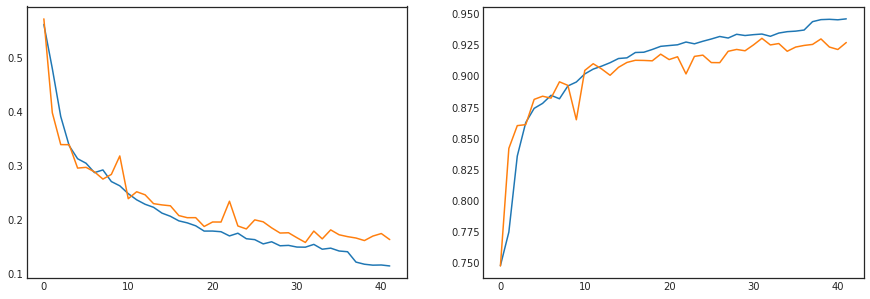

In [17]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [18]:
model = load_model(model_filepath, custom_objects={'my_iou_metric': my_iou_metric})

In [19]:
downsample128to101 = downsample(128,101)

In [20]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample128to101(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

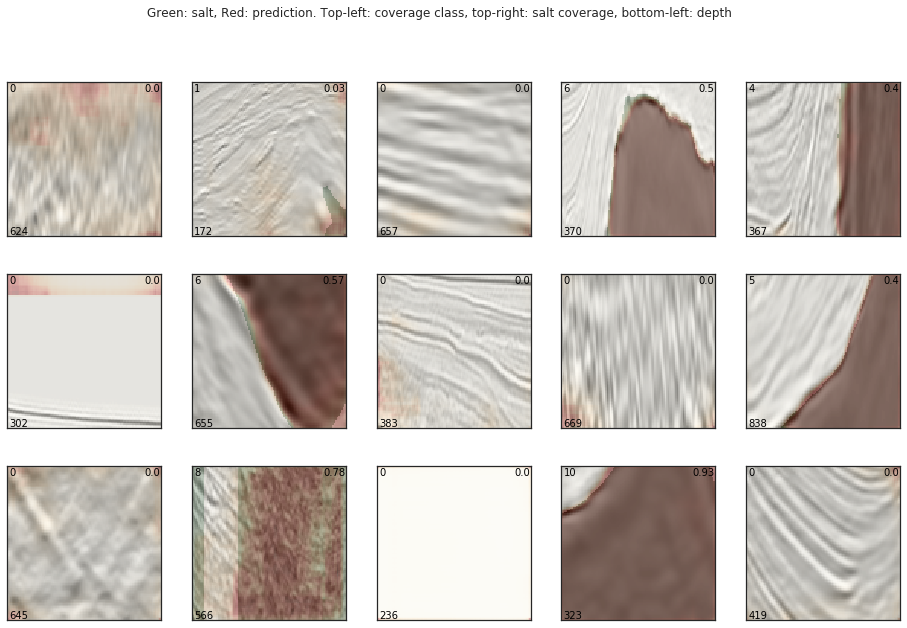

In [21]:
plot_predictions(train_df, preds_valid, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [22]:
thresholds = np.linspace(0, 1, 50)
ious = list(map(lambda th: iou_metric_batch(y_valid_ori, np.int32(preds_valid > th)), 
                tqdm_notebook(thresholds)))

In [23]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

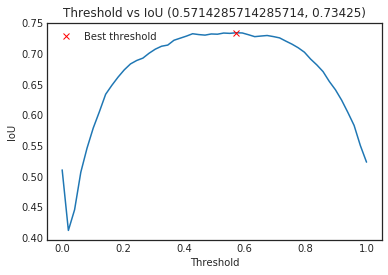

In [24]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [25]:
preds_thresh = list(map(lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32), preds_valid))

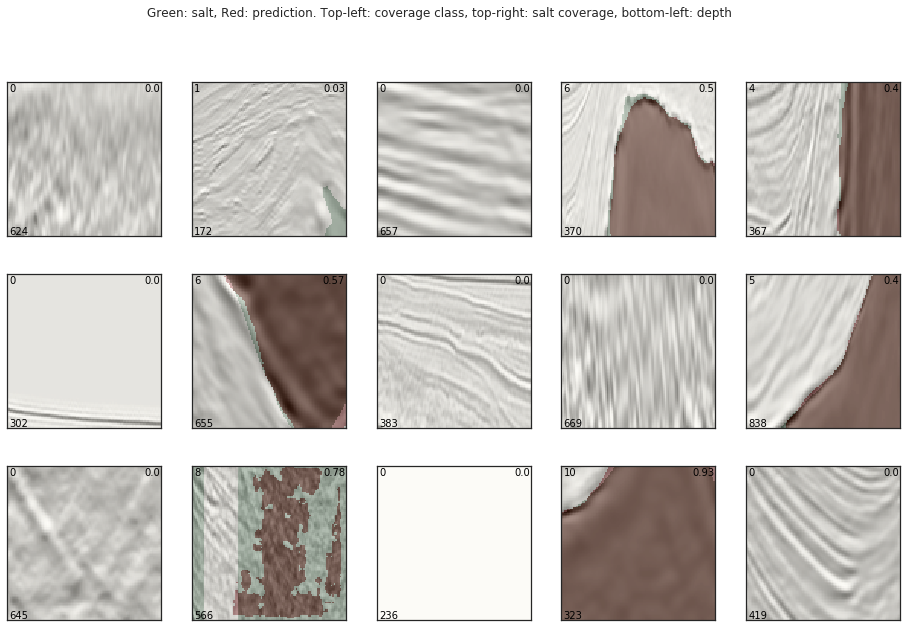

In [26]:
plot_predictions(train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16,10))

In [27]:
img_size_target=128
x_test = load_images_as_arrays(test_df.index, test_images_path())
x_test = np.array(list(map(upsample101to128, x_test)))

  0%|          | 0/18000 [00:00<?, ?it/s]

  1%|          | 125/18000 [00:00<00:14, 1247.76it/s]

  1%|▏         | 253/18000 [00:00<00:14, 1256.35it/s]

  2%|▏         | 383/18000 [00:00<00:13, 1268.44it/s]

  3%|▎         | 511/18000 [00:00<00:13, 1270.44it/s]

  4%|▎         | 641/18000 [00:00<00:13, 1277.70it/s]

  4%|▍         | 771/18000 [00:00<00:13, 1282.34it/s]

  5%|▍         | 897/18000 [00:00<00:13, 1273.46it/s]

  6%|▌         | 1017/18000 [00:00<00:13, 1249.90it/s]

  6%|▋         | 1136/18000 [00:00<00:13, 1230.77it/s]

  7%|▋         | 1258/18000 [00:01<00:13, 1226.87it/s]

  8%|▊         | 1382/18000 [00:01<00:13, 1229.06it/s]

  8%|▊         | 1503/18000 [00:01<00:13, 1221.26it/s]

  9%|▉         | 1626/18000 [00:01<00:13, 1222.73it/s]

 10%|▉         | 1750/18000 [00:01<00:13, 1226.49it/s]

 10%|█         | 1875/18000 [00:01<00:13, 1231.51it/s]

 11%|█         | 2000/18000 [00:01<00:12, 1234.33it/s]

 12%|█▏        | 2124/18000 [00:01<00:12, 1235.29it/s]

 12%|█▏        | 2248/18000 [00:01<00:12, 1232.99it/s]

 13%|█▎        | 2373/18000 [00:01<00:12, 1236.99it/s]

 14%|█▍        | 2498/18000 [00:02<00:12, 1238.21it/s]

 15%|█▍        | 2622/18000 [00:02<00:12, 1236.43it/s]

 15%|█▌        | 2747/18000 [00:02<00:12, 1239.79it/s]

 16%|█▌        | 2871/18000 [00:02<00:12, 1236.43it/s]

 17%|█▋        | 2997/18000 [00:02<00:12, 1241.43it/s]

 17%|█▋        | 3122/18000 [00:02<00:12, 1236.31it/s]

 18%|█▊        | 3247/18000 [00:02<00:11, 1237.66it/s]

 19%|█▊        | 3371/18000 [00:02<00:11, 1236.15it/s]

 19%|█▉        | 3496/18000 [00:02<00:11, 1237.28it/s]

 20%|██        | 3620/18000 [00:02<00:11, 1236.04it/s]

 21%|██        | 3747/18000 [00:03<00:11, 1243.14it/s]

 22%|██▏       | 3872/18000 [00:03<00:11, 1242.00it/s]

 22%|██▏       | 3997/18000 [00:03<00:11, 1242.61it/s]

 23%|██▎       | 4122/18000 [00:03<00:11, 1241.27it/s]

 24%|██▎       | 4248/18000 [00:03<00:11, 1244.80it/s]

 24%|██▍       | 4373/18000 [00:03<00:10, 1239.95it/s]

 25%|██▍       | 4498/18000 [00:03<00:10, 1235.57it/s]

 26%|██▌       | 4622/18000 [00:03<00:10, 1236.79it/s]

 26%|██▋       | 4746/18000 [00:03<00:10, 1234.35it/s]

 27%|██▋       | 4871/18000 [00:03<00:10, 1237.12it/s]

 28%|██▊       | 4995/18000 [00:04<00:10, 1229.82it/s]

 28%|██▊       | 5118/18000 [00:04<00:10, 1225.25it/s]

 29%|██▉       | 5241/18000 [00:04<00:10, 1225.33it/s]

 30%|██▉       | 5369/18000 [00:04<00:10, 1240.78it/s]

 31%|███       | 5494/18000 [00:04<00:10, 1223.88it/s]

 31%|███       | 5619/18000 [00:04<00:10, 1231.55it/s]

 32%|███▏      | 5743/18000 [00:04<00:09, 1230.76it/s]

 33%|███▎      | 5867/18000 [00:04<00:09, 1228.47it/s]

 33%|███▎      | 5990/18000 [00:04<00:09, 1202.11it/s]

 34%|███▍      | 6113/18000 [00:04<00:09, 1209.21it/s]

 35%|███▍      | 6237/18000 [00:05<00:09, 1216.61it/s]

 35%|███▌      | 6362/18000 [00:05<00:09, 1224.20it/s]

 36%|███▌      | 6487/18000 [00:05<00:09, 1229.22it/s]

 37%|███▋      | 6610/18000 [00:05<00:09, 1227.09it/s]

 37%|███▋      | 6733/18000 [00:05<00:09, 1225.90it/s]

 38%|███▊      | 6857/18000 [00:05<00:09, 1228.64it/s]

 39%|███▉      | 6982/18000 [00:05<00:08, 1233.37it/s]

 39%|███▉      | 7106/18000 [00:05<00:08, 1216.90it/s]

 40%|████      | 7228/18000 [00:05<00:08, 1215.36it/s]

 41%|████      | 7351/18000 [00:05<00:08, 1217.53it/s]

 42%|████▏     | 7474/18000 [00:06<00:08, 1219.70it/s]

 42%|████▏     | 7596/18000 [00:06<00:08, 1218.24it/s]

 43%|████▎     | 7721/18000 [00:06<00:08, 1226.94it/s]

 44%|████▎     | 7844/18000 [00:06<00:08, 1226.29it/s]

 44%|████▍     | 7967/18000 [00:06<00:08, 1227.17it/s]

 45%|████▍     | 8090/18000 [00:06<00:08, 1215.94it/s]

 46%|████▌     | 8215/18000 [00:06<00:08, 1222.92it/s]

 46%|████▋     | 8338/18000 [00:06<00:07, 1224.66it/s]

 47%|████▋     | 8461/18000 [00:06<00:07, 1225.40it/s]

 48%|████▊     | 8584/18000 [00:06<00:07, 1218.06it/s]

 48%|████▊     | 8707/18000 [00:07<00:07, 1221.42it/s]

 49%|████▉     | 8833/18000 [00:07<00:07, 1231.61it/s]

 50%|████▉     | 8959/18000 [00:07<00:07, 1238.21it/s]

 50%|█████     | 9083/18000 [00:07<00:07, 1234.95it/s]

 51%|█████     | 9207/18000 [00:07<00:07, 1227.56it/s]

 52%|█████▏    | 9332/18000 [00:07<00:07, 1233.74it/s]

 53%|█████▎    | 9457/18000 [00:07<00:06, 1237.15it/s]

 53%|█████▎    | 9581/18000 [00:07<00:06, 1234.31it/s]

 54%|█████▍    | 9707/18000 [00:07<00:06, 1241.70it/s]

 55%|█████▍    | 9832/18000 [00:07<00:06, 1239.54it/s]

 55%|█████▌    | 9958/18000 [00:08<00:06, 1245.10it/s]

 56%|█████▌    | 10083/18000 [00:08<00:06, 1245.34it/s]

 57%|█████▋    | 10209/18000 [00:08<00:06, 1249.36it/s]

 57%|█████▋    | 10334/18000 [00:08<00:06, 1246.92it/s]

 58%|█████▊    | 10459/18000 [00:08<00:06, 1237.54it/s]

 59%|█████▉    | 10584/18000 [00:08<00:05, 1241.23it/s]

 59%|█████▉    | 10709/18000 [00:08<00:05, 1240.43it/s]

 60%|██████    | 10835/18000 [00:08<00:05, 1245.48it/s]

 61%|██████    | 10961/18000 [00:08<00:05, 1248.04it/s]

 62%|██████▏   | 11086/18000 [00:08<00:05, 1241.96it/s]

 62%|██████▏   | 11211/18000 [00:09<00:05, 1242.89it/s]

 63%|██████▎   | 11337/18000 [00:09<00:05, 1247.14it/s]

 64%|██████▎   | 11462/18000 [00:09<00:05, 1244.53it/s]

 64%|██████▍   | 11587/18000 [00:09<00:05, 1245.04it/s]

 65%|██████▌   | 11712/18000 [00:09<00:05, 1242.14it/s]

 66%|██████▌   | 11837/18000 [00:09<00:04, 1244.16it/s]

 66%|██████▋   | 11962/18000 [00:09<00:04, 1239.73it/s]

 67%|██████▋   | 12086/18000 [00:09<00:04, 1239.55it/s]

 68%|██████▊   | 12210/18000 [00:09<00:04, 1239.14it/s]

 69%|██████▊   | 12334/18000 [00:09<00:04, 1231.47it/s]

 69%|██████▉   | 12458/18000 [00:10<00:04, 1232.25it/s]

 70%|██████▉   | 12582/18000 [00:10<00:04, 1231.68it/s]

 71%|███████   | 12707/18000 [00:10<00:04, 1234.77it/s]

 71%|███████▏  | 12831/18000 [00:10<00:04, 1236.09it/s]

 72%|███████▏  | 12956/18000 [00:10<00:04, 1239.78it/s]

 73%|███████▎  | 13082/18000 [00:10<00:03, 1243.28it/s]

 73%|███████▎  | 13207/18000 [00:10<00:03, 1241.81it/s]

 74%|███████▍  | 13332/18000 [00:10<00:03, 1241.59it/s]

 75%|███████▍  | 13458/18000 [00:10<00:03, 1246.03it/s]

 75%|███████▌  | 13583/18000 [00:10<00:03, 1243.81it/s]

 76%|███████▌  | 13709/18000 [00:11<00:03, 1247.58it/s]

 77%|███████▋  | 13834/18000 [00:11<00:03, 1247.43it/s]

 78%|███████▊  | 13959/18000 [00:11<00:03, 1239.57it/s]

 78%|███████▊  | 14083/18000 [00:11<00:03, 1238.59it/s]

 79%|███████▉  | 14207/18000 [00:11<00:03, 1233.48it/s]

 80%|███████▉  | 14331/18000 [00:11<00:02, 1234.73it/s]

 80%|████████  | 14457/18000 [00:11<00:02, 1241.71it/s]

 81%|████████  | 14582/18000 [00:11<00:02, 1236.47it/s]

 82%|████████▏ | 14706/18000 [00:11<00:02, 1236.47it/s]

 82%|████████▏ | 14830/18000 [00:11<00:02, 1232.15it/s]

 83%|████████▎ | 14956/18000 [00:12<00:02, 1237.97it/s]

 84%|████████▍ | 15081/18000 [00:12<00:02, 1240.82it/s]

 84%|████████▍ | 15206/18000 [00:12<00:02, 1236.31it/s]

 85%|████████▌ | 15334/18000 [00:12<00:02, 1246.41it/s]

 86%|████████▌ | 15459/18000 [00:12<00:02, 1246.08it/s]

 87%|████████▋ | 15584/18000 [00:12<00:01, 1229.44it/s]

 87%|████████▋ | 15710/18000 [00:12<00:01, 1236.69it/s]

 88%|████████▊ | 15835/18000 [00:12<00:01, 1237.70it/s]

 89%|████████▊ | 15959/18000 [00:12<00:01, 1238.24it/s]

 89%|████████▉ | 16083/18000 [00:13<00:01, 1236.36it/s]

 90%|█████████ | 16207/18000 [00:13<00:01, 1233.30it/s]

 91%|█████████ | 16333/18000 [00:13<00:01, 1240.52it/s]

 91%|█████████▏| 16458/18000 [00:13<00:01, 1239.20it/s]

 92%|█████████▏| 16582/18000 [00:13<00:01, 1235.31it/s]

 93%|█████████▎| 16707/18000 [00:13<00:01, 1238.93it/s]

 94%|█████████▎| 16832/18000 [00:13<00:00, 1240.65it/s]

 94%|█████████▍| 16957/18000 [00:13<00:00, 1241.35it/s]

 95%|█████████▍| 17082/18000 [00:13<00:00, 1240.22it/s]

 96%|█████████▌| 17207/18000 [00:13<00:00, 1238.16it/s]

 96%|█████████▋| 17331/18000 [00:14<00:00, 1234.93it/s]

 97%|█████████▋| 17455/18000 [00:14<00:00, 1221.63it/s]

 98%|█████████▊| 17580/18000 [00:14<00:00, 1227.09it/s]

 98%|█████████▊| 17705/18000 [00:14<00:00, 1231.69it/s]

 99%|█████████▉| 17830/18000 [00:14<00:00, 1234.56it/s]

100%|█████████▉| 17954/18000 [00:14<00:00, 1230.76it/s]

100%|██████████| 18000/18000 [00:14<00:00, 1236.04it/s]

In [28]:
x_test = x_test.reshape(-1, img_size_target, img_size_target, 1)

In [29]:
preds_test = model.predict(x_test)

In [30]:
transform = compose(run_length_encode,
                    np.round,
                    lambda x: x > threshold_best,
                    downsample128to101)

In [31]:
pred_dict = {idx: transform(preds_test[i]) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [32]:
now = datetime.datetime.now()

In [33]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
filename=os.path.join(model_path(),f"submission_{now:%d%b%Y_%H}.csv")
sub.to_csv(filename)